In [1]:
# import basic data science libraries
import numpy as np
import pandas as pd

# import utility libraries
import json
import os
import glob
import sys
from itertools import combinations
from collections import defaultdict
import re

from libreco.data import DatasetFeat
from libreco.algorithms import FM, DeepFM
from sklearn import model_selection

import tensorflow.compat.v2 as tf
from libreco.evaluation import evaluate
# import modeling libraries
import psutil

pd.set_option('display.max_columns', None)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_curr_memory():
    process = psutil.Process()
    memory_info = process.memory_info()
    rss_memory = memory_info.rss

    # Convert to megabytes
    memory_in_mb = rss_memory / (1024 * 1024)

    print(f"Memory usage: {memory_in_mb:.2f} MB")

# Loading the data

In [3]:
with open('final_letterboxd_reviews.json', 'r') as f:
    raw_reviews = json.load(f)

df = pd.DataFrame(raw_reviews)

In [4]:
# rename column appropriately
df = df.rename({'when_watched': 'review_date'}, axis=1)
# sort values by date
df = df.sort_values('review_date').reset_index(drop=True)

In [5]:
# manually remove entries with dates which can't be converted easily to datetime
df = df.loc[10:3562263,:].reset_index(drop=True)
df['review_date'] = pd.to_datetime(df['review_date'])
df = df.query('review_date >= "2011-10-01" and review_date <= "2024-11-24"').reset_index(drop=True)

In [6]:
# merge with pre-calculated sentiment scores
df = pd.merge(left=df, 
              right=pd.read_csv('vader_review_sentiments.csv'), 
              left_index=True,
              right_on='Unnamed: 0',
              how='inner')

In [7]:
# load dataset
with open('final_letterboxd_movies.json', 'r') as movie_data_file:
    movie_data_raw = json.load(movie_data_file)

movie_data = pd.json_normalize(movie_data_raw, sep='_', max_level=0)

In [8]:
# convert appropriate columns to ints and replace with 1 otherwise
movie_data['num_watched'] = [int(x) if x != '' else 1 for x in movie_data['num_watched']]
movie_data['num_watched'] = [x if x != 0 else 1 for x in movie_data['num_watched']]
movie_data['num_listed'] = [int(x) if x != '' else 1 for x in movie_data['num_listed']]
movie_data['num_liked'] = [int(x) if x != '' else 1 for x in movie_data['num_liked']]

In [9]:
# average rating
# Get mean rating based on ratings histogram
def get_mean_rating(df):
    # initialize weights and columns
    rating_weights = [0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.]
    rating_cols = ['num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
                   'num_two_half_star', 'num_three_star', 'num_three_half_star', 'num_four_star',
                   'num_four_half_star', 'num_five_star']

    # fill non-reviews with zeros
    rating_df = df.copy()[rating_cols].fillna(0)
    
    rating_df['total_ratings'] = rating_df.sum(axis=1)
    for col in rating_cols:
        rating_df[col] /= rating_df['total_ratings']

    # calculate weighted rating
    # rating_df[rating_cols] = rating_df[rating_cols].apply(lambda row: row * rating_weights, axis=1)
    rating_df[rating_cols] = rating_df[rating_cols] * rating_weights
    mean_ratings = rating_df[rating_cols].sum(axis=1)
    
    return mean_ratings

In [10]:
# add average rating
movie_data['avg_rating'] = get_mean_rating(movie_data)

In [11]:
movie_data['year_adjusted'] = movie_data['movie_year'] - 2024

In [12]:
movie_data = movie_data.drop([
    'num_half_star', 'num_one_star', 'num_one_half_star', 'num_two_star',
    'num_two_half_star', 'num_three_star', 'num_three_half_star', 'num_four_star',
    'num_four_half_star', 'num_five_star'], axis=1)

In [13]:
def add_genres_OHE(df):
    all_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
                  'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
                  'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
                  'Thriller', 'TV Movie', 'War', 'Western']
    genres = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()[all_genres]
    genres.columns = 'genre_' + genres.columns
    df = pd.concat([df, genres], axis=1)
    # downcast ints
    for c in list(genres.columns):
        df[c] = df[c].astype('int8')
    return df

def add_language_OHE(df):
    languages = ['English', 'Japanese', 'French', 'No spoken language', 
             'Spanish', 'Italian', 'German', 'Korean', 'Cantonese', 'Chinese']

    language_df = pd.get_dummies(df['primary_language'].explode()).groupby(level=0).sum()[languages]
    language_df.columns = 'language_' + language_df.columns.str.lower()
    df = pd.concat([df, language_df], axis=1)
    return df

In [14]:
movie_data = movie_data.pipe(add_genres_OHE).pipe(add_language_OHE)

In [15]:
df = df.drop(['Unnamed: 0', 'movie_id_y', 'review_date_y'], axis=1)
df = df.rename({'movie_id_x': 'movie_id', 'movie_year_x': 'movie_year', 'review_date_x': 'review_date'}, axis=1)

In [16]:
# merge datasets
df_merged = pd.merge(df, movie_data, on='movie_id', how='inner')

In [17]:
# drop duplicate `movie_year` columns and rename remaining column
df_merged.drop('movie_year_x', axis=1, inplace=True)
df_merged.rename({'movie_year_y': 'movie_year'}, axis=1, inplace=True)

In [18]:
# replace spoiler heading from Letterboxd HTML
df_merged['review'] = df_merged['review'].apply(lambda x: x.replace('This review may contain spoilers. I can handle the truth. This review may contain spoilers. ', ''))

In [19]:
for int8_col in ['rewatched', 'liked', 'in_collection']:
    df_merged[int8_col] = df_merged[int8_col].astype('int8')

for int16_col in ['movie_year', 'top_250_rank']:
    df_merged[int16_col] = df_merged[int16_col].astype('int16')

for int32_col in ['num_likes', 'imdb_id', 'tmdb_id', 'num_watched', 'num_listed', 
                  'num_liked'
                 ]:
    df_merged[int32_col] = df_merged[int32_col].astype('int32')

In [20]:
print(f'Currently using {np.round(sum(df_merged.memory_usage()) * 1e-9, 2)} GB')

Currently using 1.28 GB


In [21]:
df_merged = df_merged.drop('user_y', axis=1).rename({'user_x': 'user'}, axis=1)

In [22]:
modeling_data = df_merged.query('review_date >= "2022-01-01"').reset_index(drop=True).reset_index(drop=True)

# Feature engineering

## User features

### Average rating

In [23]:
# returns a df with users and their average rating
def user_avg_rating(df):
    return (df
            .groupby('user')['rating']
            .agg('mean')
            .reset_index()
            .rename({'rating': 'user_avg_rating'}, axis=1)
           )

# returns a df with users and their average weighted rating
def weighted_user_avg_rating(df):
    def add_weighted_rating(subset):
        ratings = subset.sort_values('review_date', ascending=False)[['rating']].reset_index(drop=True)
        ratings.index += 1
        # weight: e^(-index / 10)
        w = 2 ** (-(ratings.index / 5))
        
        num = np.sum(ratings['rating'] * w)
        denom = np.sum(w)
        
        return num / denom
    return (df
            .groupby('user')[['user', 'review_date', 'rating']]
            .apply(add_weighted_rating)
            .reset_index()
            .rename({0: 'user_weighted_avg_rating'}, axis=1)
           )

### Percent liked

In [24]:
def user_percent_liked(df):
    return df.groupby('user')['liked'].agg('mean').reset_index().rename({'liked': 'user_percent_liked'}, axis=1)

def user_weighted_percent_liked(df):
    def add_weighted_percent_liked(subset):
        ratings = subset.sort_values('review_date', ascending=False)[['liked']].reset_index(drop=True)
        ratings.index += 1
        # weight: e^(-index / 10)
        w = 2 ** (-(ratings.index / 5))
        
        num = np.sum(ratings['liked'] * w)
        denom = np.sum(w)
        
        return num / denom
    return (df
            .groupby('user')[['user', 'review_date', 'liked']]
            .apply(add_weighted_percent_liked)
            .reset_index()
            .rename({0: 'user_weighted_percent_liked'}, axis=1))

### Percent watched each genre and language

In [25]:
def user_percent_watched_genres(df):
    return (df
            .filter(regex=r'genre_|user', axis=1)
            .groupby('user')
            .agg('mean')
            .reset_index()
            .rename(columns=lambda x: re.sub(r'genre_', 'user%_genre_', x))
           )

def user_percent_watched_languages(df):
    return (df
            .filter(regex=r'language_|user', axis=1)
            .groupby('user')
            .agg('mean')
            .reset_index()
            .rename(columns=lambda x: re.sub(r'language_', 'user%_language_', x))
           )

### Median year adjusted

In [26]:
def user_year_adjusted(df):
    df['year_adjusted'] = df['movie_year'] - 2024
    return (df
            .groupby('user')['year_adjusted']
            .agg('median')
            .reset_index()
            .rename({'year_adjusted': 'user_med_year_adj'}, axis=1)
           )

## Movie Features

### Average rating

In [27]:
def movie_avg_rating(df):
    return (df
            .groupby('movie_id')['rating']
            .agg('mean')
            .reset_index()
            .rename({'rating': 'movie_avg_rating'}, axis=1)
           )

def weighted_movie_avg_rating(df):
    def add_weighted_rating(subset):
        ratings = subset.sort_values('review_date', ascending=False)[['rating']].reset_index(drop=True)
        ratings.index += 1
        # weight: e^(-index / 10)
        w = 2 ** (-(ratings.index / 10))
        
        num = np.sum(ratings['rating'] * w)
        denom = np.sum(w)
        
        return num / denom
    return (df
            .groupby('movie_id')[['movie_id', 'review_date', 'rating']]
            .apply(add_weighted_rating)
            .reset_index()
            .rename({0: 'movie_weighted_avg_rating'}, axis=1)
           )

### Percent liked

In [28]:
def movie_percent_liked(df):
    return df.groupby('movie_id')['liked'].agg('mean').reset_index().rename({'liked': 'movie_percent_liked'}, axis=1)

def movie_weighted_percent_liked(df):
    def add_weighted_percent_liked(subset):
        ratings = subset.sort_values('review_date', ascending=False)[['liked']].reset_index(drop=True)
        ratings.index += 1
        # weight: e^(-index / 10)
        w = 2 ** (-(ratings.index / 10))
        
        num = np.sum(ratings['liked'] * w)
        denom = np.sum(w)
        
        return num / denom
    return (df
            .groupby('movie_id')[['movie_id', 'review_date', 'liked']]
            .apply(add_weighted_percent_liked)
            .reset_index()
            .rename({0: 'movie_weighted_percent_liked'}, axis=1))

### Percent watched each genre

In [29]:
def movie_percent_watched_genres(df):
    return (df
            .filter(regex=r'genre_|movie_id', axis=1)
            .groupby('movie_id')
            .agg('mean')
            .reset_index()
            .rename(columns=lambda x: re.sub(r'genre_', 'movie%_genre_', x))
           )

def movie_percent_watched_languages(df):
    return (df
            .filter(regex=r'language_|movie_id', axis=1)
            .groupby('movie_id')
            .agg('mean')
            .reset_index()
            .rename(columns=lambda x: re.sub(r'language_', 'movie%_language_', x))
           )

### Year adjusted

In [30]:
def movie_year_adjusted(df):
    df['movie_year_adjusted'] = df['movie_year'] - 2024
    return df[['movie_id', 'movie_year_adjusted']]

## Temporal features

# Train/valid/test split

In [31]:
del movie_data
del df
del df_merged

In [32]:
train_cutoff = modeling_data.loc[int(len(modeling_data)*.9):,:]

In [33]:
train_cutoff

,rating,review,review_date,movie,user,review_link,movie_id,num_likes,liked,rewatched,liked_reviews,tags,review_neg,review_neu,review_pos,review_comp,movie_name,movie_year,movie_tagline,movie_desc,movie_len,genres,top_keywords,in_collection,collection_name,studios,countries,primary_language,spoken_langauges,imdb_id,tmdb_id,cast,crew,num_watched,num_listed,num_liked,top_250_rank,avg_rating,year_adjusted,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_Thriller,genre_TV Movie,genre_War,genre_Western,language_english,language_japanese,language_french,language_no spoken language,language_spanish,language_italian,language_german,language_korean,language_cantonese,language_chinese
2767182,3.0,glen powell always looked like the philosophic...,2024-09-24,Everybody Wants Some!!,daniyalkamran,/daniyalkamran/film/everybody-wants-some/,everybody-wants-some,15,0,0,{},[],0.145,0.790,0.065,-0.9799,Everybody Wants Some!!,2016,Here for a good time. Not a long time.,A comedy that follows a group of friends as th...,116,[Comedy],"[Underdogs and coming of age, Teen school anti...",0,,"{'annapurna-pictures': 'Annapurna Pictures', '...",{'usa': 'USA'},English,[],2937696,295699,"{'Blake Jenner': None, 'Zoey Deutch': None, 'R...","{'Richard Linklater': ['director', 'producer',...",162929,45237,47743,0,3.694540,-8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2767183,5.0,WE LOVE ANNETTE! equal parts ijbolian and movi...,2024-09-24,Annette,audreys77,/audreys77/film/annette/,annette,22,1,0,{'/miniike/film/annette/1/': 5.0},[],0.261,0.739,0.000,-0.2769,Annette,2021,"As dangerous, as intense, as love.","The story of Henry, a stand-up comedian with a...",140,"[Romance, Drama]","[Humanity and the world around us, Song and da...",0,,"{'eurospace': 'Eurospace', 'detailfilm': 'Deta...","{'belgium': 'Belgium', 'france': 'France', 'ge...",English,"[French, English]",6217926,424277,"{'Adam Driver': None, 'Marion Cotillard': None...","{'Leos Carax': ['director'], 'Julio Chavezmont...",139534,45354,33702,0,3.356324,-3,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2767184,3.0,,2024-09-24,Kalki 2898-AD,scottstreet,/scottstreet/film/kalki-2898-ad/,kalki-2898-ad,0,0,0,{},[],0.000,1.000,0.000,0.0000,Kalki 2898-AD,2024,"When the world is taken over by darkness, a ne...","In the year 2898 AD, around 6000 years after K...",176,"[Drama, Fantasy, Action, Science Fiction]","[Epic heroes, Superheroes in action-packed bat...",1,kalki-collection,"{'vyjayanthi-movies': 'Vyjayanthi Movies', 'an...",{'india': 'India'},Telugu,[],12735488,801688,"{'Amitabh Bachchan': None, 'Kamal Haasan': Non...","{'Nag Ashwin': ['director', 'writer', 'story']...",34396,4873,9755,0,3.276534,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2767185,4.0,,2024-09-24,A Traveler's Needs,_gellious,/_gellious/film/a-travelers-needs/1/,a-travelers-needs,0,1,1,{},[],0.000,1.000,0.000,0.0000,A Traveler’s Needs,2024,,"Iris, a woman abroad in Seoul, teaches French ...",90,[Drama],[],0,,"{'jeonwonsa-film': 'Jeonwonsa Film', 'finecut-...",{'south-korea': 'South Korea'},Korean,"[English, French, Korean]",31015344,1146410,"{'Isabelle Huppert': None, 'Lee Hye-young': No...","{'Hong Sang-soo': ['director', 'producer', 'wr...",6333,3142,1901,0,3.468622,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2767186,3.5,,2024-09-24,The Substance,gyllenhaall,/gyllenhaall/film/the-substance/,the-substance,0,1,0,{},[],0.000,0.732,0.268,0.0258,The Substance,2024,"If you follow the instructions, what could go ...",A fading celebrity decides to use a black mark...,141,"[Horror, Science Fiction, Thriller]","[Intense violence and sexual transgression, Hu...",0,,"{'working-title-films': 'Working Title Films',...","{'france': 'France', 'uk': 'UK'}",English,[],17526714,933260,"{'Demi Moore': None, 'Margaret Qualley': None,..

In [36]:
test_data = modeling_data.query('review_date >= @train_cutoff')

In [37]:
first_test_index = test_data.index[0]

In [38]:
train_data = modeling_data.loc[:first_test_index,:]

In [39]:
tss = model_selection.TimeSeriesSplit()

In [40]:
train_indices = []
valid_indices = []

for i, (train_index, valid_index) in enumerate(tss.split(train_data)):
    train_indices.append(train_index)
    valid_indices.append(valid_index)

## Visualization

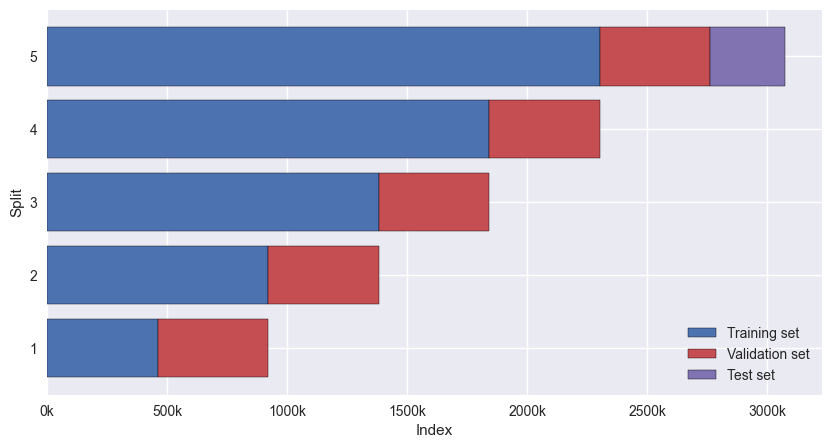

In [76]:
fig, ax = plt.subplots(figsize=(10,5))

sns_blue = '#4C72B0'
sns_red = '#C44E52'
sns_purple = '#8172B2'

for i in range(len(train_indices)):
    train_i = train_indices[i]
    valid_i = valid_indices[i]
    if i == 1:
        ax.barh([i+1], left=min(train_i), width=len(train_i), height=0.8, color=sns_blue, edgecolor='black', label='Training set')
        ax.barh([i+1], left=min(valid_i), width=len(valid_i), height=0.8, color=sns_red, edgecolor='black', label='Validation set')
    else:
        ax.barh([i+1], left=min(train_i), width=len(train_i), height=0.8, color=sns_blue, edgecolor='black')
        ax.barh([i+1], left=min(valid_i), width=len(valid_i), height=0.8, color=sns_red, edgecolor='black')

    

ax.barh(len(train_indices), left=min(test_data.index), width=len(test_data), color=sns_purple, edgecolor='black', label='Test set')

# ax.set_xticks([i + len(momodeling_data['review_date'] for in in range()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x * 1e-3)))

plt.legend()
plt.ylabel('Split')
plt.xlabel('Index')

plt.savefig('visualizations/validation.png', bbox_inches='tight')

plt.show()

## Adding Features

In [35]:
# creates a df of unique users with user features
def add_user_features(df):
    user_feat_funcs = [user_avg_rating, weighted_user_avg_rating, user_percent_liked,
                       user_weighted_percent_liked, user_percent_watched_genres,
                       user_percent_watched_languages]

    user_dfs = []

    for f in user_feat_funcs:
        print(f'Adding user features from {f.__name__}')
        user_dfs.append(f(df))
    
    interactions = pd.DataFrame({'user': df['user'].unique()})
    
    for i in range(len(user_dfs)):
        print(f'Merging user features from {user_feat_funcs[i].__name__}')
        d = user_dfs[i]
        interactions = pd.merge(interactions, d, on='user')

    return interactions

# creates a df of unique movie_ids with movie features
def add_movie_features(df):
    movie_feat_funcs = [movie_avg_rating, weighted_movie_avg_rating, movie_percent_liked,
                        movie_weighted_percent_liked, movie_percent_watched_genres,
                        movie_percent_watched_languages]

    movie_dfs = []

    for f in movie_feat_funcs:
        print(f'Adding movie features from {f.__name__}')
        movie_dfs.append(f(df))

    interactions = pd.DataFrame({'movie_id': df['movie_id'].unique()})
    
    for i in range(len(movie_dfs)):
        print(f'Merging movie features from {movie_feat_funcs[i].__name__}')
        d = movie_dfs[i]
        interactions = pd.merge(interactions, d, on='movie_id')

    return interactions

# adds users and movie_ids to main df
def add_features(df):
    # add user features
    print('Adding user features')
    user_features = add_user_features(df)
    print('Added user features')
    print('Adding movie features')
    get_curr_memory()
    movie_features = add_movie_features(df)
    print('Added movie features')
    get_curr_memory()

    df = df[['user', 'movie_id']]
    print('Merging user features')
    get_curr_memory()
    df = pd.merge(df, user_features, on='user')
    print('Merged user features')
    get_curr_memory()
    del user_features
    print('Deleted user_features')
    get_curr_memory()
    print('Merging movie features')
    df = pd.merge(df, movie_features, on='movie_id')

    return df


In [55]:
trainsets = []
validsets = []

In [ ]:
get_curr_memory()

In [36]:
temp_train = add_features(train_cutoff)

temp_train = temp_train.rename({'movie_id': 'item'}, axis=1)
temp_train['label'] = np.ones(len(temp_train))
get_curr_memory()
temp_train.to_csv(f'modeling/processed_data/testset.csv', index=False)

Adding user features
Adding user features from user_avg_rating
Adding user features from weighted_user_avg_rating
Adding user features from user_percent_liked
Adding user features from user_weighted_percent_liked
Adding user features from user_percent_watched_genres
Adding user features from user_percent_watched_languages
Merging user features from user_avg_rating
Merging user features from weighted_user_avg_rating
Merging user features from user_percent_liked
Merging user features from user_weighted_percent_liked
Merging user features from user_percent_watched_genres
Merging user features from user_percent_watched_languages
Added user features
Adding movie features
Memory usage: 6443.81 MB
Adding movie features from movie_avg_rating
Adding movie features from weighted_movie_avg_rating
Adding movie features from movie_percent_liked
Adding movie features from movie_weighted_percent_liked
Adding movie features from movie_percent_watched_genres
Adding movie features from movie_percent_wat

In [48]:
for i in range(1, len(train_indices)):
    print(f'Processing feature iteration {i}')
    temp_train = modeling_data.loc[train_indices[i],:]
    temp_train = add_features(temp_train)

    temp_train = temp_train.rename({'movie_id': 'item'}, axis=1)
    temp_train['label'] = np.ones(len(temp_train))
    get_curr_memory()
    temp_train.to_csv(f'trainset_{i}.csv', index=False)

    # trainsets.append(temp_train)
    
    temp_valid = modeling_data.loc[valid_indices[i], :]
    temp_valid = add_features(temp_valid)

    temp_valid = temp_valid.rename({'movie_id': 'item'}, axis=1)
    temp_valid['label'] = np.ones(len(temp_valid))
    temp_valid.to_csv(f'validset_{i}.csv', index=False)
    
    # validsets.append(temp_valid)

Processing feature iteration 1
Adding user features
Adding user features from user_avg_rating
Adding user features from weighted_user_avg_rating
Adding user features from user_percent_liked
Adding user features from user_weighted_percent_liked
Adding user features from user_percent_watched_genres
Adding user features from user_percent_watched_languages
Merging user features from user_avg_rating
Merging user features from weighted_user_avg_rating
Merging user features from user_percent_liked
Merging user features from user_weighted_percent_liked
Merging user features from user_percent_watched_genres
Merging user features from user_percent_watched_languages
Added user features
Adding movie features
Memory usage: 5723.95 MB
Adding movie features from movie_avg_rating
Adding movie features from weighted_movie_avg_rating
Adding movie features from movie_percent_liked
Adding movie features from movie_weighted_percent_liked
Adding movie features from movie_percent_watched_genres
Adding movie 

In [45]:
test = pd.read_csv('trainset_0.csv')

In [47]:
del test

# Factorization machine

In [5]:
get_curr_memory()

Memory usage: 1170.74 MB


In [4]:
user_cols = list(train.filter(regex=r'user%|user_', axis=1).columns)
movie_cols = list(train.filter(regex=r'movie%|movie_', axis=1).columns)

sparse_cols = list(train.filter(regex=r'genre|language', axis=1).columns)

dense_cols = user_cols.copy()
dense_cols.extend(movie_cols)
dense_cols = [c for c in dense_cols if c not in sparse_cols]

In [3]:
train = pd.read_csv('modeling/processed_data/trainset_0.csv')
valid = pd.read_csv('modeling/processed_data/validset_0.csv')
valid = valid[valid['user'].isin(train['user'].unique())]

In [11]:
train0_dataset, train0_data_info = DatasetFeat.build_trainset(train, 
                                                           user_col=user_cols,
                                                           item_col=movie_cols,
                                                           sparse_col=sparse_cols,
                                                           dense_col=dense_cols)
valid_dataset = DatasetFeat.build_evalset(valid)

In [81]:
def create_fit_FM(trainset, data_info, reg, rebuild=False):
    # reset tf default graph
    tf.compat.v1.reset_default_graph()
    
    # create model
    fm = FM(task='ranking',
        data_info=data_info,
        reg=reg,
        n_epochs=10,
        seed=42
       )

    if rebuild:
        model_name = f'fm_model0_{str(reg).replace(".", "_")}'
        fm.rebuild_model(path=f'modeling/model/{model_name}', 
                         model_name=model_name, 
                         full_assign=True)
    
    # fit model
    fm.fit(
    trainset,
    neg_sampling=True,
    verbose=2,
    shuffle=False
    )

    
    return fm

def eval_FM(fm, validset, k, metrics):
    eval_result = evaluate(
        model=fm,
        data=validset,
        eval_batch_size=8192,
        k=k,
        metrics=metrics,
        sample_user_num=2048,
        neg_sampling=True,
        seed=42
    )
    return eval_result

In [68]:
train1 = pd.read_csv('modeling/processed_data/trainset_1.csv')#.loc[len(train):,:]
valid1 = pd.read_csv('modeling/processed_data/validset_1.csv')
valid1 = valid1[valid1['user'].isin(train1['user'].unique())]

In [69]:
train1_dataset, train1_data_info = DatasetFeat.build_trainset(train1, 
                                                           user_col=user_cols,
                                                           item_col=movie_cols,
                                                           sparse_col=sparse_cols,
                                                           dense_col=dense_cols)

valid1_dataset = DatasetFeat.build_evalset(valid1)

In [70]:
ls = [None, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
ks = [10]
metrics = ['log_loss', 'roc_auc', 'precision', 'recall', 'ndcg']
evals_1_new = []

In [82]:
for l in ls:
    # create and fit model
    fm = create_fit_FM(trainset=train1_dataset, data_info=train1_data_info, reg=l, rebuild=False)
    print(f'reg param: {l}')

    # evaluate @10, @30, and @50 while updating model
    for k in ks:
        print(f'Evaluating metrics @{k}:')
        evaluation = eval_FM(fm=fm,
                              validset=valid1_dataset,
                              k=k,
                              metrics=metrics)
        display(evaluation)

        # append to evaluation list with reg and k
        evals_1_new.append((l, k, evaluation))

    # save model 
    model_name = f'fm_model1_{str(l).replace(".", "_")}'
    fm.save(path=f'modeling/model/{model_name}', model_name=model_name, )

Training start time: 2024-12-03 17:55:16
total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:47<00:00, 67.11it/s]


Epoch 1 elapsed: 107.227s
	 train_loss: 0.3636


train: 100%|████████████████████████████████| 7196/7196 [01:59<00:00, 60.24it/s]


Epoch 2 elapsed: 119.453s
	 train_loss: 0.2894


train: 100%|████████████████████████████████| 7196/7196 [01:59<00:00, 60.24it/s]


Epoch 3 elapsed: 119.460s
	 train_loss: 0.2762


train: 100%|████████████████████████████████| 7196/7196 [01:58<00:00, 60.93it/s]


Epoch 4 elapsed: 118.115s
	 train_loss: 0.2678


train: 100%|████████████████████████████████| 7196/7196 [01:55<00:00, 62.51it/s]


Epoch 5 elapsed: 115.116s
	 train_loss: 0.2616


train: 100%|████████████████████████████████| 7196/7196 [01:55<00:00, 62.45it/s]


Epoch 6 elapsed: 115.232s
	 train_loss: 0.2556


train: 100%|████████████████████████████████| 7196/7196 [01:55<00:00, 62.43it/s]


Epoch 7 elapsed: 115.291s
	 train_loss: 0.2505


train: 100%|████████████████████████████████| 7196/7196 [01:56<00:00, 62.02it/s]


Epoch 8 elapsed: 116.038s
	 train_loss: 0.2457


train: 100%|████████████████████████████████| 7196/7196 [01:57<00:00, 61.19it/s]


Epoch 9 elapsed: 117.600s
	 train_loss: 0.2411


train: 100%|████████████████████████████████| 7196/7196 [01:57<00:00, 61.04it/s]


Epoch 10 elapsed: 117.889s
	 train_loss: 0.2366
reg param: None
Evaluating metrics @10:


eval_pointwise:   1%|▎                           | 1/93 [00:00<00:09,  9.43it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   3%|▉                           | 3/93 [00:00<00:09,  9.28it/s]

Detect 210 unknown interaction(s), position: [0, 6144, 4, 7686, 3082, 3598, 3088, 3600, 5648, 6674, 2072, 7192, 26, 3098, 1052, 4124, 3614, 4638, 6176, 2594, 42, 3114, 2092, 7726, 48, 2096, 4656, 4148, 2614, 7734, 4152, 6200, 4666, 4672, 5696, 578, 586, 4690, 6226, 6228, 6740, 2646, 7766, 7768, 5722, 3164, 4704, 6244, 5222, 1642, 7786, 6252, 624, 2672, 6768, 3700, 4724, 6260, 5112, 2170, 638, 642, 3202, 5114, 5254, 2696, 4232, 2186, 1164, 4750, 7822, 1170, 660, 7318, 7830, 6810, 7834, 7836, 4258, 5282, 6138, 6306, 4262, 2218, 4266, 4780, 2222, 3246, 6830, 6330, 2236, 4286, 6334, 2242, 198, 3782, 3274, 6348, 7164, 7884, 2256, 216, 7896, 730, 7386, 7904, 3298, 1764, 4324, 5350, 6372, 6884, 5868, 2800, 242, 2808, 6906, 7934, 3330, 5392, 6928, 1810, 2322, 1814, 6938, 6432, 802, 5410, 7970, 4390, 5414, 2862, 7982, 6960, 4918, 2876, 4924, 5956, 330, 842, 846, 4434, 1876, 5972, 1366, 3926, 1880, 2904, 4952, 3938, 7526, 7016, 4970, 8042, 3948, 7536, 6516, 6008, 8056, 1914, 382, 8062, 6020, 397

eval_pointwise:   6%|█▊                          | 6/93 [00:00<00:08, 10.68it/s]

Detect 207 unknown interaction(s), position: [6658, 4, 3590, 5128, 7178, 1042, 22, 1048, 7704, 7706, 28, 4638, 6174, 2084, 4644, 1064, 2092, 5676, 46, 52, 1588, 2100, 3638, 56, 1592, 2106, 2622, 5696, 1604, 7240, 586, 5198, 2128, 2134, 4696, 1638, 5228, 6254, 3696, 628, 5238, 2168, 1148, 3200, 5248, 6272, 6274, 1670, 5766, 7816, 7818, 7820, 656, 3730, 148, 3740, 674, 7842, 164, 1188, 4260, 5800, 3756, 174, 2224, 1202, 180, 182, 1208, 3256, 6840, 3774, 706, 2754, 1220, 710, 4806, 6344, 3276, 1236, 2262, 5334, 6358, 2268, 5342, 5862, 7398, 748, 238, 4334, 7406, 7920, 758, 1274, 2812, 7936, 262, 5382, 776, 5894, 778, 7434, 6924, 5392, 4370, 7966, 6432, 2342, 4390, 6440, 6952, 7978, 3372, 814, 3374, 1328, 3888, 4910, 7470, 312, 2360, 3386, 4408, 5948, 320, 1856, 6980, 1868, 1870, 4942, 5972, 2390, 5462, 856, 4440, 6490, 350, 1374, 3422, 3936, 5986, 7518, 358, 5990, 360, 1384, 1388, 1900, 2924, 4976, 6512, 7024, 6518, 6520, 8056, 1914, 2938, 380, 3452, 6010, 896, 7040, 5508, 902, 4998, 904,

eval_pointwise:   9%|██▍                         | 8/93 [00:00<00:07, 11.75it/s]

Detect 218 unknown interaction(s), position: [4612, 6660, 6152, 7176, 5130, 3086, 4110, 5648, 5650, 1556, 7188, 7702, 26, 3098, 3610, 2084, 4132, 2598, 1582, 2606, 4656, 7214, 1592, 6714, 572, 1596, 4670, 6718, 7228, 2626, 6210, 7236, 6214, 1096, 590, 5710, 3152, 6224, 5208, 5212, 606, 6240, 3682, 7778, 3684, 6254, 6256, 116, 2676, 7286, 7798, 4728, 634, 3708, 128, 4738, 5762, 5768, 4236, 6284, 658, 148, 6294, 5784, 3226, 3738, 7838, 7842, 164, 6312, 6648, 1706, 1708, 7340, 7852, 4276, 6326, 7160, 3770, 4282, 192, 704, 4800, 5826, 2756, 7362, 3270, 7878, 2762, 3786, 1230, 4302, 1744, 2256, 5840, 5842, 212, 6864, 7376, 7886, 5850, 3292, 5340, 5852, 4320, 226, 742, 7912, 3818, 1772, 1262, 752, 3826, 1268, 7412, 4342, 250, 1276, 3324, 4348, 4864, 6912, 2818, 4354, 1284, 4358, 7430, 5898, 1298, 6418, 2324, 4884, 6930, 7442, 2844, 1828, 5924, 7972, 3376, 2360, 6456, 6458, 7994, 5438, 1344, 1856, 2882, 3908, 1352, 2892, 3918, 6486, 856, 3932, 3422, 874, 3946, 4972, 4974, 6510, 2416, 8046, 70

eval_pointwise:  13%|███▍                       | 12/93 [00:01<00:07, 10.72it/s]

Detect 214 unknown interaction(s), position: [7168, 6148, 7172, 7686, 2058, 3594, 6154, 6666, 2062, 5648, 2580, 6676, 534, 2072, 4632, 5658, 5662, 32, 6178, 6180, 7716, 1574, 7720, 44, 5164, 558, 3630, 5680, 6192, 1074, 6196, 1590, 1594, 6714, 3132, 5182, 5694, 64, 2112, 1090, 68, 2116, 5702, 6726, 2124, 7756, 590, 1102, 1104, 5710, 594, 6224, 6232, 2666, 3692, 120, 2684, 3198, 130, 1668, 3206, 5260, 144, 3728, 5266, 4244, 3222, 3226, 668, 2716, 4766, 5788, 7838, 7846, 168, 3752, 4776, 4778, 6326, 5816, 6840, 3258, 1724, 6332, 190, 6334, 7358, 1218, 2754, 3266, 7364, 1222, 4304, 730, 1252, 2276, 232, 5352, 3306, 4842, 6892, 1262, 2798, 240, 4848, 5880, 6904, 2298, 5370, 766, 2822, 1800, 778, 5898, 5390, 784, 2320, 3862, 7958, 1314, 1826, 7460, 6440, 7464, 6446, 3376, 818, 3384, 826, 2874, 7994, 2878, 1344, 2884, 8008, 4938, 2382, 4944, 5462, 3416, 4952, 2906, 1884, 2400, 3426, 4452, 2922, 5484, 1902, 8048, 370, 4978, 8054, 2936, 6520, 7032, 1404, 7038, 1408, 4480, 1410, 3466, 4490, 654

eval_pointwise:  15%|████                       | 14/93 [00:01<00:07, 10.43it/s]

Detect 323 unknown interaction(s), position: [2050, 6146, 4102, 1032, 10, 5132, 7180, 4110, 18, 7186, 20, 5142, 5148, 5152, 7202, 2042, 36, 7204, 38, 2088, 5164, 4144, 6192, 5174, 4156, 3132, 3136, 1094, 4168, 6216, 7246, 5212, 2152, 3180, 2158, 112, 2160, 5246, 1152, 6274, 3204, 1158, 7304, 5260, 7308, 1166, 3214, 144, 1176, 2202, 4250, 156, 1180, 4256, 4258, 6308, 7332, 7336, 1194, 182, 1206, 7354, 4286, 3262, 3264, 4300, 5328, 214, 1240, 2268, 6368, 5344, 4322, 7398, 7400, 7404, 4334, 6388, 2296, 7424, 4358, 5382, 2314, 2316, 3340, 5390, 3350, 280, 4380, 7452, 286, 2340, 4390, 6446, 308, 6452, 3380, 7480, 1336, 6458, 3388, 7486, 320, 2370, 1346, 6470, 5446, 3400, 1362, 5458, 6486, 4450, 3426, 2404, 3432, 7530, 6516, 376, 6520, 6524, 5500, 2430, 1406, 1408, 5506, 5508, 5516, 400, 402, 5522, 2454, 1430, 2458, 2460, 1442, 430, 444, 2500, 4554, 5582, 5584, 5590, 1500, 1504, 1510, 2536, 4584, 4586, 5612, 6638, 5616, 3570, 7674, 1530, 5634, 4612, 7684, 522, 4620, 528, 540, 4638, 550, 554,

eval_pointwise:  17%|████▋                      | 16/93 [00:01<00:07, 10.10it/s]

Detect 243 unknown interaction(s), position: [2560, 6144, 2050, 1542, 6150, 6664, 3082, 4110, 3092, 1046, 6168, 7192, 2586, 6682, 1564, 5150, 1056, 4642, 3112, 4648, 7210, 7214, 5688, 7736, 62, 1598, 3134, 578, 5186, 1094, 6730, 588, 4176, 3156, 7252, 4182, 5206, 6744, 6746, 1118, 3582, 6246, 5736, 7786, 7276, 6766, 7792, 1138, 1140, 118, 630, 4094, 124, 4732, 3200, 4736, 130, 1154, 132, 6274, 2182, 4744, 6280, 2194, 7828, 150, 1690, 6298, 3740, 5790, 6814, 6306, 7334, 3240, 2732, 3756, 4782, 7340, 1714, 5810, 7350, 3258, 1214, 4798, 1728, 1218, 5316, 1222, 1736, 6856, 7370, 1230, 7886, 5840, 1748, 1750, 3286, 7896, 4828, 222, 3294, 3806, 7392, 1762, 228, 742, 1260, 6380, 2798, 7916, 3824, 1266, 6898, 3828, 7410, 1790, 7940, 5384, 2826, 1806, 3342, 784, 5390, 1298, 4882, 2836, 7440, 2326, 7444, 5916, 7452, 2334, 4894, 6942, 3876, 2854, 1322, 1324, 6956, 1838, 2350, 304, 816, 306, 4400, 6966, 4408, 1348, 4934, 6470, 1866, 1356, 1868, 1358, 8012, 3408, 2388, 5460, 2392, 3928, 858, 3932, 

eval_pointwise:  19%|█████▏                     | 18/93 [00:01<00:07, 10.02it/s]

Detect 376 unknown interaction(s), position: [0, 1018, 6, 2060, 1036, 2064, 3088, 4114, 7184, 4116, 3098, 28, 4124, 6174, 7198, 6178, 5154, 2088, 7208, 5164, 1070, 50, 3128, 5178, 6204, 3134, 5182, 2112, 6208, 1092, 4168, 2122, 1106, 7250, 84, 2134, 88, 5208, 90, 2138, 94, 3170, 4090, 104, 3178, 108, 5228, 3184, 114, 5234, 2164, 5238, 1144, 3192, 6268, 1148, 2176, 3204, 7300, 136, 2184, 3210, 7314, 6136, 154, 5274, 2208, 4258, 7332, 2214, 1196, 1200, 5302, 6332, 7356, 2238, 6338, 6342, 200, 202, 7370, 2254, 1230, 7374, 5334, 3288, 2268, 3292, 5340, 2272, 1250, 7394, 2278, 238, 6382, 6388, 5364, 250, 4350, 3334, 1288, 2322, 6420, 278, 4380, 5410, 292, 5414, 2352, 4400, 310, 6456, 7482, 4414, 2368, 6470, 1352, 3402, 1356, 2382, 338, 1362, 344, 6492, 6496, 6498, 4452, 2406, 6502, 2410, 7530, 7532, 366, 5486, 4464, 7534, 7538, 5492, 6520, 3450, 5498, 4476, 2432, 4480, 1414, 392, 4488, 3464, 1422, 3472, 1430, 3478, 2462, 1440, 7584, 2470, 1450, 2476, 2478, 4528, 434, 5554, 7604, 2488, 4536,

eval_pointwise:  24%|██████▍                    | 22/93 [00:02<00:07,  9.80it/s]

Detect 319 unknown interaction(s), position: [3072, 7176, 1036, 2068, 5144, 26, 4126, 34, 5154, 7204, 6184, 3112, 6188, 46, 4150, 6198, 3126, 7222, 4154, 3136, 4162, 6212, 76, 6222, 6228, 5206, 5208, 6234, 1118, 1120, 2162, 3192, 7290, 7296, 130, 2186, 140, 1164, 2192, 4246, 1174, 5270, 7320, 4252, 1180, 5276, 5282, 5284, 4266, 172, 2220, 2222, 6316, 6320, 5296, 7348, 3254, 1212, 1214, 5310, 4296, 1224, 7368, 5324, 3278, 5326, 208, 3282, 4308, 5332, 5340, 7390, 6370, 1252, 5348, 7396, 6380, 5356, 3312, 1272, 7418, 5372, 260, 4358, 3334, 1288, 6414, 294, 5414, 4392, 2346, 7468, 5422, 7470, 2354, 6454, 312, 5438, 1344, 322, 1348, 2374, 1352, 6474, 7498, 2380, 6478, 1364, 3412, 6496, 7520, 2402, 1382, 3436, 5494, 376, 5498, 1406, 6528, 1418, 398, 4496, 404, 2454, 5526, 408, 3482, 4508, 420, 1444, 6566, 5540, 2476, 1452, 4536, 7608, 4538, 7614, 448, 6592, 4546, 7618, 5572, 6600, 1480, 6602, 6604, 1488, 7634, 4570, 7642, 3548, 4574, 490, 2542, 6640, 4596, 5620, 6646, 6656, 3584, 5636, 518, 

eval_pointwise:  25%|██████▋                    | 23/93 [00:02<00:07,  9.77it/s]

Detect 515 unknown interaction(s), position: [4096, 6, 2056, 10, 4108, 6158, 2064, 22, 30, 34, 4148, 6196, 60, 4156, 2110, 6206, 6214, 4170, 4172, 2130, 6226, 6230, 4186, 2140, 6236, 4190, 6242, 4196, 4202, 6250, 2156, 118, 2166, 6268, 136, 6284, 2194, 160, 6304, 6308, 4268, 176, 6322, 2230, 4280, 4284, 194, 2242, 4296, 6350, 2262, 4310, 2264, 6360, 2270, 4328, 2282, 4332, 6384, 2292, 4346, 6402, 260, 264, 4360, 268, 2322, 278, 284, 296, 4400, 4404, 2358, 2364, 6468, 2378, 334, 6480, 4438, 2392, 6490, 4446, 2404, 2406, 2412, 6508, 368, 2416, 2418, 6516, 2424, 378, 380, 2428, 2438, 2440, 6536, 396, 2448, 2452, 4502, 410, 6554, 6562, 2468, 428, 4528, 4530, 2486, 2496, 6592, 6598, 2504, 2508, 4556, 4564, 6612, 470, 2518, 474, 6618, 4584, 6634, 4590, 496, 4596, 6644, 2550, 2558, 6664, 6676, 534, 6684, 6694, 6696, 2602, 2608, 4656, 6710, 6712, 2620, 4672, 584, 6728, 4684, 606, 2656, 2660, 6760, 6762, 624, 6772, 4726, 640, 4736, 644, 2692, 2696, 6792, 6794, 2704, 4754, 2714, 4762, 4774, 2730

eval_pointwise:  28%|███████▌                   | 26/93 [00:02<00:06,  9.96it/s]

Detect 384 unknown interaction(s), position: [5120, 4098, 4108, 7182, 4114, 2068, 2070, 4128, 2082, 4138, 1066, 4140, 3114, 4142, 6196, 4150, 1092, 5190, 72, 3144, 5192, 78, 80, 1112, 6234, 3168, 4194, 1130, 1136, 3186, 4212, 118, 2168, 4218, 4224, 2178, 2182, 1160, 3208, 5256, 7316, 6294, 3222, 4250, 1178, 4252, 5276, 160, 4258, 5282, 5284, 2214, 6310, 7334, 1192, 4266, 3242, 1196, 3248, 6324, 3252, 184, 1208, 5306, 4286, 7358, 4288, 5312, 4292, 5318, 7366, 4296, 6348, 1234, 4308, 4310, 1238, 3286, 2266, 1254, 3304, 5354, 236, 5358, 4336, 6384, 7408, 7410, 4340, 3318, 7414, 2296, 4344, 250, 7422, 6402, 2308, 1284, 262, 264, 266, 7436, 4366, 3342, 6416, 3344, 274, 1300, 2326, 2328, 1304, 282, 2330, 4378, 7448, 7452, 5408, 294, 2344, 5416, 6448, 2354, 7474, 308, 310, 3382, 5430, 7480, 2362, 6458, 1342, 4420, 5448, 6474, 5460, 3418, 3428, 4456, 3432, 3436, 5484, 7534, 1392, 1394, 3442, 7542, 7544, 378, 3450, 380, 5498, 2430, 6526, 7546, 1408, 4482, 3460, 7556, 4492, 3468, 5518, 5520, 347

eval_pointwise:  32%|████████▋                  | 30/93 [00:02<00:05, 10.65it/s]

Detect 362 unknown interaction(s), position: [5120, 1030, 2066, 2072, 5146, 28, 30, 1054, 32, 4130, 4134, 7206, 1066, 2092, 6188, 3122, 7218, 2104, 4152, 6202, 6206, 6208, 3138, 5186, 7240, 2122, 7242, 7254, 1118, 96, 4192, 4194, 7264, 6244, 4090, 4206, 4214, 3190, 5238, 5240, 1146, 1148, 128, 1152, 130, 2178, 4228, 5114, 6278, 3208, 138, 1164, 5260, 2190, 4242, 7316, 4246, 2204, 2208, 6304, 6308, 168, 170, 1196, 7340, 176, 4276, 2230, 3262, 6336, 7366, 4300, 1228, 7374, 6356, 3284, 214, 5334, 2264, 1242, 2270, 226, 4328, 1258, 3308, 7404, 1268, 2294, 6390, 252, 6396, 5374, 3330, 262, 6406, 7438, 2320, 3344, 274, 6420, 2326, 7446, 7452, 288, 6432, 5408, 7456, 6436, 294, 4390, 7464, 2350, 4404, 6452, 1332, 5430, 1336, 4412, 318, 320, 1348, 328, 6478, 3410, 1364, 4458, 2416, 370, 4470, 2424, 4472, 6522, 7550, 2432, 5506, 5510, 2440, 6544, 1434, 5530, 4508, 1440, 1444, 3494, 6568, 2476, 4524, 5548, 1454, 2480, 3502, 6586, 4544, 6592, 1474, 7618, 4550, 7626, 4556, 3532, 6606, 6610, 7638, 3

eval_pointwise:  34%|█████████▎                 | 32/93 [00:03<00:05, 10.57it/s]

Detect 405 unknown interaction(s), position: [2, 6146, 4100, 7170, 3076, 5126, 3082, 4108, 1048, 7192, 26, 2078, 32, 4128, 34, 2082, 1062, 2090, 5162, 6202, 6206, 5182, 6210, 3138, 72, 5196, 7244, 1104, 3152, 7248, 2132, 6232, 92, 4188, 94, 6238, 3166, 1122, 4202, 5226, 7280, 114, 1138, 3188, 118, 3190, 7288, 124, 4224, 5248, 132, 7300, 6280, 2186, 3210, 5258, 1164, 7306, 7308, 6292, 1174, 1176, 154, 2204, 7324, 162, 3238, 4264, 6314, 4268, 3244, 6318, 184, 5306, 3270, 1224, 3272, 202, 1226, 5322, 3276, 6350, 7372, 3278, 3280, 2260, 6360, 5342, 6368, 3296, 4322, 6372, 5348, 4326, 5350, 2280, 234, 4338, 244, 5364, 6390, 3322, 4348, 3326, 6400, 1280, 1286, 3334, 4364, 1292, 270, 4370, 276, 2328, 282, 2330, 1312, 290, 2338, 2342, 296, 7466, 1324, 304, 2352, 306, 2354, 2356, 1328, 5426, 7474, 1332, 3384, 3388, 7484, 3390, 3392, 324, 2376, 3408, 2388, 5466, 2398, 6494, 7518, 5474, 356, 5478, 1384, 6506, 7530, 6512, 4466, 4470, 1404, 3452, 1408, 6530, 4484, 390, 6536, 6544, 5520, 4498, 5524,

eval_pointwise:  39%|██████████▍                | 36/93 [00:03<00:05, 11.01it/s]

Detect 366 unknown interaction(s), position: [3074, 1036, 4110, 5134, 1040, 5140, 7188, 4118, 6166, 7192, 5146, 3100, 5148, 34, 3106, 2084, 6180, 2086, 6182, 6186, 3114, 44, 6196, 2102, 2104, 58, 4158, 4160, 2116, 1092, 1096, 4170, 5194, 6222, 4180, 5206, 7256, 4188, 2142, 7264, 2146, 4196, 3172, 4204, 6254, 1138, 3188, 2166, 2170, 6266, 2174, 4224, 2180, 3204, 3208, 138, 3218, 2198, 1184, 172, 1198, 4272, 3248, 6322, 5302, 6328, 2240, 7360, 6340, 3270, 4300, 6350, 3282, 3284, 5332, 4312, 3290, 5342, 2272, 4320, 226, 1250, 3298, 1252, 3306, 5354, 4332, 6382, 5358, 4336, 3314, 5362, 246, 7414, 1272, 7418, 6402, 7430, 4360, 6408, 1288, 7438, 2324, 284, 5404, 1312, 7460, 5414, 2346, 6444, 5420, 6448, 1330, 4418, 7494, 3400, 334, 6478, 3408, 2388, 1368, 5464, 5466, 6500, 1382, 5484, 366, 1394, 6516, 6518, 3446, 3456, 7552, 3460, 4486, 392, 4490, 4494, 4498, 4502, 2456, 2460, 3488, 6564, 3492, 7590, 426, 3498, 4524, 7596, 6580, 2486, 6586, 5562, 6588, 3516, 7612, 2502, 4554, 7626, 3534, 149

eval_pointwise:  41%|███████████                | 38/93 [00:03<00:05, 10.68it/s]

Detect 819 unknown interaction(s), position: [2, 4, 4100, 10, 2060, 6162, 22, 6166, 6168, 28, 4124, 2078, 6174, 6176, 38, 2086, 2088, 6184, 42, 4138, 2096, 6194, 6198, 4152, 6200, 58, 62, 6206, 6212, 2118, 2122, 4172, 6220, 4180, 86, 4194, 6242, 2148, 102, 4198, 6248, 106, 4204, 6252, 6256, 4210, 116, 2164, 6260, 120, 2172, 126, 6276, 134, 4230, 2186, 146, 4246, 6136, 6298, 2210, 6306, 2212, 6308, 6310, 6312, 4266, 6140, 6324, 184, 188, 2236, 4286, 6334, 194, 196, 6340, 6348, 2254, 6352, 6358, 216, 218, 6362, 6364, 6368, 8186, 4324, 230, 232, 236, 2284, 2286, 4334, 4336, 6382, 4338, 6386, 2294, 6392, 6394, 6396, 6398, 256, 2310, 4364, 4366, 272, 2320, 6426, 2332, 2336, 4384, 290, 2338, 4386, 4388, 4390, 6436, 298, 2346, 2350, 304, 4400, 6448, 4404, 2360, 4408, 2370, 4418, 6472, 330, 338, 2388, 6486, 350, 352, 2400, 2402, 2404, 6500, 358, 2408, 4456, 6510, 2416, 4464, 6512, 6514, 6516, 374, 2422, 6518, 2428, 4480, 2438, 392, 4490, 2444, 2448, 2450, 4500, 2456, 6554, 414, 2462, 4510, 420

eval_pointwise:  43%|███████████▌               | 40/93 [00:03<00:04, 11.97it/s]

Detect 498 unknown interaction(s), position: [6144, 1026, 4, 2052, 1020, 3086, 2066, 3090, 2072, 30, 3102, 32, 34, 6180, 4134, 4136, 44, 2044, 2096, 6198, 7224, 60, 5180, 7232, 68, 1092, 5188, 4170, 4172, 4174, 1106, 2132, 1108, 6230, 5206, 2136, 90, 3164, 1118, 5214, 3170, 5220, 3174, 1128, 4202, 1132, 5228, 110, 1134, 6262, 3190, 5238, 1144, 3194, 5246, 4224, 2178, 4226, 1156, 2182, 6278, 1160, 4234, 1162, 2192, 1168, 4242, 4246, 7318, 2200, 3226, 5274, 2204, 4252, 1182, 7326, 6304, 3232, 2210, 4258, 5282, 172, 6140, 2224, 6320, 3248, 7348, 4278, 3254, 4280, 3262, 2240, 1216, 194, 4306, 7378, 4314, 2268, 6370, 5352, 1260, 3308, 6386, 7410, 3318, 6392, 5368, 1274, 6396, 6398, 256, 1282, 2310, 2314, 5386, 5390, 4370, 5394, 2330, 6432, 7466, 1324, 2350, 4398, 7472, 4406, 7480, 3386, 5438, 5440, 6466, 324, 2372, 326, 2374, 1352, 3402, 332, 6478, 6482, 2388, 6484, 3412, 1366, 3416, 346, 348, 2404, 7524, 6502, 2414, 3444, 2422, 6520, 5496, 4474, 1402, 5500, 7552, 2434, 3458, 394, 6538, 449

eval_pointwise:  47%|████████████▊              | 44/93 [00:04<00:04, 10.54it/s]

Detect 435 unknown interaction(s), position: [2048, 6144, 2, 2056, 3082, 2060, 7182, 4116, 1044, 22, 1046, 2072, 5144, 1052, 4128, 5154, 4136, 1064, 3112, 3118, 7218, 6196, 5172, 4150, 1080, 5178, 6208, 3136, 3138, 2116, 76, 2124, 4174, 6222, 5198, 5202, 5204, 6230, 5206, 6232, 7256, 1114, 92, 3168, 5218, 2148, 6246, 7270, 6248, 106, 2156, 7276, 5230, 7278, 3184, 5244, 2176, 4226, 1154, 4228, 6276, 6278, 4232, 1162, 4238, 3214, 5264, 4242, 7318, 3234, 7330, 7332, 3240, 1194, 6316, 3246, 178, 6328, 2234, 4284, 2238, 4286, 1214, 194, 6338, 2248, 5320, 202, 1228, 4304, 6352, 3282, 4308, 6356, 6358, 4312, 1242, 5340, 222, 4318, 4320, 226, 5350, 3304, 7402, 236, 6380, 6384, 7410, 2292, 7414, 3320, 6396, 3324, 4352, 3330, 1288, 3340, 5388, 2318, 4368, 1296, 6418, 278, 7446, 2328, 3352, 5400, 5402, 6430, 4388, 6436, 4392, 4396, 3374, 1332, 4414, 1342, 6466, 3398, 330, 7500, 1364, 7510, 4440, 1368, 5470, 352, 2402, 3426, 1380, 2406, 5480, 4462, 5486, 1396, 3446, 6520, 5498, 7546, 2428, 2430, 4

eval_pointwise:  49%|█████████████▎             | 46/93 [00:04<00:04, 10.96it/s]

Detect 407 unknown interaction(s), position: [4100, 7176, 12, 18, 6168, 3098, 5152, 6180, 1062, 42, 6186, 6194, 52, 4158, 6208, 4162, 1090, 68, 4164, 6212, 1092, 2120, 4176, 5200, 82, 2132, 6234, 7260, 6238, 7262, 6242, 4196, 6244, 4200, 3178, 6252, 6256, 3184, 1142, 5240, 7290, 6268, 4226, 132, 7300, 2182, 1158, 1162, 5260, 6286, 1166, 144, 1170, 3222, 4248, 3224, 3226, 5274, 7326, 2208, 5280, 5286, 1202, 6142, 1212, 2238, 3264, 3268, 1222, 2250, 6348, 5324, 5328, 1234, 4314, 5340, 5344, 226, 2274, 6370, 7394, 6374, 3302, 1256, 4332, 6380, 238, 240, 2292, 3318, 6394, 256, 7426, 260, 4356, 2310, 4358, 6404, 7428, 1288, 268, 2316, 4366, 1294, 1298, 2324, 4374, 7446, 284, 2332, 6430, 5404, 294, 3366, 4400, 7474, 314, 1340, 1342, 7486, 6464, 3392, 2372, 7498, 2380, 4428, 1358, 4434, 6484, 3412, 1368, 4442, 7516, 7518, 7520, 356, 4452, 6500, 5478, 364, 6508, 1388, 1390, 2418, 6514, 7542, 3450, 5500, 382, 2430, 6528, 1406, 5502, 4484, 4490, 398, 6542, 4496, 5518, 404, 6556, 2464, 1440, 418,

eval_pointwise:  52%|█████████████▉             | 48/93 [00:04<00:04, 10.68it/s]

Detect 400 unknown interaction(s), position: [3074, 2056, 1034, 12, 4110, 7182, 5138, 7190, 4122, 5146, 1052, 4130, 6180, 3114, 4140, 1068, 2094, 4142, 3122, 7220, 4150, 6200, 4154, 4156, 1084, 5182, 2112, 7236, 4166, 2120, 2124, 1102, 6224, 6226, 84, 2132, 3158, 7256, 4186, 3162, 6244, 7268, 1126, 3174, 5224, 3178, 108, 4206, 7278, 4210, 6258, 7284, 118, 2166, 124, 6268, 126, 1148, 4224, 7294, 130, 2184, 2190, 5262, 7320, 5274, 6300, 1184, 168, 6314, 3242, 6316, 5290, 5292, 2226, 186, 6330, 188, 6334, 1218, 3266, 3270, 6348, 4302, 4306, 1234, 2262, 3286, 5336, 2268, 4316, 1246, 1250, 4324, 2280, 7402, 1260, 5356, 242, 4338, 2292, 2294, 4342, 1270, 2300, 4348, 5374, 6400, 7424, 3332, 5380, 5384, 1294, 274, 6418, 1298, 7442, 2330, 4378, 1308, 3358, 290, 3364, 6440, 7470, 6450, 7478, 6456, 2364, 7488, 1346, 324, 1348, 3400, 336, 2392, 5466, 350, 352, 4448, 5472, 3428, 4456, 2410, 1390, 368, 4466, 4468, 3444, 378, 6522, 6524, 382, 3454, 6528, 7552, 1410, 3460, 1414, 7560, 4490, 5514, 6544

eval_pointwise:  56%|███████████████            | 52/93 [00:04<00:03, 12.10it/s]

Detect 552 unknown interaction(s), position: [2, 8, 4106, 14, 2064, 4116, 26, 2090, 2094, 6192, 50, 2100, 54, 4150, 58, 4154, 4158, 2112, 2114, 2128, 2130, 84, 6228, 4188, 2142, 98, 102, 104, 2160, 2162, 6262, 2168, 4220, 6270, 2180, 2182, 6278, 6280, 2188, 6286, 2200, 154, 4254, 2208, 6306, 4262, 170, 2226, 4280, 2234, 4282, 192, 2242, 4292, 6342, 6344, 6350, 208, 4304, 6354, 212, 4314, 4318, 6366, 224, 6368, 4330, 2284, 4332, 6382, 254, 2304, 6400, 6402, 6404, 268, 2318, 6414, 6424, 6430, 288, 2336, 4384, 296, 4394, 6442, 310, 2364, 4414, 320, 2370, 6468, 6474, 2382, 6484, 2392, 6490, 358, 360, 2408, 2410, 368, 4464, 4474, 4476, 382, 4480, 392, 2446, 2450, 4502, 2462, 4518, 426, 430, 2480, 434, 6578, 436, 4532, 2488, 4542, 450, 454, 4550, 6598, 6604, 466, 4568, 6616, 6620, 2528, 4580, 4582, 490, 4588, 2544, 498, 2548, 4598, 2552, 506, 526, 532, 534, 2586, 2594, 4642, 548, 2596, 6692, 2602, 6704, 562, 6710, 568, 4664, 2618, 2622, 4672, 6722, 2628, 4678, 4682, 6734, 6736, 594, 2646, 47

eval_pointwise:  58%|███████████████▋           | 54/93 [00:05<00:03, 12.08it/s]

Detect 363 unknown interaction(s), position: [6, 3080, 2062, 1046, 3100, 7208, 2090, 5168, 52, 2100, 2102, 4148, 4152, 7222, 4160, 66, 68, 1092, 70, 7238, 1098, 5194, 6220, 5196, 80, 2128, 6226, 86, 6234, 4188, 3166, 1120, 3168, 1122, 5218, 3172, 7266, 6250, 112, 2162, 7282, 5236, 2170, 5242, 3196, 5248, 5250, 5252, 4230, 136, 2184, 3210, 3218, 5268, 6294, 2200, 6298, 1178, 4252, 162, 2214, 6310, 5292, 4270, 176, 5308, 190, 4290, 2252, 4304, 210, 7378, 1236, 3284, 5336, 3290, 1246, 3296, 226, 7394, 5348, 230, 4326, 232, 6374, 6378, 1256, 5356, 7406, 2292, 5366, 4348, 1276, 4352, 1280, 1286, 264, 5386, 6412, 7436, 5398, 284, 7452, 2334, 5410, 292, 4390, 5414, 5420, 1326, 6448, 6452, 5428, 5434, 7486, 2368, 4416, 4418, 6466, 2380, 2384, 4434, 2394, 7514, 362, 5482, 4460, 366, 3440, 5490, 376, 4474, 6526, 7550, 3456, 7552, 6530, 4488, 398, 3472, 6546, 2454, 6552, 3480, 7580, 416, 7586, 1446, 2474, 4526, 3504, 3506, 2486, 440, 7612, 6592, 450, 458, 5578, 3532, 462, 4558, 7632, 466, 2516, 4

eval_pointwise:  62%|████████████████▊          | 58/93 [00:05<00:03, 11.31it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  65%|█████████████████▍         | 60/93 [00:05<00:02, 11.75it/s]

Detect 344 unknown interaction(s), position: [6150, 5130, 2060, 4108, 7184, 18, 7186, 7188, 6166, 1046, 24, 4120, 2074, 1050, 34, 4130, 4140, 48, 1072, 4146, 3124, 1078, 1088, 66, 7234, 1090, 5188, 1094, 5192, 6218, 78, 1104, 6226, 3160, 92, 96, 2144, 3168, 2148, 6246, 5222, 3176, 1138, 5234, 126, 5246, 6272, 7294, 7298, 2180, 1158, 4232, 5256, 5262, 5264, 1170, 5268, 154, 1178, 5276, 158, 1186, 164, 6314, 7338, 7340, 7342, 1200, 178, 1202, 182, 184, 186, 5308, 7356, 7360, 5316, 4306, 7378, 222, 7392, 1250, 5346, 2278, 1254, 7400, 6378, 3306, 7406, 1266, 6388, 4342, 6390, 3326, 6404, 7432, 5388, 272, 5392, 7440, 278, 3350, 4376, 1304, 5400, 5406, 290, 2338, 3362, 5414, 5422, 2352, 7472, 5428, 7484, 4414, 6462, 3392, 2374, 5446, 7496, 1360, 7506, 7508, 2390, 1366, 6492, 5468, 2398, 7516, 1376, 6500, 1382, 370, 2426, 6522, 5502, 7550, 2432, 3460, 4488, 7564, 2452, 5526, 3480, 4514, 5538, 424, 1448, 6570, 7592, 4526, 3506, 7604, 6582, 6586, 3514, 3518, 7614, 5568, 6594, 1482, 460, 5584, 4

eval_pointwise:  67%|██████████████████         | 62/93 [00:05<00:02, 11.06it/s]

Detect 567 unknown interaction(s), position: [4096, 2056, 12, 2074, 4122, 6172, 36, 2088, 2090, 44, 48, 6196, 4152, 2106, 4154, 4160, 2114, 4166, 2120, 2126, 2128, 2130, 84, 90, 2140, 4188, 4190, 2146, 6248, 108, 4206, 2166, 6262, 120, 4216, 128, 4228, 2184, 6286, 6302, 162, 6306, 4260, 170, 6318, 2248, 4298, 206, 2254, 4308, 6356, 214, 6360, 6362, 226, 4322, 230, 2284, 4332, 2286, 4336, 6384, 242, 2290, 6392, 2302, 2306, 6402, 260, 6404, 6408, 270, 6416, 2322, 2326, 4384, 6432, 6438, 2346, 4394, 304, 2354, 310, 324, 6474, 2392, 348, 4444, 350, 4446, 6502, 4456, 4466, 6514, 380, 6524, 2430, 392, 398, 6542, 6548, 2458, 4506, 412, 2460, 2468, 6564, 6568, 6578, 6582, 6584, 6586, 4544, 2500, 6596, 4558, 6610, 2520, 4570, 476, 6620, 6622, 2528, 482, 6626, 484, 6628, 2540, 4600, 2552, 2558, 2566, 524, 2580, 4630, 536, 538, 4636, 6686, 2592, 4640, 2594, 2608, 4658, 2616, 572, 574, 2626, 6722, 580, 582, 2638, 6734, 6738, 6740, 4694, 4696, 2658, 6754, 616, 2664, 618, 6764, 622, 6770, 4724, 6772

eval_pointwise:  69%|██████████████████▌        | 64/93 [00:05<00:02, 10.48it/s]

Detect 469 unknown interaction(s), position: [6146, 4, 6148, 1028, 8, 5128, 4106, 1034, 1020, 6164, 3092, 2072, 1050, 3098, 5146, 7196, 32, 3110, 4138, 1068, 3118, 1078, 56, 5182, 4160, 7234, 3144, 2122, 3152, 82, 4178, 3154, 86, 5210, 7260, 4190, 6240, 3170, 4090, 5224, 2154, 1130, 108, 5228, 7276, 4092, 5238, 1146, 4220, 5246, 128, 1152, 4226, 5250, 3204, 6278, 3206, 1160, 5258, 7306, 2188, 6284, 5260, 3214, 1172, 3220, 4246, 7320, 1188, 3236, 4262, 7334, 4264, 7336, 7338, 4272, 6320, 1200, 3254, 1210, 3260, 5310, 192, 7360, 6338, 4294, 5326, 2256, 210, 2258, 4308, 6356, 2262, 1240, 3288, 4320, 6372, 7396, 2278, 5350, 6376, 1256, 3304, 3306, 6380, 5354, 2286, 3308, 5360, 1266, 5362, 5372, 254, 6398, 4352, 5376, 2306, 7424, 6406, 5382, 6412, 1292, 3340, 3342, 2320, 7440, 5394, 7442, 2326, 280, 2332, 4380, 3364, 7464, 2350, 4400, 2354, 7474, 6452, 7476, 1336, 3384, 5438, 320, 4416, 6466, 7490, 2372, 4424, 3400, 2378, 3402, 2380, 4428, 336, 6480, 6482, 1360, 7508, 342, 7510, 2392, 7512,

eval_pointwise:  73%|███████████████████▋       | 68/93 [00:06<00:02, 10.09it/s]

Detect 472 unknown interaction(s), position: [1024, 2052, 3076, 2054, 5124, 3078, 7178, 6156, 4110, 7182, 1040, 22, 6166, 6168, 5146, 5148, 5150, 7198, 2080, 4130, 1058, 5154, 3108, 38, 4134, 7206, 5160, 5162, 1068, 4144, 6192, 50, 5168, 6198, 6204, 7228, 62, 64, 5184, 4172, 6222, 5200, 7248, 5202, 2134, 88, 7256, 90, 4192, 6242, 3174, 6248, 6250, 4208, 4210, 3186, 6260, 5234, 3188, 122, 5242, 7294, 5248, 3204, 4232, 1164, 7308, 4238, 3214, 144, 7312, 5266, 3220, 3222, 7320, 2202, 6298, 1180, 2210, 1186, 7340, 2222, 5294, 3248, 178, 4274, 7350, 5308, 2240, 4288, 6336, 4292, 2248, 4296, 2254, 1230, 4304, 5330, 5332, 1238, 7382, 4318, 5342, 2272, 228, 6372, 3300, 1254, 232, 4328, 6378, 1256, 240, 4336, 2290, 1272, 4346, 3326, 4352, 7424, 1284, 5380, 4362, 3338, 7438, 5398, 2330, 1306, 284, 6428, 3356, 294, 4390, 6440, 3366, 4394, 302, 1326, 5422, 4402, 308, 5428, 6454, 1334, 7478, 7480, 7482, 3390, 4416, 6464, 3392, 4420, 5444, 2374, 7494, 5450, 7498, 6478, 1358, 2384, 340, 2388, 2390, 3

eval_pointwise:  75%|████████████████████▎      | 70/93 [00:06<00:02, 10.53it/s]

Detect 414 unknown interaction(s), position: [2048, 3072, 6146, 2052, 5126, 8, 2058, 1034, 5132, 7180, 4112, 1040, 18, 2066, 6162, 7188, 6168, 26, 7194, 1052, 3100, 1054, 3108, 5158, 6184, 4138, 2094, 3120, 6194, 3126, 58, 1082, 2108, 2116, 3140, 1100, 78, 5198, 5202, 84, 1108, 2140, 94, 1118, 6240, 4194, 100, 2148, 6248, 110, 7286, 1148, 7294, 2176, 3200, 6276, 134, 2182, 2184, 6278, 5254, 3214, 2196, 156, 3228, 7326, 3236, 1190, 7334, 4264, 1196, 6318, 176, 2230, 6326, 3258, 7354, 5314, 2244, 4292, 4300, 6350, 6352, 1236, 4310, 216, 3290, 220, 7388, 4320, 4324, 3300, 1254, 4340, 5366, 6394, 5372, 5374, 5376, 5378, 5380, 3334, 3336, 6412, 5388, 270, 7438, 7444, 7448, 6426, 6428, 3358, 2338, 6434, 3364, 5412, 294, 5414, 3368, 2346, 6442, 6444, 3372, 304, 3376, 5426, 308, 7476, 316, 7486, 6470, 328, 3400, 4426, 340, 6484, 7508, 1374, 5470, 7520, 3428, 7528, 1386, 1388, 2414, 3440, 4480, 5506, 1412, 5508, 6534, 1420, 5520, 4500, 5526, 7578, 3484, 414, 3496, 6570, 430, 4526, 7598, 1456, 6

eval_pointwise:  77%|████████████████████▉      | 72/93 [00:06<00:02, 10.31it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  82%|██████████████████████     | 76/93 [00:07<00:01, 10.09it/s]

Detect 542 unknown interaction(s), position: [0, 4096, 6146, 8, 2056, 10, 2058, 6156, 14, 4110, 2066, 2070, 4124, 6172, 4132, 2086, 6192, 4148, 56, 4152, 6202, 62, 4160, 68, 2118, 4170, 6218, 2124, 4174, 6226, 6238, 2144, 106, 6262, 126, 132, 134, 6136, 2202, 2220, 2222, 180, 4280, 6334, 192, 6340, 2246, 200, 6346, 210, 6358, 8184, 218, 4314, 220, 2270, 6368, 6370, 6372, 232, 2282, 6400, 2310, 2314, 4366, 2322, 278, 6424, 2336, 6436, 4392, 2346, 6446, 4402, 310, 4408, 322, 2370, 6468, 6474, 6476, 334, 2382, 6478, 2386, 6486, 346, 356, 6500, 358, 4456, 4458, 2412, 4460, 2416, 6514, 6518, 4472, 6520, 2426, 380, 384, 4480, 4488, 4494, 2452, 4502, 4504, 410, 2460, 414, 4512, 6566, 6568, 4522, 6572, 2478, 2480, 6578, 6580, 6584, 6586, 6616, 4576, 484, 2534, 2538, 6634, 2540, 4592, 6644, 502, 2562, 6658, 4614, 2568, 6672, 2580, 4628, 6678, 536, 538, 2590, 544, 4640, 6692, 550, 552, 4648, 4650, 558, 562, 4666, 6714, 572, 2632, 6728, 4688, 6738, 598, 6742, 4698, 2652, 6754, 6756, 4710, 4714, 2

eval_pointwise:  84%|██████████████████████▋    | 78/93 [00:07<00:01, 10.34it/s]

Detect 522 unknown interaction(s), position: [0, 4104, 4108, 4114, 2072, 6168, 6170, 6178, 2086, 4140, 46, 4144, 4146, 52, 6198, 62, 4162, 72, 6220, 78, 4178, 4182, 4088, 90, 2142, 4192, 2148, 4196, 108, 2162, 6260, 120, 2168, 2184, 4232, 6286, 146, 6290, 150, 2202, 2212, 2214, 6318, 4272, 4276, 2240, 4288, 194, 212, 6368, 6370, 4330, 4332, 4338, 2292, 4340, 6390, 262, 2314, 2318, 4368, 274, 280, 2332, 2346, 4398, 2352, 4402, 2356, 6452, 312, 4412, 318, 322, 6468, 4428, 6476, 2382, 2384, 4450, 4452, 6504, 362, 4458, 4462, 2418, 372, 2424, 6522, 380, 6524, 6538, 4492, 398, 2448, 4496, 6544, 4502, 2456, 2458, 4508, 414, 4510, 418, 2466, 2468, 6564, 422, 6576, 2482, 4532, 452, 4548, 4550, 6598, 6600, 2506, 468, 474, 2522, 6624, 4578, 2534, 488, 4584, 2540, 4594, 500, 4596, 4598, 2554, 4604, 4610, 516, 6660, 2572, 4620, 6670, 6672, 2578, 4626, 6678, 6680, 6684, 544, 4648, 4652, 2610, 4670, 576, 4672, 4674, 4676, 2630, 2632, 4684, 2638, 596, 6740, 6742, 606, 2656, 2658, 2664, 618, 6764, 676

eval_pointwise:  86%|███████████████████████▏   | 80/93 [00:07<00:01, 10.04it/s]

Detect 497 unknown interaction(s), position: [3072, 4098, 5124, 4102, 6152, 1032, 1034, 6156, 1036, 5138, 5140, 26, 3098, 5146, 5150, 2080, 6178, 38, 2086, 4134, 1064, 44, 3116, 1070, 3120, 4146, 7218, 5174, 1080, 5180, 62, 4162, 7234, 72, 1100, 7244, 7246, 2128, 2132, 5204, 5208, 7256, 1114, 7258, 2140, 4194, 100, 6244, 6246, 3172, 7274, 5230, 112, 5236, 1142, 5240, 7288, 6268, 1148, 3208, 138, 2186, 3210, 7306, 5260, 7312, 6292, 5268, 2200, 1176, 2202, 3224, 3226, 7322, 1180, 5278, 7326, 1184, 5284, 2220, 4268, 7340, 5294, 5296, 4278, 184, 7354, 2236, 4284, 7362, 3268, 6342, 200, 4302, 7374, 6352, 7380, 3286, 216, 2264, 218, 4312, 3300, 3310, 6384, 4338, 6386, 3314, 246, 4348, 256, 4362, 5386, 4366, 6420, 1302, 5398, 6426, 1306, 4380, 1308, 286, 1312, 7458, 3364, 5412, 5416, 6442, 2348, 6444, 302, 5424, 306, 308, 7478, 3384, 7480, 5438, 320, 4416, 6464, 5440, 5442, 4426, 6474, 332, 7498, 6478, 5456, 4434, 2388, 6484, 4438, 6488, 7514, 1374, 1376, 3424, 4450, 7524, 7526, 1384, 7528, 6

eval_pointwise:  88%|███████████████████████▊   | 82/93 [00:07<00:01,  9.82it/s]

Detect 736 unknown interaction(s), position: [4096, 2050, 4104, 16, 2064, 2070, 4120, 26, 2078, 40, 4142, 2098, 6194, 2102, 2116, 6216, 6218, 6220, 80, 2128, 82, 2130, 4180, 2134, 6230, 94, 6242, 2150, 4198, 6250, 2156, 112, 6256, 114, 116, 6260, 6262, 6264, 4218, 4220, 4222, 4226, 6276, 4230, 2184, 2188, 4238, 4240, 2196, 2202, 156, 2206, 6302, 160, 4256, 4258, 164, 6308, 166, 2218, 4266, 4272, 180, 6326, 4282, 2238, 6336, 6338, 4292, 6340, 2248, 6346, 206, 2258, 6354, 4308, 2264, 222, 4324, 232, 2284, 8188, 6382, 244, 4342, 8190, 248, 252, 6396, 256, 4352, 258, 4354, 260, 266, 4364, 2318, 6416, 4372, 4378, 6426, 4380, 2334, 288, 6434, 294, 2342, 4394, 6442, 4398, 304, 2352, 2354, 6450, 308, 2356, 310, 6452, 4408, 4416, 326, 4422, 330, 6474, 336, 2384, 2386, 4434, 6484, 2390, 4440, 6488, 346, 352, 4450, 6498, 6500, 4454, 2412, 4460, 4464, 6514, 2420, 6518, 380, 4476, 4480, 2434, 6530, 6532, 6538, 396, 2450, 6548, 406, 2460, 4510, 422, 426, 2474, 428, 2476, 4522, 6574, 2484, 2488, 442,

eval_pointwise:  90%|████████████████████████▍  | 84/93 [00:07<00:00,  9.62it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  92%|████████████████████████▉  | 86/93 [00:08<00:00,  9.41it/s]

Detect 560 unknown interaction(s), position: [0, 6144, 4, 4100, 10, 2066, 2070, 6166, 26, 28, 6172, 2088, 48, 50, 4148, 6196, 60, 2108, 62, 64, 2112, 2114, 68, 70, 76, 88, 4184, 4186, 6244, 6258, 116, 4212, 126, 2174, 4224, 2178, 138, 2188, 6284, 142, 4244, 4252, 4254, 6302, 164, 2212, 168, 4268, 6316, 4272, 180, 2228, 6326, 4282, 4292, 198, 202, 2254, 6350, 208, 6352, 222, 4318, 6368, 4322, 2276, 230, 232, 4328, 2282, 2286, 6386, 4342, 4344, 250, 4348, 2302, 4350, 256, 2304, 6398, 264, 6408, 4364, 4366, 2320, 274, 276, 4372, 6422, 6426, 2336, 2338, 2340, 6438, 2344, 4398, 6446, 304, 4402, 2362, 322, 326, 332, 6478, 2388, 342, 348, 2396, 352, 6502, 360, 2408, 2412, 4460, 4462, 2428, 6530, 388, 6534, 6538, 400, 2452, 4504, 412, 4508, 4514, 428, 4532, 2486, 6584, 446, 2498, 464, 2512, 6614, 484, 6630, 6636, 6638, 6640, 2546, 4594, 502, 4598, 4602, 6650, 508, 6652, 510, 4614, 526, 2578, 2582, 4634, 540, 542, 2592, 6694, 554, 6710, 568, 2616, 570, 4678, 2632, 4680, 586, 594, 4712, 624, 473

eval_pointwise:  96%|█████████████████████████▊ | 89/93 [00:08<00:00, 10.02it/s]

Detect 554 unknown interaction(s), position: [2054, 2056, 10, 2064, 2072, 2074, 2076, 4124, 6178, 2084, 2086, 40, 2098, 4146, 6196, 4150, 6200, 4162, 6210, 2120, 2126, 80, 4176, 6228, 4182, 92, 4190, 6244, 2150, 4198, 108, 4206, 2160, 4210, 120, 6266, 6270, 6274, 2180, 136, 6280, 2192, 6288, 2194, 6290, 2196, 4244, 2198, 152, 154, 6300, 6302, 6304, 162, 168, 2218, 2226, 182, 188, 194, 2242, 2244, 2246, 2250, 2252, 6366, 6370, 6380, 2286, 6382, 2292, 6390, 4344, 4346, 4352, 6406, 2318, 2320, 2328, 6424, 290, 4386, 292, 4392, 4396, 2352, 6448, 306, 6450, 4404, 312, 316, 322, 2370, 2372, 2376, 6474, 332, 4430, 2384, 342, 348, 352, 6498, 356, 6506, 6516, 4472, 382, 384, 386, 6534, 396, 2452, 4502, 6552, 410, 2460, 4508, 6560, 4520, 4522, 6570, 2484, 2494, 462, 6608, 2520, 6622, 480, 482, 6626, 486, 2534, 4596, 4598, 2554, 6650, 508, 6668, 538, 6690, 2596, 2600, 556, 558, 6702, 562, 2610, 6706, 568, 2622, 4674, 4678, 6732, 6736, 4696, 4698, 2654, 2658, 618, 2672, 628, 4726, 636, 6780, 2686,

eval_pointwise:  98%|██████████████████████████▍| 91/93 [00:08<00:00,  9.80it/s]

Detect 498 unknown interaction(s), position: [8, 3080, 5128, 7182, 4112, 6160, 18, 7184, 24, 2072, 6168, 1050, 4124, 6172, 5146, 4130, 3110, 3112, 7208, 4138, 3114, 5162, 1068, 1070, 5166, 2102, 56, 2104, 5176, 2110, 5182, 7234, 1096, 7242, 82, 7254, 92, 94, 5214, 5216, 1122, 5218, 7266, 6258, 1140, 3188, 5236, 4216, 1144, 3194, 4222, 7294, 6272, 132, 6276, 4230, 3210, 1164, 7312, 2198, 3222, 4248, 5272, 7320, 2206, 3230, 3234, 1188, 4262, 5286, 6314, 6320, 7344, 4274, 6324, 3254, 7350, 184, 2232, 186, 5308, 4286, 5310, 192, 1218, 2248, 204, 4302, 208, 2256, 4304, 7378, 5334, 218, 5340, 4318, 1248, 4322, 5348, 1254, 1256, 4338, 6386, 7410, 1270, 5366, 5376, 258, 6404, 1284, 1286, 3334, 264, 3336, 7430, 3338, 7434, 7438, 3344, 274, 1298, 6420, 3346, 278, 5396, 7446, 284, 4382, 5408, 2338, 1314, 2340, 5410, 7458, 296, 2344, 298, 4392, 302, 7472, 1334, 3384, 3386, 316, 6460, 1344, 6466, 7490, 4422, 1352, 1354, 3402, 5456, 1364, 7510, 5464, 346, 3418, 6492, 1374, 3422, 5470, 6498, 356, 650

eval_pointwise: 100%|███████████████████████████| 93/93 [00:08<00:00, 10.52it/s]


Detect 67 unknown interaction(s), position: [256, 2, 514, 772, 266, 782, 540, 544, 800, 42, 44, 50, 68, 330, 586, 82, 338, 84, 852, 344, 600, 608, 354, 868, 102, 360, 616, 876, 126, 386, 898, 134, 648, 140, 908, 910, 144, 400, 402, 912, 922, 160, 418, 676, 682, 176, 946, 696, 442, 188, 210, 212, 472, 984, 474, 988, 738, 996, 998, 746, 492, 748, 238, 494, 1012, 502, 766]


eval_listwise: 100%|████████████████████████| 2048/2048 [15:58<00:00,  2.14it/s]


{'log_loss': 0.5520056382692676,
 'roc_auc': 0.8763951936437091,
 'precision': 0.102685546875,
 'recall': 0.024137903468420742,
 'ndcg': 0.35477770890218985}

file folder modeling/model/fm_model1_None doesn't exists, creating a new one...
Training start time: 2024-12-03 18:30:52
total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(
train: 100%|███████████████████████████████| 7196/7196 [01:04<00:00, 112.25it/s]


Epoch 1 elapsed: 64.107s
	 train_loss: 0.3735


train: 100%|███████████████████████████████| 7196/7196 [01:00<00:00, 118.46it/s]


Epoch 2 elapsed: 60.750s
	 train_loss: 0.3112


train: 100%|███████████████████████████████| 7196/7196 [01:00<00:00, 119.82it/s]


Epoch 3 elapsed: 60.061s
	 train_loss: 0.3023


train: 100%|███████████████████████████████| 7196/7196 [01:00<00:00, 119.40it/s]


Epoch 4 elapsed: 60.272s
	 train_loss: 0.3007


train: 100%|███████████████████████████████| 7196/7196 [00:54<00:00, 132.73it/s]


Epoch 5 elapsed: 54.220s
	 train_loss: 0.3007


train: 100%|███████████████████████████████| 7196/7196 [00:59<00:00, 121.54it/s]


Epoch 6 elapsed: 59.211s
	 train_loss: 0.3005


train: 100%|███████████████████████████████| 7196/7196 [01:04<00:00, 111.27it/s]


Epoch 7 elapsed: 64.673s
	 train_loss: 0.3004


train: 100%|███████████████████████████████| 7196/7196 [01:08<00:00, 105.34it/s]


Epoch 8 elapsed: 68.321s
	 train_loss: 0.3002


train: 100%|███████████████████████████████| 7196/7196 [01:05<00:00, 110.56it/s]


Epoch 9 elapsed: 65.092s
	 train_loss: 0.3001


train: 100%|███████████████████████████████| 7196/7196 [01:04<00:00, 110.72it/s]


Epoch 10 elapsed: 64.997s
	 train_loss: 0.3001
reg param: 0.0001
Evaluating metrics @10:


eval_pointwise:   2%|▌                           | 2/93 [00:00<00:05, 16.03it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   8%|██                          | 7/93 [00:00<00:04, 17.29it/s]

Detect 207 unknown interaction(s), position: [6658, 4, 3590, 5128, 7178, 1042, 22, 1048, 7704, 7706, 28, 4638, 6174, 2084, 4644, 1064, 2092, 5676, 46, 52, 1588, 2100, 3638, 56, 1592, 2106, 2622, 5696, 1604, 7240, 586, 5198, 2128, 2134, 4696, 1638, 5228, 6254, 3696, 628, 5238, 2168, 1148, 3200, 5248, 6272, 6274, 1670, 5766, 7816, 7818, 7820, 656, 3730, 148, 3740, 674, 7842, 164, 1188, 4260, 5800, 3756, 174, 2224, 1202, 180, 182, 1208, 3256, 6840, 3774, 706, 2754, 1220, 710, 4806, 6344, 3276, 1236, 2262, 5334, 6358, 2268, 5342, 5862, 7398, 748, 238, 4334, 7406, 7920, 758, 1274, 2812, 7936, 262, 5382, 776, 5894, 778, 7434, 6924, 5392, 4370, 7966, 6432, 2342, 4390, 6440, 6952, 7978, 3372, 814, 3374, 1328, 3888, 4910, 7470, 312, 2360, 3386, 4408, 5948, 320, 1856, 6980, 1868, 1870, 4942, 5972, 2390, 5462, 856, 4440, 6490, 350, 1374, 3422, 3936, 5986, 7518, 358, 5990, 360, 1384, 1388, 1900, 2924, 4976, 6512, 7024, 6518, 6520, 8056, 1914, 2938, 380, 3452, 6010, 896, 7040, 5508, 902, 4998, 904,

eval_pointwise:  12%|███▏                       | 11/93 [00:00<00:05, 15.88it/s]

Detect 242 unknown interaction(s), position: [2560, 516, 5124, 6, 7176, 7690, 1036, 5644, 7692, 1042, 5142, 6168, 5658, 6682, 540, 542, 548, 6184, 2090, 1070, 5166, 5168, 1074, 4146, 4658, 4668, 2622, 5182, 3650, 4164, 1094, 3656, 4680, 586, 5196, 6220, 2638, 5198, 2128, 6736, 1106, 7250, 86, 3070, 3160, 4696, 5208, 3676, 6236, 1630, 2144, 5216, 5730, 6240, 5732, 7780, 620, 4206, 1648, 6768, 1650, 1140, 120, 3194, 3708, 1662, 4734, 1664, 132, 1668, 2694, 3720, 7816, 3730, 664, 3736, 3738, 3232, 5794, 3238, 7848, 2730, 5290, 684, 2732, 7338, 2224, 5296, 2738, 7344, 1716, 4276, 698, 6844, 2750, 704, 1220, 5316, 4296, 5832, 2762, 6858, 1744, 1746, 2772, 7892, 5340, 3294, 736, 6880, 2274, 8186, 230, 2278, 234, 4846, 1268, 1276, 2304, 3330, 7426, 5380, 2312, 3336, 3848, 5386, 1804, 4364, 7432, 3856, 2834, 1812, 5396, 4886, 7446, 5400, 1306, 3866, 796, 4380, 798, 1822, 2336, 5916, 5920, 2344, 2856, 1834, 2858, 1836, 814, 816, 2354, 4402, 5940, 3386, 4926, 5952, 1858, 6470, 8006, 1866, 7498, 

eval_pointwise:  14%|███▊                       | 13/93 [00:00<00:05, 13.74it/s]

Detect 290 unknown interaction(s), position: [2050, 2060, 6158, 16, 3092, 2070, 6168, 4122, 2076, 5148, 3104, 4130, 2086, 1064, 3120, 1080, 2104, 4160, 5190, 6216, 84, 3160, 5214, 6246, 1130, 5228, 7276, 2162, 3190, 4220, 5246, 3200, 5254, 2184, 5256, 2186, 140, 5266, 7314, 2196, 5268, 3222, 5270, 7320, 5118, 3226, 5274, 2208, 1186, 2212, 2214, 7340, 2226, 7352, 184, 4282, 6330, 188, 1214, 3264, 3268, 198, 4310, 4314, 2274, 5346, 4326, 2280, 3306, 6386, 1274, 250, 7418, 4350, 4354, 1290, 7434, 7436, 7444, 7458, 3366, 1320, 298, 6442, 1330, 3378, 1340, 5438, 2370, 4418, 3396, 328, 6472, 7502, 5456, 3420, 1374, 5470, 7520, 2410, 1388, 5488, 3444, 1398, 2428, 4492, 4500, 2456, 1436, 4514, 5540, 7588, 4524, 6576, 1458, 5556, 6580, 1464, 7610, 3516, 452, 4556, 7628, 6610, 2520, 6616, 474, 2526, 5598, 5600, 4578, 486, 6630, 4584, 7658, 3564, 2544, 4594, 1524, 7674, 7676, 7678, 1538, 518, 526, 534, 3606, 1560, 3608, 4634, 2588, 7720, 7724, 558, 2606, 4664, 6714, 6718, 2624, 588, 3666, 3672, 4

eval_pointwise:  18%|████▉                      | 17/93 [00:01<00:05, 14.69it/s]

Detect 243 unknown interaction(s), position: [2560, 6144, 2050, 1542, 6150, 6664, 3082, 4110, 3092, 1046, 6168, 7192, 2586, 6682, 1564, 5150, 1056, 4642, 3112, 4648, 7210, 7214, 5688, 7736, 62, 1598, 3134, 578, 5186, 1094, 6730, 588, 4176, 3156, 7252, 4182, 5206, 6744, 6746, 1118, 3582, 6246, 5736, 7786, 7276, 6766, 7792, 1138, 1140, 118, 630, 4094, 124, 4732, 3200, 4736, 130, 1154, 132, 6274, 2182, 4744, 6280, 2194, 7828, 150, 1690, 6298, 3740, 5790, 6814, 6306, 7334, 3240, 2732, 3756, 4782, 7340, 1714, 5810, 7350, 3258, 1214, 4798, 1728, 1218, 5316, 1222, 1736, 6856, 7370, 1230, 7886, 5840, 1748, 1750, 3286, 7896, 4828, 222, 3294, 3806, 7392, 1762, 228, 742, 1260, 6380, 2798, 7916, 3824, 1266, 6898, 3828, 7410, 1790, 7940, 5384, 2826, 1806, 3342, 784, 5390, 1298, 4882, 2836, 7440, 2326, 7444, 5916, 7452, 2334, 4894, 6942, 3876, 2854, 1322, 1324, 6956, 1838, 2350, 304, 816, 306, 4400, 6966, 4408, 1348, 4934, 6470, 1866, 1356, 1868, 1358, 8012, 3408, 2388, 5460, 2392, 3928, 858, 3932, 

eval_pointwise:  24%|██████▍                    | 22/93 [00:01<00:04, 16.73it/s]

Detect 319 unknown interaction(s), position: [3072, 7176, 1036, 2068, 5144, 26, 4126, 34, 5154, 7204, 6184, 3112, 6188, 46, 4150, 6198, 3126, 7222, 4154, 3136, 4162, 6212, 76, 6222, 6228, 5206, 5208, 6234, 1118, 1120, 2162, 3192, 7290, 7296, 130, 2186, 140, 1164, 2192, 4246, 1174, 5270, 7320, 4252, 1180, 5276, 5282, 5284, 4266, 172, 2220, 2222, 6316, 6320, 5296, 7348, 3254, 1212, 1214, 5310, 4296, 1224, 7368, 5324, 3278, 5326, 208, 3282, 4308, 5332, 5340, 7390, 6370, 1252, 5348, 7396, 6380, 5356, 3312, 1272, 7418, 5372, 260, 4358, 3334, 1288, 6414, 294, 5414, 4392, 2346, 7468, 5422, 7470, 2354, 6454, 312, 5438, 1344, 322, 1348, 2374, 1352, 6474, 7498, 2380, 6478, 1364, 3412, 6496, 7520, 2402, 1382, 3436, 5494, 376, 5498, 1406, 6528, 1418, 398, 4496, 404, 2454, 5526, 408, 3482, 4508, 420, 1444, 6566, 5540, 2476, 1452, 4536, 7608, 4538, 7614, 448, 6592, 4546, 7618, 5572, 6600, 1480, 6602, 6604, 1488, 7634, 4570, 7642, 3548, 4574, 490, 2542, 6640, 4596, 5620, 6646, 6656, 3584, 5636, 518, 

eval_pointwise:  28%|███████▌                   | 26/93 [00:01<00:03, 17.16it/s]

Detect 463 unknown interaction(s), position: [1018, 3074, 2052, 7172, 6152, 5128, 7176, 3082, 1036, 2062, 1044, 22, 2070, 6168, 1048, 26, 6170, 4124, 3096, 7196, 3102, 32, 6178, 5154, 2086, 2088, 6184, 6188, 2096, 1072, 7228, 4158, 1086, 4160, 7230, 5192, 6218, 7246, 2128, 4176, 1104, 5202, 5208, 90, 4192, 3168, 4194, 4090, 3174, 6248, 2154, 6250, 2156, 3182, 5232, 7280, 6258, 4214, 7290, 128, 4224, 130, 2178, 3204, 4230, 136, 2186, 4234, 4236, 146, 4244, 6298, 5274, 6302, 1186, 6308, 7332, 2214, 4262, 2216, 6310, 3240, 1194, 4268, 5292, 1204, 6328, 7352, 4282, 1216, 2244, 3268, 5316, 2248, 4296, 1224, 3274, 3280, 210, 3282, 212, 214, 2272, 6370, 3302, 7400, 6380, 1262, 242, 2292, 6392, 3320, 250, 4346, 1276, 1278, 4352, 260, 2308, 262, 1284, 6408, 3332, 7430, 1290, 3338, 3340, 5386, 7436, 272, 7440, 5394, 4372, 1300, 4374, 3350, 3352, 2330, 1308, 2334, 3360, 2338, 3364, 1324, 5422, 7472, 306, 5428, 2358, 314, 5434, 318, 6462, 4418, 1348, 3396, 1350, 2376, 4426, 6474, 6476, 3402, 6478,

eval_pointwise:  33%|█████████                  | 31/93 [00:01<00:03, 17.29it/s]

Detect 362 unknown interaction(s), position: [5120, 1030, 2066, 2072, 5146, 28, 30, 1054, 32, 4130, 4134, 7206, 1066, 2092, 6188, 3122, 7218, 2104, 4152, 6202, 6206, 6208, 3138, 5186, 7240, 2122, 7242, 7254, 1118, 96, 4192, 4194, 7264, 6244, 4090, 4206, 4214, 3190, 5238, 5240, 1146, 1148, 128, 1152, 130, 2178, 4228, 5114, 6278, 3208, 138, 1164, 5260, 2190, 4242, 7316, 4246, 2204, 2208, 6304, 6308, 168, 170, 1196, 7340, 176, 4276, 2230, 3262, 6336, 7366, 4300, 1228, 7374, 6356, 3284, 214, 5334, 2264, 1242, 2270, 226, 4328, 1258, 3308, 7404, 1268, 2294, 6390, 252, 6396, 5374, 3330, 262, 6406, 7438, 2320, 3344, 274, 6420, 2326, 7446, 7452, 288, 6432, 5408, 7456, 6436, 294, 4390, 7464, 2350, 4404, 6452, 1332, 5430, 1336, 4412, 318, 320, 1348, 328, 6478, 3410, 1364, 4458, 2416, 370, 4470, 2424, 4472, 6522, 7550, 2432, 5506, 5510, 2440, 6544, 1434, 5530, 4508, 1440, 1444, 3494, 6568, 2476, 4524, 5548, 1454, 2480, 3502, 6586, 4544, 6592, 1474, 7618, 4550, 7626, 4556, 3532, 6606, 6610, 7638, 3

eval_pointwise:  35%|█████████▌                 | 33/93 [00:02<00:03, 15.48it/s]

Detect 327 unknown interaction(s), position: [2, 6150, 4104, 1032, 4106, 12, 14, 2062, 2064, 18, 6170, 7194, 7196, 30, 2078, 1054, 3110, 40, 6184, 2094, 6192, 6196, 62, 7236, 5192, 1098, 4184, 5208, 5210, 1116, 6238, 96, 3170, 104, 7272, 6250, 5228, 5232, 6258, 3186, 2164, 4214, 2168, 4218, 1158, 3208, 5264, 1174, 5276, 5278, 7332, 2220, 6318, 6320, 7344, 1206, 5304, 3260, 7358, 192, 5312, 194, 5314, 7368, 206, 1234, 5344, 3298, 228, 7400, 1262, 6388, 5364, 5370, 7418, 1276, 5372, 3338, 1302, 7448, 6426, 2334, 2336, 7456, 6434, 1322, 2352, 2354, 1332, 6454, 3382, 316, 4414, 3392, 6470, 5448, 7498, 332, 7500, 5458, 340, 2388, 4436, 4442, 3418, 3420, 358, 1384, 7528, 364, 1388, 2418, 2420, 4468, 6520, 5496, 6522, 4476, 3452, 4478, 5506, 2442, 4490, 6544, 1424, 6548, 3478, 3480, 6554, 412, 1436, 4512, 5540, 2474, 430, 2478, 5558, 7610, 444, 5564, 6596, 4550, 462, 2510, 4558, 6606, 5582, 468, 3540, 478, 6622, 1504, 486, 496, 7668, 7670, 7672, 506, 3590, 5646, 5650, 5654, 6680, 1566, 3614, 

eval_pointwise:  40%|██████████▋                | 37/93 [00:02<00:03, 14.68it/s]

Detect 457 unknown interaction(s), position: [1028, 3078, 10, 1040, 1022, 3098, 30, 1054, 5150, 1056, 34, 6178, 5152, 7198, 3108, 7206, 2094, 1072, 7216, 5170, 7218, 7220, 7222, 5178, 5182, 5184, 6212, 7236, 5190, 6220, 2126, 7246, 6224, 7250, 84, 5204, 6230, 7254, 5208, 3162, 2140, 5212, 2142, 6240, 3168, 6244, 2154, 2156, 5228, 6256, 7280, 2170, 3196, 4230, 3208, 1162, 4236, 7308, 5262, 1170, 5266, 2198, 2200, 6296, 7320, 156, 3230, 6304, 6306, 2214, 6310, 168, 7338, 3244, 4272, 3250, 180, 1204, 6326, 5302, 6328, 6330, 7354, 5308, 5318, 5320, 5324, 6350, 5326, 4304, 6354, 2260, 216, 5336, 2266, 6362, 6364, 226, 2274, 7394, 1252, 7396, 5350, 6376, 7398, 1256, 3308, 240, 6384, 3314, 5362, 244, 2292, 246, 2294, 248, 1270, 4346, 6394, 1272, 5368, 1274, 6400, 7424, 4354, 4356, 7428, 6406, 6410, 4364, 272, 274, 7442, 7446, 6430, 7454, 5408, 3366, 296, 3368, 1322, 7466, 1328, 4402, 6458, 5434, 4412, 3388, 5436, 5438, 6464, 3392, 4418, 5448, 330, 7498, 1356, 5452, 5458, 4436, 6484, 5466, 137

eval_pointwise:  42%|███████████▎               | 39/93 [00:02<00:03, 14.40it/s]

Detect 554 unknown interaction(s), position: [2048, 6144, 4098, 4, 2056, 10, 12, 6156, 2068, 28, 6174, 2080, 6180, 6182, 2092, 4144, 54, 2102, 6204, 64, 6210, 2122, 2126, 4178, 6232, 90, 96, 4192, 98, 6248, 112, 4210, 4212, 4216, 2176, 132, 4230, 2188, 4238, 4242, 4248, 6298, 4252, 158, 6302, 2216, 4264, 6314, 176, 4272, 6322, 180, 4290, 4292, 2248, 204, 2254, 4306, 6354, 6358, 216, 2270, 4324, 230, 4330, 4338, 248, 4346, 2300, 4348, 4352, 4356, 6406, 264, 2312, 4362, 6408, 6410, 6412, 2318, 6414, 272, 274, 2322, 6418, 286, 6430, 298, 4398, 2354, 6452, 2364, 2368, 4416, 2376, 4424, 4428, 6476, 4438, 346, 2394, 358, 6504, 6508, 380, 388, 2436, 394, 400, 2448, 6546, 406, 410, 2458, 2460, 6558, 2472, 4524, 4526, 6586, 456, 460, 4560, 6622, 4578, 2536, 6632, 4588, 6644, 510, 4606, 6654, 2566, 4616, 4620, 6668, 6678, 536, 2586, 542, 2590, 4646, 2604, 6702, 2610, 564, 568, 4664, 572, 582, 2632, 6728, 2634, 4686, 4690, 2644, 598, 600, 6744, 2652, 6756, 616, 2672, 6768, 630, 2680, 2682, 6780, 

eval_pointwise:  46%|████████████▍              | 43/93 [00:02<00:03, 14.48it/s]

Detect 428 unknown interaction(s), position: [2048, 5120, 2, 7170, 1030, 5126, 3080, 1036, 5132, 2062, 3086, 4112, 5134, 4114, 5136, 20, 7182, 22, 5142, 7194, 30, 4126, 5152, 34, 4130, 3108, 38, 7206, 2088, 1064, 42, 7208, 4144, 4146, 6196, 54, 3126, 3128, 5178, 1086, 7230, 7240, 6222, 3150, 5200, 4180, 1108, 1110, 1114, 7260, 3166, 4194, 6242, 100, 3170, 102, 1126, 7270, 4090, 5230, 4208, 3186, 6262, 120, 7290, 6270, 128, 2180, 134, 3212, 3214, 7312, 146, 152, 162, 2210, 2212, 6308, 4262, 6312, 5288, 7336, 2222, 7342, 176, 3248, 5296, 3252, 2236, 4286, 6334, 4288, 5310, 2242, 7358, 3264, 7360, 198, 4298, 204, 6350, 1232, 210, 6356, 2262, 4312, 4316, 222, 224, 4322, 3298, 1258, 4338, 1266, 6390, 3320, 7416, 2298, 3322, 252, 1276, 254, 6398, 3324, 3336, 6414, 2320, 3344, 2322, 6418, 7448, 4378, 3356, 6430, 3358, 290, 294, 2342, 296, 5414, 1330, 6452, 3382, 6456, 4410, 5436, 7492, 7494, 332, 334, 7502, 336, 4432, 338, 5456, 2390, 4442, 4444, 4446, 1374, 2400, 7518, 3426, 7522, 6502, 5480

eval_pointwise:  51%|█████████████▋             | 47/93 [00:03<00:03, 14.00it/s]

Detect 410 unknown interaction(s), position: [6146, 4, 7172, 3078, 5128, 1034, 12, 5132, 16, 4116, 7190, 26, 2080, 1056, 4130, 7202, 5156, 4134, 42, 1066, 7210, 46, 6190, 2098, 52, 4152, 58, 1082, 7232, 70, 6220, 4174, 7246, 3152, 2130, 5206, 4184, 1112, 2138, 1118, 7262, 7270, 4200, 106, 5226, 7274, 118, 3194, 2176, 7296, 4228, 4230, 3206, 6280, 1168, 1172, 150, 4248, 2204, 5280, 162, 1186, 164, 3234, 166, 3236, 7336, 2218, 2222, 7342, 5296, 3250, 5298, 4280, 2238, 4288, 1216, 2242, 5312, 5324, 206, 208, 210, 2258, 6354, 4314, 4316, 6364, 1244, 6368, 1250, 5350, 3306, 5356, 4338, 2292, 246, 3318, 5366, 6394, 3326, 1286, 6412, 2318, 7438, 5396, 278, 1302, 4376, 6424, 7448, 286, 4382, 6430, 5406, 5410, 7460, 4392, 1322, 2352, 1332, 310, 3386, 7484, 2366, 324, 1348, 2374, 2376, 3404, 3406, 6486, 2392, 6488, 4442, 1368, 5464, 5468, 1376, 3424, 6498, 7520, 360, 7528, 5484, 1396, 380, 7552, 4482, 6532, 5508, 2438, 7556, 2440, 3462, 7566, 4496, 3476, 3478, 6554, 412, 5532, 1438, 3486, 4512, 

eval_pointwise:  54%|██████████████▌            | 50/93 [00:03<00:02, 15.78it/s]

Detect 413 unknown interaction(s), position: [3074, 5122, 2054, 4102, 20, 4116, 1046, 2072, 1048, 1050, 3098, 5152, 1058, 6182, 1068, 7212, 3118, 2096, 6192, 3126, 56, 6200, 58, 3128, 5176, 5180, 4158, 1086, 5182, 5188, 6214, 1094, 6216, 5192, 76, 1100, 5198, 6224, 1106, 7252, 4182, 5208, 1118, 5214, 3168, 1124, 3172, 5222, 104, 7272, 2154, 1132, 3180, 4206, 4092, 6256, 1138, 5236, 6262, 2170, 6272, 5252, 7300, 2184, 7312, 3218, 6292, 1172, 154, 4254, 5280, 6308, 1188, 4262, 6314, 174, 3246, 5296, 7344, 4278, 184, 7352, 1212, 7356, 192, 4288, 6336, 4292, 6342, 2248, 4296, 202, 6344, 6348, 7368, 1228, 3276, 6352, 3280, 6354, 3282, 1238, 3288, 7388, 1250, 5348, 232, 2280, 2288, 3324, 2302, 3328, 6402, 1282, 3332, 5382, 3336, 3340, 3346, 6422, 6430, 1310, 6432, 6438, 3368, 5418, 7466, 6444, 6446, 4406, 4408, 3384, 5432, 2364, 3390, 5438, 2370, 5444, 5448, 2380, 1356, 334, 3404, 1362, 3410, 3412, 2390, 4440, 6490, 3418, 2396, 352, 6498, 5476, 1382, 7528, 2410, 5482, 2412, 2418, 5494, 7542,

eval_pointwise:  59%|███████████████▉           | 55/93 [00:03<00:02, 16.21it/s]

Detect 363 unknown interaction(s), position: [6, 3080, 2062, 1046, 3100, 7208, 2090, 5168, 52, 2100, 2102, 4148, 4152, 7222, 4160, 66, 68, 1092, 70, 7238, 1098, 5194, 6220, 5196, 80, 2128, 6226, 86, 6234, 4188, 3166, 1120, 3168, 1122, 5218, 3172, 7266, 6250, 112, 2162, 7282, 5236, 2170, 5242, 3196, 5248, 5250, 5252, 4230, 136, 2184, 3210, 3218, 5268, 6294, 2200, 6298, 1178, 4252, 162, 2214, 6310, 5292, 4270, 176, 5308, 190, 4290, 2252, 4304, 210, 7378, 1236, 3284, 5336, 3290, 1246, 3296, 226, 7394, 5348, 230, 4326, 232, 6374, 6378, 1256, 5356, 7406, 2292, 5366, 4348, 1276, 4352, 1280, 1286, 264, 5386, 6412, 7436, 5398, 284, 7452, 2334, 5410, 292, 4390, 5414, 5420, 1326, 6448, 6452, 5428, 5434, 7486, 2368, 4416, 4418, 6466, 2380, 2384, 4434, 2394, 7514, 362, 5482, 4460, 366, 3440, 5490, 376, 4474, 6526, 7550, 3456, 7552, 6530, 4488, 398, 3472, 6546, 2454, 6552, 3480, 7580, 416, 7586, 1446, 2474, 4526, 3504, 3506, 2486, 440, 7612, 6592, 450, 458, 5578, 3532, 462, 4558, 7632, 466, 2516, 4

eval_pointwise:  63%|█████████████████▏         | 59/93 [00:03<00:01, 17.09it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  66%|█████████████████▋         | 61/93 [00:03<00:01, 16.84it/s]

Detect 281 unknown interaction(s), position: [1028, 4104, 5134, 7186, 2070, 2072, 2074, 34, 1060, 5160, 2092, 2114, 7234, 2116, 4168, 1098, 4176, 82, 1108, 1118, 5214, 96, 2144, 2150, 3174, 2156, 3184, 1144, 1150, 3202, 7302, 2184, 3208, 1170, 148, 5268, 1182, 1186, 4266, 1196, 2222, 5296, 180, 5300, 3274, 1230, 1234, 3290, 4326, 5356, 6386, 1270, 3324, 1280, 1288, 6412, 7438, 4372, 2330, 5406, 6430, 3360, 7466, 7468, 1328, 3384, 4408, 7480, 5436, 1342, 6464, 326, 2374, 2376, 4424, 5450, 1356, 2380, 6478, 2384, 4432, 5460, 2392, 5464, 346, 7518, 352, 5474, 2404, 6500, 6502, 364, 366, 3442, 374, 1404, 382, 3454, 1408, 4480, 5504, 5506, 1414, 3462, 1418, 6538, 7568, 1426, 1428, 3478, 4508, 3486, 7586, 3492, 4516, 3498, 2476, 3500, 7598, 434, 5554, 7604, 3512, 4536, 2490, 5566, 2500, 456, 1488, 3536, 6610, 7640, 3546, 7642, 486, 1512, 4584, 2540, 3572, 3576, 5628, 2558, 2560, 5634, 516, 3588, 1548, 7698, 3604, 1558, 536, 2584, 5656, 7706, 2588, 5662, 2596, 4644, 2598, 2600, 3624, 6698, 55

eval_pointwise:  70%|██████████████████▊        | 65/93 [00:04<00:01, 16.47it/s]

Detect 483 unknown interaction(s), position: [5124, 2054, 1032, 1034, 1038, 22, 1046, 26, 28, 2076, 4124, 1054, 34, 5154, 36, 4132, 3108, 5156, 3110, 7204, 5162, 7210, 2092, 5164, 4142, 2044, 6192, 1074, 5170, 6202, 3132, 3134, 66, 68, 1092, 70, 5190, 1098, 76, 2124, 1100, 7250, 4180, 1110, 3158, 4184, 3160, 90, 1114, 5212, 94, 1118, 4192, 6240, 1120, 1124, 2150, 1132, 3180, 110, 6254, 3188, 5236, 3190, 7290, 1148, 1152, 4226, 7298, 4230, 7306, 7308, 3216, 3220, 1176, 154, 7322, 158, 6302, 162, 1186, 164, 166, 4262, 5288, 2220, 2226, 6334, 3266, 200, 4300, 1230, 6356, 218, 7388, 2270, 6368, 4322, 1250, 242, 3314, 246, 2294, 4342, 4344, 1272, 1276, 7422, 3330, 3332, 5380, 3336, 2314, 1292, 6414, 3342, 3344, 4370, 1302, 1304, 5400, 6426, 7454, 3360, 4386, 4388, 6436, 6438, 5414, 6440, 7462, 2346, 6442, 7464, 1324, 302, 5424, 2356, 3382, 7478, 312, 2362, 6460, 3388, 318, 2370, 6466, 6468, 1346, 1358, 7502, 1360, 3408, 2386, 1364, 7508, 342, 2396, 3420, 5476, 1384, 4458, 1386, 5482, 366, 2

eval_pointwise:  74%|████████████████████       | 69/93 [00:04<00:01, 16.10it/s]

Detect 378 unknown interaction(s), position: [5120, 4, 4102, 2056, 7176, 10, 6154, 4110, 5140, 5144, 28, 2076, 2078, 7196, 3104, 6186, 1066, 4140, 46, 7214, 54, 2102, 4152, 5178, 4156, 2110, 2112, 7232, 3140, 70, 6220, 2128, 4176, 6224, 1104, 7248, 2134, 2138, 7258, 1116, 7262, 2146, 6252, 6254, 5230, 1138, 6260, 4094, 3192, 7288, 128, 7298, 3204, 2188, 144, 1168, 1170, 4244, 6292, 7316, 4248, 6136, 156, 4256, 7336, 6314, 2222, 4270, 6320, 1208, 1210, 5308, 6342, 3272, 4300, 1232, 5328, 1234, 6358, 7166, 5334, 1240, 5338, 6366, 1248, 3296, 1250, 228, 5350, 3304, 4336, 4340, 5366, 6394, 3322, 5374, 1280, 262, 2316, 7436, 4366, 7438, 4368, 6418, 5400, 284, 4380, 7454, 1320, 298, 5418, 300, 7468, 3374, 3376, 6454, 2364, 7484, 320, 4418, 6482, 1366, 2394, 6490, 1372, 7520, 6502, 3432, 7530, 4462, 1392, 3446, 4472, 6520, 2432, 386, 3462, 6538, 3466, 6540, 5518, 1430, 2458, 6554, 3482, 3488, 4516, 7590, 426, 7594, 4524, 2482, 6578, 5554, 1460, 3510, 3524, 7620, 6598, 2504, 5576, 7628, 4558, 

eval_pointwise:  78%|█████████████████████▏     | 73/93 [00:04<00:01, 16.14it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  83%|██████████████████████▎    | 77/93 [00:04<00:01, 15.66it/s]

Detect 520 unknown interaction(s), position: [4096, 6144, 4, 6, 6156, 2070, 2072, 26, 4122, 2076, 2078, 36, 2086, 2090, 4142, 50, 54, 4152, 6200, 2118, 2124, 4172, 4174, 2128, 86, 6230, 4184, 6246, 2152, 4208, 118, 122, 4218, 2174, 2176, 130, 132, 142, 6290, 4258, 164, 166, 6314, 4278, 192, 4288, 2254, 212, 2268, 2280, 4334, 240, 242, 2290, 2292, 2294, 248, 2300, 254, 2302, 270, 4368, 2322, 2326, 6422, 2328, 6428, 4386, 6434, 4392, 2346, 300, 6444, 6452, 2360, 2366, 4420, 6470, 4426, 2380, 6482, 6486, 344, 6490, 6494, 2404, 358, 6502, 360, 4458, 364, 2414, 6514, 2430, 6532, 390, 2446, 4500, 6548, 406, 414, 6566, 2474, 4526, 4528, 434, 2484, 6580, 2488, 442, 6586, 444, 6590, 448, 2498, 4550, 6604, 2520, 4568, 6616, 478, 480, 2534, 488, 6636, 2544, 498, 4596, 2550, 4600, 2554, 514, 4610, 6658, 2570, 526, 4622, 6672, 532, 2584, 2586, 6682, 540, 4640, 4642, 4644, 6692, 552, 2602, 558, 560, 2608, 2610, 2616, 578, 2628, 6726, 6728, 2634, 4682, 600, 2648, 604, 4708, 620, 2668, 6768, 626, 4728

eval_pointwise:  87%|███████████████████████▌   | 81/93 [00:05<00:00, 16.22it/s]

Detect 497 unknown interaction(s), position: [3072, 4098, 5124, 4102, 6152, 1032, 1034, 6156, 1036, 5138, 5140, 26, 3098, 5146, 5150, 2080, 6178, 38, 2086, 4134, 1064, 44, 3116, 1070, 3120, 4146, 7218, 5174, 1080, 5180, 62, 4162, 7234, 72, 1100, 7244, 7246, 2128, 2132, 5204, 5208, 7256, 1114, 7258, 2140, 4194, 100, 6244, 6246, 3172, 7274, 5230, 112, 5236, 1142, 5240, 7288, 6268, 1148, 3208, 138, 2186, 3210, 7306, 5260, 7312, 6292, 5268, 2200, 1176, 2202, 3224, 3226, 7322, 1180, 5278, 7326, 1184, 5284, 2220, 4268, 7340, 5294, 5296, 4278, 184, 7354, 2236, 4284, 7362, 3268, 6342, 200, 4302, 7374, 6352, 7380, 3286, 216, 2264, 218, 4312, 3300, 3310, 6384, 4338, 6386, 3314, 246, 4348, 256, 4362, 5386, 4366, 6420, 1302, 5398, 6426, 1306, 4380, 1308, 286, 1312, 7458, 3364, 5412, 5416, 6442, 2348, 6444, 302, 5424, 306, 308, 7478, 3384, 7480, 5438, 320, 4416, 6464, 5440, 5442, 4426, 6474, 332, 7498, 6478, 5456, 4434, 2388, 6484, 4438, 6488, 7514, 1374, 1376, 3424, 4450, 7524, 7526, 1384, 7528, 6

eval_pointwise:  91%|████████████████████████▋  | 85/93 [00:05<00:00, 16.39it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  96%|█████████████████████████▊ | 89/93 [00:05<00:00, 15.59it/s]

Detect 554 unknown interaction(s), position: [2054, 2056, 10, 2064, 2072, 2074, 2076, 4124, 6178, 2084, 2086, 40, 2098, 4146, 6196, 4150, 6200, 4162, 6210, 2120, 2126, 80, 4176, 6228, 4182, 92, 4190, 6244, 2150, 4198, 108, 4206, 2160, 4210, 120, 6266, 6270, 6274, 2180, 136, 6280, 2192, 6288, 2194, 6290, 2196, 4244, 2198, 152, 154, 6300, 6302, 6304, 162, 168, 2218, 2226, 182, 188, 194, 2242, 2244, 2246, 2250, 2252, 6366, 6370, 6380, 2286, 6382, 2292, 6390, 4344, 4346, 4352, 6406, 2318, 2320, 2328, 6424, 290, 4386, 292, 4392, 4396, 2352, 6448, 306, 6450, 4404, 312, 316, 322, 2370, 2372, 2376, 6474, 332, 4430, 2384, 342, 348, 352, 6498, 356, 6506, 6516, 4472, 382, 384, 386, 6534, 396, 2452, 4502, 6552, 410, 2460, 4508, 6560, 4520, 4522, 6570, 2484, 2494, 462, 6608, 2520, 6622, 480, 482, 6626, 486, 2534, 4596, 4598, 2554, 6650, 508, 6668, 538, 6690, 2596, 2600, 556, 558, 6702, 562, 2610, 6706, 568, 2622, 4674, 4678, 6732, 6736, 4696, 4698, 2654, 2658, 618, 2672, 628, 4726, 636, 6780, 2686,

eval_pointwise: 100%|███████████████████████████| 93/93 [00:05<00:00, 15.92it/s]

Detect 498 unknown interaction(s), position: [8, 3080, 5128, 7182, 4112, 6160, 18, 7184, 24, 2072, 6168, 1050, 4124, 6172, 5146, 4130, 3110, 3112, 7208, 4138, 3114, 5162, 1068, 1070, 5166, 2102, 56, 2104, 5176, 2110, 5182, 7234, 1096, 7242, 82, 7254, 92, 94, 5214, 5216, 1122, 5218, 7266, 6258, 1140, 3188, 5236, 4216, 1144, 3194, 4222, 7294, 6272, 132, 6276, 4230, 3210, 1164, 7312, 2198, 3222, 4248, 5272, 7320, 2206, 3230, 3234, 1188, 4262, 5286, 6314, 6320, 7344, 4274, 6324, 3254, 7350, 184, 2232, 186, 5308, 4286, 5310, 192, 1218, 2248, 204, 4302, 208, 2256, 4304, 7378, 5334, 218, 5340, 4318, 1248, 4322, 5348, 1254, 1256, 4338, 6386, 7410, 1270, 5366, 5376, 258, 6404, 1284, 1286, 3334, 264, 3336, 7430, 3338, 7434, 7438, 3344, 274, 1298, 6420, 3346, 278, 5396, 7446, 284, 4382, 5408, 2338, 1314, 2340, 5410, 7458, 296, 2344, 298, 4392, 302, 7472, 1334, 3384, 3386, 316, 6460, 1344, 6466, 7490, 4422, 1352, 1354, 3402, 5456, 1364, 7510, 5464, 346, 3418, 6492, 1374, 3422, 5470, 6498, 356, 650


eval_listwise: 100%|████████████████████████| 2048/2048 [14:57<00:00,  2.28it/s]


{'log_loss': 0.42361274104107155,
 'roc_auc': 0.8974645966430811,
 'precision': 0.13544921875,
 'recall': 0.031619578259325654,
 'ndcg': 0.49161884045766224}

file folder modeling/model/fm_model1_0_0001 doesn't exists, creating a new one...
Training start time: 2024-12-03 18:56:21


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|███████████████████████████████| 7196/7196 [01:02<00:00, 115.98it/s]


Epoch 1 elapsed: 62.050s
	 train_loss: 0.4042


train: 100%|███████████████████████████████| 7196/7196 [01:01<00:00, 116.79it/s]


Epoch 2 elapsed: 61.619s
	 train_loss: 0.351


train: 100%|███████████████████████████████| 7196/7196 [00:58<00:00, 123.32it/s]


Epoch 3 elapsed: 58.354s
	 train_loss: 0.3324


train: 100%|███████████████████████████████| 7196/7196 [01:03<00:00, 113.08it/s]


Epoch 4 elapsed: 63.639s
	 train_loss: 0.3233


train: 100%|███████████████████████████████| 7196/7196 [01:01<00:00, 117.12it/s]


Epoch 5 elapsed: 61.448s
	 train_loss: 0.3202


train: 100%|███████████████████████████████| 7196/7196 [01:07<00:00, 107.03it/s]


Epoch 6 elapsed: 67.240s
	 train_loss: 0.3188


train: 100%|████████████████████████████████| 7196/7196 [01:24<00:00, 85.58it/s]


Epoch 7 elapsed: 84.091s
	 train_loss: 0.319


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.68it/s]


Epoch 8 elapsed: 79.362s
	 train_loss: 0.3189


train: 100%|████████████████████████████████| 7196/7196 [01:22<00:00, 87.57it/s]


Epoch 9 elapsed: 82.185s
	 train_loss: 0.319


train: 100%|████████████████████████████████| 7196/7196 [01:24<00:00, 84.99it/s]


Epoch 10 elapsed: 84.673s
	 train_loss: 0.3191
reg param: 0.001
Evaluating metrics @10:


eval_pointwise:   2%|▌                           | 2/93 [00:00<00:07, 11.58it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   4%|█▏                          | 4/93 [00:00<00:08, 11.02it/s]

Detect 227 unknown interaction(s), position: [0, 1024, 1538, 2560, 1028, 3074, 3588, 4612, 3592, 5122, 5126, 7178, 5138, 3092, 3606, 7192, 5154, 6178, 3108, 6690, 1062, 1574, 7720, 2602, 6698, 48, 1072, 1584, 6704, 564, 7216, 570, 6202, 5692, 7230, 4160, 584, 586, 7754, 76, 2124, 3148, 5196, 4690, 5714, 90, 4186, 5726, 1122, 3682, 2152, 106, 6764, 5742, 1138, 4722, 2164, 6258, 6260, 1144, 3708, 4220, 7806, 640, 3714, 1670, 7302, 648, 1162, 1164, 6798, 2704, 2194, 2706, 4242, 6804, 1686, 6808, 7330, 7842, 1700, 5292, 5804, 2734, 3758, 176, 5806, 1714, 4786, 5810, 6318, 6840, 2750, 6334, 704, 1734, 712, 5322, 7882, 7164, 7884, 2256, 4310, 6358, 7384, 2790, 2800, 6386, 1780, 6390, 7414, 4344, 6904, 2810, 1790, 3842, 4866, 264, 1288, 6414, 7442, 6932, 4380, 7452, 6942, 7964, 1318, 2342, 1320, 3366, 4394, 5418, 5926, 5928, 7468, 2866, 1846, 824, 6458, 4416, 5952, 4418, 6464, 6468, 4428, 4940, 3918, 5452, 6480, 1874, 6482, 6484, 7506, 6998, 7000, 1370, 1884, 6496, 354, 1380, 5476, 3436, 3948

eval_pointwise:   9%|██▍                         | 8/93 [00:00<00:08, 10.55it/s]

Detect 197 unknown interaction(s), position: [1024, 514, 4100, 5124, 5126, 6660, 5640, 16, 18, 20, 4116, 2584, 3096, 1054, 2594, 1572, 2596, 1534, 7718, 40, 3624, 7720, 1068, 6188, 3118, 5166, 4658, 4660, 4662, 1592, 5176, 2618, 2110, 1602, 4162, 1606, 5712, 3158, 5206, 602, 4090, 6754, 2660, 614, 2664, 5736, 6762, 5228, 7276, 4718, 4210, 1140, 2166, 5752, 3706, 5244, 4234, 4750, 3728, 6800, 5778, 7828, 2716, 2724, 678, 3238, 5630, 4266, 6314, 2226, 5814, 2744, 3768, 7352, 700, 2236, 5312, 2242, 2244, 5832, 7884, 5838, 1234, 2258, 2262, 4822, 7382, 2792, 7914, 6892, 1776, 2288, 2800, 3824, 6896, 6898, 4858, 4860, 262, 3334, 2312, 5896, 4362, 5388, 6924, 5390, 6414, 1808, 6416, 2324, 3350, 4374, 6424, 7446, 6426, 5922, 4900, 5412, 1318, 5928, 7976, 3376, 3888, 5424, 4916, 1846, 5942, 4408, 7990, 6458, 7992, 1856, 5952, 5442, 3398, 1864, 7496, 6476, 846, 4438, 3934, 4448, 6496, 866, 872, 6506, 7024, 4466, 2422, 4474, 2430, 5506, 6018, 6020, 2444, 4492, 1428, 5012, 6038, 7576, 2970, 1438,

eval_pointwise:  11%|██▉                        | 10/93 [00:00<00:07, 11.30it/s]

Detect 240 unknown interaction(s), position: [2048, 4096, 2050, 4608, 2052, 5636, 518, 7680, 522, 6668, 4114, 1044, 7702, 2586, 30, 3616, 5666, 6178, 5670, 7206, 3112, 1066, 4650, 2092, 46, 2094, 562, 5172, 3640, 5176, 4668, 5694, 7748, 70, 4678, 4680, 3658, 4684, 7756, 1104, 4690, 7762, 5716, 6230, 7254, 600, 2136, 4704, 7264, 2662, 618, 1132, 2158, 3182, 4208, 7792, 2162, 5234, 3188, 4724, 1142, 7794, 7798, 6268, 2688, 5250, 5252, 4742, 1674, 652, 1676, 4240, 7824, 2196, 7828, 4758, 1182, 4766, 1184, 5794, 5284, 6310, 680, 7336, 684, 1708, 1710, 5806, 7344, 6834, 5812, 7860, 182, 1722, 3260, 4798, 7870, 1222, 6344, 4300, 2254, 4814, 208, 6360, 4826, 5850, 5852, 7902, 5346, 3812, 5860, 3304, 6888, 2286, 5360, 5874, 7410, 3316, 7922, 6902, 7414, 1272, 2296, 4348, 2814, 766, 6912, 1802, 6412, 2318, 5390, 6414, 6934, 5912, 5914, 1310, 4382, 800, 3872, 3362, 5414, 1324, 5938, 4406, 6456, 1344, 2880, 1346, 1348, 838, 5446, 8006, 2378, 334, 5966, 5968, 3410, 6996, 3418, 6490, 6492, 862, 701

eval_pointwise:  15%|████                       | 14/93 [00:01<00:07, 11.25it/s]

Detect 290 unknown interaction(s), position: [2050, 2060, 6158, 16, 3092, 2070, 6168, 4122, 2076, 5148, 3104, 4130, 2086, 1064, 3120, 1080, 2104, 4160, 5190, 6216, 84, 3160, 5214, 6246, 1130, 5228, 7276, 2162, 3190, 4220, 5246, 3200, 5254, 2184, 5256, 2186, 140, 5266, 7314, 2196, 5268, 3222, 5270, 7320, 5118, 3226, 5274, 2208, 1186, 2212, 2214, 7340, 2226, 7352, 184, 4282, 6330, 188, 1214, 3264, 3268, 198, 4310, 4314, 2274, 5346, 4326, 2280, 3306, 6386, 1274, 250, 7418, 4350, 4354, 1290, 7434, 7436, 7444, 7458, 3366, 1320, 298, 6442, 1330, 3378, 1340, 5438, 2370, 4418, 3396, 328, 6472, 7502, 5456, 3420, 1374, 5470, 7520, 2410, 1388, 5488, 3444, 1398, 2428, 4492, 4500, 2456, 1436, 4514, 5540, 7588, 4524, 6576, 1458, 5556, 6580, 1464, 7610, 3516, 452, 4556, 7628, 6610, 2520, 6616, 474, 2526, 5598, 5600, 4578, 486, 6630, 4584, 7658, 3564, 2544, 4594, 1524, 7674, 7676, 7678, 1538, 518, 526, 534, 3606, 1560, 3608, 4634, 2588, 7720, 7724, 558, 2606, 4664, 6714, 6718, 2624, 588, 3666, 3672, 4

eval_pointwise:  17%|████▋                      | 16/93 [00:01<00:07, 10.91it/s]

Detect 243 unknown interaction(s), position: [2560, 6144, 2050, 1542, 6150, 6664, 3082, 4110, 3092, 1046, 6168, 7192, 2586, 6682, 1564, 5150, 1056, 4642, 3112, 4648, 7210, 7214, 5688, 7736, 62, 1598, 3134, 578, 5186, 1094, 6730, 588, 4176, 3156, 7252, 4182, 5206, 6744, 6746, 1118, 3582, 6246, 5736, 7786, 7276, 6766, 7792, 1138, 1140, 118, 630, 4094, 124, 4732, 3200, 4736, 130, 1154, 132, 6274, 2182, 4744, 6280, 2194, 7828, 150, 1690, 6298, 3740, 5790, 6814, 6306, 7334, 3240, 2732, 3756, 4782, 7340, 1714, 5810, 7350, 3258, 1214, 4798, 1728, 1218, 5316, 1222, 1736, 6856, 7370, 1230, 7886, 5840, 1748, 1750, 3286, 7896, 4828, 222, 3294, 3806, 7392, 1762, 228, 742, 1260, 6380, 2798, 7916, 3824, 1266, 6898, 3828, 7410, 1790, 7940, 5384, 2826, 1806, 3342, 784, 5390, 1298, 4882, 2836, 7440, 2326, 7444, 5916, 7452, 2334, 4894, 6942, 3876, 2854, 1322, 1324, 6956, 1838, 2350, 304, 816, 306, 4400, 6966, 4408, 1348, 4934, 6470, 1866, 1356, 1868, 1358, 8012, 3408, 2388, 5460, 2392, 3928, 858, 3932, 

eval_pointwise:  22%|█████▊                     | 20/93 [00:01<00:06, 11.19it/s]

Detect 328 unknown interaction(s), position: [4096, 1024, 1026, 3074, 6148, 7170, 5130, 2060, 1038, 2064, 18, 1042, 4122, 1050, 32, 6186, 5162, 3120, 7216, 5174, 7226, 2108, 3132, 7228, 3066, 4164, 1094, 1098, 7248, 3154, 2132, 4182, 3158, 1122, 4090, 6250, 5226, 7276, 1142, 3198, 132, 7302, 5256, 4238, 2196, 2202, 156, 2204, 158, 4252, 5276, 162, 1186, 7330, 5288, 7336, 2226, 7346, 182, 7350, 2234, 6334, 3264, 6338, 7362, 5318, 202, 4306, 6356, 7384, 2274, 232, 6376, 7400, 1258, 5362, 5364, 1270, 6396, 3330, 262, 3334, 1294, 2320, 4370, 5394, 2324, 7446, 7450, 4380, 7452, 288, 3368, 2348, 6446, 5422, 306, 1334, 3382, 1340, 4414, 6462, 7486, 1344, 2376, 6472, 3400, 4428, 5452, 2384, 6480, 3414, 5466, 1374, 5470, 352, 2400, 6498, 2410, 364, 4460, 6510, 2420, 4468, 1408, 5508, 6536, 3464, 7560, 4496, 7570, 6550, 7576, 1434, 414, 4510, 416, 2472, 5544, 7596, 6582, 7608, 5562, 7610, 6590, 456, 4558, 6606, 468, 1494, 480, 5602, 486, 4582, 488, 5606, 490, 3560, 7656, 5610, 1522, 3574, 2552, 

eval_pointwise:  24%|██████▍                    | 22/93 [00:02<00:06, 10.79it/s]

Detect 463 unknown interaction(s), position: [1026, 6, 2054, 6150, 3078, 5126, 7174, 2060, 1020, 2062, 5134, 3090, 2070, 7190, 1050, 3108, 38, 1062, 7206, 3112, 42, 3116, 48, 4144, 6194, 5170, 1076, 2102, 2046, 6200, 58, 1082, 62, 2112, 4160, 5184, 3138, 68, 5186, 3140, 2122, 3146, 4174, 3152, 7248, 84, 5204, 86, 1112, 3160, 4186, 4192, 1130, 6252, 3182, 3186, 7282, 5238, 6266, 5242, 4222, 7296, 6276, 2184, 6290, 7314, 7316, 3224, 1180, 7324, 4254, 3230, 7326, 6308, 3236, 5286, 6320, 1200, 5300, 2234, 6330, 7354, 1212, 2240, 7360, 2244, 2246, 2252, 7372, 3280, 5330, 5336, 4314, 6362, 220, 7388, 5342, 5346, 228, 5348, 2278, 7402, 1262, 3314, 7412, 2294, 4346, 5372, 254, 1278, 258, 1282, 4364, 272, 5394, 7444, 6424, 1306, 7450, 284, 2332, 4382, 6428, 288, 6430, 4386, 3360, 5410, 4390, 5414, 2346, 3370, 4396, 7474, 2356, 3380, 310, 3382, 1336, 1338, 7482, 316, 2364, 6462, 3388, 5436, 6466, 5446, 7494, 5448, 4426, 2388, 3414, 7510, 346, 3418, 1380, 5482, 7530, 2412, 7534, 4464, 2418, 3444,

eval_pointwise:  28%|███████▌                   | 26/93 [00:02<00:06, 10.86it/s]

Detect 375 unknown interaction(s), position: [3072, 2, 4, 3078, 4106, 12, 4108, 1036, 4112, 20, 2068, 3094, 3096, 7192, 26, 4124, 4126, 4128, 36, 4132, 3108, 1062, 6186, 2092, 3116, 6190, 4144, 4146, 4150, 2104, 4154, 1086, 1090, 5192, 6218, 1098, 5196, 6224, 3158, 7256, 90, 4186, 98, 3172, 2152, 3176, 108, 6252, 3182, 7278, 4214, 3190, 4216, 1148, 2174, 130, 6276, 134, 4232, 3212, 1176, 1184, 2210, 3234, 2212, 6308, 6310, 168, 170, 5292, 176, 2226, 1202, 7346, 3252, 7348, 6142, 184, 4280, 1208, 188, 4284, 5308, 2240, 4290, 7366, 202, 2252, 2258, 1234, 6356, 1238, 6364, 5340, 224, 6370, 4324, 3300, 7398, 4332, 238, 2286, 6382, 1264, 7408, 3314, 5364, 7414, 1272, 3320, 1278, 258, 5388, 270, 4370, 7442, 4374, 280, 1308, 7454, 5412, 7460, 6440, 1320, 4394, 1324, 1326, 6448, 6450, 6452, 4412, 3390, 7490, 4422, 5448, 7496, 2378, 5452, 338, 5458, 4436, 7510, 5466, 4446, 1374, 5470, 354, 2404, 5476, 2406, 1384, 5480, 364, 5484, 2414, 7540, 7544, 6524, 382, 3460, 5510, 5512, 2442, 4496, 2452, 

eval_pointwise:  30%|████████▏                  | 28/93 [00:02<00:06, 10.67it/s]

Detect 378 unknown interaction(s), position: [4102, 3080, 18, 1022, 2072, 26, 5146, 2078, 7198, 2082, 6178, 7208, 5164, 6190, 1072, 3120, 7218, 52, 1080, 1086, 7232, 68, 7236, 4166, 7250, 2132, 6228, 6232, 3160, 2140, 6236, 4190, 2148, 5220, 1130, 2158, 6254, 7278, 3184, 3186, 7282, 4216, 1146, 2172, 3196, 128, 2184, 3212, 5260, 1168, 5264, 2194, 4242, 2196, 5266, 3220, 5270, 5272, 158, 3230, 5278, 1184, 4258, 7328, 4260, 6308, 1186, 7330, 4264, 7332, 5288, 6322, 3252, 7352, 6332, 1212, 7358, 1216, 194, 2242, 1218, 5318, 200, 4300, 7164, 1228, 1236, 214, 1238, 6360, 2266, 2270, 6366, 3294, 228, 5348, 6374, 3304, 2282, 6380, 3310, 1264, 244, 4346, 3322, 6398, 6402, 3330, 4356, 7428, 7430, 2312, 4364, 2318, 2320, 1296, 4372, 6420, 3350, 2334, 5406, 288, 3360, 290, 1314, 6436, 4392, 1320, 304, 3376, 6454, 7478, 4408, 4414, 2368, 1346, 3394, 3400, 3416, 4446, 4450, 5476, 358, 1382, 7526, 3434, 7530, 4464, 2422, 5494, 4472, 3448, 4474, 380, 1406, 386, 7554, 4486, 1420, 398, 7570, 6548, 410,

eval_pointwise:  32%|████████▋                  | 30/93 [00:02<00:05, 11.22it/s]

Detect 384 unknown interaction(s), position: [2050, 4098, 4, 2052, 1028, 8, 3082, 5130, 7182, 5136, 7192, 3098, 5146, 7194, 7196, 4128, 5154, 2084, 2086, 6182, 40, 6190, 1070, 2100, 2102, 4154, 1086, 64, 6210, 1090, 1094, 4170, 1100, 5198, 3152, 1106, 3154, 2132, 1110, 3160, 6236, 5214, 3172, 1136, 2164, 1142, 5238, 6270, 7294, 5254, 6282, 2190, 4238, 7310, 3222, 4248, 1176, 6136, 3228, 6304, 162, 3236, 4262, 3238, 2216, 1194, 3246, 3254, 5302, 184, 7160, 1208, 190, 5314, 2244, 7366, 202, 1230, 5332, 2262, 7384, 6368, 5346, 3300, 1254, 5350, 234, 4330, 2284, 4332, 3316, 6392, 1272, 2298, 7418, 252, 5372, 7424, 1282, 3330, 2310, 6408, 6416, 4370, 6424, 282, 6428, 3358, 5406, 4386, 6434, 5412, 3366, 4396, 5420, 5422, 4400, 1328, 4408, 3384, 2368, 1344, 4422, 7494, 7496, 7498, 2380, 3410, 4438, 1366, 7510, 6504, 2410, 5482, 4470, 1398, 7544, 378, 1402, 4476, 384, 1408, 6530, 5510, 7560, 1424, 2450, 3480, 412, 2460, 7586, 2470, 1446, 426, 6570, 2476, 1452, 6576, 5552, 438, 442, 6586, 2494,

eval_pointwise:  37%|█████████▊                 | 34/93 [00:03<00:05, 10.71it/s]

Detect 327 unknown interaction(s), position: [2, 6150, 4104, 1032, 4106, 12, 14, 2062, 2064, 18, 6170, 7194, 7196, 30, 2078, 1054, 3110, 40, 6184, 2094, 6192, 6196, 62, 7236, 5192, 1098, 4184, 5208, 5210, 1116, 6238, 96, 3170, 104, 7272, 6250, 5228, 5232, 6258, 3186, 2164, 4214, 2168, 4218, 1158, 3208, 5264, 1174, 5276, 5278, 7332, 2220, 6318, 6320, 7344, 1206, 5304, 3260, 7358, 192, 5312, 194, 5314, 7368, 206, 1234, 5344, 3298, 228, 7400, 1262, 6388, 5364, 5370, 7418, 1276, 5372, 3338, 1302, 7448, 6426, 2334, 2336, 7456, 6434, 1322, 2352, 2354, 1332, 6454, 3382, 316, 4414, 3392, 6470, 5448, 7498, 332, 7500, 5458, 340, 2388, 4436, 4442, 3418, 3420, 358, 1384, 7528, 364, 1388, 2418, 2420, 4468, 6520, 5496, 6522, 4476, 3452, 4478, 5506, 2442, 4490, 6544, 1424, 6548, 3478, 3480, 6554, 412, 1436, 4512, 5540, 2474, 430, 2478, 5558, 7610, 444, 5564, 6596, 4550, 462, 2510, 4558, 6606, 5582, 468, 3540, 478, 6622, 1504, 486, 496, 7668, 7670, 7672, 506, 3590, 5646, 5650, 5654, 6680, 1566, 3614, 

eval_pointwise:  41%|███████████                | 38/93 [00:03<00:04, 12.34it/s]

Detect 457 unknown interaction(s), position: [1028, 3078, 10, 1040, 1022, 3098, 30, 1054, 5150, 1056, 34, 6178, 5152, 7198, 3108, 7206, 2094, 1072, 7216, 5170, 7218, 7220, 7222, 5178, 5182, 5184, 6212, 7236, 5190, 6220, 2126, 7246, 6224, 7250, 84, 5204, 6230, 7254, 5208, 3162, 2140, 5212, 2142, 6240, 3168, 6244, 2154, 2156, 5228, 6256, 7280, 2170, 3196, 4230, 3208, 1162, 4236, 7308, 5262, 1170, 5266, 2198, 2200, 6296, 7320, 156, 3230, 6304, 6306, 2214, 6310, 168, 7338, 3244, 4272, 3250, 180, 1204, 6326, 5302, 6328, 6330, 7354, 5308, 5318, 5320, 5324, 6350, 5326, 4304, 6354, 2260, 216, 5336, 2266, 6362, 6364, 226, 2274, 7394, 1252, 7396, 5350, 6376, 7398, 1256, 3308, 240, 6384, 3314, 5362, 244, 2292, 246, 2294, 248, 1270, 4346, 6394, 1272, 5368, 1274, 6400, 7424, 4354, 4356, 7428, 6406, 6410, 4364, 272, 274, 7442, 7446, 6430, 7454, 5408, 3366, 296, 3368, 1322, 7466, 1328, 4402, 6458, 5434, 4412, 3388, 5436, 5438, 6464, 3392, 4418, 5448, 330, 7498, 1356, 5452, 5458, 4436, 6484, 5466, 137

eval_pointwise:  44%|███████████▉               | 41/93 [00:03<00:03, 14.37it/s]

Detect 519 unknown interaction(s), position: [2054, 6150, 18, 2070, 24, 6174, 2086, 4136, 42, 50, 6196, 2108, 4162, 6214, 4168, 6218, 4172, 2140, 6246, 4204, 2158, 4212, 2166, 122, 2172, 126, 2176, 136, 6280, 4242, 164, 6310, 2216, 4264, 4268, 2224, 4272, 4274, 184, 2234, 194, 4294, 2250, 2252, 6348, 208, 4304, 2264, 4312, 224, 2272, 2274, 6368, 232, 242, 6388, 246, 248, 4348, 2302, 4354, 260, 2308, 274, 2322, 276, 2324, 6424, 296, 4404, 4414, 6470, 4424, 6484, 4438, 2396, 2402, 2412, 2414, 368, 374, 6518, 378, 382, 4484, 2444, 2446, 2450, 406, 4502, 2456, 4508, 4510, 6558, 416, 4512, 2466, 426, 2482, 6582, 2492, 448, 6608, 468, 6612, 6618, 476, 480, 486, 2540, 4588, 498, 4600, 2556, 4604, 510, 6660, 4614, 2570, 2582, 6700, 2608, 2612, 4662, 4672, 580, 2628, 588, 6732, 590, 6736, 594, 596, 4702, 6750, 2662, 620, 4716, 624, 4722, 630, 4726, 632, 6776, 634, 2686, 6784, 642, 646, 2694, 650, 6796, 4752, 6800, 2720, 6816, 4770, 684, 4780, 4786, 692, 2742, 6838, 2746, 2748, 6844, 6846, 4800,

eval_pointwise:  46%|████████████▍              | 43/93 [00:03<00:03, 13.68it/s]

Detect 407 unknown interaction(s), position: [4098, 1026, 2052, 6148, 1030, 4106, 6160, 5142, 7192, 2040, 4122, 6170, 3100, 6174, 5150, 4130, 38, 1064, 7214, 4144, 2098, 3128, 2106, 4154, 2108, 6202, 3130, 1084, 4160, 1086, 7230, 68, 1094, 2120, 5192, 74, 7242, 6220, 1100, 5200, 5202, 1110, 7254, 2138, 4190, 7266, 3172, 2150, 7270, 104, 4204, 6252, 6256, 116, 1142, 6264, 4218, 6268, 2176, 5248, 4226, 5254, 7302, 140, 3212, 2192, 5266, 150, 3224, 1184, 172, 176, 7344, 3258, 1212, 5314, 7366, 1224, 2252, 6350, 212, 4308, 5332, 6360, 222, 7390, 4322, 7398, 2280, 7410, 7412, 1272, 3320, 2298, 5368, 1276, 1284, 7428, 7430, 4366, 3342, 2320, 1300, 5396, 3354, 7450, 284, 7460, 294, 7464, 298, 7466, 300, 4396, 5420, 6450, 6452, 7480, 4410, 5434, 2366, 3390, 322, 2372, 3396, 5446, 2376, 4424, 2378, 7496, 1356, 7500, 7502, 5456, 3410, 4438, 6486, 350, 352, 358, 6508, 7532, 6510, 3444, 5492, 374, 6524, 6526, 5502, 2434, 3458, 6534, 5510, 2440, 5512, 2442, 5514, 6540, 5516, 4496, 6544, 402, 7570, 

eval_pointwise:  48%|█████████████              | 45/93 [00:03<00:03, 12.86it/s]

Detect 407 unknown interaction(s), position: [4100, 7176, 12, 18, 6168, 3098, 5152, 6180, 1062, 42, 6186, 6194, 52, 4158, 6208, 4162, 1090, 68, 4164, 6212, 1092, 2120, 4176, 5200, 82, 2132, 6234, 7260, 6238, 7262, 6242, 4196, 6244, 4200, 3178, 6252, 6256, 3184, 1142, 5240, 7290, 6268, 4226, 132, 7300, 2182, 1158, 1162, 5260, 6286, 1166, 144, 1170, 3222, 4248, 3224, 3226, 5274, 7326, 2208, 5280, 5286, 1202, 6142, 1212, 2238, 3264, 3268, 1222, 2250, 6348, 5324, 5328, 1234, 4314, 5340, 5344, 226, 2274, 6370, 7394, 6374, 3302, 1256, 4332, 6380, 238, 240, 2292, 3318, 6394, 256, 7426, 260, 4356, 2310, 4358, 6404, 7428, 1288, 268, 2316, 4366, 1294, 1298, 2324, 4374, 7446, 284, 2332, 6430, 5404, 294, 3366, 4400, 7474, 314, 1340, 1342, 7486, 6464, 3392, 2372, 7498, 2380, 4428, 1358, 4434, 6484, 3412, 1368, 4442, 7516, 7518, 7520, 356, 4452, 6500, 5478, 364, 6508, 1388, 1390, 2418, 6514, 7542, 3450, 5500, 382, 2430, 6528, 1406, 5502, 4484, 4490, 398, 6542, 4496, 5518, 404, 6556, 2464, 1440, 418,

eval_pointwise:  53%|██████████████▏            | 49/93 [00:04<00:03, 13.17it/s]

Detect 400 unknown interaction(s), position: [3074, 2056, 1034, 12, 4110, 7182, 5138, 7190, 4122, 5146, 1052, 4130, 6180, 3114, 4140, 1068, 2094, 4142, 3122, 7220, 4150, 6200, 4154, 4156, 1084, 5182, 2112, 7236, 4166, 2120, 2124, 1102, 6224, 6226, 84, 2132, 3158, 7256, 4186, 3162, 6244, 7268, 1126, 3174, 5224, 3178, 108, 4206, 7278, 4210, 6258, 7284, 118, 2166, 124, 6268, 126, 1148, 4224, 7294, 130, 2184, 2190, 5262, 7320, 5274, 6300, 1184, 168, 6314, 3242, 6316, 5290, 5292, 2226, 186, 6330, 188, 6334, 1218, 3266, 3270, 6348, 4302, 4306, 1234, 2262, 3286, 5336, 2268, 4316, 1246, 1250, 4324, 2280, 7402, 1260, 5356, 242, 4338, 2292, 2294, 4342, 1270, 2300, 4348, 5374, 6400, 7424, 3332, 5380, 5384, 1294, 274, 6418, 1298, 7442, 2330, 4378, 1308, 3358, 290, 3364, 6440, 7470, 6450, 7478, 6456, 2364, 7488, 1346, 324, 1348, 3400, 336, 2392, 5466, 350, 352, 4448, 5472, 3428, 4456, 2410, 1390, 368, 4466, 4468, 3444, 378, 6522, 6524, 382, 3454, 6528, 7552, 1410, 3460, 1414, 7560, 4490, 5514, 6544

eval_pointwise:  55%|██████████████▊            | 51/93 [00:04<00:03, 12.07it/s]

Detect 552 unknown interaction(s), position: [2, 8, 4106, 14, 2064, 4116, 26, 2090, 2094, 6192, 50, 2100, 54, 4150, 58, 4154, 4158, 2112, 2114, 2128, 2130, 84, 6228, 4188, 2142, 98, 102, 104, 2160, 2162, 6262, 2168, 4220, 6270, 2180, 2182, 6278, 6280, 2188, 6286, 2200, 154, 4254, 2208, 6306, 4262, 170, 2226, 4280, 2234, 4282, 192, 2242, 4292, 6342, 6344, 6350, 208, 4304, 6354, 212, 4314, 4318, 6366, 224, 6368, 4330, 2284, 4332, 6382, 254, 2304, 6400, 6402, 6404, 268, 2318, 6414, 6424, 6430, 288, 2336, 4384, 296, 4394, 6442, 310, 2364, 4414, 320, 2370, 6468, 6474, 2382, 6484, 2392, 6490, 358, 360, 2408, 2410, 368, 4464, 4474, 4476, 382, 4480, 392, 2446, 2450, 4502, 2462, 4518, 426, 430, 2480, 434, 6578, 436, 4532, 2488, 4542, 450, 454, 4550, 6598, 6604, 466, 4568, 6616, 6620, 2528, 4580, 4582, 490, 4588, 2544, 498, 2548, 4598, 2552, 506, 526, 532, 534, 2586, 2594, 4642, 548, 2596, 6692, 2602, 6704, 562, 6710, 568, 4664, 2618, 2622, 4672, 6722, 2628, 4678, 4682, 6734, 6736, 594, 2646, 47

eval_pointwise:  57%|███████████████▍           | 53/93 [00:04<00:03, 11.53it/s]

Detect 376 unknown interaction(s), position: [6146, 1028, 1030, 2058, 4106, 6156, 14, 3086, 2064, 7182, 24, 6168, 6172, 3104, 1058, 2084, 4136, 6184, 3112, 5162, 6188, 4142, 5168, 4152, 2108, 3138, 2116, 1096, 4170, 3148, 80, 4176, 7248, 5202, 4184, 5208, 2138, 96, 1122, 4196, 2152, 3178, 6252, 1134, 114, 2162, 1142, 5244, 7292, 2174, 132, 3204, 3208, 138, 2186, 4242, 6292, 6136, 6298, 6300, 5278, 7330, 6138, 6308, 7334, 2216, 6312, 1192, 5290, 7338, 3248, 178, 2226, 6324, 5298, 1204, 7160, 186, 190, 7362, 3268, 5318, 3272, 4298, 6346, 2254, 1232, 2258, 3282, 4308, 5330, 7378, 3298, 2282, 3314, 3316, 1272, 5370, 254, 2302, 3326, 6406, 7432, 4366, 6414, 280, 2328, 2330, 4378, 3352, 3356, 5404, 3360, 1318, 7466, 4398, 304, 6450, 5426, 2356, 5428, 7476, 4408, 5432, 1344, 2370, 2372, 5448, 6476, 6482, 7506, 1368, 2396, 5468, 7522, 7524, 6504, 6506, 7530, 4462, 2416, 6516, 5492, 7542, 4482, 3460, 4486, 2442, 2450, 1432, 410, 3484, 2462, 6562, 4516, 3492, 7596, 3514, 7612, 3520, 6594, 3522, 

eval_pointwise:  61%|████████████████▌          | 57/93 [00:04<00:03, 10.92it/s]

Detect 439 unknown interaction(s), position: [7168, 2050, 3074, 1028, 2062, 4110, 7182, 1040, 18, 2070, 3094, 24, 3096, 6170, 1052, 2080, 4128, 7202, 2084, 2086, 4144, 7218, 1076, 3130, 1084, 2110, 5182, 6208, 1090, 5188, 2118, 72, 3144, 4170, 4172, 5198, 6226, 84, 7256, 3162, 7262, 3174, 2154, 3180, 3184, 5232, 3188, 118, 1142, 2168, 2170, 6268, 5250, 2186, 4234, 2188, 6284, 7310, 144, 1170, 5268, 150, 2198, 152, 5272, 154, 4250, 5276, 6136, 2206, 4256, 6306, 164, 5284, 7344, 178, 4276, 5302, 6328, 7352, 1210, 7354, 190, 7358, 4290, 3270, 5318, 2248, 2252, 2256, 5328, 3284, 7384, 222, 2270, 2272, 5344, 6370, 3298, 5352, 2282, 1258, 236, 5354, 5356, 3318, 2296, 6396, 1280, 3328, 7436, 7438, 274, 4370, 2324, 3354, 1308, 4382, 288, 4388, 294, 4390, 2344, 7462, 2346, 6442, 302, 1326, 3380, 320, 1344, 7488, 2378, 7498, 5454, 6480, 338, 2386, 4436, 7508, 7510, 3416, 2394, 3420, 4446, 6494, 4448, 5472, 3426, 358, 4454, 2416, 3440, 6520, 3448, 378, 1402, 6524, 4478, 3456, 4484, 2438, 4490, 39

eval_pointwise:  63%|█████████████████▏         | 59/93 [00:05<00:03, 10.93it/s]

Detect 316 unknown interaction(s), position: [5120, 4098, 4, 4110, 3086, 20, 5142, 7190, 4120, 5148, 4130, 6178, 7212, 1070, 7214, 50, 5170, 2102, 2104, 2108, 6204, 68, 2116, 7250, 92, 7262, 4196, 3174, 104, 4204, 110, 2158, 3182, 7278, 2164, 2168, 4216, 3194, 1152, 7296, 2186, 5260, 2198, 1174, 152, 7318, 1178, 3230, 2210, 4262, 6140, 174, 6324, 1206, 5306, 4284, 1214, 2254, 5328, 1234, 3284, 1238, 2264, 1244, 7388, 6366, 1252, 3304, 7400, 6378, 1260, 5356, 1272, 1278, 1290, 7434, 3340, 6420, 5402, 2332, 2334, 1316, 1324, 1326, 7470, 3376, 4404, 1332, 2364, 6462, 7486, 1344, 322, 7490, 6470, 2378, 332, 7500, 5456, 3410, 1368, 7512, 6498, 5474, 4454, 7534, 5490, 7540, 2426, 5502, 6530, 2436, 7556, 3472, 2470, 3498, 7600, 3512, 442, 4540, 1468, 7614, 1478, 4552, 3532, 2510, 1492, 3542, 474, 4574, 6622, 5600, 1506, 4580, 6628, 3556, 4584, 3560, 494, 498, 5620, 5624, 1528, 4602, 4608, 1536, 2568, 1544, 1546, 1552, 7702, 3610, 540, 1564, 542, 1572, 5668, 1576, 2606, 4654, 560, 7726, 7730, 

eval_pointwise:  68%|██████████████████▎        | 63/93 [00:05<00:02, 11.03it/s]

Detect 344 unknown interaction(s), position: [0, 4096, 4098, 4104, 6152, 5128, 5138, 5140, 3094, 1054, 5152, 1060, 6182, 3114, 5162, 6192, 7222, 1084, 3132, 2110, 3136, 6210, 7244, 6230, 5212, 94, 2142, 4190, 100, 6246, 104, 5224, 7272, 1146, 7298, 4232, 4236, 5260, 1168, 5264, 7316, 4246, 6294, 4260, 6310, 2216, 5288, 6314, 7336, 4270, 2224, 6320, 4274, 2230, 5302, 186, 190, 1214, 2240, 1220, 198, 1222, 206, 5330, 4308, 6358, 4316, 5340, 6366, 5346, 6374, 7398, 2280, 7402, 240, 3312, 5362, 7412, 4342, 5378, 5380, 7438, 4368, 6416, 7442, 4374, 5398, 2328, 4376, 3352, 2336, 4386, 4390, 6438, 5416, 6442, 2348, 6446, 312, 5432, 3386, 7482, 316, 5436, 4416, 1344, 4418, 324, 6468, 4424, 5454, 5456, 7506, 7508, 7514, 7518, 4450, 6508, 5492, 7542, 3452, 4494, 3470, 6544, 5518, 7566, 5526, 6554, 7578, 6556, 3490, 7586, 4520, 6570, 1454, 1456, 436, 1464, 4538, 6586, 3514, 452, 7632, 5592, 2524, 478, 4578, 5602, 5604, 4588, 6638, 5616, 4594, 1522, 6644, 510, 1538, 2564, 2568, 1544, 6666, 6670, 5

eval_pointwise:  70%|██████████████████▊        | 65/93 [00:05<00:02, 10.75it/s]

Detect 469 unknown interaction(s), position: [6146, 4, 6148, 1028, 8, 5128, 4106, 1034, 1020, 6164, 3092, 2072, 1050, 3098, 5146, 7196, 32, 3110, 4138, 1068, 3118, 1078, 56, 5182, 4160, 7234, 3144, 2122, 3152, 82, 4178, 3154, 86, 5210, 7260, 4190, 6240, 3170, 4090, 5224, 2154, 1130, 108, 5228, 7276, 4092, 5238, 1146, 4220, 5246, 128, 1152, 4226, 5250, 3204, 6278, 3206, 1160, 5258, 7306, 2188, 6284, 5260, 3214, 1172, 3220, 4246, 7320, 1188, 3236, 4262, 7334, 4264, 7336, 7338, 4272, 6320, 1200, 3254, 1210, 3260, 5310, 192, 7360, 6338, 4294, 5326, 2256, 210, 2258, 4308, 6356, 2262, 1240, 3288, 4320, 6372, 7396, 2278, 5350, 6376, 1256, 3304, 3306, 6380, 5354, 2286, 3308, 5360, 1266, 5362, 5372, 254, 6398, 4352, 5376, 2306, 7424, 6406, 5382, 6412, 1292, 3340, 3342, 2320, 7440, 5394, 7442, 2326, 280, 2332, 4380, 3364, 7464, 2350, 4400, 2354, 7474, 6452, 7476, 1336, 3384, 5438, 320, 4416, 6466, 7490, 2372, 4424, 3400, 2378, 3402, 2380, 4428, 336, 6480, 6482, 1360, 7508, 342, 7510, 2392, 7512,

eval_pointwise:  74%|████████████████████       | 69/93 [00:06<00:02, 10.35it/s]

Detect 378 unknown interaction(s), position: [5120, 4, 4102, 2056, 7176, 10, 6154, 4110, 5140, 5144, 28, 2076, 2078, 7196, 3104, 6186, 1066, 4140, 46, 7214, 54, 2102, 4152, 5178, 4156, 2110, 2112, 7232, 3140, 70, 6220, 2128, 4176, 6224, 1104, 7248, 2134, 2138, 7258, 1116, 7262, 2146, 6252, 6254, 5230, 1138, 6260, 4094, 3192, 7288, 128, 7298, 3204, 2188, 144, 1168, 1170, 4244, 6292, 7316, 4248, 6136, 156, 4256, 7336, 6314, 2222, 4270, 6320, 1208, 1210, 5308, 6342, 3272, 4300, 1232, 5328, 1234, 6358, 7166, 5334, 1240, 5338, 6366, 1248, 3296, 1250, 228, 5350, 3304, 4336, 4340, 5366, 6394, 3322, 5374, 1280, 262, 2316, 7436, 4366, 7438, 4368, 6418, 5400, 284, 4380, 7454, 1320, 298, 5418, 300, 7468, 3374, 3376, 6454, 2364, 7484, 320, 4418, 6482, 1366, 2394, 6490, 1372, 7520, 6502, 3432, 7530, 4462, 1392, 3446, 4472, 6520, 2432, 386, 3462, 6538, 3466, 6540, 5518, 1430, 2458, 6554, 3482, 3488, 4516, 7590, 426, 7594, 4524, 2482, 6578, 5554, 1460, 3510, 3524, 7620, 6598, 2504, 5576, 7628, 4558, 

eval_pointwise:  76%|████████████████████▌      | 71/93 [00:06<00:02, 10.28it/s]

Detect 435 unknown interaction(s), position: [2050, 1032, 3084, 7182, 1040, 3090, 20, 7188, 5142, 7192, 4122, 7194, 5148, 7196, 6174, 32, 2080, 3106, 2084, 4132, 6180, 3108, 6184, 5156, 5158, 5160, 3116, 5166, 4144, 2098, 52, 3124, 7220, 2104, 3128, 7224, 2108, 3136, 68, 3140, 4170, 80, 6224, 6226, 7248, 3156, 2134, 7256, 3164, 5212, 5214, 1120, 5218, 2150, 108, 3180, 1134, 1136, 3184, 7280, 4212, 2166, 6272, 3200, 2184, 1160, 1162, 1164, 4238, 3222, 4248, 3226, 158, 2206, 6306, 7334, 5290, 7344, 2226, 6322, 7346, 4282, 7360, 5314, 6340, 3268, 2248, 5324, 2254, 6352, 5328, 1234, 6358, 216, 4312, 5340, 7394, 228, 5348, 4330, 6378, 2286, 2290, 8190, 2296, 6394, 252, 4348, 1278, 5374, 4352, 7424, 1282, 260, 2308, 4356, 3334, 4368, 1298, 3352, 1308, 286, 7454, 2336, 7458, 292, 2340, 4390, 1316, 7462, 5416, 7464, 7466, 3372, 4398, 5422, 4406, 3384, 7486, 4420, 4422, 2378, 7500, 6482, 7506, 4436, 6486, 4440, 2396, 6492, 4450, 3432, 5480, 2414, 6510, 4464, 2418, 6522, 5498, 2428, 4482, 1412, 

eval_pointwise:  81%|█████████████████████▊     | 75/93 [00:06<00:01, 10.36it/s]

Detect 550 unknown interaction(s), position: [0, 4104, 4106, 12, 2070, 4122, 2076, 4124, 4130, 6178, 38, 6188, 4142, 6190, 6198, 4162, 68, 4172, 78, 6222, 80, 2128, 4180, 6230, 4192, 6242, 4196, 6244, 102, 104, 6250, 108, 2156, 110, 4204, 4208, 120, 2172, 2176, 2186, 6282, 140, 4236, 4238, 4242, 6290, 2202, 4258, 2216, 4272, 2228, 4276, 182, 2232, 2234, 194, 4290, 196, 6344, 2254, 4302, 2256, 6354, 4310, 6358, 2266, 6362, 2274, 4322, 230, 2282, 2286, 242, 2292, 2294, 2302, 256, 268, 270, 4368, 2324, 280, 4378, 284, 2332, 286, 2336, 4384, 4386, 6436, 6438, 300, 2348, 2350, 4398, 2354, 312, 316, 6460, 4414, 2368, 2374, 6470, 328, 2376, 330, 6474, 344, 2394, 4442, 4452, 2406, 366, 4464, 6514, 2422, 2428, 4476, 382, 6528, 6530, 2446, 400, 4496, 402, 2450, 404, 4500, 2454, 6554, 6556, 2466, 6562, 6572, 6574, 2482, 6594, 6598, 468, 2516, 4566, 2522, 2526, 484, 2532, 2534, 4582, 4586, 492, 2546, 4598, 504, 506, 508, 6652, 510, 4606, 2562, 520, 6664, 4618, 2576, 6674, 540, 2590, 2592, 6690, 25

eval_pointwise:  83%|██████████████████████▎    | 77/93 [00:06<00:01, 10.36it/s]

Detect 499 unknown interaction(s), position: [1026, 2052, 6148, 3076, 5124, 6152, 3080, 1034, 7180, 1038, 4116, 5142, 26, 6174, 7198, 2082, 4130, 2084, 6182, 6186, 3114, 2092, 5162, 3116, 5166, 48, 50, 52, 4148, 3126, 6202, 7226, 4158, 64, 5186, 2116, 72, 2122, 6218, 76, 7242, 7248, 3156, 86, 3160, 5210, 3164, 2144, 6240, 1124, 3172, 6246, 3174, 6250, 5226, 4204, 7276, 6254, 1134, 5232, 114, 3192, 122, 1146, 4220, 5246, 2176, 130, 6274, 2180, 6276, 134, 5250, 2184, 5254, 1162, 6286, 1168, 146, 1174, 5270, 154, 3226, 6300, 4260, 1188, 1192, 2218, 6314, 2220, 6316, 3248, 6324, 4278, 186, 3258, 2236, 7364, 7368, 204, 2252, 6348, 3276, 6352, 5324, 7374, 2260, 6362, 1246, 5342, 1250, 6374, 1254, 1258, 2284, 240, 3318, 2300, 6396, 5372, 3330, 6404, 5380, 6406, 6408, 5384, 266, 6410, 7432, 3338, 270, 6414, 1292, 2322, 3346, 4372, 7442, 7446, 1310, 2336, 3360, 3362, 7458, 5414, 7466, 7472, 6454, 5434, 7482, 3396, 3398, 5446, 7494, 4426, 7500, 4430, 1358, 1360, 3410, 4438, 6486, 344, 5464, 2394

eval_pointwise:  87%|███████████████████████▌   | 81/93 [00:07<00:01, 10.46it/s]

Detect 497 unknown interaction(s), position: [3072, 4098, 5124, 4102, 6152, 1032, 1034, 6156, 1036, 5138, 5140, 26, 3098, 5146, 5150, 2080, 6178, 38, 2086, 4134, 1064, 44, 3116, 1070, 3120, 4146, 7218, 5174, 1080, 5180, 62, 4162, 7234, 72, 1100, 7244, 7246, 2128, 2132, 5204, 5208, 7256, 1114, 7258, 2140, 4194, 100, 6244, 6246, 3172, 7274, 5230, 112, 5236, 1142, 5240, 7288, 6268, 1148, 3208, 138, 2186, 3210, 7306, 5260, 7312, 6292, 5268, 2200, 1176, 2202, 3224, 3226, 7322, 1180, 5278, 7326, 1184, 5284, 2220, 4268, 7340, 5294, 5296, 4278, 184, 7354, 2236, 4284, 7362, 3268, 6342, 200, 4302, 7374, 6352, 7380, 3286, 216, 2264, 218, 4312, 3300, 3310, 6384, 4338, 6386, 3314, 246, 4348, 256, 4362, 5386, 4366, 6420, 1302, 5398, 6426, 1306, 4380, 1308, 286, 1312, 7458, 3364, 5412, 5416, 6442, 2348, 6444, 302, 5424, 306, 308, 7478, 3384, 7480, 5438, 320, 4416, 6464, 5440, 5442, 4426, 6474, 332, 7498, 6478, 5456, 4434, 2388, 6484, 4438, 6488, 7514, 1374, 1376, 3424, 4450, 7524, 7526, 1384, 7528, 6

eval_pointwise:  89%|████████████████████████   | 83/93 [00:07<00:00, 10.47it/s]

Detect 691 unknown interaction(s), position: [4096, 4, 2052, 12, 6156, 4112, 4114, 24, 4122, 4128, 4134, 6192, 60, 2108, 4160, 72, 74, 78, 2128, 2130, 4180, 86, 4188, 94, 2142, 4190, 98, 2146, 4194, 4202, 4204, 112, 4212, 118, 2172, 4226, 2180, 134, 136, 4232, 2188, 4240, 146, 154, 2202, 156, 4252, 158, 4256, 6306, 4262, 168, 170, 2218, 4268, 6316, 2224, 186, 2236, 4288, 194, 4296, 4302, 212, 4308, 6358, 218, 6362, 2270, 6366, 4324, 4326, 4330, 242, 244, 4340, 246, 248, 2298, 6406, 2320, 4368, 2324, 6420, 4374, 2328, 6424, 286, 4384, 6432, 290, 2342, 4394, 6446, 6448, 306, 4402, 308, 310, 2358, 4406, 6456, 314, 4410, 2364, 318, 4414, 2370, 326, 6470, 2382, 6478, 2390, 358, 362, 2410, 364, 6506, 4462, 2416, 370, 2420, 6516, 374, 2424, 4474, 380, 4476, 2430, 4480, 386, 6530, 388, 2436, 6534, 392, 4490, 4498, 6546, 4500, 406, 6550, 408, 2458, 2460, 6562, 420, 6564, 426, 428, 2476, 430, 432, 434, 2488, 2490, 444, 2494, 4542, 448, 6594, 2500, 6604, 464, 6612, 6614, 2520, 6618, 4574, 480, 45

eval_pointwise:  94%|█████████████████████████▎ | 87/93 [00:07<00:00, 11.37it/s]

Detect 560 unknown interaction(s), position: [0, 6144, 4, 4100, 10, 2066, 2070, 6166, 26, 28, 6172, 2088, 48, 50, 4148, 6196, 60, 2108, 62, 64, 2112, 2114, 68, 70, 76, 88, 4184, 4186, 6244, 6258, 116, 4212, 126, 2174, 4224, 2178, 138, 2188, 6284, 142, 4244, 4252, 4254, 6302, 164, 2212, 168, 4268, 6316, 4272, 180, 2228, 6326, 4282, 4292, 198, 202, 2254, 6350, 208, 6352, 222, 4318, 6368, 4322, 2276, 230, 232, 4328, 2282, 2286, 6386, 4342, 4344, 250, 4348, 2302, 4350, 256, 2304, 6398, 264, 6408, 4364, 4366, 2320, 274, 276, 4372, 6422, 6426, 2336, 2338, 2340, 6438, 2344, 4398, 6446, 304, 4402, 2362, 322, 326, 332, 6478, 2388, 342, 348, 2396, 352, 6502, 360, 2408, 2412, 4460, 4462, 2428, 6530, 388, 6534, 6538, 400, 2452, 4504, 412, 4508, 4514, 428, 4532, 2486, 6584, 446, 2498, 464, 2512, 6614, 484, 6630, 6636, 6638, 6640, 2546, 4594, 502, 4598, 4602, 6650, 508, 6652, 510, 4614, 526, 2578, 2582, 4634, 540, 542, 2592, 6694, 554, 6710, 568, 2616, 570, 4678, 2632, 4680, 586, 594, 4712, 624, 473

eval_pointwise:  96%|█████████████████████████▊ | 89/93 [00:07<00:00, 11.11it/s]

Detect 583 unknown interaction(s), position: [2050, 6, 10, 14, 2066, 20, 22, 6168, 4122, 4126, 2084, 6180, 6186, 6190, 2096, 6192, 50, 2098, 2100, 54, 2102, 56, 2104, 58, 2106, 4152, 6206, 4162, 6210, 6212, 4168, 6216, 6220, 4176, 4178, 2134, 4088, 6232, 6242, 2148, 2156, 6252, 2160, 114, 6260, 120, 2172, 128, 6272, 2182, 4238, 6286, 2192, 4240, 2196, 150, 6294, 2200, 4264, 174, 176, 2224, 2228, 2232, 4280, 6330, 4290, 2246, 2250, 204, 2252, 6352, 210, 2258, 212, 4312, 4316, 4332, 6380, 6382, 4342, 2296, 4346, 4348, 4350, 4352, 6402, 4374, 284, 6428, 286, 6430, 4384, 6432, 294, 2346, 6442, 4398, 2352, 4402, 2362, 4412, 320, 2370, 2372, 2376, 330, 6474, 4430, 2384, 2398, 354, 6498, 2408, 2412, 2414, 368, 370, 372, 382, 2430, 384, 2434, 2436, 4484, 2444, 2446, 6542, 408, 2458, 2460, 2464, 4516, 2472, 2488, 2490, 446, 4542, 6590, 6594, 452, 6598, 2504, 6600, 466, 2518, 4566, 2522, 480, 4576, 488, 4584, 496, 498, 6644, 6646, 6648, 2558, 4608, 2568, 524, 2572, 4620, 4628, 6676, 4634, 2588, 

eval_pointwise:  98%|██████████████████████████▍| 91/93 [00:08<00:00,  9.43it/s]

Detect 498 unknown interaction(s), position: [8, 3080, 5128, 7182, 4112, 6160, 18, 7184, 24, 2072, 6168, 1050, 4124, 6172, 5146, 4130, 3110, 3112, 7208, 4138, 3114, 5162, 1068, 1070, 5166, 2102, 56, 2104, 5176, 2110, 5182, 7234, 1096, 7242, 82, 7254, 92, 94, 5214, 5216, 1122, 5218, 7266, 6258, 1140, 3188, 5236, 4216, 1144, 3194, 4222, 7294, 6272, 132, 6276, 4230, 3210, 1164, 7312, 2198, 3222, 4248, 5272, 7320, 2206, 3230, 3234, 1188, 4262, 5286, 6314, 6320, 7344, 4274, 6324, 3254, 7350, 184, 2232, 186, 5308, 4286, 5310, 192, 1218, 2248, 204, 4302, 208, 2256, 4304, 7378, 5334, 218, 5340, 4318, 1248, 4322, 5348, 1254, 1256, 4338, 6386, 7410, 1270, 5366, 5376, 258, 6404, 1284, 1286, 3334, 264, 3336, 7430, 3338, 7434, 7438, 3344, 274, 1298, 6420, 3346, 278, 5396, 7446, 284, 4382, 5408, 2338, 1314, 2340, 5410, 7458, 296, 2344, 298, 4392, 302, 7472, 1334, 3384, 3386, 316, 6460, 1344, 6466, 7490, 4422, 1352, 1354, 3402, 5456, 1364, 7510, 5464, 346, 3418, 6492, 1374, 3422, 5470, 6498, 356, 650

eval_listwise: 100%|████████████████████████| 2048/2048 [17:28<00:00,  1.95it/s]


{'log_loss': 0.45150718932284717,
 'roc_auc': 0.8824266927777176,
 'precision': 0.137646484375,
 'recall': 0.030866329831783806,
 'ndcg': 0.5194609177839831}

file folder modeling/model/fm_model1_0_001 doesn't exists, creating a new one...
Training start time: 2024-12-03 19:25:51


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.29it/s]


Epoch 1 elapsed: 79.700s
	 train_loss: 0.438


train: 100%|████████████████████████████████| 7196/7196 [01:17<00:00, 92.66it/s]


Epoch 2 elapsed: 77.660s
	 train_loss: 0.4029


train: 100%|████████████████████████████████| 7196/7196 [01:17<00:00, 92.66it/s]


Epoch 3 elapsed: 77.665s
	 train_loss: 0.3879


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.15it/s]


Epoch 4 elapsed: 79.830s
	 train_loss: 0.376


train: 100%|████████████████████████████████| 7196/7196 [01:16<00:00, 94.20it/s]


Epoch 5 elapsed: 76.392s
	 train_loss: 0.3673


train: 100%|████████████████████████████████| 7196/7196 [01:18<00:00, 91.17it/s]


Epoch 6 elapsed: 78.932s
	 train_loss: 0.3598


train: 100%|████████████████████████████████| 7196/7196 [01:13<00:00, 97.79it/s]


Epoch 7 elapsed: 73.592s
	 train_loss: 0.3551


train: 100%|████████████████████████████████| 7196/7196 [01:15<00:00, 94.92it/s]


Epoch 8 elapsed: 75.821s
	 train_loss: 0.3517


train: 100%|███████████████████████████████| 7196/7196 [01:10<00:00, 102.45it/s]


Epoch 9 elapsed: 70.246s
	 train_loss: 0.3492


train: 100%|███████████████████████████████| 7196/7196 [01:10<00:00, 102.30it/s]


Epoch 10 elapsed: 70.349s
	 train_loss: 0.3485
reg param: 0.01
Evaluating metrics @10:


eval_pointwise:   2%|▌                           | 2/93 [00:00<00:08, 10.92it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   4%|█▏                          | 4/93 [00:00<00:07, 12.12it/s]

Detect 227 unknown interaction(s), position: [0, 1024, 1538, 2560, 1028, 3074, 3588, 4612, 3592, 5122, 5126, 7178, 5138, 3092, 3606, 7192, 5154, 6178, 3108, 6690, 1062, 1574, 7720, 2602, 6698, 48, 1072, 1584, 6704, 564, 7216, 570, 6202, 5692, 7230, 4160, 584, 586, 7754, 76, 2124, 3148, 5196, 4690, 5714, 90, 4186, 5726, 1122, 3682, 2152, 106, 6764, 5742, 1138, 4722, 2164, 6258, 6260, 1144, 3708, 4220, 7806, 640, 3714, 1670, 7302, 648, 1162, 1164, 6798, 2704, 2194, 2706, 4242, 6804, 1686, 6808, 7330, 7842, 1700, 5292, 5804, 2734, 3758, 176, 5806, 1714, 4786, 5810, 6318, 6840, 2750, 6334, 704, 1734, 712, 5322, 7882, 7164, 7884, 2256, 4310, 6358, 7384, 2790, 2800, 6386, 1780, 6390, 7414, 4344, 6904, 2810, 1790, 3842, 4866, 264, 1288, 6414, 7442, 6932, 4380, 7452, 6942, 7964, 1318, 2342, 1320, 3366, 4394, 5418, 5926, 5928, 7468, 2866, 1846, 824, 6458, 4416, 5952, 4418, 6464, 6468, 4428, 4940, 3918, 5452, 6480, 1874, 6482, 6484, 7506, 6998, 7000, 1370, 1884, 6496, 354, 1380, 5476, 3436, 3948

eval_pointwise:   9%|██▍                         | 8/93 [00:00<00:07, 11.66it/s]

Detect 197 unknown interaction(s), position: [1024, 514, 4100, 5124, 5126, 6660, 5640, 16, 18, 20, 4116, 2584, 3096, 1054, 2594, 1572, 2596, 1534, 7718, 40, 3624, 7720, 1068, 6188, 3118, 5166, 4658, 4660, 4662, 1592, 5176, 2618, 2110, 1602, 4162, 1606, 5712, 3158, 5206, 602, 4090, 6754, 2660, 614, 2664, 5736, 6762, 5228, 7276, 4718, 4210, 1140, 2166, 5752, 3706, 5244, 4234, 4750, 3728, 6800, 5778, 7828, 2716, 2724, 678, 3238, 5630, 4266, 6314, 2226, 5814, 2744, 3768, 7352, 700, 2236, 5312, 2242, 2244, 5832, 7884, 5838, 1234, 2258, 2262, 4822, 7382, 2792, 7914, 6892, 1776, 2288, 2800, 3824, 6896, 6898, 4858, 4860, 262, 3334, 2312, 5896, 4362, 5388, 6924, 5390, 6414, 1808, 6416, 2324, 3350, 4374, 6424, 7446, 6426, 5922, 4900, 5412, 1318, 5928, 7976, 3376, 3888, 5424, 4916, 1846, 5942, 4408, 7990, 6458, 7992, 1856, 5952, 5442, 3398, 1864, 7496, 6476, 846, 4438, 3934, 4448, 6496, 866, 872, 6506, 7024, 4466, 2422, 4474, 2430, 5506, 6018, 6020, 2444, 4492, 1428, 5012, 6038, 7576, 2970, 1438,

eval_pointwise:  11%|██▉                        | 10/93 [00:00<00:07, 11.45it/s]

Detect 240 unknown interaction(s), position: [2048, 4096, 2050, 4608, 2052, 5636, 518, 7680, 522, 6668, 4114, 1044, 7702, 2586, 30, 3616, 5666, 6178, 5670, 7206, 3112, 1066, 4650, 2092, 46, 2094, 562, 5172, 3640, 5176, 4668, 5694, 7748, 70, 4678, 4680, 3658, 4684, 7756, 1104, 4690, 7762, 5716, 6230, 7254, 600, 2136, 4704, 7264, 2662, 618, 1132, 2158, 3182, 4208, 7792, 2162, 5234, 3188, 4724, 1142, 7794, 7798, 6268, 2688, 5250, 5252, 4742, 1674, 652, 1676, 4240, 7824, 2196, 7828, 4758, 1182, 4766, 1184, 5794, 5284, 6310, 680, 7336, 684, 1708, 1710, 5806, 7344, 6834, 5812, 7860, 182, 1722, 3260, 4798, 7870, 1222, 6344, 4300, 2254, 4814, 208, 6360, 4826, 5850, 5852, 7902, 5346, 3812, 5860, 3304, 6888, 2286, 5360, 5874, 7410, 3316, 7922, 6902, 7414, 1272, 2296, 4348, 2814, 766, 6912, 1802, 6412, 2318, 5390, 6414, 6934, 5912, 5914, 1310, 4382, 800, 3872, 3362, 5414, 1324, 5938, 4406, 6456, 1344, 2880, 1346, 1348, 838, 5446, 8006, 2378, 334, 5966, 5968, 3410, 6996, 3418, 6490, 6492, 862, 701

eval_pointwise:  15%|████                       | 14/93 [00:01<00:06, 13.02it/s]

Detect 290 unknown interaction(s), position: [2050, 2060, 6158, 16, 3092, 2070, 6168, 4122, 2076, 5148, 3104, 4130, 2086, 1064, 3120, 1080, 2104, 4160, 5190, 6216, 84, 3160, 5214, 6246, 1130, 5228, 7276, 2162, 3190, 4220, 5246, 3200, 5254, 2184, 5256, 2186, 140, 5266, 7314, 2196, 5268, 3222, 5270, 7320, 5118, 3226, 5274, 2208, 1186, 2212, 2214, 7340, 2226, 7352, 184, 4282, 6330, 188, 1214, 3264, 3268, 198, 4310, 4314, 2274, 5346, 4326, 2280, 3306, 6386, 1274, 250, 7418, 4350, 4354, 1290, 7434, 7436, 7444, 7458, 3366, 1320, 298, 6442, 1330, 3378, 1340, 5438, 2370, 4418, 3396, 328, 6472, 7502, 5456, 3420, 1374, 5470, 7520, 2410, 1388, 5488, 3444, 1398, 2428, 4492, 4500, 2456, 1436, 4514, 5540, 7588, 4524, 6576, 1458, 5556, 6580, 1464, 7610, 3516, 452, 4556, 7628, 6610, 2520, 6616, 474, 2526, 5598, 5600, 4578, 486, 6630, 4584, 7658, 3564, 2544, 4594, 1524, 7674, 7676, 7678, 1538, 518, 526, 534, 3606, 1560, 3608, 4634, 2588, 7720, 7724, 558, 2606, 4664, 6714, 6718, 2624, 588, 3666, 3672, 4

eval_pointwise:  19%|█████▏                     | 18/93 [00:01<00:06, 12.44it/s]

Detect 271 unknown interaction(s), position: [7172, 4104, 10, 7184, 1044, 2074, 2078, 6174, 3108, 3110, 1064, 2088, 2094, 5168, 68, 1098, 78, 3154, 7252, 1110, 6230, 7256, 5214, 5216, 7266, 7270, 7276, 7284, 1144, 7288, 6266, 6268, 3200, 7298, 7302, 5256, 6282, 1164, 3228, 4252, 5276, 6302, 1188, 2214, 3240, 2218, 5298, 3252, 198, 2246, 4294, 3276, 6350, 208, 5328, 6352, 6356, 3304, 6376, 8188, 1264, 2288, 2290, 4336, 7416, 7424, 3334, 5388, 2320, 7440, 1304, 282, 4382, 294, 5414, 6438, 6440, 7464, 3372, 6450, 7474, 3380, 5430, 6456, 7480, 6460, 2368, 1350, 6472, 1356, 3408, 6480, 3412, 3416, 3422, 4446, 2400, 5470, 5472, 6500, 7524, 3432, 6504, 6506, 3436, 6512, 5496, 7548, 4478, 7556, 1414, 6536, 7572, 410, 2460, 6560, 5538, 2468, 5554, 2494, 2496, 3526, 1484, 6604, 7628, 6608, 7632, 468, 6612, 6614, 476, 3548, 6620, 6622, 484, 5608, 1514, 3564, 7662, 4594, 2548, 7670, 5626, 5628, 2556, 5630, 4606, 6656, 6660, 7684, 518, 6662, 7688, 3602, 6686, 3618, 550, 7718, 5674, 4654, 6706, 2616

eval_pointwise:  22%|█████▊                     | 20/93 [00:01<00:05, 12.86it/s]

Detect 321 unknown interaction(s), position: [6146, 2052, 3076, 4106, 2060, 4112, 6160, 6162, 7192, 1052, 5148, 1060, 6182, 1064, 6186, 2092, 3116, 5164, 6192, 50, 2098, 52, 4148, 2102, 1078, 7222, 6204, 5180, 2114, 6224, 3156, 4182, 5206, 5208, 6240, 5218, 2148, 104, 7272, 2156, 7280, 7286, 4216, 2170, 6276, 5260, 1170, 152, 6298, 4256, 5280, 1190, 6324, 5302, 7350, 2232, 1210, 192, 7360, 1224, 3276, 2258, 5330, 2262, 4312, 6360, 7384, 224, 5344, 7394, 3300, 7396, 2280, 6376, 5356, 6382, 5358, 3312, 3314, 4342, 5366, 250, 2298, 6396, 4350, 5378, 7426, 2308, 3334, 2312, 3338, 268, 2316, 6414, 5388, 280, 7450, 6430, 292, 294, 5416, 2348, 5420, 4400, 1332, 1336, 5432, 314, 7482, 5440, 5444, 328, 1352, 4426, 7496, 6476, 334, 7502, 4438, 4444, 5472, 3430, 7538, 3454, 4480, 7552, 388, 5512, 6538, 5514, 2444, 6540, 398, 6542, 3476, 1438, 2464, 5538, 432, 5552, 6578, 4534, 6582, 5558, 2490, 444, 3522, 7620, 454, 1482, 3534, 6612, 470, 2518, 4568, 6614, 6618, 1498, 5594, 478, 2528, 6632, 3560,

eval_pointwise:  26%|██████▉                    | 24/93 [00:01<00:05, 12.09it/s]

Detect 515 unknown interaction(s), position: [4096, 6, 2056, 10, 4108, 6158, 2064, 22, 30, 34, 4148, 6196, 60, 4156, 2110, 6206, 6214, 4170, 4172, 2130, 6226, 6230, 4186, 2140, 6236, 4190, 6242, 4196, 4202, 6250, 2156, 118, 2166, 6268, 136, 6284, 2194, 160, 6304, 6308, 4268, 176, 6322, 2230, 4280, 4284, 194, 2242, 4296, 6350, 2262, 4310, 2264, 6360, 2270, 4328, 2282, 4332, 6384, 2292, 4346, 6402, 260, 264, 4360, 268, 2322, 278, 284, 296, 4400, 4404, 2358, 2364, 6468, 2378, 334, 6480, 4438, 2392, 6490, 4446, 2404, 2406, 2412, 6508, 368, 2416, 2418, 6516, 2424, 378, 380, 2428, 2438, 2440, 6536, 396, 2448, 2452, 4502, 410, 6554, 6562, 2468, 428, 4528, 4530, 2486, 2496, 6592, 6598, 2504, 2508, 4556, 4564, 6612, 470, 2518, 474, 6618, 4584, 6634, 4590, 496, 4596, 6644, 2550, 2558, 6664, 6676, 534, 6684, 6694, 6696, 2602, 2608, 4656, 6710, 6712, 2620, 4672, 584, 6728, 4684, 606, 2656, 2660, 6760, 6762, 624, 6772, 4726, 640, 4736, 644, 2692, 2696, 6792, 6794, 2704, 4754, 2714, 4762, 4774, 2730

eval_pointwise:  30%|████████▏                  | 28/93 [00:02<00:04, 13.30it/s]

Detect 384 unknown interaction(s), position: [5120, 4098, 4108, 7182, 4114, 2068, 2070, 4128, 2082, 4138, 1066, 4140, 3114, 4142, 6196, 4150, 1092, 5190, 72, 3144, 5192, 78, 80, 1112, 6234, 3168, 4194, 1130, 1136, 3186, 4212, 118, 2168, 4218, 4224, 2178, 2182, 1160, 3208, 5256, 7316, 6294, 3222, 4250, 1178, 4252, 5276, 160, 4258, 5282, 5284, 2214, 6310, 7334, 1192, 4266, 3242, 1196, 3248, 6324, 3252, 184, 1208, 5306, 4286, 7358, 4288, 5312, 4292, 5318, 7366, 4296, 6348, 1234, 4308, 4310, 1238, 3286, 2266, 1254, 3304, 5354, 236, 5358, 4336, 6384, 7408, 7410, 4340, 3318, 7414, 2296, 4344, 250, 7422, 6402, 2308, 1284, 262, 264, 266, 7436, 4366, 3342, 6416, 3344, 274, 1300, 2326, 2328, 1304, 282, 2330, 4378, 7448, 7452, 5408, 294, 2344, 5416, 6448, 2354, 7474, 308, 310, 3382, 5430, 7480, 2362, 6458, 1342, 4420, 5448, 6474, 5460, 3418, 3428, 4456, 3432, 3436, 5484, 7534, 1392, 1394, 3442, 7542, 7544, 378, 3450, 380, 5498, 2430, 6526, 7546, 1408, 4482, 3460, 7556, 4492, 3468, 5518, 5520, 347

eval_pointwise:  32%|████████▋                  | 30/93 [00:02<00:04, 14.48it/s]

Detect 384 unknown interaction(s), position: [2050, 4098, 4, 2052, 1028, 8, 3082, 5130, 7182, 5136, 7192, 3098, 5146, 7194, 7196, 4128, 5154, 2084, 2086, 6182, 40, 6190, 1070, 2100, 2102, 4154, 1086, 64, 6210, 1090, 1094, 4170, 1100, 5198, 3152, 1106, 3154, 2132, 1110, 3160, 6236, 5214, 3172, 1136, 2164, 1142, 5238, 6270, 7294, 5254, 6282, 2190, 4238, 7310, 3222, 4248, 1176, 6136, 3228, 6304, 162, 3236, 4262, 3238, 2216, 1194, 3246, 3254, 5302, 184, 7160, 1208, 190, 5314, 2244, 7366, 202, 1230, 5332, 2262, 7384, 6368, 5346, 3300, 1254, 5350, 234, 4330, 2284, 4332, 3316, 6392, 1272, 2298, 7418, 252, 5372, 7424, 1282, 3330, 2310, 6408, 6416, 4370, 6424, 282, 6428, 3358, 5406, 4386, 6434, 5412, 3366, 4396, 5420, 5422, 4400, 1328, 4408, 3384, 2368, 1344, 4422, 7494, 7496, 7498, 2380, 3410, 4438, 1366, 7510, 6504, 2410, 5482, 4470, 1398, 7544, 378, 1402, 4476, 384, 1408, 6530, 5510, 7560, 1424, 2450, 3480, 412, 2460, 7586, 2470, 1446, 426, 6570, 2476, 1452, 6576, 5552, 438, 442, 6586, 2494,

eval_pointwise:  37%|█████████▊                 | 34/93 [00:02<00:03, 15.22it/s]

Detect 327 unknown interaction(s), position: [2, 6150, 4104, 1032, 4106, 12, 14, 2062, 2064, 18, 6170, 7194, 7196, 30, 2078, 1054, 3110, 40, 6184, 2094, 6192, 6196, 62, 7236, 5192, 1098, 4184, 5208, 5210, 1116, 6238, 96, 3170, 104, 7272, 6250, 5228, 5232, 6258, 3186, 2164, 4214, 2168, 4218, 1158, 3208, 5264, 1174, 5276, 5278, 7332, 2220, 6318, 6320, 7344, 1206, 5304, 3260, 7358, 192, 5312, 194, 5314, 7368, 206, 1234, 5344, 3298, 228, 7400, 1262, 6388, 5364, 5370, 7418, 1276, 5372, 3338, 1302, 7448, 6426, 2334, 2336, 7456, 6434, 1322, 2352, 2354, 1332, 6454, 3382, 316, 4414, 3392, 6470, 5448, 7498, 332, 7500, 5458, 340, 2388, 4436, 4442, 3418, 3420, 358, 1384, 7528, 364, 1388, 2418, 2420, 4468, 6520, 5496, 6522, 4476, 3452, 4478, 5506, 2442, 4490, 6544, 1424, 6548, 3478, 3480, 6554, 412, 1436, 4512, 5540, 2474, 430, 2478, 5558, 7610, 444, 5564, 6596, 4550, 462, 2510, 4558, 6606, 5582, 468, 3540, 478, 6622, 1504, 486, 496, 7668, 7670, 7672, 506, 3590, 5646, 5650, 5654, 6680, 1566, 3614, 

eval_pointwise:  41%|███████████                | 38/93 [00:02<00:04, 12.49it/s]

Detect 654 unknown interaction(s), position: [4096, 6144, 2, 4098, 6150, 6154, 6160, 2066, 2072, 4120, 6174, 6176, 6178, 6184, 42, 6186, 44, 2092, 48, 2096, 50, 4146, 4148, 58, 2110, 4162, 72, 76, 4176, 4178, 4186, 6234, 92, 2140, 4188, 100, 4196, 102, 6248, 106, 4206, 6262, 4216, 4218, 6266, 126, 4224, 4228, 2182, 136, 6280, 6284, 142, 148, 2196, 4244, 6296, 158, 6304, 162, 2222, 4270, 6320, 6326, 6330, 6336, 4294, 200, 2252, 6348, 6350, 208, 4306, 6356, 2262, 4310, 2264, 4312, 4318, 6366, 4322, 230, 2284, 4336, 242, 4338, 6388, 4346, 4348, 4352, 6400, 6402, 260, 6406, 4362, 6412, 2318, 4372, 6422, 2330, 6430, 288, 6432, 290, 4386, 300, 4398, 6446, 2354, 2356, 2358, 6456, 6458, 320, 6464, 322, 6470, 328, 334, 6478, 2384, 338, 342, 4440, 2394, 6496, 354, 2406, 6502, 4456, 6504, 6508, 4464, 6516, 374, 378, 6526, 392, 4488, 2448, 2452, 6550, 2456, 6552, 410, 6558, 2464, 2466, 420, 428, 2476, 2482, 440, 6584, 6588, 450, 452, 4550, 2508, 6612, 6616, 2526, 6622, 2528, 4584, 494, 4592, 6642,

eval_pointwise:  43%|███████████▌               | 40/93 [00:03<00:03, 13.26it/s]

Detect 519 unknown interaction(s), position: [2054, 6150, 18, 2070, 24, 6174, 2086, 4136, 42, 50, 6196, 2108, 4162, 6214, 4168, 6218, 4172, 2140, 6246, 4204, 2158, 4212, 2166, 122, 2172, 126, 2176, 136, 6280, 4242, 164, 6310, 2216, 4264, 4268, 2224, 4272, 4274, 184, 2234, 194, 4294, 2250, 2252, 6348, 208, 4304, 2264, 4312, 224, 2272, 2274, 6368, 232, 242, 6388, 246, 248, 4348, 2302, 4354, 260, 2308, 274, 2322, 276, 2324, 6424, 296, 4404, 4414, 6470, 4424, 6484, 4438, 2396, 2402, 2412, 2414, 368, 374, 6518, 378, 382, 4484, 2444, 2446, 2450, 406, 4502, 2456, 4508, 4510, 6558, 416, 4512, 2466, 426, 2482, 6582, 2492, 448, 6608, 468, 6612, 6618, 476, 480, 486, 2540, 4588, 498, 4600, 2556, 4604, 510, 6660, 4614, 2570, 2582, 6700, 2608, 2612, 4662, 4672, 580, 2628, 588, 6732, 590, 6736, 594, 596, 4702, 6750, 2662, 620, 4716, 624, 4722, 630, 4726, 632, 6776, 634, 2686, 6784, 642, 646, 2694, 650, 6796, 4752, 6800, 2720, 6816, 4770, 684, 4780, 4786, 692, 2742, 6838, 2746, 2748, 6844, 6846, 4800,

eval_pointwise:  47%|████████████▊              | 44/93 [00:03<00:03, 14.43it/s]

Detect 435 unknown interaction(s), position: [2048, 6144, 2, 2056, 3082, 2060, 7182, 4116, 1044, 22, 1046, 2072, 5144, 1052, 4128, 5154, 4136, 1064, 3112, 3118, 7218, 6196, 5172, 4150, 1080, 5178, 6208, 3136, 3138, 2116, 76, 2124, 4174, 6222, 5198, 5202, 5204, 6230, 5206, 6232, 7256, 1114, 92, 3168, 5218, 2148, 6246, 7270, 6248, 106, 2156, 7276, 5230, 7278, 3184, 5244, 2176, 4226, 1154, 4228, 6276, 6278, 4232, 1162, 4238, 3214, 5264, 4242, 7318, 3234, 7330, 7332, 3240, 1194, 6316, 3246, 178, 6328, 2234, 4284, 2238, 4286, 1214, 194, 6338, 2248, 5320, 202, 1228, 4304, 6352, 3282, 4308, 6356, 6358, 4312, 1242, 5340, 222, 4318, 4320, 226, 5350, 3304, 7402, 236, 6380, 6384, 7410, 2292, 7414, 3320, 6396, 3324, 4352, 3330, 1288, 3340, 5388, 2318, 4368, 1296, 6418, 278, 7446, 2328, 3352, 5400, 5402, 6430, 4388, 6436, 4392, 4396, 3374, 1332, 4414, 1342, 6466, 3398, 330, 7500, 1364, 7510, 4440, 1368, 5470, 352, 2402, 3426, 1380, 2406, 5480, 4462, 5486, 1396, 3446, 6520, 5498, 7546, 2428, 2430, 4

eval_pointwise:  51%|█████████████▋             | 47/93 [00:03<00:03, 15.21it/s]

Detect 461 unknown interaction(s), position: [3072, 1026, 5124, 5128, 7176, 10, 1034, 16, 6160, 5136, 7190, 2076, 32, 6176, 1058, 4132, 3108, 38, 1062, 4136, 5158, 42, 5160, 6188, 7206, 1072, 5168, 2098, 4146, 6200, 3128, 60, 1086, 5182, 4160, 1088, 3144, 6218, 1098, 76, 5196, 6222, 7244, 4176, 2130, 4178, 4182, 7258, 1116, 2150, 7270, 4200, 6252, 110, 5232, 7282, 120, 4218, 4220, 1148, 4222, 5244, 3200, 1154, 5254, 6284, 4238, 6286, 144, 4240, 6288, 7316, 5272, 2202, 4250, 6302, 160, 1184, 162, 2210, 164, 7334, 2218, 6314, 172, 3254, 4284, 3262, 192, 3266, 6340, 1222, 5318, 4296, 6344, 7368, 1226, 204, 4302, 7376, 6354, 1238, 7382, 6360, 2270, 2276, 230, 6374, 3306, 7402, 244, 1268, 246, 5364, 4344, 6392, 250, 4348, 1276, 6398, 256, 4352, 2306, 5376, 7426, 6408, 4362, 1292, 270, 6416, 6418, 2326, 6422, 6424, 282, 3354, 2332, 6428, 4388, 6436, 294, 5412, 1318, 7462, 298, 4396, 3372, 1326, 6448, 1328, 3376, 2358, 6458, 1338, 318, 3392, 5440, 4418, 1346, 3396, 5444, 6470, 2376, 6472, 341

eval_pointwise:  56%|███████████████            | 52/93 [00:03<00:02, 15.94it/s]

Detect 461 unknown interaction(s), position: [3072, 4, 2052, 6, 4102, 6148, 5130, 2060, 1020, 7180, 3086, 6160, 5134, 7182, 7184, 20, 3090, 7188, 2074, 5146, 3100, 2078, 1054, 3102, 3108, 5156, 5158, 3114, 5162, 7214, 4144, 7216, 4148, 5172, 54, 5176, 7230, 2112, 66, 2114, 3138, 6214, 5192, 74, 2124, 2126, 1102, 3150, 5202, 4088, 4186, 3162, 5210, 94, 3166, 4192, 4194, 5218, 2152, 6248, 110, 3182, 4212, 1140, 5236, 5238, 4216, 7286, 7290, 130, 1154, 4228, 7298, 3206, 6282, 4236, 1164, 142, 5264, 7316, 150, 1188, 5286, 2216, 7340, 5294, 7342, 6320, 1200, 4274, 1204, 2230, 184, 6328, 1212, 3260, 194, 6338, 5316, 7366, 6344, 6346, 1228, 1230, 3278, 3280, 7374, 7378, 4308, 1238, 5336, 3292, 5340, 4320, 6368, 226, 7394, 7396, 230, 2282, 5358, 5364, 248, 3320, 6396, 5372, 2302, 3326, 6400, 1282, 7426, 2308, 7430, 264, 4360, 2324, 6420, 4374, 1300, 280, 5402, 7450, 1314, 6436, 7460, 2342, 7462, 6444, 1324, 4402, 308, 310, 5432, 314, 5434, 316, 7482, 4414, 7484, 6464, 6466, 7498, 2380, 2382, 5

eval_pointwise:  59%|███████████████▉           | 55/93 [00:04<00:02, 16.34it/s]

Detect 363 unknown interaction(s), position: [6, 3080, 2062, 1046, 3100, 7208, 2090, 5168, 52, 2100, 2102, 4148, 4152, 7222, 4160, 66, 68, 1092, 70, 7238, 1098, 5194, 6220, 5196, 80, 2128, 6226, 86, 6234, 4188, 3166, 1120, 3168, 1122, 5218, 3172, 7266, 6250, 112, 2162, 7282, 5236, 2170, 5242, 3196, 5248, 5250, 5252, 4230, 136, 2184, 3210, 3218, 5268, 6294, 2200, 6298, 1178, 4252, 162, 2214, 6310, 5292, 4270, 176, 5308, 190, 4290, 2252, 4304, 210, 7378, 1236, 3284, 5336, 3290, 1246, 3296, 226, 7394, 5348, 230, 4326, 232, 6374, 6378, 1256, 5356, 7406, 2292, 5366, 4348, 1276, 4352, 1280, 1286, 264, 5386, 6412, 7436, 5398, 284, 7452, 2334, 5410, 292, 4390, 5414, 5420, 1326, 6448, 6452, 5428, 5434, 7486, 2368, 4416, 4418, 6466, 2380, 2384, 4434, 2394, 7514, 362, 5482, 4460, 366, 3440, 5490, 376, 4474, 6526, 7550, 3456, 7552, 6530, 4488, 398, 3472, 6546, 2454, 6552, 3480, 7580, 416, 7586, 1446, 2474, 4526, 3504, 3506, 2486, 440, 7612, 6592, 450, 458, 5578, 3532, 462, 4558, 7632, 466, 2516, 4

eval_pointwise:  61%|████████████████▌          | 57/93 [00:04<00:02, 15.52it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  66%|█████████████████▋         | 61/93 [00:04<00:02, 14.19it/s]

Detect 344 unknown interaction(s), position: [6150, 5130, 2060, 4108, 7184, 18, 7186, 7188, 6166, 1046, 24, 4120, 2074, 1050, 34, 4130, 4140, 48, 1072, 4146, 3124, 1078, 1088, 66, 7234, 1090, 5188, 1094, 5192, 6218, 78, 1104, 6226, 3160, 92, 96, 2144, 3168, 2148, 6246, 5222, 3176, 1138, 5234, 126, 5246, 6272, 7294, 7298, 2180, 1158, 4232, 5256, 5262, 5264, 1170, 5268, 154, 1178, 5276, 158, 1186, 164, 6314, 7338, 7340, 7342, 1200, 178, 1202, 182, 184, 186, 5308, 7356, 7360, 5316, 4306, 7378, 222, 7392, 1250, 5346, 2278, 1254, 7400, 6378, 3306, 7406, 1266, 6388, 4342, 6390, 3326, 6404, 7432, 5388, 272, 5392, 7440, 278, 3350, 4376, 1304, 5400, 5406, 290, 2338, 3362, 5414, 5422, 2352, 7472, 5428, 7484, 4414, 6462, 3392, 2374, 5446, 7496, 1360, 7506, 7508, 2390, 1366, 6492, 5468, 2398, 7516, 1376, 6500, 1382, 370, 2426, 6522, 5502, 7550, 2432, 3460, 4488, 7564, 2452, 5526, 3480, 4514, 5538, 424, 1448, 6570, 7592, 4526, 3506, 7604, 6582, 6586, 3514, 3518, 7614, 5568, 6594, 1482, 460, 5584, 4

eval_pointwise:  68%|██████████████████▎        | 63/93 [00:04<00:02, 14.04it/s]

Detect 567 unknown interaction(s), position: [4096, 2056, 12, 2074, 4122, 6172, 36, 2088, 2090, 44, 48, 6196, 4152, 2106, 4154, 4160, 2114, 4166, 2120, 2126, 2128, 2130, 84, 90, 2140, 4188, 4190, 2146, 6248, 108, 4206, 2166, 6262, 120, 4216, 128, 4228, 2184, 6286, 6302, 162, 6306, 4260, 170, 6318, 2248, 4298, 206, 2254, 4308, 6356, 214, 6360, 6362, 226, 4322, 230, 2284, 4332, 2286, 4336, 6384, 242, 2290, 6392, 2302, 2306, 6402, 260, 6404, 6408, 270, 6416, 2322, 2326, 4384, 6432, 6438, 2346, 4394, 304, 2354, 310, 324, 6474, 2392, 348, 4444, 350, 4446, 6502, 4456, 4466, 6514, 380, 6524, 2430, 392, 398, 6542, 6548, 2458, 4506, 412, 2460, 2468, 6564, 6568, 6578, 6582, 6584, 6586, 4544, 2500, 6596, 4558, 6610, 2520, 4570, 476, 6620, 6622, 2528, 482, 6626, 484, 6628, 2540, 4600, 2552, 2558, 2566, 524, 2580, 4630, 536, 538, 4636, 6686, 2592, 4640, 2594, 2608, 4658, 2616, 572, 574, 2626, 6722, 580, 582, 2638, 6734, 6738, 6740, 4694, 4696, 2658, 6754, 616, 2664, 618, 6764, 622, 6770, 4724, 6772

eval_pointwise:  72%|███████████████████▍       | 67/93 [00:04<00:01, 13.82it/s]

Detect 495 unknown interaction(s), position: [2048, 2, 2050, 7172, 2054, 3080, 7178, 7184, 1044, 24, 3096, 7192, 5146, 4124, 6172, 6176, 1056, 6178, 3106, 6180, 3110, 7206, 1064, 3112, 1066, 5162, 3118, 7214, 4146, 4152, 58, 7226, 2112, 2116, 7236, 70, 4166, 72, 1098, 5194, 1102, 80, 3152, 5202, 6228, 2134, 4184, 4186, 7262, 7264, 4194, 2148, 1130, 3178, 108, 3180, 4206, 3182, 4208, 6256, 1136, 5234, 1140, 6262, 6270, 7294, 5248, 7296, 6276, 2182, 3206, 5254, 3210, 3214, 2196, 4244, 3220, 5270, 2202, 6298, 6300, 3228, 6302, 3232, 7330, 5286, 6312, 7336, 3244, 7342, 176, 4274, 6324, 5300, 2236, 190, 6338, 3266, 6340, 3270, 3272, 2252, 5328, 3282, 5338, 1244, 3294, 1250, 5350, 2280, 1256, 4330, 3304, 3306, 5354, 2288, 244, 2298, 6394, 1274, 1280, 260, 4356, 7428, 3334, 2312, 5382, 5386, 268, 6414, 4372, 1300, 5400, 7448, 6426, 1306, 1312, 7456, 292, 4388, 3364, 4392, 298, 7468, 5422, 7470, 2352, 7472, 6452, 5428, 310, 7476, 3382, 6462, 322, 2370, 6466, 5444, 326, 4422, 3398, 3402, 5450, 

eval_pointwise:  74%|████████████████████       | 69/93 [00:05<00:01, 13.56it/s]

Detect 406 unknown interaction(s), position: [2048, 4096, 2, 1026, 7170, 3076, 7178, 3084, 4112, 1040, 2066, 2068, 6164, 2070, 3094, 5142, 6170, 1052, 3100, 6176, 34, 6184, 42, 6186, 5168, 7222, 1080, 62, 2110, 7236, 5190, 2120, 4168, 4174, 1102, 90, 4188, 5214, 4192, 98, 1122, 2148, 7268, 1126, 2152, 1128, 7272, 4206, 112, 3186, 4212, 3188, 2166, 6262, 6264, 1144, 6276, 1158, 5254, 7310, 7314, 3220, 150, 4250, 2204, 1182, 4258, 7338, 5304, 7352, 5306, 3260, 4286, 3262, 3268, 1222, 1226, 2254, 4302, 4304, 2262, 1250, 2284, 1260, 3308, 2288, 2292, 5368, 5370, 3328, 6404, 2310, 1286, 5382, 6410, 268, 2318, 276, 2324, 6420, 7448, 284, 7452, 4382, 5408, 2338, 1316, 5414, 2344, 2354, 4402, 4404, 2360, 6458, 5436, 322, 1346, 1360, 7504, 3414, 5464, 4446, 2400, 2404, 1380, 2408, 7530, 6512, 7536, 7538, 374, 3446, 7542, 378, 2428, 2430, 5502, 5504, 3462, 4490, 7562, 4496, 5520, 4498, 4500, 2454, 6554, 7580, 1438, 5534, 5540, 4520, 426, 4522, 7598, 1460, 7604, 2486, 7606, 1464, 7610, 4540, 5564

eval_pointwise:  78%|█████████████████████▏     | 73/93 [00:05<00:01, 13.82it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  83%|██████████████████████▎    | 77/93 [00:05<00:01, 14.60it/s]

Detect 520 unknown interaction(s), position: [4096, 6144, 4, 6, 6156, 2070, 2072, 26, 4122, 2076, 2078, 36, 2086, 2090, 4142, 50, 54, 4152, 6200, 2118, 2124, 4172, 4174, 2128, 86, 6230, 4184, 6246, 2152, 4208, 118, 122, 4218, 2174, 2176, 130, 132, 142, 6290, 4258, 164, 166, 6314, 4278, 192, 4288, 2254, 212, 2268, 2280, 4334, 240, 242, 2290, 2292, 2294, 248, 2300, 254, 2302, 270, 4368, 2322, 2326, 6422, 2328, 6428, 4386, 6434, 4392, 2346, 300, 6444, 6452, 2360, 2366, 4420, 6470, 4426, 2380, 6482, 6486, 344, 6490, 6494, 2404, 358, 6502, 360, 4458, 364, 2414, 6514, 2430, 6532, 390, 2446, 4500, 6548, 406, 414, 6566, 2474, 4526, 4528, 434, 2484, 6580, 2488, 442, 6586, 444, 6590, 448, 2498, 4550, 6604, 2520, 4568, 6616, 478, 480, 2534, 488, 6636, 2544, 498, 4596, 2550, 4600, 2554, 514, 4610, 6658, 2570, 526, 4622, 6672, 532, 2584, 2586, 6682, 540, 4640, 4642, 4644, 6692, 552, 2602, 558, 560, 2608, 2610, 2616, 578, 2628, 6726, 6728, 2634, 4682, 600, 2648, 604, 4708, 620, 2668, 6768, 626, 4728

eval_pointwise:  87%|███████████████████████▌   | 81/93 [00:05<00:00, 15.53it/s]

Detect 497 unknown interaction(s), position: [3072, 4098, 5124, 4102, 6152, 1032, 1034, 6156, 1036, 5138, 5140, 26, 3098, 5146, 5150, 2080, 6178, 38, 2086, 4134, 1064, 44, 3116, 1070, 3120, 4146, 7218, 5174, 1080, 5180, 62, 4162, 7234, 72, 1100, 7244, 7246, 2128, 2132, 5204, 5208, 7256, 1114, 7258, 2140, 4194, 100, 6244, 6246, 3172, 7274, 5230, 112, 5236, 1142, 5240, 7288, 6268, 1148, 3208, 138, 2186, 3210, 7306, 5260, 7312, 6292, 5268, 2200, 1176, 2202, 3224, 3226, 7322, 1180, 5278, 7326, 1184, 5284, 2220, 4268, 7340, 5294, 5296, 4278, 184, 7354, 2236, 4284, 7362, 3268, 6342, 200, 4302, 7374, 6352, 7380, 3286, 216, 2264, 218, 4312, 3300, 3310, 6384, 4338, 6386, 3314, 246, 4348, 256, 4362, 5386, 4366, 6420, 1302, 5398, 6426, 1306, 4380, 1308, 286, 1312, 7458, 3364, 5412, 5416, 6442, 2348, 6444, 302, 5424, 306, 308, 7478, 3384, 7480, 5438, 320, 4416, 6464, 5440, 5442, 4426, 6474, 332, 7498, 6478, 5456, 4434, 2388, 6484, 4438, 6488, 7514, 1374, 1376, 3424, 4450, 7524, 7526, 1384, 7528, 6

eval_pointwise:  91%|████████████████████████▋  | 85/93 [00:06<00:00, 16.19it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  96%|█████████████████████████▊ | 89/93 [00:06<00:00, 15.37it/s]

Detect 554 unknown interaction(s), position: [2054, 2056, 10, 2064, 2072, 2074, 2076, 4124, 6178, 2084, 2086, 40, 2098, 4146, 6196, 4150, 6200, 4162, 6210, 2120, 2126, 80, 4176, 6228, 4182, 92, 4190, 6244, 2150, 4198, 108, 4206, 2160, 4210, 120, 6266, 6270, 6274, 2180, 136, 6280, 2192, 6288, 2194, 6290, 2196, 4244, 2198, 152, 154, 6300, 6302, 6304, 162, 168, 2218, 2226, 182, 188, 194, 2242, 2244, 2246, 2250, 2252, 6366, 6370, 6380, 2286, 6382, 2292, 6390, 4344, 4346, 4352, 6406, 2318, 2320, 2328, 6424, 290, 4386, 292, 4392, 4396, 2352, 6448, 306, 6450, 4404, 312, 316, 322, 2370, 2372, 2376, 6474, 332, 4430, 2384, 342, 348, 352, 6498, 356, 6506, 6516, 4472, 382, 384, 386, 6534, 396, 2452, 4502, 6552, 410, 2460, 4508, 6560, 4520, 4522, 6570, 2484, 2494, 462, 6608, 2520, 6622, 480, 482, 6626, 486, 2534, 4596, 4598, 2554, 6650, 508, 6668, 538, 6690, 2596, 2600, 556, 558, 6702, 562, 2610, 6706, 568, 2622, 4674, 4678, 6732, 6736, 4696, 4698, 2654, 2658, 618, 2672, 628, 4726, 636, 6780, 2686,

eval_pointwise: 100%|███████████████████████████| 93/93 [00:06<00:00, 14.14it/s]


Detect 498 unknown interaction(s), position: [8, 3080, 5128, 7182, 4112, 6160, 18, 7184, 24, 2072, 6168, 1050, 4124, 6172, 5146, 4130, 3110, 3112, 7208, 4138, 3114, 5162, 1068, 1070, 5166, 2102, 56, 2104, 5176, 2110, 5182, 7234, 1096, 7242, 82, 7254, 92, 94, 5214, 5216, 1122, 5218, 7266, 6258, 1140, 3188, 5236, 4216, 1144, 3194, 4222, 7294, 6272, 132, 6276, 4230, 3210, 1164, 7312, 2198, 3222, 4248, 5272, 7320, 2206, 3230, 3234, 1188, 4262, 5286, 6314, 6320, 7344, 4274, 6324, 3254, 7350, 184, 2232, 186, 5308, 4286, 5310, 192, 1218, 2248, 204, 4302, 208, 2256, 4304, 7378, 5334, 218, 5340, 4318, 1248, 4322, 5348, 1254, 1256, 4338, 6386, 7410, 1270, 5366, 5376, 258, 6404, 1284, 1286, 3334, 264, 3336, 7430, 3338, 7434, 7438, 3344, 274, 1298, 6420, 3346, 278, 5396, 7446, 284, 4382, 5408, 2338, 1314, 2340, 5410, 7458, 296, 2344, 298, 4392, 302, 7472, 1334, 3384, 3386, 316, 6460, 1344, 6466, 7490, 4422, 1352, 1354, 3402, 5456, 1364, 7510, 5464, 346, 3418, 6492, 1374, 3422, 5470, 6498, 356, 650

eval_listwise: 100%|████████████████████████| 2048/2048 [17:26<00:00,  1.96it/s]


{'log_loss': 0.5040369312757144,
 'roc_auc': 0.8470445956560486,
 'precision': 0.136474609375,
 'recall': 0.030861072886853587,
 'ndcg': 0.4921790208086667}

file folder modeling/model/fm_model1_0_01 doesn't exists, creating a new one...
Training start time: 2024-12-03 19:56:11


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:33<00:00, 77.10it/s]


Epoch 1 elapsed: 93.335s
	 train_loss: 0.4799


train: 100%|████████████████████████████████| 7196/7196 [01:30<00:00, 79.59it/s]


Epoch 2 elapsed: 90.414s
	 train_loss: 0.4511


train: 100%|████████████████████████████████| 7196/7196 [01:18<00:00, 91.75it/s]


Epoch 3 elapsed: 78.438s
	 train_loss: 0.4434


train: 100%|████████████████████████████████| 7196/7196 [01:24<00:00, 85.47it/s]


Epoch 4 elapsed: 84.309s
	 train_loss: 0.4352


train: 100%|████████████████████████████████| 7196/7196 [01:22<00:00, 87.11it/s]


Epoch 5 elapsed: 82.619s
	 train_loss: 0.4294


train: 100%|████████████████████████████████| 7196/7196 [01:31<00:00, 78.57it/s]


Epoch 6 elapsed: 91.604s
	 train_loss: 0.423


train: 100%|████████████████████████████████| 7196/7196 [01:21<00:00, 87.96it/s]


Epoch 7 elapsed: 81.816s
	 train_loss: 0.4176


train: 100%|████████████████████████████████| 7196/7196 [01:22<00:00, 87.56it/s]


Epoch 8 elapsed: 82.191s
	 train_loss: 0.413


train: 100%|████████████████████████████████| 7196/7196 [01:18<00:00, 91.67it/s]


Epoch 9 elapsed: 78.504s
	 train_loss: 0.4086


train: 100%|████████████████████████████████| 7196/7196 [01:20<00:00, 89.62it/s]


Epoch 10 elapsed: 80.300s
	 train_loss: 0.4043
reg param: 0.1
Evaluating metrics @10:


eval_pointwise:   2%|▌                           | 2/93 [00:00<00:08, 11.33it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   4%|█▏                          | 4/93 [00:00<00:08, 10.98it/s]

Detect 227 unknown interaction(s), position: [0, 1024, 1538, 2560, 1028, 3074, 3588, 4612, 3592, 5122, 5126, 7178, 5138, 3092, 3606, 7192, 5154, 6178, 3108, 6690, 1062, 1574, 7720, 2602, 6698, 48, 1072, 1584, 6704, 564, 7216, 570, 6202, 5692, 7230, 4160, 584, 586, 7754, 76, 2124, 3148, 5196, 4690, 5714, 90, 4186, 5726, 1122, 3682, 2152, 106, 6764, 5742, 1138, 4722, 2164, 6258, 6260, 1144, 3708, 4220, 7806, 640, 3714, 1670, 7302, 648, 1162, 1164, 6798, 2704, 2194, 2706, 4242, 6804, 1686, 6808, 7330, 7842, 1700, 5292, 5804, 2734, 3758, 176, 5806, 1714, 4786, 5810, 6318, 6840, 2750, 6334, 704, 1734, 712, 5322, 7882, 7164, 7884, 2256, 4310, 6358, 7384, 2790, 2800, 6386, 1780, 6390, 7414, 4344, 6904, 2810, 1790, 3842, 4866, 264, 1288, 6414, 7442, 6932, 4380, 7452, 6942, 7964, 1318, 2342, 1320, 3366, 4394, 5418, 5926, 5928, 7468, 2866, 1846, 824, 6458, 4416, 5952, 4418, 6464, 6468, 4428, 4940, 3918, 5452, 6480, 1874, 6482, 6484, 7506, 6998, 7000, 1370, 1884, 6496, 354, 1380, 5476, 3436, 3948

eval_pointwise:   6%|█▊                          | 6/93 [00:00<00:08, 10.60it/s]

Detect 197 unknown interaction(s), position: [1024, 514, 4100, 5124, 5126, 6660, 5640, 16, 18, 20, 4116, 2584, 3096, 1054, 2594, 1572, 2596, 1534, 7718, 40, 3624, 7720, 1068, 6188, 3118, 5166, 4658, 4660, 4662, 1592, 5176, 2618, 2110, 1602, 4162, 1606, 5712, 3158, 5206, 602, 4090, 6754, 2660, 614, 2664, 5736, 6762, 5228, 7276, 4718, 4210, 1140, 2166, 5752, 3706, 5244, 4234, 4750, 3728, 6800, 5778, 7828, 2716, 2724, 678, 3238, 5630, 4266, 6314, 2226, 5814, 2744, 3768, 7352, 700, 2236, 5312, 2242, 2244, 5832, 7884, 5838, 1234, 2258, 2262, 4822, 7382, 2792, 7914, 6892, 1776, 2288, 2800, 3824, 6896, 6898, 4858, 4860, 262, 3334, 2312, 5896, 4362, 5388, 6924, 5390, 6414, 1808, 6416, 2324, 3350, 4374, 6424, 7446, 6426, 5922, 4900, 5412, 1318, 5928, 7976, 3376, 3888, 5424, 4916, 1846, 5942, 4408, 7990, 6458, 7992, 1856, 5952, 5442, 3398, 1864, 7496, 6476, 846, 4438, 3934, 4448, 6496, 866, 872, 6506, 7024, 4466, 2422, 4474, 2430, 5506, 6018, 6020, 2444, 4492, 1428, 5012, 6038, 7576, 2970, 1438,

eval_pointwise:  11%|██▉                        | 10/93 [00:00<00:08, 10.36it/s]

Detect 242 unknown interaction(s), position: [2560, 516, 5124, 6, 7176, 7690, 1036, 5644, 7692, 1042, 5142, 6168, 5658, 6682, 540, 542, 548, 6184, 2090, 1070, 5166, 5168, 1074, 4146, 4658, 4668, 2622, 5182, 3650, 4164, 1094, 3656, 4680, 586, 5196, 6220, 2638, 5198, 2128, 6736, 1106, 7250, 86, 3070, 3160, 4696, 5208, 3676, 6236, 1630, 2144, 5216, 5730, 6240, 5732, 7780, 620, 4206, 1648, 6768, 1650, 1140, 120, 3194, 3708, 1662, 4734, 1664, 132, 1668, 2694, 3720, 7816, 3730, 664, 3736, 3738, 3232, 5794, 3238, 7848, 2730, 5290, 684, 2732, 7338, 2224, 5296, 2738, 7344, 1716, 4276, 698, 6844, 2750, 704, 1220, 5316, 4296, 5832, 2762, 6858, 1744, 1746, 2772, 7892, 5340, 3294, 736, 6880, 2274, 8186, 230, 2278, 234, 4846, 1268, 1276, 2304, 3330, 7426, 5380, 2312, 3336, 3848, 5386, 1804, 4364, 7432, 3856, 2834, 1812, 5396, 4886, 7446, 5400, 1306, 3866, 796, 4380, 798, 1822, 2336, 5916, 5920, 2344, 2856, 1834, 2858, 1836, 814, 816, 2354, 4402, 5940, 3386, 4926, 5952, 1858, 6470, 8006, 1866, 7498, 

eval_pointwise:  13%|███▍                       | 12/93 [00:01<00:07, 10.98it/s]

Detect 273 unknown interaction(s), position: [8, 6156, 5148, 5160, 4142, 1072, 2096, 2102, 58, 62, 7238, 3144, 6216, 4170, 76, 7244, 2126, 1108, 2132, 2144, 7264, 3170, 7268, 1126, 3174, 106, 7274, 2166, 6264, 6268, 2176, 4224, 132, 1158, 1160, 3214, 2192, 5266, 4248, 5272, 6302, 7330, 3236, 7334, 3242, 180, 6332, 7364, 4300, 5328, 5346, 230, 5354, 236, 2284, 2286, 6382, 3316, 4340, 2294, 6390, 6392, 3324, 4348, 3330, 1288, 4364, 1298, 278, 4376, 1306, 6426, 2338, 292, 5416, 3370, 7466, 7470, 6458, 6460, 6462, 320, 324, 6472, 3402, 5452, 4438, 6486, 344, 3418, 2396, 3420, 6492, 5478, 2410, 7534, 368, 7544, 1404, 3454, 384, 7552, 396, 1428, 2452, 7580, 2462, 4514, 6562, 7586, 5544, 7604, 3510, 4534, 2488, 4540, 6588, 5566, 5570, 452, 3524, 6600, 6602, 6604, 1486, 2510, 4564, 474, 2522, 7650, 7652, 5610, 2540, 6636, 2544, 1522, 7670, 504, 7676, 510, 2558, 6656, 520, 1546, 1550, 7694, 528, 3604, 7724, 6712, 570, 3646, 1606, 2644, 2648, 5722, 5724, 606, 6750, 5730, 614, 3686, 7782, 3696, 5

eval_pointwise:  17%|████▋                      | 16/93 [00:01<00:06, 11.62it/s]

Detect 225 unknown interaction(s), position: [5122, 3078, 4616, 5128, 2058, 5132, 3086, 3604, 2582, 6166, 6682, 1566, 4126, 3620, 5156, 1574, 1576, 2090, 2602, 5676, 3120, 3632, 50, 2112, 3648, 4674, 2120, 6728, 4170, 6218, 6220, 6730, 4174, 7250, 2132, 5204, 86, 7764, 88, 604, 2654, 7264, 2658, 1126, 616, 6760, 7272, 3180, 1138, 116, 7284, 4214, 6262, 1144, 4732, 5758, 2690, 7298, 7820, 5776, 7312, 2194, 662, 4758, 1178, 2714, 1180, 3740, 3234, 4770, 5282, 6820, 7842, 1704, 3240, 4780, 7342, 2736, 1716, 5300, 5812, 6842, 702, 3776, 708, 3268, 3784, 6858, 5324, 2256, 4308, 7380, 3286, 3288, 7896, 2266, 5852, 222, 224, 8186, 6886, 7398, 6376, 3306, 7402, 1262, 1774, 7408, 242, 1266, 5362, 2806, 248, 3832, 4346, 1790, 254, 2308, 1290, 5386, 5900, 2318, 6926, 7440, 7950, 2322, 7952, 2836, 2326, 4374, 7962, 2332, 4894, 6432, 7462, 6954, 7466, 2348, 4396, 7472, 7984, 5938, 2868, 1846, 5432, 5438, 7998, 1344, 1348, 3908, 1350, 6470, 2890, 8010, 5452, 2382, 4942, 848, 3408, 2898, 8018, 3412, 

eval_pointwise:  19%|█████▏                     | 18/93 [00:01<00:07, 10.40it/s]

Detect 376 unknown interaction(s), position: [0, 1018, 6, 2060, 1036, 2064, 3088, 4114, 7184, 4116, 3098, 28, 4124, 6174, 7198, 6178, 5154, 2088, 7208, 5164, 1070, 50, 3128, 5178, 6204, 3134, 5182, 2112, 6208, 1092, 4168, 2122, 1106, 7250, 84, 2134, 88, 5208, 90, 2138, 94, 3170, 4090, 104, 3178, 108, 5228, 3184, 114, 5234, 2164, 5238, 1144, 3192, 6268, 1148, 2176, 3204, 7300, 136, 2184, 3210, 7314, 6136, 154, 5274, 2208, 4258, 7332, 2214, 1196, 1200, 5302, 6332, 7356, 2238, 6338, 6342, 200, 202, 7370, 2254, 1230, 7374, 5334, 3288, 2268, 3292, 5340, 2272, 1250, 7394, 2278, 238, 6382, 6388, 5364, 250, 4350, 3334, 1288, 2322, 6420, 278, 4380, 5410, 292, 5414, 2352, 4400, 310, 6456, 7482, 4414, 2368, 6470, 1352, 3402, 1356, 2382, 338, 1362, 344, 6492, 6496, 6498, 4452, 2406, 6502, 2410, 7530, 7532, 366, 5486, 4464, 7534, 7538, 5492, 6520, 3450, 5498, 4476, 2432, 4480, 1414, 392, 4488, 3464, 1422, 3472, 1430, 3478, 2462, 1440, 7584, 2470, 1450, 2476, 2478, 4528, 434, 5554, 7604, 2488, 4536,

eval_pointwise:  22%|█████▊                     | 20/93 [00:01<00:07,  9.78it/s]

Detect 321 unknown interaction(s), position: [6146, 2052, 3076, 4106, 2060, 4112, 6160, 6162, 7192, 1052, 5148, 1060, 6182, 1064, 6186, 2092, 3116, 5164, 6192, 50, 2098, 52, 4148, 2102, 1078, 7222, 6204, 5180, 2114, 6224, 3156, 4182, 5206, 5208, 6240, 5218, 2148, 104, 7272, 2156, 7280, 7286, 4216, 2170, 6276, 5260, 1170, 152, 6298, 4256, 5280, 1190, 6324, 5302, 7350, 2232, 1210, 192, 7360, 1224, 3276, 2258, 5330, 2262, 4312, 6360, 7384, 224, 5344, 7394, 3300, 7396, 2280, 6376, 5356, 6382, 5358, 3312, 3314, 4342, 5366, 250, 2298, 6396, 4350, 5378, 7426, 2308, 3334, 2312, 3338, 268, 2316, 6414, 5388, 280, 7450, 6430, 292, 294, 5416, 2348, 5420, 4400, 1332, 1336, 5432, 314, 7482, 5440, 5444, 328, 1352, 4426, 7496, 6476, 334, 7502, 4438, 4444, 5472, 3430, 7538, 3454, 4480, 7552, 388, 5512, 6538, 5514, 2444, 6540, 398, 6542, 3476, 1438, 2464, 5538, 432, 5552, 6578, 4534, 6582, 5558, 2490, 444, 3522, 7620, 454, 1482, 3534, 6612, 470, 2518, 4568, 6614, 6618, 1498, 5594, 478, 2528, 6632, 3560,

eval_pointwise:  24%|██████▍                    | 22/93 [00:02<00:07,  9.87it/s]

Detect 515 unknown interaction(s), position: [4096, 6, 2056, 10, 4108, 6158, 2064, 22, 30, 34, 4148, 6196, 60, 4156, 2110, 6206, 6214, 4170, 4172, 2130, 6226, 6230, 4186, 2140, 6236, 4190, 6242, 4196, 4202, 6250, 2156, 118, 2166, 6268, 136, 6284, 2194, 160, 6304, 6308, 4268, 176, 6322, 2230, 4280, 4284, 194, 2242, 4296, 6350, 2262, 4310, 2264, 6360, 2270, 4328, 2282, 4332, 6384, 2292, 4346, 6402, 260, 264, 4360, 268, 2322, 278, 284, 296, 4400, 4404, 2358, 2364, 6468, 2378, 334, 6480, 4438, 2392, 6490, 4446, 2404, 2406, 2412, 6508, 368, 2416, 2418, 6516, 2424, 378, 380, 2428, 2438, 2440, 6536, 396, 2448, 2452, 4502, 410, 6554, 6562, 2468, 428, 4528, 4530, 2486, 2496, 6592, 6598, 2504, 2508, 4556, 4564, 6612, 470, 2518, 474, 6618, 4584, 6634, 4590, 496, 4596, 6644, 2550, 2558, 6664, 6676, 534, 6684, 6694, 6696, 2602, 2608, 4656, 6710, 6712, 2620, 4672, 584, 6728, 4684, 606, 2656, 2660, 6760, 6762, 624, 6772, 4726, 640, 4736, 644, 2692, 2696, 6792, 6794, 2704, 4754, 2714, 4762, 4774, 2730

eval_pointwise:  28%|███████▌                   | 26/93 [00:02<00:06, 10.42it/s]

Detect 375 unknown interaction(s), position: [3072, 2, 4, 3078, 4106, 12, 4108, 1036, 4112, 20, 2068, 3094, 3096, 7192, 26, 4124, 4126, 4128, 36, 4132, 3108, 1062, 6186, 2092, 3116, 6190, 4144, 4146, 4150, 2104, 4154, 1086, 1090, 5192, 6218, 1098, 5196, 6224, 3158, 7256, 90, 4186, 98, 3172, 2152, 3176, 108, 6252, 3182, 7278, 4214, 3190, 4216, 1148, 2174, 130, 6276, 134, 4232, 3212, 1176, 1184, 2210, 3234, 2212, 6308, 6310, 168, 170, 5292, 176, 2226, 1202, 7346, 3252, 7348, 6142, 184, 4280, 1208, 188, 4284, 5308, 2240, 4290, 7366, 202, 2252, 2258, 1234, 6356, 1238, 6364, 5340, 224, 6370, 4324, 3300, 7398, 4332, 238, 2286, 6382, 1264, 7408, 3314, 5364, 7414, 1272, 3320, 1278, 258, 5388, 270, 4370, 7442, 4374, 280, 1308, 7454, 5412, 7460, 6440, 1320, 4394, 1324, 1326, 6448, 6450, 6452, 4412, 3390, 7490, 4422, 5448, 7496, 2378, 5452, 338, 5458, 4436, 7510, 5466, 4446, 1374, 5470, 354, 2404, 5476, 2406, 1384, 5480, 364, 5484, 2414, 7540, 7544, 6524, 382, 3460, 5510, 5512, 2442, 4496, 2452, 

eval_pointwise:  30%|████████▏                  | 28/93 [00:02<00:06, 10.35it/s]

Detect 421 unknown interaction(s), position: [7174, 2058, 7180, 4110, 3086, 4112, 1040, 2066, 1042, 2068, 4118, 6170, 6174, 5152, 4130, 5156, 1062, 4136, 6184, 42, 1066, 46, 1072, 1076, 3124, 2046, 1080, 2108, 4156, 3136, 4164, 6218, 1098, 6222, 7246, 4176, 6224, 2130, 4182, 5208, 94, 3174, 4200, 5226, 3180, 5230, 114, 3186, 6260, 1144, 3194, 5246, 2176, 6272, 4228, 6276, 6278, 5252, 5254, 4236, 6284, 2190, 3220, 4252, 160, 5282, 2218, 6314, 1200, 6322, 5300, 5304, 190, 4292, 2246, 4298, 2252, 5324, 4302, 6350, 1228, 4306, 212, 4308, 7166, 4316, 3294, 5344, 4324, 3300, 5350, 6376, 3304, 3306, 5354, 3308, 8188, 3310, 3312, 4338, 6388, 246, 248, 4344, 1272, 2304, 258, 2312, 5384, 4366, 1294, 4368, 1296, 4370, 7440, 7444, 1302, 282, 2330, 3354, 5416, 3370, 4396, 1324, 6446, 2352, 6448, 5424, 7476, 3384, 5434, 5436, 1344, 5446, 6476, 7500, 2382, 1358, 3406, 4434, 3410, 7506, 5460, 344, 2392, 6490, 1374, 3422, 4450, 3430, 3432, 4462, 5486, 370, 3444, 2422, 2424, 4474, 5502, 7550, 4484, 390,

eval_pointwise:  32%|████████▋                  | 30/93 [00:02<00:06,  9.93it/s]

Detect 376 unknown interaction(s), position: [1024, 2, 1028, 1034, 6158, 16, 1048, 3098, 2082, 4130, 2084, 3112, 5160, 6186, 3114, 7214, 6192, 7218, 2100, 2102, 58, 4154, 60, 6204, 7230, 1088, 68, 2116, 3142, 3144, 3148, 5196, 2136, 92, 94, 4190, 1118, 3168, 4198, 4200, 2154, 3178, 2156, 3182, 6262, 1142, 4218, 2178, 3202, 3204, 134, 1158, 2186, 3214, 7312, 6290, 3220, 7316, 3222, 5270, 152, 6300, 4254, 6302, 162, 164, 168, 4268, 5292, 1206, 3260, 5308, 5310, 192, 1216, 3266, 5314, 6340, 1220, 2250, 2254, 6350, 4306, 212, 4312, 5336, 7388, 7392, 226, 5348, 2282, 6380, 7410, 2300, 6400, 5376, 6402, 2308, 5380, 6408, 2314, 1290, 6412, 276, 1304, 286, 2334, 2340, 6438, 1320, 4394, 6442, 7466, 5422, 7470, 7472, 4404, 2358, 4408, 3384, 2362, 1338, 6462, 5438, 6466, 324, 2374, 1350, 6472, 1354, 7498, 332, 6482, 4438, 6492, 3422, 2400, 4448, 6496, 3424, 2404, 1378, 358, 7524, 360, 368, 2416, 4464, 5490, 2422, 378, 3450, 7548, 6526, 384, 386, 7556, 2438, 5512, 4492, 3474, 2456, 4504, 1432, 412

eval_pointwise:  37%|█████████▊                 | 34/93 [00:03<00:05,  9.84it/s]

Detect 327 unknown interaction(s), position: [2, 6150, 4104, 1032, 4106, 12, 14, 2062, 2064, 18, 6170, 7194, 7196, 30, 2078, 1054, 3110, 40, 6184, 2094, 6192, 6196, 62, 7236, 5192, 1098, 4184, 5208, 5210, 1116, 6238, 96, 3170, 104, 7272, 6250, 5228, 5232, 6258, 3186, 2164, 4214, 2168, 4218, 1158, 3208, 5264, 1174, 5276, 5278, 7332, 2220, 6318, 6320, 7344, 1206, 5304, 3260, 7358, 192, 5312, 194, 5314, 7368, 206, 1234, 5344, 3298, 228, 7400, 1262, 6388, 5364, 5370, 7418, 1276, 5372, 3338, 1302, 7448, 6426, 2334, 2336, 7456, 6434, 1322, 2352, 2354, 1332, 6454, 3382, 316, 4414, 3392, 6470, 5448, 7498, 332, 7500, 5458, 340, 2388, 4436, 4442, 3418, 3420, 358, 1384, 7528, 364, 1388, 2418, 2420, 4468, 6520, 5496, 6522, 4476, 3452, 4478, 5506, 2442, 4490, 6544, 1424, 6548, 3478, 3480, 6554, 412, 1436, 4512, 5540, 2474, 430, 2478, 5558, 7610, 444, 5564, 6596, 4550, 462, 2510, 4558, 6606, 5582, 468, 3540, 478, 6622, 1504, 486, 496, 7668, 7670, 7672, 506, 3590, 5646, 5650, 5654, 6680, 1566, 3614, 

eval_pointwise:  38%|██████████▏                | 35/93 [00:03<00:05,  9.68it/s]

Detect 457 unknown interaction(s), position: [1028, 3078, 10, 1040, 1022, 3098, 30, 1054, 5150, 1056, 34, 6178, 5152, 7198, 3108, 7206, 2094, 1072, 7216, 5170, 7218, 7220, 7222, 5178, 5182, 5184, 6212, 7236, 5190, 6220, 2126, 7246, 6224, 7250, 84, 5204, 6230, 7254, 5208, 3162, 2140, 5212, 2142, 6240, 3168, 6244, 2154, 2156, 5228, 6256, 7280, 2170, 3196, 4230, 3208, 1162, 4236, 7308, 5262, 1170, 5266, 2198, 2200, 6296, 7320, 156, 3230, 6304, 6306, 2214, 6310, 168, 7338, 3244, 4272, 3250, 180, 1204, 6326, 5302, 6328, 6330, 7354, 5308, 5318, 5320, 5324, 6350, 5326, 4304, 6354, 2260, 216, 5336, 2266, 6362, 6364, 226, 2274, 7394, 1252, 7396, 5350, 6376, 7398, 1256, 3308, 240, 6384, 3314, 5362, 244, 2292, 246, 2294, 248, 1270, 4346, 6394, 1272, 5368, 1274, 6400, 7424, 4354, 4356, 7428, 6406, 6410, 4364, 272, 274, 7442, 7446, 6430, 7454, 5408, 3366, 296, 3368, 1322, 7466, 1328, 4402, 6458, 5434, 4412, 3388, 5436, 5438, 6464, 3392, 4418, 5448, 330, 7498, 1356, 5452, 5458, 4436, 6484, 5466, 137

eval_pointwise:  40%|██████████▋                | 37/93 [00:03<00:06,  8.28it/s]

Detect 654 unknown interaction(s), position: [4096, 6144, 2, 4098, 6150, 6154, 6160, 2066, 2072, 4120, 6174, 6176, 6178, 6184, 42, 6186, 44, 2092, 48, 2096, 50, 4146, 4148, 58, 2110, 4162, 72, 76, 4176, 4178, 4186, 6234, 92, 2140, 4188, 100, 4196, 102, 6248, 106, 4206, 6262, 4216, 4218, 6266, 126, 4224, 4228, 2182, 136, 6280, 6284, 142, 148, 2196, 4244, 6296, 158, 6304, 162, 2222, 4270, 6320, 6326, 6330, 6336, 4294, 200, 2252, 6348, 6350, 208, 4306, 6356, 2262, 4310, 2264, 4312, 4318, 6366, 4322, 230, 2284, 4336, 242, 4338, 6388, 4346, 4348, 4352, 6400, 6402, 260, 6406, 4362, 6412, 2318, 4372, 6422, 2330, 6430, 288, 6432, 290, 4386, 300, 4398, 6446, 2354, 2356, 2358, 6456, 6458, 320, 6464, 322, 6470, 328, 334, 6478, 2384, 338, 342, 4440, 2394, 6496, 354, 2406, 6502, 4456, 6504, 6508, 4464, 6516, 374, 378, 6526, 392, 4488, 2448, 2452, 6550, 2456, 6552, 410, 6558, 2464, 2466, 420, 428, 2476, 2482, 440, 6584, 6588, 450, 452, 4550, 2508, 6612, 6616, 2526, 6622, 2528, 4584, 494, 4592, 6642,

eval_pointwise:  42%|███████████▎               | 39/93 [00:04<00:06,  8.12it/s]

Detect 554 unknown interaction(s), position: [2048, 6144, 4098, 4, 2056, 10, 12, 6156, 2068, 28, 6174, 2080, 6180, 6182, 2092, 4144, 54, 2102, 6204, 64, 6210, 2122, 2126, 4178, 6232, 90, 96, 4192, 98, 6248, 112, 4210, 4212, 4216, 2176, 132, 4230, 2188, 4238, 4242, 4248, 6298, 4252, 158, 6302, 2216, 4264, 6314, 176, 4272, 6322, 180, 4290, 4292, 2248, 204, 2254, 4306, 6354, 6358, 216, 2270, 4324, 230, 4330, 4338, 248, 4346, 2300, 4348, 4352, 4356, 6406, 264, 2312, 4362, 6408, 6410, 6412, 2318, 6414, 272, 274, 2322, 6418, 286, 6430, 298, 4398, 2354, 6452, 2364, 2368, 4416, 2376, 4424, 4428, 6476, 4438, 346, 2394, 358, 6504, 6508, 380, 388, 2436, 394, 400, 2448, 6546, 406, 410, 2458, 2460, 6558, 2472, 4524, 4526, 6586, 456, 460, 4560, 6622, 4578, 2536, 6632, 4588, 6644, 510, 4606, 6654, 2566, 4616, 4620, 6668, 6678, 536, 2586, 542, 2590, 4646, 2604, 6702, 2610, 564, 568, 4664, 572, 582, 2632, 6728, 2634, 4686, 4690, 2644, 598, 600, 6744, 2652, 6756, 616, 2672, 6768, 630, 2680, 2682, 6780, 

eval_pointwise:  45%|████████████▏              | 42/93 [00:04<00:06,  8.30it/s]

Detect 498 unknown interaction(s), position: [6144, 1026, 4, 2052, 1020, 3086, 2066, 3090, 2072, 30, 3102, 32, 34, 6180, 4134, 4136, 44, 2044, 2096, 6198, 7224, 60, 5180, 7232, 68, 1092, 5188, 4170, 4172, 4174, 1106, 2132, 1108, 6230, 5206, 2136, 90, 3164, 1118, 5214, 3170, 5220, 3174, 1128, 4202, 1132, 5228, 110, 1134, 6262, 3190, 5238, 1144, 3194, 5246, 4224, 2178, 4226, 1156, 2182, 6278, 1160, 4234, 1162, 2192, 1168, 4242, 4246, 7318, 2200, 3226, 5274, 2204, 4252, 1182, 7326, 6304, 3232, 2210, 4258, 5282, 172, 6140, 2224, 6320, 3248, 7348, 4278, 3254, 4280, 3262, 2240, 1216, 194, 4306, 7378, 4314, 2268, 6370, 5352, 1260, 3308, 6386, 7410, 3318, 6392, 5368, 1274, 6396, 6398, 256, 1282, 2310, 2314, 5386, 5390, 4370, 5394, 2330, 6432, 7466, 1324, 2350, 4398, 7472, 4406, 7480, 3386, 5438, 5440, 6466, 324, 2372, 326, 2374, 1352, 3402, 332, 6478, 6482, 2388, 6484, 3412, 1366, 3416, 346, 348, 2404, 7524, 6502, 2414, 3444, 2422, 6520, 5496, 4474, 1402, 5500, 7552, 2434, 3458, 394, 6538, 449

eval_pointwise:  47%|████████████▊              | 44/93 [00:04<00:05,  9.74it/s]

Detect 407 unknown interaction(s), position: [4098, 1026, 2052, 6148, 1030, 4106, 6160, 5142, 7192, 2040, 4122, 6170, 3100, 6174, 5150, 4130, 38, 1064, 7214, 4144, 2098, 3128, 2106, 4154, 2108, 6202, 3130, 1084, 4160, 1086, 7230, 68, 1094, 2120, 5192, 74, 7242, 6220, 1100, 5200, 5202, 1110, 7254, 2138, 4190, 7266, 3172, 2150, 7270, 104, 4204, 6252, 6256, 116, 1142, 6264, 4218, 6268, 2176, 5248, 4226, 5254, 7302, 140, 3212, 2192, 5266, 150, 3224, 1184, 172, 176, 7344, 3258, 1212, 5314, 7366, 1224, 2252, 6350, 212, 4308, 5332, 6360, 222, 7390, 4322, 7398, 2280, 7410, 7412, 1272, 3320, 2298, 5368, 1276, 1284, 7428, 7430, 4366, 3342, 2320, 1300, 5396, 3354, 7450, 284, 7460, 294, 7464, 298, 7466, 300, 4396, 5420, 6450, 6452, 7480, 4410, 5434, 2366, 3390, 322, 2372, 3396, 5446, 2376, 4424, 2378, 7496, 1356, 7500, 7502, 5456, 3410, 4438, 6486, 350, 352, 358, 6508, 7532, 6510, 3444, 5492, 374, 6524, 6526, 5502, 2434, 3458, 6534, 5510, 2440, 5512, 2442, 5514, 6540, 5516, 4496, 6544, 402, 7570, 

eval_pointwise:  52%|█████████████▉             | 48/93 [00:05<00:04,  9.33it/s]

Detect 461 unknown interaction(s), position: [3072, 1026, 5124, 5128, 7176, 10, 1034, 16, 6160, 5136, 7190, 2076, 32, 6176, 1058, 4132, 3108, 38, 1062, 4136, 5158, 42, 5160, 6188, 7206, 1072, 5168, 2098, 4146, 6200, 3128, 60, 1086, 5182, 4160, 1088, 3144, 6218, 1098, 76, 5196, 6222, 7244, 4176, 2130, 4178, 4182, 7258, 1116, 2150, 7270, 4200, 6252, 110, 5232, 7282, 120, 4218, 4220, 1148, 4222, 5244, 3200, 1154, 5254, 6284, 4238, 6286, 144, 4240, 6288, 7316, 5272, 2202, 4250, 6302, 160, 1184, 162, 2210, 164, 7334, 2218, 6314, 172, 3254, 4284, 3262, 192, 3266, 6340, 1222, 5318, 4296, 6344, 7368, 1226, 204, 4302, 7376, 6354, 1238, 7382, 6360, 2270, 2276, 230, 6374, 3306, 7402, 244, 1268, 246, 5364, 4344, 6392, 250, 4348, 1276, 6398, 256, 4352, 2306, 5376, 7426, 6408, 4362, 1292, 270, 6416, 6418, 2326, 6422, 6424, 282, 3354, 2332, 6428, 4388, 6436, 294, 5412, 1318, 7462, 298, 4396, 3372, 1326, 6448, 1328, 3376, 2358, 6458, 1338, 318, 3392, 5440, 4418, 1346, 3396, 5444, 6470, 2376, 6472, 341

eval_pointwise:  54%|██████████████▌            | 50/93 [00:05<00:04,  9.09it/s]

Detect 461 unknown interaction(s), position: [3072, 4, 2052, 6, 4102, 6148, 5130, 2060, 1020, 7180, 3086, 6160, 5134, 7182, 7184, 20, 3090, 7188, 2074, 5146, 3100, 2078, 1054, 3102, 3108, 5156, 5158, 3114, 5162, 7214, 4144, 7216, 4148, 5172, 54, 5176, 7230, 2112, 66, 2114, 3138, 6214, 5192, 74, 2124, 2126, 1102, 3150, 5202, 4088, 4186, 3162, 5210, 94, 3166, 4192, 4194, 5218, 2152, 6248, 110, 3182, 4212, 1140, 5236, 5238, 4216, 7286, 7290, 130, 1154, 4228, 7298, 3206, 6282, 4236, 1164, 142, 5264, 7316, 150, 1188, 5286, 2216, 7340, 5294, 7342, 6320, 1200, 4274, 1204, 2230, 184, 6328, 1212, 3260, 194, 6338, 5316, 7366, 6344, 6346, 1228, 1230, 3278, 3280, 7374, 7378, 4308, 1238, 5336, 3292, 5340, 4320, 6368, 226, 7394, 7396, 230, 2282, 5358, 5364, 248, 3320, 6396, 5372, 2302, 3326, 6400, 1282, 7426, 2308, 7430, 264, 4360, 2324, 6420, 4374, 1300, 280, 5402, 7450, 1314, 6436, 7460, 2342, 7462, 6444, 1324, 4402, 308, 310, 5432, 314, 5434, 316, 7482, 4414, 7484, 6464, 6466, 7498, 2380, 2382, 5

eval_pointwise:  56%|███████████████            | 52/93 [00:05<00:04,  9.00it/s]

Detect 429 unknown interaction(s), position: [2, 6146, 4100, 1028, 6154, 16, 3088, 5138, 5142, 3096, 4126, 4128, 40, 3112, 4138, 5162, 1068, 3116, 4142, 6192, 52, 3124, 4150, 7220, 1078, 2110, 3134, 6208, 2114, 6210, 3142, 2122, 5196, 4174, 7248, 2130, 3156, 7252, 4184, 1114, 3162, 92, 6238, 2146, 6242, 1128, 2154, 114, 116, 120, 7294, 6272, 3202, 7298, 4228, 3204, 2182, 6280, 7312, 2194, 3220, 150, 7318, 2200, 6136, 1178, 158, 7326, 1184, 3232, 2212, 3236, 7336, 4266, 1194, 6140, 174, 4270, 6318, 7342, 3248, 5296, 3250, 5302, 2232, 4282, 5308, 190, 2240, 7366, 2248, 1226, 5322, 204, 2252, 2254, 5324, 1230, 1234, 5330, 7378, 1238, 3288, 5336, 7386, 4316, 1246, 5342, 6368, 3296, 7392, 228, 4324, 6372, 3300, 3302, 4330, 1258, 5356, 238, 6384, 242, 2290, 5362, 3318, 2298, 1280, 260, 4356, 266, 6412, 5388, 3342, 7438, 272, 6416, 4370, 5392, 1302, 1306, 2334, 6432, 6436, 296, 1322, 7470, 6448, 306, 4402, 3380, 2358, 2360, 3386, 1340, 2366, 4414, 4416, 322, 4420, 1348, 326, 2386, 2390, 6488,

eval_pointwise:  59%|███████████████▉           | 55/93 [00:05<00:04,  9.14it/s]

Detect 403 unknown interaction(s), position: [3074, 6148, 3076, 4104, 5128, 7178, 16, 7186, 3098, 4126, 32, 6176, 3106, 3112, 1068, 5170, 3132, 2110, 5184, 66, 5186, 5190, 72, 2130, 5202, 1114, 3162, 5212, 4192, 7266, 7268, 102, 1126, 6252, 5228, 7276, 2160, 5234, 2164, 118, 3190, 2168, 3192, 3202, 4236, 7308, 4238, 148, 150, 2198, 152, 4252, 1180, 3232, 7330, 6308, 3236, 2214, 4262, 6312, 4266, 7342, 4272, 3248, 6322, 6332, 3260, 1214, 5316, 1222, 2248, 2250, 7164, 7376, 6354, 5334, 4312, 2274, 6370, 2276, 5348, 8186, 6380, 3308, 2288, 6388, 1270, 6392, 3326, 258, 4354, 4358, 6412, 1292, 1294, 3346, 5394, 5396, 4374, 2328, 2330, 7450, 3358, 288, 1314, 292, 296, 4394, 5418, 7466, 7468, 306, 6450, 1332, 1336, 7482, 1340, 6464, 322, 6470, 1350, 6472, 5448, 7498, 2386, 3412, 6486, 3414, 5462, 7510, 1370, 2396, 4444, 1372, 7518, 7530, 364, 4462, 7536, 6514, 3442, 2422, 6524, 5500, 2430, 7550, 4480, 1410, 2444, 398, 7566, 414, 5540, 1446, 5544, 2474, 5550, 7598, 1456, 1462, 3512, 7608, 1470

eval_pointwise:  61%|████████████████▌          | 57/93 [00:06<00:04,  8.90it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  65%|█████████████████▍         | 60/93 [00:06<00:03, 10.82it/s]

Detect 316 unknown interaction(s), position: [5120, 4098, 4, 4110, 3086, 20, 5142, 7190, 4120, 5148, 4130, 6178, 7212, 1070, 7214, 50, 5170, 2102, 2104, 2108, 6204, 68, 2116, 7250, 92, 7262, 4196, 3174, 104, 4204, 110, 2158, 3182, 7278, 2164, 2168, 4216, 3194, 1152, 7296, 2186, 5260, 2198, 1174, 152, 7318, 1178, 3230, 2210, 4262, 6140, 174, 6324, 1206, 5306, 4284, 1214, 2254, 5328, 1234, 3284, 1238, 2264, 1244, 7388, 6366, 1252, 3304, 7400, 6378, 1260, 5356, 1272, 1278, 1290, 7434, 3340, 6420, 5402, 2332, 2334, 1316, 1324, 1326, 7470, 3376, 4404, 1332, 2364, 6462, 7486, 1344, 322, 7490, 6470, 2378, 332, 7500, 5456, 3410, 1368, 7512, 6498, 5474, 4454, 7534, 5490, 7540, 2426, 5502, 6530, 2436, 7556, 3472, 2470, 3498, 7600, 3512, 442, 4540, 1468, 7614, 1478, 4552, 3532, 2510, 1492, 3542, 474, 4574, 6622, 5600, 1506, 4580, 6628, 3556, 4584, 3560, 494, 498, 5620, 5624, 1528, 4602, 4608, 1536, 2568, 1544, 1546, 1552, 7702, 3610, 540, 1564, 542, 1572, 5668, 1576, 2606, 4654, 560, 7726, 7730, 

eval_pointwise:  67%|██████████████████         | 62/93 [00:06<00:02, 11.82it/s]

Detect 344 unknown interaction(s), position: [0, 4096, 4098, 4104, 6152, 5128, 5138, 5140, 3094, 1054, 5152, 1060, 6182, 3114, 5162, 6192, 7222, 1084, 3132, 2110, 3136, 6210, 7244, 6230, 5212, 94, 2142, 4190, 100, 6246, 104, 5224, 7272, 1146, 7298, 4232, 4236, 5260, 1168, 5264, 7316, 4246, 6294, 4260, 6310, 2216, 5288, 6314, 7336, 4270, 2224, 6320, 4274, 2230, 5302, 186, 190, 1214, 2240, 1220, 198, 1222, 206, 5330, 4308, 6358, 4316, 5340, 6366, 5346, 6374, 7398, 2280, 7402, 240, 3312, 5362, 7412, 4342, 5378, 5380, 7438, 4368, 6416, 7442, 4374, 5398, 2328, 4376, 3352, 2336, 4386, 4390, 6438, 5416, 6442, 2348, 6446, 312, 5432, 3386, 7482, 316, 5436, 4416, 1344, 4418, 324, 6468, 4424, 5454, 5456, 7506, 7508, 7514, 7518, 4450, 6508, 5492, 7542, 3452, 4494, 3470, 6544, 5518, 7566, 5526, 6554, 7578, 6556, 3490, 7586, 4520, 6570, 1454, 1456, 436, 1464, 4538, 6586, 3514, 452, 7632, 5592, 2524, 478, 4578, 5602, 5604, 4588, 6638, 5616, 4594, 1522, 6644, 510, 1538, 2564, 2568, 1544, 6666, 6670, 5

eval_pointwise:  71%|███████████████████▏       | 66/93 [00:06<00:02, 10.97it/s]

Detect 469 unknown interaction(s), position: [6146, 4, 6148, 1028, 8, 5128, 4106, 1034, 1020, 6164, 3092, 2072, 1050, 3098, 5146, 7196, 32, 3110, 4138, 1068, 3118, 1078, 56, 5182, 4160, 7234, 3144, 2122, 3152, 82, 4178, 3154, 86, 5210, 7260, 4190, 6240, 3170, 4090, 5224, 2154, 1130, 108, 5228, 7276, 4092, 5238, 1146, 4220, 5246, 128, 1152, 4226, 5250, 3204, 6278, 3206, 1160, 5258, 7306, 2188, 6284, 5260, 3214, 1172, 3220, 4246, 7320, 1188, 3236, 4262, 7334, 4264, 7336, 7338, 4272, 6320, 1200, 3254, 1210, 3260, 5310, 192, 7360, 6338, 4294, 5326, 2256, 210, 2258, 4308, 6356, 2262, 1240, 3288, 4320, 6372, 7396, 2278, 5350, 6376, 1256, 3304, 3306, 6380, 5354, 2286, 3308, 5360, 1266, 5362, 5372, 254, 6398, 4352, 5376, 2306, 7424, 6406, 5382, 6412, 1292, 3340, 3342, 2320, 7440, 5394, 7442, 2326, 280, 2332, 4380, 3364, 7464, 2350, 4400, 2354, 7474, 6452, 7476, 1336, 3384, 5438, 320, 4416, 6466, 7490, 2372, 4424, 3400, 2378, 3402, 2380, 4428, 336, 6480, 6482, 1360, 7508, 342, 7510, 2392, 7512,

eval_pointwise:  73%|███████████████████▋       | 68/93 [00:07<00:02, 10.53it/s]

Detect 378 unknown interaction(s), position: [5120, 4, 4102, 2056, 7176, 10, 6154, 4110, 5140, 5144, 28, 2076, 2078, 7196, 3104, 6186, 1066, 4140, 46, 7214, 54, 2102, 4152, 5178, 4156, 2110, 2112, 7232, 3140, 70, 6220, 2128, 4176, 6224, 1104, 7248, 2134, 2138, 7258, 1116, 7262, 2146, 6252, 6254, 5230, 1138, 6260, 4094, 3192, 7288, 128, 7298, 3204, 2188, 144, 1168, 1170, 4244, 6292, 7316, 4248, 6136, 156, 4256, 7336, 6314, 2222, 4270, 6320, 1208, 1210, 5308, 6342, 3272, 4300, 1232, 5328, 1234, 6358, 7166, 5334, 1240, 5338, 6366, 1248, 3296, 1250, 228, 5350, 3304, 4336, 4340, 5366, 6394, 3322, 5374, 1280, 262, 2316, 7436, 4366, 7438, 4368, 6418, 5400, 284, 4380, 7454, 1320, 298, 5418, 300, 7468, 3374, 3376, 6454, 2364, 7484, 320, 4418, 6482, 1366, 2394, 6490, 1372, 7520, 6502, 3432, 7530, 4462, 1392, 3446, 4472, 6520, 2432, 386, 3462, 6538, 3466, 6540, 5518, 1430, 2458, 6554, 3482, 3488, 4516, 7590, 426, 7594, 4524, 2482, 6578, 5554, 1460, 3510, 3524, 7620, 6598, 2504, 5576, 7628, 4558, 

eval_pointwise:  75%|████████████████████▎      | 70/93 [00:07<00:02, 10.11it/s]

Detect 414 unknown interaction(s), position: [2048, 3072, 6146, 2052, 5126, 8, 2058, 1034, 5132, 7180, 4112, 1040, 18, 2066, 6162, 7188, 6168, 26, 7194, 1052, 3100, 1054, 3108, 5158, 6184, 4138, 2094, 3120, 6194, 3126, 58, 1082, 2108, 2116, 3140, 1100, 78, 5198, 5202, 84, 1108, 2140, 94, 1118, 6240, 4194, 100, 2148, 6248, 110, 7286, 1148, 7294, 2176, 3200, 6276, 134, 2182, 2184, 6278, 5254, 3214, 2196, 156, 3228, 7326, 3236, 1190, 7334, 4264, 1196, 6318, 176, 2230, 6326, 3258, 7354, 5314, 2244, 4292, 4300, 6350, 6352, 1236, 4310, 216, 3290, 220, 7388, 4320, 4324, 3300, 1254, 4340, 5366, 6394, 5372, 5374, 5376, 5378, 5380, 3334, 3336, 6412, 5388, 270, 7438, 7444, 7448, 6426, 6428, 3358, 2338, 6434, 3364, 5412, 294, 5414, 3368, 2346, 6442, 6444, 3372, 304, 3376, 5426, 308, 7476, 316, 7486, 6470, 328, 3400, 4426, 340, 6484, 7508, 1374, 5470, 7520, 3428, 7528, 1386, 1388, 2414, 3440, 4480, 5506, 1412, 5508, 6534, 1420, 5520, 4500, 5526, 7578, 3484, 414, 3496, 6570, 430, 4526, 7598, 1456, 6

eval_pointwise:  77%|████████████████████▉      | 72/93 [00:07<00:02,  9.18it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  81%|█████████████████████▊     | 75/93 [00:07<00:01, 10.64it/s]

Detect 550 unknown interaction(s), position: [0, 4104, 4106, 12, 2070, 4122, 2076, 4124, 4130, 6178, 38, 6188, 4142, 6190, 6198, 4162, 68, 4172, 78, 6222, 80, 2128, 4180, 6230, 4192, 6242, 4196, 6244, 102, 104, 6250, 108, 2156, 110, 4204, 4208, 120, 2172, 2176, 2186, 6282, 140, 4236, 4238, 4242, 6290, 2202, 4258, 2216, 4272, 2228, 4276, 182, 2232, 2234, 194, 4290, 196, 6344, 2254, 4302, 2256, 6354, 4310, 6358, 2266, 6362, 2274, 4322, 230, 2282, 2286, 242, 2292, 2294, 2302, 256, 268, 270, 4368, 2324, 280, 4378, 284, 2332, 286, 2336, 4384, 4386, 6436, 6438, 300, 2348, 2350, 4398, 2354, 312, 316, 6460, 4414, 2368, 2374, 6470, 328, 2376, 330, 6474, 344, 2394, 4442, 4452, 2406, 366, 4464, 6514, 2422, 2428, 4476, 382, 6528, 6530, 2446, 400, 4496, 402, 2450, 404, 4500, 2454, 6554, 6556, 2466, 6562, 6572, 6574, 2482, 6594, 6598, 468, 2516, 4566, 2522, 2526, 484, 2532, 2534, 4582, 4586, 492, 2546, 4598, 504, 506, 508, 6652, 510, 4606, 2562, 520, 6664, 4618, 2576, 6674, 540, 2590, 2592, 6690, 25

eval_pointwise:  83%|██████████████████████▎    | 77/93 [00:07<00:01, 10.07it/s]

Detect 499 unknown interaction(s), position: [1026, 2052, 6148, 3076, 5124, 6152, 3080, 1034, 7180, 1038, 4116, 5142, 26, 6174, 7198, 2082, 4130, 2084, 6182, 6186, 3114, 2092, 5162, 3116, 5166, 48, 50, 52, 4148, 3126, 6202, 7226, 4158, 64, 5186, 2116, 72, 2122, 6218, 76, 7242, 7248, 3156, 86, 3160, 5210, 3164, 2144, 6240, 1124, 3172, 6246, 3174, 6250, 5226, 4204, 7276, 6254, 1134, 5232, 114, 3192, 122, 1146, 4220, 5246, 2176, 130, 6274, 2180, 6276, 134, 5250, 2184, 5254, 1162, 6286, 1168, 146, 1174, 5270, 154, 3226, 6300, 4260, 1188, 1192, 2218, 6314, 2220, 6316, 3248, 6324, 4278, 186, 3258, 2236, 7364, 7368, 204, 2252, 6348, 3276, 6352, 5324, 7374, 2260, 6362, 1246, 5342, 1250, 6374, 1254, 1258, 2284, 240, 3318, 2300, 6396, 5372, 3330, 6404, 5380, 6406, 6408, 5384, 266, 6410, 7432, 3338, 270, 6414, 1292, 2322, 3346, 4372, 7442, 7446, 1310, 2336, 3360, 3362, 7458, 5414, 7466, 7472, 6454, 5434, 7482, 3396, 3398, 5446, 7494, 4426, 7500, 4430, 1358, 1360, 3410, 4438, 6486, 344, 5464, 2394

eval_pointwise:  85%|██████████████████████▉    | 79/93 [00:08<00:01,  9.20it/s]

Detect 503 unknown interaction(s), position: [4098, 4, 1028, 5124, 4106, 6156, 6158, 2064, 7188, 22, 4118, 6166, 7190, 6172, 5150, 7198, 4128, 1068, 5168, 5172, 54, 3128, 4154, 3130, 4158, 7230, 7232, 2118, 5190, 5192, 3146, 6220, 4180, 7252, 4182, 7254, 6234, 4188, 3164, 7262, 98, 4194, 5220, 6246, 2152, 6248, 3176, 3178, 2156, 1132, 5230, 6258, 3186, 116, 4212, 2166, 6264, 5112, 6266, 7292, 126, 5248, 1154, 7298, 1156, 6282, 5258, 140, 5262, 7310, 4240, 7318, 152, 3224, 3228, 6304, 6314, 3242, 5292, 6318, 5294, 4272, 6320, 7342, 3248, 1204, 1206, 7352, 2234, 190, 4288, 6336, 7162, 1216, 1218, 1224, 3272, 4298, 6346, 2252, 1228, 7376, 1236, 7380, 3286, 2266, 1244, 5340, 4320, 5346, 5350, 3304, 6378, 1258, 3306, 7404, 3310, 240, 2288, 4336, 3312, 5366, 1276, 4350, 4352, 6400, 258, 5376, 260, 6406, 4364, 4366, 7440, 4372, 6420, 2326, 6422, 4376, 6428, 286, 2334, 1310, 5408, 3364, 6438, 2344, 5418, 2348, 6446, 1330, 308, 4406, 4408, 2362, 6458, 7482, 4416, 1344, 2372, 3396, 6470, 2376, 1

eval_pointwise:  87%|███████████████████████▌   | 81/93 [00:08<00:01,  8.33it/s]

Detect 592 unknown interaction(s), position: [2048, 2056, 4114, 6162, 4116, 2070, 4118, 4120, 28, 6180, 4134, 4138, 44, 4148, 4150, 6202, 4156, 6206, 6220, 4174, 4176, 6230, 2142, 96, 6240, 4198, 4202, 2158, 2162, 4210, 2166, 4216, 124, 4222, 130, 6284, 4238, 4242, 6290, 2202, 6302, 6306, 6308, 6310, 6314, 2220, 4274, 2228, 190, 6338, 198, 6344, 6346, 212, 214, 2262, 6360, 6366, 2272, 4322, 244, 6388, 248, 6394, 254, 4354, 4358, 264, 2318, 272, 4370, 6418, 2324, 4372, 6424, 2342, 2344, 2358, 4406, 6454, 6456, 4412, 6460, 318, 2366, 4416, 6468, 4426, 6476, 4430, 4440, 6488, 348, 2398, 4450, 356, 358, 6504, 372, 2432, 4484, 2438, 4488, 4490, 2452, 2460, 6566, 4522, 438, 4534, 440, 2492, 4540, 6590, 4544, 2500, 466, 472, 476, 478, 4574, 6626, 486, 2536, 2540, 4590, 4594, 502, 4598, 510, 4608, 6656, 514, 4612, 4620, 6668, 6674, 6676, 4630, 2584, 2586, 2588, 6686, 2592, 6690, 2604, 562, 568, 4664, 6712, 6714, 4668, 574, 2622, 6722, 4682, 2638, 6738, 596, 600, 6744, 606, 6752, 610, 6758, 676

eval_pointwise:  88%|███████████████████████▊   | 82/93 [00:08<00:01,  8.62it/s]

Detect 691 unknown interaction(s), position: [4096, 4, 2052, 12, 6156, 4112, 4114, 24, 4122, 4128, 4134, 6192, 60, 2108, 4160, 72, 74, 78, 2128, 2130, 4180, 86, 4188, 94, 2142, 4190, 98, 2146, 4194, 4202, 4204, 112, 4212, 118, 2172, 4226, 2180, 134, 136, 4232, 2188, 4240, 146, 154, 2202, 156, 4252, 158, 4256, 6306, 4262, 168, 170, 2218, 4268, 6316, 2224, 186, 2236, 4288, 194, 4296, 4302, 212, 4308, 6358, 218, 6362, 2270, 6366, 4324, 4326, 4330, 242, 244, 4340, 246, 248, 2298, 6406, 2320, 4368, 2324, 6420, 4374, 2328, 6424, 286, 4384, 6432, 290, 2342, 4394, 6446, 6448, 306, 4402, 308, 310, 2358, 4406, 6456, 314, 4410, 2364, 318, 4414, 2370, 326, 6470, 2382, 6478, 2390, 358, 362, 2410, 364, 6506, 4462, 2416, 370, 2420, 6516, 374, 2424, 4474, 380, 4476, 2430, 4480, 386, 6530, 388, 2436, 6534, 392, 4490, 4498, 6546, 4500, 406, 6550, 408, 2458, 2460, 6562, 420, 6564, 426, 428, 2476, 430, 432, 434, 2488, 2490, 444, 2494, 4542, 448, 6594, 2500, 6604, 464, 6612, 6614, 2520, 6618, 4574, 480, 45

eval_pointwise:  90%|████████████████████████▍  | 84/93 [00:08<00:01,  8.73it/s]

Detect 590 unknown interaction(s), position: [4098, 4110, 4118, 4120, 2076, 4126, 4130, 6180, 40, 4136, 2090, 6184, 44, 4140, 2094, 2096, 52, 4152, 6200, 4156, 6204, 70, 2120, 4168, 74, 76, 2130, 4182, 88, 4184, 6236, 2142, 2148, 2150, 6248, 108, 4212, 2166, 120, 6268, 126, 6270, 2182, 2190, 4238, 4240, 6286, 2196, 4246, 2208, 4260, 6314, 4270, 6322, 2230, 6142, 2234, 2238, 4286, 4290, 2246, 2250, 204, 2252, 206, 224, 4334, 6384, 6386, 4342, 248, 252, 4348, 256, 2308, 266, 4362, 2316, 4366, 6414, 6418, 276, 4374, 4380, 6430, 290, 2350, 304, 6448, 6450, 314, 4410, 6460, 4414, 320, 324, 326, 6470, 332, 4428, 2382, 4430, 6482, 4442, 4446, 4450, 356, 4452, 6502, 4462, 6510, 6512, 6514, 6520, 386, 388, 2436, 4486, 6534, 4490, 408, 6562, 2470, 424, 4520, 6570, 6572, 6576, 2484, 438, 4538, 2494, 2496, 452, 460, 474, 6622, 2528, 4576, 482, 4580, 6646, 6650, 2556, 4608, 6660, 2566, 4616, 2574, 2582, 2584, 542, 2590, 2594, 6696, 2608, 2614, 574, 2624, 2626, 6728, 588, 6734, 4688, 4692, 598, 2660

eval_pointwise:  94%|█████████████████████████▎ | 87/93 [00:09<00:00,  8.61it/s]

Detect 559 unknown interaction(s), position: [4096, 2050, 6150, 2056, 4114, 22, 4118, 2074, 4122, 28, 4128, 2084, 4134, 6194, 4148, 4152, 2116, 6214, 82, 90, 2140, 94, 4190, 4194, 6242, 2154, 4206, 4210, 6260, 120, 4218, 6274, 136, 138, 6284, 142, 2190, 2192, 6290, 2196, 6300, 6306, 4260, 2214, 170, 2222, 6320, 2228, 4282, 4286, 6338, 196, 4292, 204, 6348, 4302, 6350, 2256, 2258, 212, 4308, 6362, 2270, 4322, 2282, 4330, 236, 6378, 238, 8190, 4348, 256, 258, 4360, 268, 6412, 2322, 6420, 280, 4376, 290, 6442, 302, 6454, 316, 4412, 318, 6468, 4422, 2376, 6474, 4430, 336, 4434, 6482, 340, 6488, 2394, 6496, 4450, 6498, 6502, 2410, 2416, 372, 374, 2422, 376, 380, 2438, 2450, 404, 2456, 2464, 6574, 4530, 2486, 4540, 4548, 6602, 2508, 4556, 4562, 6616, 6620, 6626, 4580, 6630, 2538, 4586, 2544, 4592, 6642, 500, 2550, 6648, 4602, 512, 526, 4626, 6674, 532, 2582, 4632, 6682, 2588, 6690, 552, 554, 4652, 2610, 4658, 568, 2616, 578, 2626, 580, 6726, 4682, 2636, 2642, 596, 598, 2650, 6746, 2654, 6750

eval_pointwise:  96%|█████████████████████████▊ | 89/93 [00:09<00:00,  8.32it/s]

Detect 583 unknown interaction(s), position: [2050, 6, 10, 14, 2066, 20, 22, 6168, 4122, 4126, 2084, 6180, 6186, 6190, 2096, 6192, 50, 2098, 2100, 54, 2102, 56, 2104, 58, 2106, 4152, 6206, 4162, 6210, 6212, 4168, 6216, 6220, 4176, 4178, 2134, 4088, 6232, 6242, 2148, 2156, 6252, 2160, 114, 6260, 120, 2172, 128, 6272, 2182, 4238, 6286, 2192, 4240, 2196, 150, 6294, 2200, 4264, 174, 176, 2224, 2228, 2232, 4280, 6330, 4290, 2246, 2250, 204, 2252, 6352, 210, 2258, 212, 4312, 4316, 4332, 6380, 6382, 4342, 2296, 4346, 4348, 4350, 4352, 6402, 4374, 284, 6428, 286, 6430, 4384, 6432, 294, 2346, 6442, 4398, 2352, 4402, 2362, 4412, 320, 2370, 2372, 2376, 330, 6474, 4430, 2384, 2398, 354, 6498, 2408, 2412, 2414, 368, 370, 372, 382, 2430, 384, 2434, 2436, 4484, 2444, 2446, 6542, 408, 2458, 2460, 2464, 4516, 2472, 2488, 2490, 446, 4542, 6590, 6594, 452, 6598, 2504, 6600, 466, 2518, 4566, 2522, 480, 4576, 488, 4584, 496, 498, 6644, 6646, 6648, 2558, 4608, 2568, 524, 2572, 4620, 4628, 6676, 4634, 2588, 

eval_pointwise:  99%|██████████████████████████▋| 92/93 [00:09<00:00,  9.37it/s]

Detect 498 unknown interaction(s), position: [8, 3080, 5128, 7182, 4112, 6160, 18, 7184, 24, 2072, 6168, 1050, 4124, 6172, 5146, 4130, 3110, 3112, 7208, 4138, 3114, 5162, 1068, 1070, 5166, 2102, 56, 2104, 5176, 2110, 5182, 7234, 1096, 7242, 82, 7254, 92, 94, 5214, 5216, 1122, 5218, 7266, 6258, 1140, 3188, 5236, 4216, 1144, 3194, 4222, 7294, 6272, 132, 6276, 4230, 3210, 1164, 7312, 2198, 3222, 4248, 5272, 7320, 2206, 3230, 3234, 1188, 4262, 5286, 6314, 6320, 7344, 4274, 6324, 3254, 7350, 184, 2232, 186, 5308, 4286, 5310, 192, 1218, 2248, 204, 4302, 208, 2256, 4304, 7378, 5334, 218, 5340, 4318, 1248, 4322, 5348, 1254, 1256, 4338, 6386, 7410, 1270, 5366, 5376, 258, 6404, 1284, 1286, 3334, 264, 3336, 7430, 3338, 7434, 7438, 3344, 274, 1298, 6420, 3346, 278, 5396, 7446, 284, 4382, 5408, 2338, 1314, 2340, 5410, 7458, 296, 2344, 298, 4392, 302, 7472, 1334, 3384, 3386, 316, 6460, 1344, 6466, 7490, 4422, 1352, 1354, 3402, 5456, 1364, 7510, 5464, 346, 3418, 6492, 1374, 3422, 5470, 6498, 356, 650

eval_listwise: 100%|████████████████████████| 2048/2048 [14:34<00:00,  2.34it/s]


{'log_loss': 0.5472783095200494,
 'roc_auc': 0.8148104763907515,
 'precision': 0.13422851562500002,
 'recall': 0.02994447473771009,
 'ndcg': 0.4666542334054615}

file folder modeling/model/fm_model1_0_1 doesn't exists, creating a new one...
Training start time: 2024-12-03 20:25:07


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:14<00:00, 97.00it/s]


Epoch 1 elapsed: 74.189s
	 train_loss: 0.5487


train: 100%|███████████████████████████████| 7196/7196 [01:08<00:00, 105.79it/s]


Epoch 2 elapsed: 68.027s
	 train_loss: 0.5295


train: 100%|███████████████████████████████| 7196/7196 [01:08<00:00, 104.86it/s]


Epoch 3 elapsed: 68.634s
	 train_loss: 0.5056


train: 100%|████████████████████████████████| 7196/7196 [01:14<00:00, 96.08it/s]


Epoch 4 elapsed: 74.907s
	 train_loss: 0.5019


train: 100%|████████████████████████████████| 7196/7196 [01:28<00:00, 81.60it/s]


Epoch 5 elapsed: 88.200s
	 train_loss: 0.4986


train: 100%|████████████████████████████████| 7196/7196 [01:26<00:00, 83.55it/s]


Epoch 6 elapsed: 86.143s
	 train_loss: 0.4951


train: 100%|████████████████████████████████| 7196/7196 [01:22<00:00, 86.77it/s]


Epoch 7 elapsed: 82.941s
	 train_loss: 0.4919


train: 100%|████████████████████████████████| 7196/7196 [01:25<00:00, 84.63it/s]


Epoch 8 elapsed: 85.036s
	 train_loss: 0.4884


train: 100%|████████████████████████████████| 7196/7196 [01:22<00:00, 86.78it/s]


Epoch 9 elapsed: 82.910s
	 train_loss: 0.4855


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.36it/s]


Epoch 10 elapsed: 79.631s
	 train_loss: 0.4823
reg param: 1.0
Evaluating metrics @10:


eval_pointwise:   2%|▌                           | 2/93 [00:00<00:08, 10.90it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   4%|█▏                          | 4/93 [00:00<00:07, 11.26it/s]

Detect 227 unknown interaction(s), position: [0, 1024, 1538, 2560, 1028, 3074, 3588, 4612, 3592, 5122, 5126, 7178, 5138, 3092, 3606, 7192, 5154, 6178, 3108, 6690, 1062, 1574, 7720, 2602, 6698, 48, 1072, 1584, 6704, 564, 7216, 570, 6202, 5692, 7230, 4160, 584, 586, 7754, 76, 2124, 3148, 5196, 4690, 5714, 90, 4186, 5726, 1122, 3682, 2152, 106, 6764, 5742, 1138, 4722, 2164, 6258, 6260, 1144, 3708, 4220, 7806, 640, 3714, 1670, 7302, 648, 1162, 1164, 6798, 2704, 2194, 2706, 4242, 6804, 1686, 6808, 7330, 7842, 1700, 5292, 5804, 2734, 3758, 176, 5806, 1714, 4786, 5810, 6318, 6840, 2750, 6334, 704, 1734, 712, 5322, 7882, 7164, 7884, 2256, 4310, 6358, 7384, 2790, 2800, 6386, 1780, 6390, 7414, 4344, 6904, 2810, 1790, 3842, 4866, 264, 1288, 6414, 7442, 6932, 4380, 7452, 6942, 7964, 1318, 2342, 1320, 3366, 4394, 5418, 5926, 5928, 7468, 2866, 1846, 824, 6458, 4416, 5952, 4418, 6464, 6468, 4428, 4940, 3918, 5452, 6480, 1874, 6482, 6484, 7506, 6998, 7000, 1370, 1884, 6496, 354, 1380, 5476, 3436, 3948

eval_pointwise:   9%|██▍                         | 8/93 [00:00<00:07, 11.65it/s]

Detect 197 unknown interaction(s), position: [1024, 514, 4100, 5124, 5126, 6660, 5640, 16, 18, 20, 4116, 2584, 3096, 1054, 2594, 1572, 2596, 1534, 7718, 40, 3624, 7720, 1068, 6188, 3118, 5166, 4658, 4660, 4662, 1592, 5176, 2618, 2110, 1602, 4162, 1606, 5712, 3158, 5206, 602, 4090, 6754, 2660, 614, 2664, 5736, 6762, 5228, 7276, 4718, 4210, 1140, 2166, 5752, 3706, 5244, 4234, 4750, 3728, 6800, 5778, 7828, 2716, 2724, 678, 3238, 5630, 4266, 6314, 2226, 5814, 2744, 3768, 7352, 700, 2236, 5312, 2242, 2244, 5832, 7884, 5838, 1234, 2258, 2262, 4822, 7382, 2792, 7914, 6892, 1776, 2288, 2800, 3824, 6896, 6898, 4858, 4860, 262, 3334, 2312, 5896, 4362, 5388, 6924, 5390, 6414, 1808, 6416, 2324, 3350, 4374, 6424, 7446, 6426, 5922, 4900, 5412, 1318, 5928, 7976, 3376, 3888, 5424, 4916, 1846, 5942, 4408, 7990, 6458, 7992, 1856, 5952, 5442, 3398, 1864, 7496, 6476, 846, 4438, 3934, 4448, 6496, 866, 872, 6506, 7024, 4466, 2422, 4474, 2430, 5506, 6018, 6020, 2444, 4492, 1428, 5012, 6038, 7576, 2970, 1438,

eval_pointwise:  11%|██▉                        | 10/93 [00:00<00:07, 11.40it/s]

Detect 240 unknown interaction(s), position: [2048, 4096, 2050, 4608, 2052, 5636, 518, 7680, 522, 6668, 4114, 1044, 7702, 2586, 30, 3616, 5666, 6178, 5670, 7206, 3112, 1066, 4650, 2092, 46, 2094, 562, 5172, 3640, 5176, 4668, 5694, 7748, 70, 4678, 4680, 3658, 4684, 7756, 1104, 4690, 7762, 5716, 6230, 7254, 600, 2136, 4704, 7264, 2662, 618, 1132, 2158, 3182, 4208, 7792, 2162, 5234, 3188, 4724, 1142, 7794, 7798, 6268, 2688, 5250, 5252, 4742, 1674, 652, 1676, 4240, 7824, 2196, 7828, 4758, 1182, 4766, 1184, 5794, 5284, 6310, 680, 7336, 684, 1708, 1710, 5806, 7344, 6834, 5812, 7860, 182, 1722, 3260, 4798, 7870, 1222, 6344, 4300, 2254, 4814, 208, 6360, 4826, 5850, 5852, 7902, 5346, 3812, 5860, 3304, 6888, 2286, 5360, 5874, 7410, 3316, 7922, 6902, 7414, 1272, 2296, 4348, 2814, 766, 6912, 1802, 6412, 2318, 5390, 6414, 6934, 5912, 5914, 1310, 4382, 800, 3872, 3362, 5414, 1324, 5938, 4406, 6456, 1344, 2880, 1346, 1348, 838, 5446, 8006, 2378, 334, 5966, 5968, 3410, 6996, 3418, 6490, 6492, 862, 701

eval_pointwise:  15%|████                       | 14/93 [00:01<00:07, 11.12it/s]

Detect 290 unknown interaction(s), position: [2050, 2060, 6158, 16, 3092, 2070, 6168, 4122, 2076, 5148, 3104, 4130, 2086, 1064, 3120, 1080, 2104, 4160, 5190, 6216, 84, 3160, 5214, 6246, 1130, 5228, 7276, 2162, 3190, 4220, 5246, 3200, 5254, 2184, 5256, 2186, 140, 5266, 7314, 2196, 5268, 3222, 5270, 7320, 5118, 3226, 5274, 2208, 1186, 2212, 2214, 7340, 2226, 7352, 184, 4282, 6330, 188, 1214, 3264, 3268, 198, 4310, 4314, 2274, 5346, 4326, 2280, 3306, 6386, 1274, 250, 7418, 4350, 4354, 1290, 7434, 7436, 7444, 7458, 3366, 1320, 298, 6442, 1330, 3378, 1340, 5438, 2370, 4418, 3396, 328, 6472, 7502, 5456, 3420, 1374, 5470, 7520, 2410, 1388, 5488, 3444, 1398, 2428, 4492, 4500, 2456, 1436, 4514, 5540, 7588, 4524, 6576, 1458, 5556, 6580, 1464, 7610, 3516, 452, 4556, 7628, 6610, 2520, 6616, 474, 2526, 5598, 5600, 4578, 486, 6630, 4584, 7658, 3564, 2544, 4594, 1524, 7674, 7676, 7678, 1538, 518, 526, 534, 3606, 1560, 3608, 4634, 2588, 7720, 7724, 558, 2606, 4664, 6714, 6718, 2624, 588, 3666, 3672, 4

eval_pointwise:  17%|████▋                      | 16/93 [00:01<00:07, 10.97it/s]

Detect 243 unknown interaction(s), position: [2560, 6144, 2050, 1542, 6150, 6664, 3082, 4110, 3092, 1046, 6168, 7192, 2586, 6682, 1564, 5150, 1056, 4642, 3112, 4648, 7210, 7214, 5688, 7736, 62, 1598, 3134, 578, 5186, 1094, 6730, 588, 4176, 3156, 7252, 4182, 5206, 6744, 6746, 1118, 3582, 6246, 5736, 7786, 7276, 6766, 7792, 1138, 1140, 118, 630, 4094, 124, 4732, 3200, 4736, 130, 1154, 132, 6274, 2182, 4744, 6280, 2194, 7828, 150, 1690, 6298, 3740, 5790, 6814, 6306, 7334, 3240, 2732, 3756, 4782, 7340, 1714, 5810, 7350, 3258, 1214, 4798, 1728, 1218, 5316, 1222, 1736, 6856, 7370, 1230, 7886, 5840, 1748, 1750, 3286, 7896, 4828, 222, 3294, 3806, 7392, 1762, 228, 742, 1260, 6380, 2798, 7916, 3824, 1266, 6898, 3828, 7410, 1790, 7940, 5384, 2826, 1806, 3342, 784, 5390, 1298, 4882, 2836, 7440, 2326, 7444, 5916, 7452, 2334, 4894, 6942, 3876, 2854, 1322, 1324, 6956, 1838, 2350, 304, 816, 306, 4400, 6966, 4408, 1348, 4934, 6470, 1866, 1356, 1868, 1358, 8012, 3408, 2388, 5460, 2392, 3928, 858, 3932, 

eval_pointwise:  22%|█████▊                     | 20/93 [00:01<00:05, 12.43it/s]

Detect 328 unknown interaction(s), position: [4096, 1024, 1026, 3074, 6148, 7170, 5130, 2060, 1038, 2064, 18, 1042, 4122, 1050, 32, 6186, 5162, 3120, 7216, 5174, 7226, 2108, 3132, 7228, 3066, 4164, 1094, 1098, 7248, 3154, 2132, 4182, 3158, 1122, 4090, 6250, 5226, 7276, 1142, 3198, 132, 7302, 5256, 4238, 2196, 2202, 156, 2204, 158, 4252, 5276, 162, 1186, 7330, 5288, 7336, 2226, 7346, 182, 7350, 2234, 6334, 3264, 6338, 7362, 5318, 202, 4306, 6356, 7384, 2274, 232, 6376, 7400, 1258, 5362, 5364, 1270, 6396, 3330, 262, 3334, 1294, 2320, 4370, 5394, 2324, 7446, 7450, 4380, 7452, 288, 3368, 2348, 6446, 5422, 306, 1334, 3382, 1340, 4414, 6462, 7486, 1344, 2376, 6472, 3400, 4428, 5452, 2384, 6480, 3414, 5466, 1374, 5470, 352, 2400, 6498, 2410, 364, 4460, 6510, 2420, 4468, 1408, 5508, 6536, 3464, 7560, 4496, 7570, 6550, 7576, 1434, 414, 4510, 416, 2472, 5544, 7596, 6582, 7608, 5562, 7610, 6590, 456, 4558, 6606, 468, 1494, 480, 5602, 486, 4582, 488, 5606, 490, 3560, 7656, 5610, 1522, 3574, 2552, 

eval_pointwise:  26%|██████▉                    | 24/93 [00:01<00:05, 13.41it/s]

Detect 463 unknown interaction(s), position: [1026, 6, 2054, 6150, 3078, 5126, 7174, 2060, 1020, 2062, 5134, 3090, 2070, 7190, 1050, 3108, 38, 1062, 7206, 3112, 42, 3116, 48, 4144, 6194, 5170, 1076, 2102, 2046, 6200, 58, 1082, 62, 2112, 4160, 5184, 3138, 68, 5186, 3140, 2122, 3146, 4174, 3152, 7248, 84, 5204, 86, 1112, 3160, 4186, 4192, 1130, 6252, 3182, 3186, 7282, 5238, 6266, 5242, 4222, 7296, 6276, 2184, 6290, 7314, 7316, 3224, 1180, 7324, 4254, 3230, 7326, 6308, 3236, 5286, 6320, 1200, 5300, 2234, 6330, 7354, 1212, 2240, 7360, 2244, 2246, 2252, 7372, 3280, 5330, 5336, 4314, 6362, 220, 7388, 5342, 5346, 228, 5348, 2278, 7402, 1262, 3314, 7412, 2294, 4346, 5372, 254, 1278, 258, 1282, 4364, 272, 5394, 7444, 6424, 1306, 7450, 284, 2332, 4382, 6428, 288, 6430, 4386, 3360, 5410, 4390, 5414, 2346, 3370, 4396, 7474, 2356, 3380, 310, 3382, 1336, 1338, 7482, 316, 2364, 6462, 3388, 5436, 6466, 5446, 7494, 5448, 4426, 2388, 3414, 7510, 346, 3418, 1380, 5482, 7530, 2412, 7534, 4464, 2418, 3444,

eval_pointwise:  28%|███████▌                   | 26/93 [00:02<00:05, 12.48it/s]

Detect 384 unknown interaction(s), position: [5120, 4098, 4108, 7182, 4114, 2068, 2070, 4128, 2082, 4138, 1066, 4140, 3114, 4142, 6196, 4150, 1092, 5190, 72, 3144, 5192, 78, 80, 1112, 6234, 3168, 4194, 1130, 1136, 3186, 4212, 118, 2168, 4218, 4224, 2178, 2182, 1160, 3208, 5256, 7316, 6294, 3222, 4250, 1178, 4252, 5276, 160, 4258, 5282, 5284, 2214, 6310, 7334, 1192, 4266, 3242, 1196, 3248, 6324, 3252, 184, 1208, 5306, 4286, 7358, 4288, 5312, 4292, 5318, 7366, 4296, 6348, 1234, 4308, 4310, 1238, 3286, 2266, 1254, 3304, 5354, 236, 5358, 4336, 6384, 7408, 7410, 4340, 3318, 7414, 2296, 4344, 250, 7422, 6402, 2308, 1284, 262, 264, 266, 7436, 4366, 3342, 6416, 3344, 274, 1300, 2326, 2328, 1304, 282, 2330, 4378, 7448, 7452, 5408, 294, 2344, 5416, 6448, 2354, 7474, 308, 310, 3382, 5430, 7480, 2362, 6458, 1342, 4420, 5448, 6474, 5460, 3418, 3428, 4456, 3432, 3436, 5484, 7534, 1392, 1394, 3442, 7542, 7544, 378, 3450, 380, 5498, 2430, 6526, 7546, 1408, 4482, 3460, 7556, 4492, 3468, 5518, 5520, 347

eval_pointwise:  32%|████████▋                  | 30/93 [00:02<00:05, 11.77it/s]

Detect 362 unknown interaction(s), position: [5120, 1030, 2066, 2072, 5146, 28, 30, 1054, 32, 4130, 4134, 7206, 1066, 2092, 6188, 3122, 7218, 2104, 4152, 6202, 6206, 6208, 3138, 5186, 7240, 2122, 7242, 7254, 1118, 96, 4192, 4194, 7264, 6244, 4090, 4206, 4214, 3190, 5238, 5240, 1146, 1148, 128, 1152, 130, 2178, 4228, 5114, 6278, 3208, 138, 1164, 5260, 2190, 4242, 7316, 4246, 2204, 2208, 6304, 6308, 168, 170, 1196, 7340, 176, 4276, 2230, 3262, 6336, 7366, 4300, 1228, 7374, 6356, 3284, 214, 5334, 2264, 1242, 2270, 226, 4328, 1258, 3308, 7404, 1268, 2294, 6390, 252, 6396, 5374, 3330, 262, 6406, 7438, 2320, 3344, 274, 6420, 2326, 7446, 7452, 288, 6432, 5408, 7456, 6436, 294, 4390, 7464, 2350, 4404, 6452, 1332, 5430, 1336, 4412, 318, 320, 1348, 328, 6478, 3410, 1364, 4458, 2416, 370, 4470, 2424, 4472, 6522, 7550, 2432, 5506, 5510, 2440, 6544, 1434, 5530, 4508, 1440, 1444, 3494, 6568, 2476, 4524, 5548, 1454, 2480, 3502, 6586, 4544, 6592, 1474, 7618, 4550, 7626, 4556, 3532, 6606, 6610, 7638, 3

eval_pointwise:  34%|█████████▎                 | 32/93 [00:02<00:04, 12.44it/s]

Detect 405 unknown interaction(s), position: [2, 6146, 4100, 7170, 3076, 5126, 3082, 4108, 1048, 7192, 26, 2078, 32, 4128, 34, 2082, 1062, 2090, 5162, 6202, 6206, 5182, 6210, 3138, 72, 5196, 7244, 1104, 3152, 7248, 2132, 6232, 92, 4188, 94, 6238, 3166, 1122, 4202, 5226, 7280, 114, 1138, 3188, 118, 3190, 7288, 124, 4224, 5248, 132, 7300, 6280, 2186, 3210, 5258, 1164, 7306, 7308, 6292, 1174, 1176, 154, 2204, 7324, 162, 3238, 4264, 6314, 4268, 3244, 6318, 184, 5306, 3270, 1224, 3272, 202, 1226, 5322, 3276, 6350, 7372, 3278, 3280, 2260, 6360, 5342, 6368, 3296, 4322, 6372, 5348, 4326, 5350, 2280, 234, 4338, 244, 5364, 6390, 3322, 4348, 3326, 6400, 1280, 1286, 3334, 4364, 1292, 270, 4370, 276, 2328, 282, 2330, 1312, 290, 2338, 2342, 296, 7466, 1324, 304, 2352, 306, 2354, 2356, 1328, 5426, 7474, 1332, 3384, 3388, 7484, 3390, 3392, 324, 2376, 3408, 2388, 5466, 2398, 6494, 7518, 5474, 356, 5478, 1384, 6506, 7530, 6512, 4466, 4470, 1404, 3452, 1408, 6530, 4484, 390, 6536, 6544, 5520, 4498, 5524,

eval_pointwise:  39%|██████████▍                | 36/93 [00:02<00:04, 12.82it/s]

Detect 366 unknown interaction(s), position: [3074, 1036, 4110, 5134, 1040, 5140, 7188, 4118, 6166, 7192, 5146, 3100, 5148, 34, 3106, 2084, 6180, 2086, 6182, 6186, 3114, 44, 6196, 2102, 2104, 58, 4158, 4160, 2116, 1092, 1096, 4170, 5194, 6222, 4180, 5206, 7256, 4188, 2142, 7264, 2146, 4196, 3172, 4204, 6254, 1138, 3188, 2166, 2170, 6266, 2174, 4224, 2180, 3204, 3208, 138, 3218, 2198, 1184, 172, 1198, 4272, 3248, 6322, 5302, 6328, 2240, 7360, 6340, 3270, 4300, 6350, 3282, 3284, 5332, 4312, 3290, 5342, 2272, 4320, 226, 1250, 3298, 1252, 3306, 5354, 4332, 6382, 5358, 4336, 3314, 5362, 246, 7414, 1272, 7418, 6402, 7430, 4360, 6408, 1288, 7438, 2324, 284, 5404, 1312, 7460, 5414, 2346, 6444, 5420, 6448, 1330, 4418, 7494, 3400, 334, 6478, 3408, 2388, 1368, 5464, 5466, 6500, 1382, 5484, 366, 1394, 6516, 6518, 3446, 3456, 7552, 3460, 4486, 392, 4490, 4494, 4498, 4502, 2456, 2460, 3488, 6564, 3492, 7590, 426, 3498, 4524, 7596, 6580, 2486, 6586, 5562, 6588, 3516, 7612, 2502, 4554, 7626, 3534, 149

eval_pointwise:  41%|███████████                | 38/93 [00:03<00:04, 12.21it/s]

Detect 819 unknown interaction(s), position: [2, 4, 4100, 10, 2060, 6162, 22, 6166, 6168, 28, 4124, 2078, 6174, 6176, 38, 2086, 2088, 6184, 42, 4138, 2096, 6194, 6198, 4152, 6200, 58, 62, 6206, 6212, 2118, 2122, 4172, 6220, 4180, 86, 4194, 6242, 2148, 102, 4198, 6248, 106, 4204, 6252, 6256, 4210, 116, 2164, 6260, 120, 2172, 126, 6276, 134, 4230, 2186, 146, 4246, 6136, 6298, 2210, 6306, 2212, 6308, 6310, 6312, 4266, 6140, 6324, 184, 188, 2236, 4286, 6334, 194, 196, 6340, 6348, 2254, 6352, 6358, 216, 218, 6362, 6364, 6368, 8186, 4324, 230, 232, 236, 2284, 2286, 4334, 4336, 6382, 4338, 6386, 2294, 6392, 6394, 6396, 6398, 256, 2310, 4364, 4366, 272, 2320, 6426, 2332, 2336, 4384, 290, 2338, 4386, 4388, 4390, 6436, 298, 2346, 2350, 304, 4400, 6448, 4404, 2360, 4408, 2370, 4418, 6472, 330, 338, 2388, 6486, 350, 352, 2400, 2402, 2404, 6500, 358, 2408, 4456, 6510, 2416, 4464, 6512, 6514, 6516, 374, 2422, 6518, 2428, 4480, 2438, 392, 4490, 2444, 2448, 2450, 4500, 2456, 6554, 414, 2462, 4510, 420

eval_pointwise:  45%|████████████▏              | 42/93 [00:03<00:04, 11.32it/s]

Detect 498 unknown interaction(s), position: [6144, 1026, 4, 2052, 1020, 3086, 2066, 3090, 2072, 30, 3102, 32, 34, 6180, 4134, 4136, 44, 2044, 2096, 6198, 7224, 60, 5180, 7232, 68, 1092, 5188, 4170, 4172, 4174, 1106, 2132, 1108, 6230, 5206, 2136, 90, 3164, 1118, 5214, 3170, 5220, 3174, 1128, 4202, 1132, 5228, 110, 1134, 6262, 3190, 5238, 1144, 3194, 5246, 4224, 2178, 4226, 1156, 2182, 6278, 1160, 4234, 1162, 2192, 1168, 4242, 4246, 7318, 2200, 3226, 5274, 2204, 4252, 1182, 7326, 6304, 3232, 2210, 4258, 5282, 172, 6140, 2224, 6320, 3248, 7348, 4278, 3254, 4280, 3262, 2240, 1216, 194, 4306, 7378, 4314, 2268, 6370, 5352, 1260, 3308, 6386, 7410, 3318, 6392, 5368, 1274, 6396, 6398, 256, 1282, 2310, 2314, 5386, 5390, 4370, 5394, 2330, 6432, 7466, 1324, 2350, 4398, 7472, 4406, 7480, 3386, 5438, 5440, 6466, 324, 2372, 326, 2374, 1352, 3402, 332, 6478, 6482, 2388, 6484, 3412, 1366, 3416, 346, 348, 2404, 7524, 6502, 2414, 3444, 2422, 6520, 5496, 4474, 1402, 5500, 7552, 2434, 3458, 394, 6538, 449

eval_pointwise:  47%|████████████▊              | 44/93 [00:03<00:04, 11.15it/s]

Detect 407 unknown interaction(s), position: [4098, 1026, 2052, 6148, 1030, 4106, 6160, 5142, 7192, 2040, 4122, 6170, 3100, 6174, 5150, 4130, 38, 1064, 7214, 4144, 2098, 3128, 2106, 4154, 2108, 6202, 3130, 1084, 4160, 1086, 7230, 68, 1094, 2120, 5192, 74, 7242, 6220, 1100, 5200, 5202, 1110, 7254, 2138, 4190, 7266, 3172, 2150, 7270, 104, 4204, 6252, 6256, 116, 1142, 6264, 4218, 6268, 2176, 5248, 4226, 5254, 7302, 140, 3212, 2192, 5266, 150, 3224, 1184, 172, 176, 7344, 3258, 1212, 5314, 7366, 1224, 2252, 6350, 212, 4308, 5332, 6360, 222, 7390, 4322, 7398, 2280, 7410, 7412, 1272, 3320, 2298, 5368, 1276, 1284, 7428, 7430, 4366, 3342, 2320, 1300, 5396, 3354, 7450, 284, 7460, 294, 7464, 298, 7466, 300, 4396, 5420, 6450, 6452, 7480, 4410, 5434, 2366, 3390, 322, 2372, 3396, 5446, 2376, 4424, 2378, 7496, 1356, 7500, 7502, 5456, 3410, 4438, 6486, 350, 352, 358, 6508, 7532, 6510, 3444, 5492, 374, 6524, 6526, 5502, 2434, 3458, 6534, 5510, 2440, 5512, 2442, 5514, 6540, 5516, 4496, 6544, 402, 7570, 

eval_pointwise:  52%|█████████████▉             | 48/93 [00:04<00:04, 10.81it/s]

Detect 461 unknown interaction(s), position: [3072, 1026, 5124, 5128, 7176, 10, 1034, 16, 6160, 5136, 7190, 2076, 32, 6176, 1058, 4132, 3108, 38, 1062, 4136, 5158, 42, 5160, 6188, 7206, 1072, 5168, 2098, 4146, 6200, 3128, 60, 1086, 5182, 4160, 1088, 3144, 6218, 1098, 76, 5196, 6222, 7244, 4176, 2130, 4178, 4182, 7258, 1116, 2150, 7270, 4200, 6252, 110, 5232, 7282, 120, 4218, 4220, 1148, 4222, 5244, 3200, 1154, 5254, 6284, 4238, 6286, 144, 4240, 6288, 7316, 5272, 2202, 4250, 6302, 160, 1184, 162, 2210, 164, 7334, 2218, 6314, 172, 3254, 4284, 3262, 192, 3266, 6340, 1222, 5318, 4296, 6344, 7368, 1226, 204, 4302, 7376, 6354, 1238, 7382, 6360, 2270, 2276, 230, 6374, 3306, 7402, 244, 1268, 246, 5364, 4344, 6392, 250, 4348, 1276, 6398, 256, 4352, 2306, 5376, 7426, 6408, 4362, 1292, 270, 6416, 6418, 2326, 6422, 6424, 282, 3354, 2332, 6428, 4388, 6436, 294, 5412, 1318, 7462, 298, 4396, 3372, 1326, 6448, 1328, 3376, 2358, 6458, 1338, 318, 3392, 5440, 4418, 1346, 3396, 5444, 6470, 2376, 6472, 341

eval_pointwise:  54%|██████████████▌            | 50/93 [00:04<00:03, 10.84it/s]

Detect 461 unknown interaction(s), position: [3072, 4, 2052, 6, 4102, 6148, 5130, 2060, 1020, 7180, 3086, 6160, 5134, 7182, 7184, 20, 3090, 7188, 2074, 5146, 3100, 2078, 1054, 3102, 3108, 5156, 5158, 3114, 5162, 7214, 4144, 7216, 4148, 5172, 54, 5176, 7230, 2112, 66, 2114, 3138, 6214, 5192, 74, 2124, 2126, 1102, 3150, 5202, 4088, 4186, 3162, 5210, 94, 3166, 4192, 4194, 5218, 2152, 6248, 110, 3182, 4212, 1140, 5236, 5238, 4216, 7286, 7290, 130, 1154, 4228, 7298, 3206, 6282, 4236, 1164, 142, 5264, 7316, 150, 1188, 5286, 2216, 7340, 5294, 7342, 6320, 1200, 4274, 1204, 2230, 184, 6328, 1212, 3260, 194, 6338, 5316, 7366, 6344, 6346, 1228, 1230, 3278, 3280, 7374, 7378, 4308, 1238, 5336, 3292, 5340, 4320, 6368, 226, 7394, 7396, 230, 2282, 5358, 5364, 248, 3320, 6396, 5372, 2302, 3326, 6400, 1282, 7426, 2308, 7430, 264, 4360, 2324, 6420, 4374, 1300, 280, 5402, 7450, 1314, 6436, 7460, 2342, 7462, 6444, 1324, 4402, 308, 310, 5432, 314, 5434, 316, 7482, 4414, 7484, 6464, 6466, 7498, 2380, 2382, 5

eval_pointwise:  58%|███████████████▋           | 54/93 [00:04<00:03, 10.63it/s]

Detect 376 unknown interaction(s), position: [6146, 1028, 1030, 2058, 4106, 6156, 14, 3086, 2064, 7182, 24, 6168, 6172, 3104, 1058, 2084, 4136, 6184, 3112, 5162, 6188, 4142, 5168, 4152, 2108, 3138, 2116, 1096, 4170, 3148, 80, 4176, 7248, 5202, 4184, 5208, 2138, 96, 1122, 4196, 2152, 3178, 6252, 1134, 114, 2162, 1142, 5244, 7292, 2174, 132, 3204, 3208, 138, 2186, 4242, 6292, 6136, 6298, 6300, 5278, 7330, 6138, 6308, 7334, 2216, 6312, 1192, 5290, 7338, 3248, 178, 2226, 6324, 5298, 1204, 7160, 186, 190, 7362, 3268, 5318, 3272, 4298, 6346, 2254, 1232, 2258, 3282, 4308, 5330, 7378, 3298, 2282, 3314, 3316, 1272, 5370, 254, 2302, 3326, 6406, 7432, 4366, 6414, 280, 2328, 2330, 4378, 3352, 3356, 5404, 3360, 1318, 7466, 4398, 304, 6450, 5426, 2356, 5428, 7476, 4408, 5432, 1344, 2370, 2372, 5448, 6476, 6482, 7506, 1368, 2396, 5468, 7522, 7524, 6504, 6506, 7530, 4462, 2416, 6516, 5492, 7542, 4482, 3460, 4486, 2442, 2450, 1432, 410, 3484, 2462, 6562, 4516, 3492, 7596, 3514, 7612, 3520, 6594, 3522, 

eval_pointwise:  60%|████████████████▎          | 56/93 [00:04<00:03, 10.63it/s]

Detect 439 unknown interaction(s), position: [7168, 2050, 3074, 1028, 2062, 4110, 7182, 1040, 18, 2070, 3094, 24, 3096, 6170, 1052, 2080, 4128, 7202, 2084, 2086, 4144, 7218, 1076, 3130, 1084, 2110, 5182, 6208, 1090, 5188, 2118, 72, 3144, 4170, 4172, 5198, 6226, 84, 7256, 3162, 7262, 3174, 2154, 3180, 3184, 5232, 3188, 118, 1142, 2168, 2170, 6268, 5250, 2186, 4234, 2188, 6284, 7310, 144, 1170, 5268, 150, 2198, 152, 5272, 154, 4250, 5276, 6136, 2206, 4256, 6306, 164, 5284, 7344, 178, 4276, 5302, 6328, 7352, 1210, 7354, 190, 7358, 4290, 3270, 5318, 2248, 2252, 2256, 5328, 3284, 7384, 222, 2270, 2272, 5344, 6370, 3298, 5352, 2282, 1258, 236, 5354, 5356, 3318, 2296, 6396, 1280, 3328, 7436, 7438, 274, 4370, 2324, 3354, 1308, 4382, 288, 4388, 294, 4390, 2344, 7462, 2346, 6442, 302, 1326, 3380, 320, 1344, 7488, 2378, 7498, 5454, 6480, 338, 2386, 4436, 7508, 7510, 3416, 2394, 3420, 4446, 6494, 4448, 5472, 3426, 358, 4454, 2416, 3440, 6520, 3448, 378, 1402, 6524, 4478, 3456, 4484, 2438, 4490, 39

eval_pointwise:  65%|█████████████████▍         | 60/93 [00:05<00:02, 11.98it/s]

Detect 316 unknown interaction(s), position: [5120, 4098, 4, 4110, 3086, 20, 5142, 7190, 4120, 5148, 4130, 6178, 7212, 1070, 7214, 50, 5170, 2102, 2104, 2108, 6204, 68, 2116, 7250, 92, 7262, 4196, 3174, 104, 4204, 110, 2158, 3182, 7278, 2164, 2168, 4216, 3194, 1152, 7296, 2186, 5260, 2198, 1174, 152, 7318, 1178, 3230, 2210, 4262, 6140, 174, 6324, 1206, 5306, 4284, 1214, 2254, 5328, 1234, 3284, 1238, 2264, 1244, 7388, 6366, 1252, 3304, 7400, 6378, 1260, 5356, 1272, 1278, 1290, 7434, 3340, 6420, 5402, 2332, 2334, 1316, 1324, 1326, 7470, 3376, 4404, 1332, 2364, 6462, 7486, 1344, 322, 7490, 6470, 2378, 332, 7500, 5456, 3410, 1368, 7512, 6498, 5474, 4454, 7534, 5490, 7540, 2426, 5502, 6530, 2436, 7556, 3472, 2470, 3498, 7600, 3512, 442, 4540, 1468, 7614, 1478, 4552, 3532, 2510, 1492, 3542, 474, 4574, 6622, 5600, 1506, 4580, 6628, 3556, 4584, 3560, 494, 498, 5620, 5624, 1528, 4602, 4608, 1536, 2568, 1544, 1546, 1552, 7702, 3610, 540, 1564, 542, 1572, 5668, 1576, 2606, 4654, 560, 7726, 7730, 

eval_pointwise:  68%|██████████████████▎        | 63/93 [00:05<00:02, 14.72it/s]

Detect 567 unknown interaction(s), position: [4096, 2056, 12, 2074, 4122, 6172, 36, 2088, 2090, 44, 48, 6196, 4152, 2106, 4154, 4160, 2114, 4166, 2120, 2126, 2128, 2130, 84, 90, 2140, 4188, 4190, 2146, 6248, 108, 4206, 2166, 6262, 120, 4216, 128, 4228, 2184, 6286, 6302, 162, 6306, 4260, 170, 6318, 2248, 4298, 206, 2254, 4308, 6356, 214, 6360, 6362, 226, 4322, 230, 2284, 4332, 2286, 4336, 6384, 242, 2290, 6392, 2302, 2306, 6402, 260, 6404, 6408, 270, 6416, 2322, 2326, 4384, 6432, 6438, 2346, 4394, 304, 2354, 310, 324, 6474, 2392, 348, 4444, 350, 4446, 6502, 4456, 4466, 6514, 380, 6524, 2430, 392, 398, 6542, 6548, 2458, 4506, 412, 2460, 2468, 6564, 6568, 6578, 6582, 6584, 6586, 4544, 2500, 6596, 4558, 6610, 2520, 4570, 476, 6620, 6622, 2528, 482, 6626, 484, 6628, 2540, 4600, 2552, 2558, 2566, 524, 2580, 4630, 536, 538, 4636, 6686, 2592, 4640, 2594, 2608, 4658, 2616, 572, 574, 2626, 6722, 580, 582, 2638, 6734, 6738, 6740, 4694, 4696, 2658, 6754, 616, 2664, 618, 6764, 622, 6770, 4724, 6772

eval_pointwise:  72%|███████████████████▍       | 67/93 [00:05<00:01, 13.28it/s]

Detect 495 unknown interaction(s), position: [2048, 2, 2050, 7172, 2054, 3080, 7178, 7184, 1044, 24, 3096, 7192, 5146, 4124, 6172, 6176, 1056, 6178, 3106, 6180, 3110, 7206, 1064, 3112, 1066, 5162, 3118, 7214, 4146, 4152, 58, 7226, 2112, 2116, 7236, 70, 4166, 72, 1098, 5194, 1102, 80, 3152, 5202, 6228, 2134, 4184, 4186, 7262, 7264, 4194, 2148, 1130, 3178, 108, 3180, 4206, 3182, 4208, 6256, 1136, 5234, 1140, 6262, 6270, 7294, 5248, 7296, 6276, 2182, 3206, 5254, 3210, 3214, 2196, 4244, 3220, 5270, 2202, 6298, 6300, 3228, 6302, 3232, 7330, 5286, 6312, 7336, 3244, 7342, 176, 4274, 6324, 5300, 2236, 190, 6338, 3266, 6340, 3270, 3272, 2252, 5328, 3282, 5338, 1244, 3294, 1250, 5350, 2280, 1256, 4330, 3304, 3306, 5354, 2288, 244, 2298, 6394, 1274, 1280, 260, 4356, 7428, 3334, 2312, 5382, 5386, 268, 6414, 4372, 1300, 5400, 7448, 6426, 1306, 1312, 7456, 292, 4388, 3364, 4392, 298, 7468, 5422, 7470, 2352, 7472, 6452, 5428, 310, 7476, 3382, 6462, 322, 2370, 6466, 5444, 326, 4422, 3398, 3402, 5450, 

eval_pointwise:  76%|████████████████████▌      | 71/93 [00:05<00:01, 13.84it/s]

Detect 414 unknown interaction(s), position: [2048, 3072, 6146, 2052, 5126, 8, 2058, 1034, 5132, 7180, 4112, 1040, 18, 2066, 6162, 7188, 6168, 26, 7194, 1052, 3100, 1054, 3108, 5158, 6184, 4138, 2094, 3120, 6194, 3126, 58, 1082, 2108, 2116, 3140, 1100, 78, 5198, 5202, 84, 1108, 2140, 94, 1118, 6240, 4194, 100, 2148, 6248, 110, 7286, 1148, 7294, 2176, 3200, 6276, 134, 2182, 2184, 6278, 5254, 3214, 2196, 156, 3228, 7326, 3236, 1190, 7334, 4264, 1196, 6318, 176, 2230, 6326, 3258, 7354, 5314, 2244, 4292, 4300, 6350, 6352, 1236, 4310, 216, 3290, 220, 7388, 4320, 4324, 3300, 1254, 4340, 5366, 6394, 5372, 5374, 5376, 5378, 5380, 3334, 3336, 6412, 5388, 270, 7438, 7444, 7448, 6426, 6428, 3358, 2338, 6434, 3364, 5412, 294, 5414, 3368, 2346, 6442, 6444, 3372, 304, 3376, 5426, 308, 7476, 316, 7486, 6470, 328, 3400, 4426, 340, 6484, 7508, 1374, 5470, 7520, 3428, 7528, 1386, 1388, 2414, 3440, 4480, 5506, 1412, 5508, 6534, 1420, 5520, 4500, 5526, 7578, 3484, 414, 3496, 6570, 430, 4526, 7598, 1456, 6

eval_pointwise:  80%|█████████████████████▍     | 74/93 [00:06<00:01, 16.05it/s]

Detect 550 unknown interaction(s), position: [0, 4104, 4106, 12, 2070, 4122, 2076, 4124, 4130, 6178, 38, 6188, 4142, 6190, 6198, 4162, 68, 4172, 78, 6222, 80, 2128, 4180, 6230, 4192, 6242, 4196, 6244, 102, 104, 6250, 108, 2156, 110, 4204, 4208, 120, 2172, 2176, 2186, 6282, 140, 4236, 4238, 4242, 6290, 2202, 4258, 2216, 4272, 2228, 4276, 182, 2232, 2234, 194, 4290, 196, 6344, 2254, 4302, 2256, 6354, 4310, 6358, 2266, 6362, 2274, 4322, 230, 2282, 2286, 242, 2292, 2294, 2302, 256, 268, 270, 4368, 2324, 280, 4378, 284, 2332, 286, 2336, 4384, 4386, 6436, 6438, 300, 2348, 2350, 4398, 2354, 312, 316, 6460, 4414, 2368, 2374, 6470, 328, 2376, 330, 6474, 344, 2394, 4442, 4452, 2406, 366, 4464, 6514, 2422, 2428, 4476, 382, 6528, 6530, 2446, 400, 4496, 402, 2450, 404, 4500, 2454, 6554, 6556, 2466, 6562, 6572, 6574, 2482, 6594, 6598, 468, 2516, 4566, 2522, 2526, 484, 2532, 2534, 4582, 4586, 492, 2546, 4598, 504, 506, 508, 6652, 510, 4606, 2562, 520, 6664, 4618, 2576, 6674, 540, 2590, 2592, 6690, 25

eval_pointwise:  84%|██████████████████████▋    | 78/93 [00:06<00:00, 15.63it/s]

Detect 499 unknown interaction(s), position: [1026, 2052, 6148, 3076, 5124, 6152, 3080, 1034, 7180, 1038, 4116, 5142, 26, 6174, 7198, 2082, 4130, 2084, 6182, 6186, 3114, 2092, 5162, 3116, 5166, 48, 50, 52, 4148, 3126, 6202, 7226, 4158, 64, 5186, 2116, 72, 2122, 6218, 76, 7242, 7248, 3156, 86, 3160, 5210, 3164, 2144, 6240, 1124, 3172, 6246, 3174, 6250, 5226, 4204, 7276, 6254, 1134, 5232, 114, 3192, 122, 1146, 4220, 5246, 2176, 130, 6274, 2180, 6276, 134, 5250, 2184, 5254, 1162, 6286, 1168, 146, 1174, 5270, 154, 3226, 6300, 4260, 1188, 1192, 2218, 6314, 2220, 6316, 3248, 6324, 4278, 186, 3258, 2236, 7364, 7368, 204, 2252, 6348, 3276, 6352, 5324, 7374, 2260, 6362, 1246, 5342, 1250, 6374, 1254, 1258, 2284, 240, 3318, 2300, 6396, 5372, 3330, 6404, 5380, 6406, 6408, 5384, 266, 6410, 7432, 3338, 270, 6414, 1292, 2322, 3346, 4372, 7442, 7446, 1310, 2336, 3360, 3362, 7458, 5414, 7466, 7472, 6454, 5434, 7482, 3396, 3398, 5446, 7494, 4426, 7500, 4430, 1358, 1360, 3410, 4438, 6486, 344, 5464, 2394

eval_pointwise:  88%|███████████████████████▊   | 82/93 [00:06<00:00, 13.55it/s]

Detect 592 unknown interaction(s), position: [2048, 2056, 4114, 6162, 4116, 2070, 4118, 4120, 28, 6180, 4134, 4138, 44, 4148, 4150, 6202, 4156, 6206, 6220, 4174, 4176, 6230, 2142, 96, 6240, 4198, 4202, 2158, 2162, 4210, 2166, 4216, 124, 4222, 130, 6284, 4238, 4242, 6290, 2202, 6302, 6306, 6308, 6310, 6314, 2220, 4274, 2228, 190, 6338, 198, 6344, 6346, 212, 214, 2262, 6360, 6366, 2272, 4322, 244, 6388, 248, 6394, 254, 4354, 4358, 264, 2318, 272, 4370, 6418, 2324, 4372, 6424, 2342, 2344, 2358, 4406, 6454, 6456, 4412, 6460, 318, 2366, 4416, 6468, 4426, 6476, 4430, 4440, 6488, 348, 2398, 4450, 356, 358, 6504, 372, 2432, 4484, 2438, 4488, 4490, 2452, 2460, 6566, 4522, 438, 4534, 440, 2492, 4540, 6590, 4544, 2500, 466, 472, 476, 478, 4574, 6626, 486, 2536, 2540, 4590, 4594, 502, 4598, 510, 4608, 6656, 514, 4612, 4620, 6668, 6674, 6676, 4630, 2584, 2586, 2588, 6686, 2592, 6690, 2604, 562, 568, 4664, 6712, 6714, 4668, 574, 2622, 6722, 4682, 2638, 6738, 596, 600, 6744, 606, 6752, 610, 6758, 676

eval_pointwise:  91%|████████████████████████▋  | 85/93 [00:06<00:00, 14.32it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  94%|█████████████████████████▎ | 87/93 [00:07<00:00, 13.06it/s]

Detect 559 unknown interaction(s), position: [4096, 2050, 6150, 2056, 4114, 22, 4118, 2074, 4122, 28, 4128, 2084, 4134, 6194, 4148, 4152, 2116, 6214, 82, 90, 2140, 94, 4190, 4194, 6242, 2154, 4206, 4210, 6260, 120, 4218, 6274, 136, 138, 6284, 142, 2190, 2192, 6290, 2196, 6300, 6306, 4260, 2214, 170, 2222, 6320, 2228, 4282, 4286, 6338, 196, 4292, 204, 6348, 4302, 6350, 2256, 2258, 212, 4308, 6362, 2270, 4322, 2282, 4330, 236, 6378, 238, 8190, 4348, 256, 258, 4360, 268, 6412, 2322, 6420, 280, 4376, 290, 6442, 302, 6454, 316, 4412, 318, 6468, 4422, 2376, 6474, 4430, 336, 4434, 6482, 340, 6488, 2394, 6496, 4450, 6498, 6502, 2410, 2416, 372, 374, 2422, 376, 380, 2438, 2450, 404, 2456, 2464, 6574, 4530, 2486, 4540, 4548, 6602, 2508, 4556, 4562, 6616, 6620, 6626, 4580, 6630, 2538, 4586, 2544, 4592, 6642, 500, 2550, 6648, 4602, 512, 526, 4626, 6674, 532, 2582, 4632, 6682, 2588, 6690, 552, 554, 4652, 2610, 4658, 568, 2616, 578, 2626, 580, 6726, 4682, 2636, 2642, 596, 598, 2650, 6746, 2654, 6750

eval_pointwise:  98%|██████████████████████████▍| 91/93 [00:07<00:00, 11.65it/s]

Detect 551 unknown interaction(s), position: [4102, 6154, 6156, 2064, 6160, 6164, 30, 2078, 2082, 6186, 50, 2098, 6194, 4150, 2104, 4152, 4156, 2110, 2116, 4166, 2122, 4180, 6228, 2134, 2136, 92, 6236, 6240, 100, 6252, 4208, 6256, 118, 122, 6270, 2180, 2182, 2192, 148, 6292, 2202, 156, 2204, 158, 4258, 164, 4260, 172, 6318, 2226, 180, 2228, 184, 2252, 4304, 6360, 220, 6364, 4320, 228, 6372, 232, 236, 6382, 2290, 246, 6390, 4344, 4346, 4348, 6398, 2310, 266, 2314, 4362, 2326, 2328, 282, 2330, 2338, 2344, 6442, 4398, 306, 6454, 312, 6460, 2370, 4420, 2374, 4422, 344, 2394, 4444, 2398, 2400, 358, 2406, 4458, 2414, 2418, 6518, 380, 2428, 4478, 6534, 394, 6542, 402, 408, 2460, 420, 4524, 2478, 434, 2482, 438, 2488, 4538, 4544, 6592, 2498, 454, 4550, 4554, 466, 6612, 6618, 6620, 2528, 4580, 4582, 4594, 2548, 6656, 6658, 2568, 532, 2586, 4636, 2604, 2608, 4658, 2612, 2614, 6718, 2628, 4676, 4684, 6738, 4692, 600, 4696, 608, 2660, 6768, 630, 4730, 6780, 4736, 4738, 2696, 6792, 652, 4748, 654, 

eval_pointwise: 100%|███████████████████████████| 93/93 [00:07<00:00, 12.33it/s]


Detect 67 unknown interaction(s), position: [256, 2, 514, 772, 266, 782, 540, 544, 800, 42, 44, 50, 68, 330, 586, 82, 338, 84, 852, 344, 600, 608, 354, 868, 102, 360, 616, 876, 126, 386, 898, 134, 648, 140, 908, 910, 144, 400, 402, 912, 922, 160, 418, 676, 682, 176, 946, 696, 442, 188, 210, 212, 472, 984, 474, 988, 738, 996, 998, 746, 492, 748, 238, 494, 1012, 502, 766]


eval_listwise: 100%|████████████████████████| 2048/2048 [17:53<00:00,  1.91it/s]


{'log_loss': 0.5734144413598556,
 'roc_auc': 0.7871105982921542,
 'precision': 0.015087890625,
 'recall': 0.0031841254433167335,
 'ndcg': 0.08805131923098324}

file folder modeling/model/fm_model1_1_0 doesn't exists, creating a new one...
Training start time: 2024-12-03 20:56:28


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:40<00:00, 71.61it/s]


Epoch 1 elapsed: 100.500s
	 train_loss: 0.5794


train: 100%|████████████████████████████████| 7196/7196 [01:33<00:00, 76.89it/s]


Epoch 2 elapsed: 93.591s
	 train_loss: 0.5677


train: 100%|████████████████████████████████| 7196/7196 [01:28<00:00, 81.38it/s]


Epoch 3 elapsed: 88.435s
	 train_loss: 0.5673


train: 100%|████████████████████████████████| 7196/7196 [01:18<00:00, 91.90it/s]


Epoch 4 elapsed: 78.311s
	 train_loss: 0.5665


train: 100%|████████████████████████████████| 7196/7196 [01:17<00:00, 92.94it/s]


Epoch 5 elapsed: 77.436s
	 train_loss: 0.5669


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.48it/s]


Epoch 6 elapsed: 79.538s
	 train_loss: 0.5659


train: 100%|████████████████████████████████| 7196/7196 [01:14<00:00, 96.96it/s]


Epoch 7 elapsed: 74.220s
	 train_loss: 0.5651


train: 100%|███████████████████████████████| 7196/7196 [01:07<00:00, 106.19it/s]


Epoch 8 elapsed: 67.770s
	 train_loss: 0.5634


train: 100%|████████████████████████████████| 7196/7196 [01:14<00:00, 97.20it/s]


Epoch 9 elapsed: 74.039s
	 train_loss: 0.5629


train: 100%|████████████████████████████████| 7196/7196 [01:13<00:00, 97.85it/s]


Epoch 10 elapsed: 73.546s
	 train_loss: 0.5611
reg param: 10.0
Evaluating metrics @10:


eval_pointwise:   1%|▎                           | 1/93 [00:00<00:09,  9.67it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   5%|█▌                          | 5/93 [00:00<00:07, 11.80it/s]

Detect 227 unknown interaction(s), position: [0, 1024, 1538, 2560, 1028, 3074, 3588, 4612, 3592, 5122, 5126, 7178, 5138, 3092, 3606, 7192, 5154, 6178, 3108, 6690, 1062, 1574, 7720, 2602, 6698, 48, 1072, 1584, 6704, 564, 7216, 570, 6202, 5692, 7230, 4160, 584, 586, 7754, 76, 2124, 3148, 5196, 4690, 5714, 90, 4186, 5726, 1122, 3682, 2152, 106, 6764, 5742, 1138, 4722, 2164, 6258, 6260, 1144, 3708, 4220, 7806, 640, 3714, 1670, 7302, 648, 1162, 1164, 6798, 2704, 2194, 2706, 4242, 6804, 1686, 6808, 7330, 7842, 1700, 5292, 5804, 2734, 3758, 176, 5806, 1714, 4786, 5810, 6318, 6840, 2750, 6334, 704, 1734, 712, 5322, 7882, 7164, 7884, 2256, 4310, 6358, 7384, 2790, 2800, 6386, 1780, 6390, 7414, 4344, 6904, 2810, 1790, 3842, 4866, 264, 1288, 6414, 7442, 6932, 4380, 7452, 6942, 7964, 1318, 2342, 1320, 3366, 4394, 5418, 5926, 5928, 7468, 2866, 1846, 824, 6458, 4416, 5952, 4418, 6464, 6468, 4428, 4940, 3918, 5452, 6480, 1874, 6482, 6484, 7506, 6998, 7000, 1370, 1884, 6496, 354, 1380, 5476, 3436, 3948

eval_pointwise:   8%|██                          | 7/93 [00:00<00:06, 13.57it/s]

Detect 197 unknown interaction(s), position: [1024, 514, 4100, 5124, 5126, 6660, 5640, 16, 18, 20, 4116, 2584, 3096, 1054, 2594, 1572, 2596, 1534, 7718, 40, 3624, 7720, 1068, 6188, 3118, 5166, 4658, 4660, 4662, 1592, 5176, 2618, 2110, 1602, 4162, 1606, 5712, 3158, 5206, 602, 4090, 6754, 2660, 614, 2664, 5736, 6762, 5228, 7276, 4718, 4210, 1140, 2166, 5752, 3706, 5244, 4234, 4750, 3728, 6800, 5778, 7828, 2716, 2724, 678, 3238, 5630, 4266, 6314, 2226, 5814, 2744, 3768, 7352, 700, 2236, 5312, 2242, 2244, 5832, 7884, 5838, 1234, 2258, 2262, 4822, 7382, 2792, 7914, 6892, 1776, 2288, 2800, 3824, 6896, 6898, 4858, 4860, 262, 3334, 2312, 5896, 4362, 5388, 6924, 5390, 6414, 1808, 6416, 2324, 3350, 4374, 6424, 7446, 6426, 5922, 4900, 5412, 1318, 5928, 7976, 3376, 3888, 5424, 4916, 1846, 5942, 4408, 7990, 6458, 7992, 1856, 5952, 5442, 3398, 1864, 7496, 6476, 846, 4438, 3934, 4448, 6496, 866, 872, 6506, 7024, 4466, 2422, 4474, 2430, 5506, 6018, 6020, 2444, 4492, 1428, 5012, 6038, 7576, 2970, 1438,

eval_pointwise:  12%|███▏                       | 11/93 [00:00<00:06, 13.27it/s]

Detect 240 unknown interaction(s), position: [2048, 4096, 2050, 4608, 2052, 5636, 518, 7680, 522, 6668, 4114, 1044, 7702, 2586, 30, 3616, 5666, 6178, 5670, 7206, 3112, 1066, 4650, 2092, 46, 2094, 562, 5172, 3640, 5176, 4668, 5694, 7748, 70, 4678, 4680, 3658, 4684, 7756, 1104, 4690, 7762, 5716, 6230, 7254, 600, 2136, 4704, 7264, 2662, 618, 1132, 2158, 3182, 4208, 7792, 2162, 5234, 3188, 4724, 1142, 7794, 7798, 6268, 2688, 5250, 5252, 4742, 1674, 652, 1676, 4240, 7824, 2196, 7828, 4758, 1182, 4766, 1184, 5794, 5284, 6310, 680, 7336, 684, 1708, 1710, 5806, 7344, 6834, 5812, 7860, 182, 1722, 3260, 4798, 7870, 1222, 6344, 4300, 2254, 4814, 208, 6360, 4826, 5850, 5852, 7902, 5346, 3812, 5860, 3304, 6888, 2286, 5360, 5874, 7410, 3316, 7922, 6902, 7414, 1272, 2296, 4348, 2814, 766, 6912, 1802, 6412, 2318, 5390, 6414, 6934, 5912, 5914, 1310, 4382, 800, 3872, 3362, 5414, 1324, 5938, 4406, 6456, 1344, 2880, 1346, 1348, 838, 5446, 8006, 2378, 334, 5966, 5968, 3410, 6996, 3418, 6490, 6492, 862, 701

eval_pointwise:  16%|████▎                      | 15/93 [00:01<00:05, 13.29it/s]

Detect 290 unknown interaction(s), position: [2050, 2060, 6158, 16, 3092, 2070, 6168, 4122, 2076, 5148, 3104, 4130, 2086, 1064, 3120, 1080, 2104, 4160, 5190, 6216, 84, 3160, 5214, 6246, 1130, 5228, 7276, 2162, 3190, 4220, 5246, 3200, 5254, 2184, 5256, 2186, 140, 5266, 7314, 2196, 5268, 3222, 5270, 7320, 5118, 3226, 5274, 2208, 1186, 2212, 2214, 7340, 2226, 7352, 184, 4282, 6330, 188, 1214, 3264, 3268, 198, 4310, 4314, 2274, 5346, 4326, 2280, 3306, 6386, 1274, 250, 7418, 4350, 4354, 1290, 7434, 7436, 7444, 7458, 3366, 1320, 298, 6442, 1330, 3378, 1340, 5438, 2370, 4418, 3396, 328, 6472, 7502, 5456, 3420, 1374, 5470, 7520, 2410, 1388, 5488, 3444, 1398, 2428, 4492, 4500, 2456, 1436, 4514, 5540, 7588, 4524, 6576, 1458, 5556, 6580, 1464, 7610, 3516, 452, 4556, 7628, 6610, 2520, 6616, 474, 2526, 5598, 5600, 4578, 486, 6630, 4584, 7658, 3564, 2544, 4594, 1524, 7674, 7676, 7678, 1538, 518, 526, 534, 3606, 1560, 3608, 4634, 2588, 7720, 7724, 558, 2606, 4664, 6714, 6718, 2624, 588, 3666, 3672, 4

eval_pointwise:  18%|████▉                      | 17/93 [00:01<00:05, 13.50it/s]

Detect 243 unknown interaction(s), position: [2560, 6144, 2050, 1542, 6150, 6664, 3082, 4110, 3092, 1046, 6168, 7192, 2586, 6682, 1564, 5150, 1056, 4642, 3112, 4648, 7210, 7214, 5688, 7736, 62, 1598, 3134, 578, 5186, 1094, 6730, 588, 4176, 3156, 7252, 4182, 5206, 6744, 6746, 1118, 3582, 6246, 5736, 7786, 7276, 6766, 7792, 1138, 1140, 118, 630, 4094, 124, 4732, 3200, 4736, 130, 1154, 132, 6274, 2182, 4744, 6280, 2194, 7828, 150, 1690, 6298, 3740, 5790, 6814, 6306, 7334, 3240, 2732, 3756, 4782, 7340, 1714, 5810, 7350, 3258, 1214, 4798, 1728, 1218, 5316, 1222, 1736, 6856, 7370, 1230, 7886, 5840, 1748, 1750, 3286, 7896, 4828, 222, 3294, 3806, 7392, 1762, 228, 742, 1260, 6380, 2798, 7916, 3824, 1266, 6898, 3828, 7410, 1790, 7940, 5384, 2826, 1806, 3342, 784, 5390, 1298, 4882, 2836, 7440, 2326, 7444, 5916, 7452, 2334, 4894, 6942, 3876, 2854, 1322, 1324, 6956, 1838, 2350, 304, 816, 306, 4400, 6966, 4408, 1348, 4934, 6470, 1866, 1356, 1868, 1358, 8012, 3408, 2388, 5460, 2392, 3928, 858, 3932, 

eval_pointwise:  23%|██████                     | 21/93 [00:01<00:04, 14.61it/s]

Detect 321 unknown interaction(s), position: [6146, 2052, 3076, 4106, 2060, 4112, 6160, 6162, 7192, 1052, 5148, 1060, 6182, 1064, 6186, 2092, 3116, 5164, 6192, 50, 2098, 52, 4148, 2102, 1078, 7222, 6204, 5180, 2114, 6224, 3156, 4182, 5206, 5208, 6240, 5218, 2148, 104, 7272, 2156, 7280, 7286, 4216, 2170, 6276, 5260, 1170, 152, 6298, 4256, 5280, 1190, 6324, 5302, 7350, 2232, 1210, 192, 7360, 1224, 3276, 2258, 5330, 2262, 4312, 6360, 7384, 224, 5344, 7394, 3300, 7396, 2280, 6376, 5356, 6382, 5358, 3312, 3314, 4342, 5366, 250, 2298, 6396, 4350, 5378, 7426, 2308, 3334, 2312, 3338, 268, 2316, 6414, 5388, 280, 7450, 6430, 292, 294, 5416, 2348, 5420, 4400, 1332, 1336, 5432, 314, 7482, 5440, 5444, 328, 1352, 4426, 7496, 6476, 334, 7502, 4438, 4444, 5472, 3430, 7538, 3454, 4480, 7552, 388, 5512, 6538, 5514, 2444, 6540, 398, 6542, 3476, 1438, 2464, 5538, 432, 5552, 6578, 4534, 6582, 5558, 2490, 444, 3522, 7620, 454, 1482, 3534, 6612, 470, 2518, 4568, 6614, 6618, 1498, 5594, 478, 2528, 6632, 3560,

eval_pointwise:  27%|███████▎                   | 25/93 [00:01<00:04, 14.21it/s]

Detect 463 unknown interaction(s), position: [1018, 3074, 2052, 7172, 6152, 5128, 7176, 3082, 1036, 2062, 1044, 22, 2070, 6168, 1048, 26, 6170, 4124, 3096, 7196, 3102, 32, 6178, 5154, 2086, 2088, 6184, 6188, 2096, 1072, 7228, 4158, 1086, 4160, 7230, 5192, 6218, 7246, 2128, 4176, 1104, 5202, 5208, 90, 4192, 3168, 4194, 4090, 3174, 6248, 2154, 6250, 2156, 3182, 5232, 7280, 6258, 4214, 7290, 128, 4224, 130, 2178, 3204, 4230, 136, 2186, 4234, 4236, 146, 4244, 6298, 5274, 6302, 1186, 6308, 7332, 2214, 4262, 2216, 6310, 3240, 1194, 4268, 5292, 1204, 6328, 7352, 4282, 1216, 2244, 3268, 5316, 2248, 4296, 1224, 3274, 3280, 210, 3282, 212, 214, 2272, 6370, 3302, 7400, 6380, 1262, 242, 2292, 6392, 3320, 250, 4346, 1276, 1278, 4352, 260, 2308, 262, 1284, 6408, 3332, 7430, 1290, 3338, 3340, 5386, 7436, 272, 7440, 5394, 4372, 1300, 4374, 3350, 3352, 2330, 1308, 2334, 3360, 2338, 3364, 1324, 5422, 7472, 306, 5428, 2358, 314, 5434, 318, 6462, 4418, 1348, 3396, 1350, 2376, 4426, 6474, 6476, 3402, 6478,

eval_pointwise:  29%|███████▊                   | 27/93 [00:01<00:04, 13.85it/s]

Detect 378 unknown interaction(s), position: [4102, 3080, 18, 1022, 2072, 26, 5146, 2078, 7198, 2082, 6178, 7208, 5164, 6190, 1072, 3120, 7218, 52, 1080, 1086, 7232, 68, 7236, 4166, 7250, 2132, 6228, 6232, 3160, 2140, 6236, 4190, 2148, 5220, 1130, 2158, 6254, 7278, 3184, 3186, 7282, 4216, 1146, 2172, 3196, 128, 2184, 3212, 5260, 1168, 5264, 2194, 4242, 2196, 5266, 3220, 5270, 5272, 158, 3230, 5278, 1184, 4258, 7328, 4260, 6308, 1186, 7330, 4264, 7332, 5288, 6322, 3252, 7352, 6332, 1212, 7358, 1216, 194, 2242, 1218, 5318, 200, 4300, 7164, 1228, 1236, 214, 1238, 6360, 2266, 2270, 6366, 3294, 228, 5348, 6374, 3304, 2282, 6380, 3310, 1264, 244, 4346, 3322, 6398, 6402, 3330, 4356, 7428, 7430, 2312, 4364, 2318, 2320, 1296, 4372, 6420, 3350, 2334, 5406, 288, 3360, 290, 1314, 6436, 4392, 1320, 304, 3376, 6454, 7478, 4408, 4414, 2368, 1346, 3394, 3400, 3416, 4446, 4450, 5476, 358, 1382, 7526, 3434, 7530, 4464, 2422, 5494, 4472, 3448, 4474, 380, 1406, 386, 7554, 4486, 1420, 398, 7570, 6548, 410,

eval_pointwise:  33%|█████████                  | 31/93 [00:02<00:04, 12.55it/s]

Detect 384 unknown interaction(s), position: [2050, 4098, 4, 2052, 1028, 8, 3082, 5130, 7182, 5136, 7192, 3098, 5146, 7194, 7196, 4128, 5154, 2084, 2086, 6182, 40, 6190, 1070, 2100, 2102, 4154, 1086, 64, 6210, 1090, 1094, 4170, 1100, 5198, 3152, 1106, 3154, 2132, 1110, 3160, 6236, 5214, 3172, 1136, 2164, 1142, 5238, 6270, 7294, 5254, 6282, 2190, 4238, 7310, 3222, 4248, 1176, 6136, 3228, 6304, 162, 3236, 4262, 3238, 2216, 1194, 3246, 3254, 5302, 184, 7160, 1208, 190, 5314, 2244, 7366, 202, 1230, 5332, 2262, 7384, 6368, 5346, 3300, 1254, 5350, 234, 4330, 2284, 4332, 3316, 6392, 1272, 2298, 7418, 252, 5372, 7424, 1282, 3330, 2310, 6408, 6416, 4370, 6424, 282, 6428, 3358, 5406, 4386, 6434, 5412, 3366, 4396, 5420, 5422, 4400, 1328, 4408, 3384, 2368, 1344, 4422, 7494, 7496, 7498, 2380, 3410, 4438, 1366, 7510, 6504, 2410, 5482, 4470, 1398, 7544, 378, 1402, 4476, 384, 1408, 6530, 5510, 7560, 1424, 2450, 3480, 412, 2460, 7586, 2470, 1446, 426, 6570, 2476, 1452, 6576, 5552, 438, 442, 6586, 2494,

eval_pointwise:  38%|██████████▏                | 35/93 [00:02<00:04, 13.17it/s]

Detect 331 unknown interaction(s), position: [2, 3074, 6154, 2070, 38, 3110, 2094, 7214, 4150, 1086, 2114, 3142, 4168, 2124, 3158, 2136, 5212, 94, 1120, 3168, 98, 4196, 1126, 4204, 7280, 6258, 7282, 7286, 7290, 3198, 1154, 2184, 7304, 6288, 3220, 6296, 5274, 3230, 7326, 2208, 7328, 162, 3236, 2218, 6314, 172, 176, 7346, 2230, 4280, 3256, 7354, 6334, 2242, 4290, 3266, 5318, 2252, 1228, 3278, 7378, 7380, 3286, 7388, 6366, 4322, 3306, 4336, 1264, 5362, 250, 6402, 1282, 3332, 7428, 6414, 5394, 1300, 280, 2330, 7450, 1308, 5406, 1312, 7458, 4390, 4392, 5416, 4394, 7464, 3372, 5428, 2364, 5438, 4428, 4430, 5454, 3410, 4440, 3420, 5472, 4452, 6502, 2408, 4458, 5486, 5492, 4470, 1404, 6536, 3464, 396, 7566, 4496, 6554, 4512, 5540, 4520, 426, 3506, 7604, 6582, 5558, 440, 3512, 5564, 5566, 448, 450, 1474, 2500, 5570, 4550, 3528, 2508, 5582, 464, 3536, 2514, 1492, 5588, 5594, 7642, 7644, 2526, 6622, 480, 7646, 4584, 1512, 4586, 2540, 5616, 1536, 3584, 514, 6660, 3588, 5636, 1542, 2568, 7688, 3594

eval_pointwise:  40%|██████████▋                | 37/93 [00:02<00:04, 12.44it/s]

Detect 654 unknown interaction(s), position: [4096, 6144, 2, 4098, 6150, 6154, 6160, 2066, 2072, 4120, 6174, 6176, 6178, 6184, 42, 6186, 44, 2092, 48, 2096, 50, 4146, 4148, 58, 2110, 4162, 72, 76, 4176, 4178, 4186, 6234, 92, 2140, 4188, 100, 4196, 102, 6248, 106, 4206, 6262, 4216, 4218, 6266, 126, 4224, 4228, 2182, 136, 6280, 6284, 142, 148, 2196, 4244, 6296, 158, 6304, 162, 2222, 4270, 6320, 6326, 6330, 6336, 4294, 200, 2252, 6348, 6350, 208, 4306, 6356, 2262, 4310, 2264, 4312, 4318, 6366, 4322, 230, 2284, 4336, 242, 4338, 6388, 4346, 4348, 4352, 6400, 6402, 260, 6406, 4362, 6412, 2318, 4372, 6422, 2330, 6430, 288, 6432, 290, 4386, 300, 4398, 6446, 2354, 2356, 2358, 6456, 6458, 320, 6464, 322, 6470, 328, 334, 6478, 2384, 338, 342, 4440, 2394, 6496, 354, 2406, 6502, 4456, 6504, 6508, 4464, 6516, 374, 378, 6526, 392, 4488, 2448, 2452, 6550, 2456, 6552, 410, 6558, 2464, 2466, 420, 428, 2476, 2482, 440, 6584, 6588, 450, 452, 4550, 2508, 6612, 6616, 2526, 6622, 2528, 4584, 494, 4592, 6642,

eval_pointwise:  44%|███████████▉               | 41/93 [00:03<00:03, 14.01it/s]

Detect 519 unknown interaction(s), position: [2054, 6150, 18, 2070, 24, 6174, 2086, 4136, 42, 50, 6196, 2108, 4162, 6214, 4168, 6218, 4172, 2140, 6246, 4204, 2158, 4212, 2166, 122, 2172, 126, 2176, 136, 6280, 4242, 164, 6310, 2216, 4264, 4268, 2224, 4272, 4274, 184, 2234, 194, 4294, 2250, 2252, 6348, 208, 4304, 2264, 4312, 224, 2272, 2274, 6368, 232, 242, 6388, 246, 248, 4348, 2302, 4354, 260, 2308, 274, 2322, 276, 2324, 6424, 296, 4404, 4414, 6470, 4424, 6484, 4438, 2396, 2402, 2412, 2414, 368, 374, 6518, 378, 382, 4484, 2444, 2446, 2450, 406, 4502, 2456, 4508, 4510, 6558, 416, 4512, 2466, 426, 2482, 6582, 2492, 448, 6608, 468, 6612, 6618, 476, 480, 486, 2540, 4588, 498, 4600, 2556, 4604, 510, 6660, 4614, 2570, 2582, 6700, 2608, 2612, 4662, 4672, 580, 2628, 588, 6732, 590, 6736, 594, 596, 4702, 6750, 2662, 620, 4716, 624, 4722, 630, 4726, 632, 6776, 634, 2686, 6784, 642, 646, 2694, 650, 6796, 4752, 6800, 2720, 6816, 4770, 684, 4780, 4786, 692, 2742, 6838, 2746, 2748, 6844, 6846, 4800,

eval_pointwise:  48%|█████████████              | 45/93 [00:03<00:03, 13.38it/s]

Detect 407 unknown interaction(s), position: [4098, 1026, 2052, 6148, 1030, 4106, 6160, 5142, 7192, 2040, 4122, 6170, 3100, 6174, 5150, 4130, 38, 1064, 7214, 4144, 2098, 3128, 2106, 4154, 2108, 6202, 3130, 1084, 4160, 1086, 7230, 68, 1094, 2120, 5192, 74, 7242, 6220, 1100, 5200, 5202, 1110, 7254, 2138, 4190, 7266, 3172, 2150, 7270, 104, 4204, 6252, 6256, 116, 1142, 6264, 4218, 6268, 2176, 5248, 4226, 5254, 7302, 140, 3212, 2192, 5266, 150, 3224, 1184, 172, 176, 7344, 3258, 1212, 5314, 7366, 1224, 2252, 6350, 212, 4308, 5332, 6360, 222, 7390, 4322, 7398, 2280, 7410, 7412, 1272, 3320, 2298, 5368, 1276, 1284, 7428, 7430, 4366, 3342, 2320, 1300, 5396, 3354, 7450, 284, 7460, 294, 7464, 298, 7466, 300, 4396, 5420, 6450, 6452, 7480, 4410, 5434, 2366, 3390, 322, 2372, 3396, 5446, 2376, 4424, 2378, 7496, 1356, 7500, 7502, 5456, 3410, 4438, 6486, 350, 352, 358, 6508, 7532, 6510, 3444, 5492, 374, 6524, 6526, 5502, 2434, 3458, 6534, 5510, 2440, 5512, 2442, 5514, 6540, 5516, 4496, 6544, 402, 7570, 

eval_pointwise:  51%|█████████████▋             | 47/93 [00:03<00:03, 12.62it/s]

Detect 461 unknown interaction(s), position: [3072, 1026, 5124, 5128, 7176, 10, 1034, 16, 6160, 5136, 7190, 2076, 32, 6176, 1058, 4132, 3108, 38, 1062, 4136, 5158, 42, 5160, 6188, 7206, 1072, 5168, 2098, 4146, 6200, 3128, 60, 1086, 5182, 4160, 1088, 3144, 6218, 1098, 76, 5196, 6222, 7244, 4176, 2130, 4178, 4182, 7258, 1116, 2150, 7270, 4200, 6252, 110, 5232, 7282, 120, 4218, 4220, 1148, 4222, 5244, 3200, 1154, 5254, 6284, 4238, 6286, 144, 4240, 6288, 7316, 5272, 2202, 4250, 6302, 160, 1184, 162, 2210, 164, 7334, 2218, 6314, 172, 3254, 4284, 3262, 192, 3266, 6340, 1222, 5318, 4296, 6344, 7368, 1226, 204, 4302, 7376, 6354, 1238, 7382, 6360, 2270, 2276, 230, 6374, 3306, 7402, 244, 1268, 246, 5364, 4344, 6392, 250, 4348, 1276, 6398, 256, 4352, 2306, 5376, 7426, 6408, 4362, 1292, 270, 6416, 6418, 2326, 6422, 6424, 282, 3354, 2332, 6428, 4388, 6436, 294, 5412, 1318, 7462, 298, 4396, 3372, 1326, 6448, 1328, 3376, 2358, 6458, 1338, 318, 3392, 5440, 4418, 1346, 3396, 5444, 6470, 2376, 6472, 341

eval_pointwise:  55%|██████████████▊            | 51/93 [00:03<00:03, 12.65it/s]

Detect 461 unknown interaction(s), position: [3072, 4, 2052, 6, 4102, 6148, 5130, 2060, 1020, 7180, 3086, 6160, 5134, 7182, 7184, 20, 3090, 7188, 2074, 5146, 3100, 2078, 1054, 3102, 3108, 5156, 5158, 3114, 5162, 7214, 4144, 7216, 4148, 5172, 54, 5176, 7230, 2112, 66, 2114, 3138, 6214, 5192, 74, 2124, 2126, 1102, 3150, 5202, 4088, 4186, 3162, 5210, 94, 3166, 4192, 4194, 5218, 2152, 6248, 110, 3182, 4212, 1140, 5236, 5238, 4216, 7286, 7290, 130, 1154, 4228, 7298, 3206, 6282, 4236, 1164, 142, 5264, 7316, 150, 1188, 5286, 2216, 7340, 5294, 7342, 6320, 1200, 4274, 1204, 2230, 184, 6328, 1212, 3260, 194, 6338, 5316, 7366, 6344, 6346, 1228, 1230, 3278, 3280, 7374, 7378, 4308, 1238, 5336, 3292, 5340, 4320, 6368, 226, 7394, 7396, 230, 2282, 5358, 5364, 248, 3320, 6396, 5372, 2302, 3326, 6400, 1282, 7426, 2308, 7430, 264, 4360, 2324, 6420, 4374, 1300, 280, 5402, 7450, 1314, 6436, 7460, 2342, 7462, 6444, 1324, 4402, 308, 310, 5432, 314, 5434, 316, 7482, 4414, 7484, 6464, 6466, 7498, 2380, 2382, 5

eval_pointwise:  59%|███████████████▉           | 55/93 [00:04<00:02, 13.63it/s]

Detect 376 unknown interaction(s), position: [6146, 1028, 1030, 2058, 4106, 6156, 14, 3086, 2064, 7182, 24, 6168, 6172, 3104, 1058, 2084, 4136, 6184, 3112, 5162, 6188, 4142, 5168, 4152, 2108, 3138, 2116, 1096, 4170, 3148, 80, 4176, 7248, 5202, 4184, 5208, 2138, 96, 1122, 4196, 2152, 3178, 6252, 1134, 114, 2162, 1142, 5244, 7292, 2174, 132, 3204, 3208, 138, 2186, 4242, 6292, 6136, 6298, 6300, 5278, 7330, 6138, 6308, 7334, 2216, 6312, 1192, 5290, 7338, 3248, 178, 2226, 6324, 5298, 1204, 7160, 186, 190, 7362, 3268, 5318, 3272, 4298, 6346, 2254, 1232, 2258, 3282, 4308, 5330, 7378, 3298, 2282, 3314, 3316, 1272, 5370, 254, 2302, 3326, 6406, 7432, 4366, 6414, 280, 2328, 2330, 4378, 3352, 3356, 5404, 3360, 1318, 7466, 4398, 304, 6450, 5426, 2356, 5428, 7476, 4408, 5432, 1344, 2370, 2372, 5448, 6476, 6482, 7506, 1368, 2396, 5468, 7522, 7524, 6504, 6506, 7530, 4462, 2416, 6516, 5492, 7542, 4482, 3460, 4486, 2442, 2450, 1432, 410, 3484, 2462, 6562, 4516, 3492, 7596, 3514, 7612, 3520, 6594, 3522, 

eval_pointwise:  61%|████████████████▌          | 57/93 [00:04<00:02, 12.83it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  66%|█████████████████▋         | 61/93 [00:04<00:02, 12.34it/s]

Detect 344 unknown interaction(s), position: [6150, 5130, 2060, 4108, 7184, 18, 7186, 7188, 6166, 1046, 24, 4120, 2074, 1050, 34, 4130, 4140, 48, 1072, 4146, 3124, 1078, 1088, 66, 7234, 1090, 5188, 1094, 5192, 6218, 78, 1104, 6226, 3160, 92, 96, 2144, 3168, 2148, 6246, 5222, 3176, 1138, 5234, 126, 5246, 6272, 7294, 7298, 2180, 1158, 4232, 5256, 5262, 5264, 1170, 5268, 154, 1178, 5276, 158, 1186, 164, 6314, 7338, 7340, 7342, 1200, 178, 1202, 182, 184, 186, 5308, 7356, 7360, 5316, 4306, 7378, 222, 7392, 1250, 5346, 2278, 1254, 7400, 6378, 3306, 7406, 1266, 6388, 4342, 6390, 3326, 6404, 7432, 5388, 272, 5392, 7440, 278, 3350, 4376, 1304, 5400, 5406, 290, 2338, 3362, 5414, 5422, 2352, 7472, 5428, 7484, 4414, 6462, 3392, 2374, 5446, 7496, 1360, 7506, 7508, 2390, 1366, 6492, 5468, 2398, 7516, 1376, 6500, 1382, 370, 2426, 6522, 5502, 7550, 2432, 3460, 4488, 7564, 2452, 5526, 3480, 4514, 5538, 424, 1448, 6570, 7592, 4526, 3506, 7604, 6582, 6586, 3514, 3518, 7614, 5568, 6594, 1482, 460, 5584, 4

eval_pointwise:  68%|██████████████████▎        | 63/93 [00:04<00:02, 12.58it/s]

Detect 567 unknown interaction(s), position: [4096, 2056, 12, 2074, 4122, 6172, 36, 2088, 2090, 44, 48, 6196, 4152, 2106, 4154, 4160, 2114, 4166, 2120, 2126, 2128, 2130, 84, 90, 2140, 4188, 4190, 2146, 6248, 108, 4206, 2166, 6262, 120, 4216, 128, 4228, 2184, 6286, 6302, 162, 6306, 4260, 170, 6318, 2248, 4298, 206, 2254, 4308, 6356, 214, 6360, 6362, 226, 4322, 230, 2284, 4332, 2286, 4336, 6384, 242, 2290, 6392, 2302, 2306, 6402, 260, 6404, 6408, 270, 6416, 2322, 2326, 4384, 6432, 6438, 2346, 4394, 304, 2354, 310, 324, 6474, 2392, 348, 4444, 350, 4446, 6502, 4456, 4466, 6514, 380, 6524, 2430, 392, 398, 6542, 6548, 2458, 4506, 412, 2460, 2468, 6564, 6568, 6578, 6582, 6584, 6586, 4544, 2500, 6596, 4558, 6610, 2520, 4570, 476, 6620, 6622, 2528, 482, 6626, 484, 6628, 2540, 4600, 2552, 2558, 2566, 524, 2580, 4630, 536, 538, 4636, 6686, 2592, 4640, 2594, 2608, 4658, 2616, 572, 574, 2626, 6722, 580, 582, 2638, 6734, 6738, 6740, 4694, 4696, 2658, 6754, 616, 2664, 618, 6764, 622, 6770, 4724, 6772

eval_pointwise:  72%|███████████████████▍       | 67/93 [00:05<00:02, 12.10it/s]

Detect 495 unknown interaction(s), position: [2048, 2, 2050, 7172, 2054, 3080, 7178, 7184, 1044, 24, 3096, 7192, 5146, 4124, 6172, 6176, 1056, 6178, 3106, 6180, 3110, 7206, 1064, 3112, 1066, 5162, 3118, 7214, 4146, 4152, 58, 7226, 2112, 2116, 7236, 70, 4166, 72, 1098, 5194, 1102, 80, 3152, 5202, 6228, 2134, 4184, 4186, 7262, 7264, 4194, 2148, 1130, 3178, 108, 3180, 4206, 3182, 4208, 6256, 1136, 5234, 1140, 6262, 6270, 7294, 5248, 7296, 6276, 2182, 3206, 5254, 3210, 3214, 2196, 4244, 3220, 5270, 2202, 6298, 6300, 3228, 6302, 3232, 7330, 5286, 6312, 7336, 3244, 7342, 176, 4274, 6324, 5300, 2236, 190, 6338, 3266, 6340, 3270, 3272, 2252, 5328, 3282, 5338, 1244, 3294, 1250, 5350, 2280, 1256, 4330, 3304, 3306, 5354, 2288, 244, 2298, 6394, 1274, 1280, 260, 4356, 7428, 3334, 2312, 5382, 5386, 268, 6414, 4372, 1300, 5400, 7448, 6426, 1306, 1312, 7456, 292, 4388, 3364, 4392, 298, 7468, 5422, 7470, 2352, 7472, 6452, 5428, 310, 7476, 3382, 6462, 322, 2370, 6466, 5444, 326, 4422, 3398, 3402, 5450, 

eval_pointwise:  74%|████████████████████       | 69/93 [00:05<00:01, 12.38it/s]

Detect 406 unknown interaction(s), position: [2048, 4096, 2, 1026, 7170, 3076, 7178, 3084, 4112, 1040, 2066, 2068, 6164, 2070, 3094, 5142, 6170, 1052, 3100, 6176, 34, 6184, 42, 6186, 5168, 7222, 1080, 62, 2110, 7236, 5190, 2120, 4168, 4174, 1102, 90, 4188, 5214, 4192, 98, 1122, 2148, 7268, 1126, 2152, 1128, 7272, 4206, 112, 3186, 4212, 3188, 2166, 6262, 6264, 1144, 6276, 1158, 5254, 7310, 7314, 3220, 150, 4250, 2204, 1182, 4258, 7338, 5304, 7352, 5306, 3260, 4286, 3262, 3268, 1222, 1226, 2254, 4302, 4304, 2262, 1250, 2284, 1260, 3308, 2288, 2292, 5368, 5370, 3328, 6404, 2310, 1286, 5382, 6410, 268, 2318, 276, 2324, 6420, 7448, 284, 7452, 4382, 5408, 2338, 1316, 5414, 2344, 2354, 4402, 4404, 2360, 6458, 5436, 322, 1346, 1360, 7504, 3414, 5464, 4446, 2400, 2404, 1380, 2408, 7530, 6512, 7536, 7538, 374, 3446, 7542, 378, 2428, 2430, 5502, 5504, 3462, 4490, 7562, 4496, 5520, 4498, 4500, 2454, 6554, 7580, 1438, 5534, 5540, 4520, 426, 4522, 7598, 1460, 7604, 2486, 7606, 1464, 7610, 4540, 5564

eval_pointwise:  76%|████████████████████▌      | 71/93 [00:05<00:01, 12.03it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  78%|█████████████████████▏     | 73/93 [00:05<00:01, 10.75it/s]

Detect 550 unknown interaction(s), position: [0, 4104, 4106, 12, 2070, 4122, 2076, 4124, 4130, 6178, 38, 6188, 4142, 6190, 6198, 4162, 68, 4172, 78, 6222, 80, 2128, 4180, 6230, 4192, 6242, 4196, 6244, 102, 104, 6250, 108, 2156, 110, 4204, 4208, 120, 2172, 2176, 2186, 6282, 140, 4236, 4238, 4242, 6290, 2202, 4258, 2216, 4272, 2228, 4276, 182, 2232, 2234, 194, 4290, 196, 6344, 2254, 4302, 2256, 6354, 4310, 6358, 2266, 6362, 2274, 4322, 230, 2282, 2286, 242, 2292, 2294, 2302, 256, 268, 270, 4368, 2324, 280, 4378, 284, 2332, 286, 2336, 4384, 4386, 6436, 6438, 300, 2348, 2350, 4398, 2354, 312, 316, 6460, 4414, 2368, 2374, 6470, 328, 2376, 330, 6474, 344, 2394, 4442, 4452, 2406, 366, 4464, 6514, 2422, 2428, 4476, 382, 6528, 6530, 2446, 400, 4496, 402, 2450, 404, 4500, 2454, 6554, 6556, 2466, 6562, 6572, 6574, 2482, 6594, 6598, 468, 2516, 4566, 2522, 2526, 484, 2532, 2534, 4582, 4586, 492, 2546, 4598, 504, 506, 508, 6652, 510, 4606, 2562, 520, 6664, 4618, 2576, 6674, 540, 2590, 2592, 6690, 25

eval_pointwise:  83%|██████████████████████▎    | 77/93 [00:06<00:01, 11.05it/s]

Detect 520 unknown interaction(s), position: [4096, 6144, 4, 6, 6156, 2070, 2072, 26, 4122, 2076, 2078, 36, 2086, 2090, 4142, 50, 54, 4152, 6200, 2118, 2124, 4172, 4174, 2128, 86, 6230, 4184, 6246, 2152, 4208, 118, 122, 4218, 2174, 2176, 130, 132, 142, 6290, 4258, 164, 166, 6314, 4278, 192, 4288, 2254, 212, 2268, 2280, 4334, 240, 242, 2290, 2292, 2294, 248, 2300, 254, 2302, 270, 4368, 2322, 2326, 6422, 2328, 6428, 4386, 6434, 4392, 2346, 300, 6444, 6452, 2360, 2366, 4420, 6470, 4426, 2380, 6482, 6486, 344, 6490, 6494, 2404, 358, 6502, 360, 4458, 364, 2414, 6514, 2430, 6532, 390, 2446, 4500, 6548, 406, 414, 6566, 2474, 4526, 4528, 434, 2484, 6580, 2488, 442, 6586, 444, 6590, 448, 2498, 4550, 6604, 2520, 4568, 6616, 478, 480, 2534, 488, 6636, 2544, 498, 4596, 2550, 4600, 2554, 514, 4610, 6658, 2570, 526, 4622, 6672, 532, 2584, 2586, 6682, 540, 4640, 4642, 4644, 6692, 552, 2602, 558, 560, 2608, 2610, 2616, 578, 2628, 6726, 6728, 2634, 4682, 600, 2648, 604, 4708, 620, 2668, 6768, 626, 4728

eval_pointwise:  85%|██████████████████████▉    | 79/93 [00:06<00:01, 11.61it/s]

Detect 503 unknown interaction(s), position: [4098, 4, 1028, 5124, 4106, 6156, 6158, 2064, 7188, 22, 4118, 6166, 7190, 6172, 5150, 7198, 4128, 1068, 5168, 5172, 54, 3128, 4154, 3130, 4158, 7230, 7232, 2118, 5190, 5192, 3146, 6220, 4180, 7252, 4182, 7254, 6234, 4188, 3164, 7262, 98, 4194, 5220, 6246, 2152, 6248, 3176, 3178, 2156, 1132, 5230, 6258, 3186, 116, 4212, 2166, 6264, 5112, 6266, 7292, 126, 5248, 1154, 7298, 1156, 6282, 5258, 140, 5262, 7310, 4240, 7318, 152, 3224, 3228, 6304, 6314, 3242, 5292, 6318, 5294, 4272, 6320, 7342, 3248, 1204, 1206, 7352, 2234, 190, 4288, 6336, 7162, 1216, 1218, 1224, 3272, 4298, 6346, 2252, 1228, 7376, 1236, 7380, 3286, 2266, 1244, 5340, 4320, 5346, 5350, 3304, 6378, 1258, 3306, 7404, 3310, 240, 2288, 4336, 3312, 5366, 1276, 4350, 4352, 6400, 258, 5376, 260, 6406, 4364, 4366, 7440, 4372, 6420, 2326, 6422, 4376, 6428, 286, 2334, 1310, 5408, 3364, 6438, 2344, 5418, 2348, 6446, 1330, 308, 4406, 4408, 2362, 6458, 7482, 4416, 1344, 2372, 3396, 6470, 2376, 1

eval_pointwise:  87%|███████████████████████▌   | 81/93 [00:06<00:01, 11.31it/s]

Detect 592 unknown interaction(s), position: [2048, 2056, 4114, 6162, 4116, 2070, 4118, 4120, 28, 6180, 4134, 4138, 44, 4148, 4150, 6202, 4156, 6206, 6220, 4174, 4176, 6230, 2142, 96, 6240, 4198, 4202, 2158, 2162, 4210, 2166, 4216, 124, 4222, 130, 6284, 4238, 4242, 6290, 2202, 6302, 6306, 6308, 6310, 6314, 2220, 4274, 2228, 190, 6338, 198, 6344, 6346, 212, 214, 2262, 6360, 6366, 2272, 4322, 244, 6388, 248, 6394, 254, 4354, 4358, 264, 2318, 272, 4370, 6418, 2324, 4372, 6424, 2342, 2344, 2358, 4406, 6454, 6456, 4412, 6460, 318, 2366, 4416, 6468, 4426, 6476, 4430, 4440, 6488, 348, 2398, 4450, 356, 358, 6504, 372, 2432, 4484, 2438, 4488, 4490, 2452, 2460, 6566, 4522, 438, 4534, 440, 2492, 4540, 6590, 4544, 2500, 466, 472, 476, 478, 4574, 6626, 486, 2536, 2540, 4590, 4594, 502, 4598, 510, 4608, 6656, 514, 4612, 4620, 6668, 6674, 6676, 4630, 2584, 2586, 2588, 6686, 2592, 6690, 2604, 562, 568, 4664, 6712, 6714, 4668, 574, 2622, 6722, 4682, 2638, 6738, 596, 600, 6744, 606, 6752, 610, 6758, 676

eval_pointwise:  91%|████████████████████████▋  | 85/93 [00:06<00:00, 11.64it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  94%|█████████████████████████▎ | 87/93 [00:06<00:00, 12.29it/s]

Detect 559 unknown interaction(s), position: [4096, 2050, 6150, 2056, 4114, 22, 4118, 2074, 4122, 28, 4128, 2084, 4134, 6194, 4148, 4152, 2116, 6214, 82, 90, 2140, 94, 4190, 4194, 6242, 2154, 4206, 4210, 6260, 120, 4218, 6274, 136, 138, 6284, 142, 2190, 2192, 6290, 2196, 6300, 6306, 4260, 2214, 170, 2222, 6320, 2228, 4282, 4286, 6338, 196, 4292, 204, 6348, 4302, 6350, 2256, 2258, 212, 4308, 6362, 2270, 4322, 2282, 4330, 236, 6378, 238, 8190, 4348, 256, 258, 4360, 268, 6412, 2322, 6420, 280, 4376, 290, 6442, 302, 6454, 316, 4412, 318, 6468, 4422, 2376, 6474, 4430, 336, 4434, 6482, 340, 6488, 2394, 6496, 4450, 6498, 6502, 2410, 2416, 372, 374, 2422, 376, 380, 2438, 2450, 404, 2456, 2464, 6574, 4530, 2486, 4540, 4548, 6602, 2508, 4556, 4562, 6616, 6620, 6626, 4580, 6630, 2538, 4586, 2544, 4592, 6642, 500, 2550, 6648, 4602, 512, 526, 4626, 6674, 532, 2582, 4632, 6682, 2588, 6690, 552, 554, 4652, 2610, 4658, 568, 2616, 578, 2626, 580, 6726, 4682, 2636, 2642, 596, 598, 2650, 6746, 2654, 6750

eval_pointwise:  98%|██████████████████████████▍| 91/93 [00:07<00:00, 13.43it/s]

Detect 551 unknown interaction(s), position: [4102, 6154, 6156, 2064, 6160, 6164, 30, 2078, 2082, 6186, 50, 2098, 6194, 4150, 2104, 4152, 4156, 2110, 2116, 4166, 2122, 4180, 6228, 2134, 2136, 92, 6236, 6240, 100, 6252, 4208, 6256, 118, 122, 6270, 2180, 2182, 2192, 148, 6292, 2202, 156, 2204, 158, 4258, 164, 4260, 172, 6318, 2226, 180, 2228, 184, 2252, 4304, 6360, 220, 6364, 4320, 228, 6372, 232, 236, 6382, 2290, 246, 6390, 4344, 4346, 4348, 6398, 2310, 266, 2314, 4362, 2326, 2328, 282, 2330, 2338, 2344, 6442, 4398, 306, 6454, 312, 6460, 2370, 4420, 2374, 4422, 344, 2394, 4444, 2398, 2400, 358, 2406, 4458, 2414, 2418, 6518, 380, 2428, 4478, 6534, 394, 6542, 402, 408, 2460, 420, 4524, 2478, 434, 2482, 438, 2488, 4538, 4544, 6592, 2498, 454, 4550, 4554, 466, 6612, 6618, 6620, 2528, 4580, 4582, 4594, 2548, 6656, 6658, 2568, 532, 2586, 4636, 2604, 2608, 4658, 2612, 2614, 6718, 2628, 4676, 4684, 6738, 4692, 600, 4696, 608, 2660, 6768, 630, 4730, 6780, 4736, 4738, 2696, 6792, 652, 4748, 654, 

eval_listwise: 100%|████████████████████████| 2048/2048 [14:02<00:00,  2.43it/s]


{'log_loss': 0.6457433419296871,
 'roc_auc': 0.7206729171747039,
 'precision': 0.0001953125,
 'recall': 2.8710572068291875e-05,
 'ndcg': 0.0008880920685888576}

file folder modeling/model/fm_model1_10_0 doesn't exists, creating a new one...
Training start time: 2024-12-03 21:24:12
total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(
train: 100%|███████████████████████████████| 7196/7196 [01:04<00:00, 111.10it/s]


Epoch 1 elapsed: 64.772s
	 train_loss: 0.6884


train: 100%|████████████████████████████████| 7196/7196 [01:28<00:00, 81.35it/s]


Epoch 2 elapsed: 88.465s
	 train_loss: 0.6735


train: 100%|████████████████████████████████| 7196/7196 [01:25<00:00, 83.94it/s]


Epoch 3 elapsed: 85.734s
	 train_loss: 0.6527


train: 100%|████████████████████████████████| 7196/7196 [01:25<00:00, 84.25it/s]


Epoch 4 elapsed: 85.419s
	 train_loss: 0.6376


train: 100%|████████████████████████████████| 7196/7196 [01:18<00:00, 91.97it/s]


Epoch 5 elapsed: 78.252s
	 train_loss: 0.6276


train: 100%|████████████████████████████████| 7196/7196 [01:19<00:00, 90.87it/s]


Epoch 6 elapsed: 79.200s
	 train_loss: 0.6197


train: 100%|████████████████████████████████| 7196/7196 [01:23<00:00, 86.07it/s]


Epoch 7 elapsed: 83.612s
	 train_loss: 0.6137


train: 100%|████████████████████████████████| 7196/7196 [01:20<00:00, 89.06it/s]


Epoch 8 elapsed: 80.807s
	 train_loss: 0.6085


train: 100%|████████████████████████████████| 7196/7196 [01:28<00:00, 81.45it/s]


Epoch 9 elapsed: 88.360s
	 train_loss: 0.6047


train: 100%|████████████████████████████████| 7196/7196 [01:33<00:00, 76.79it/s]


Epoch 10 elapsed: 93.723s
	 train_loss: 0.6011
reg param: 100.0
Evaluating metrics @10:


eval_pointwise:   0%|                                    | 0/93 [00:00<?, ?it/s]

Detect 207 unknown interaction(s), position: [3590, 7686, 3592, 522, 1036, 5132, 16, 5138, 7702, 536, 1054, 5662, 3104, 7198, 4134, 2602, 5164, 5682, 6198, 7222, 6200, 7224, 6202, 6714, 6204, 7734, 62, 1086, 4670, 7232, 74, 6730, 1614, 594, 3156, 4692, 4694, 5206, 7254, 7256, 5210, 1630, 1120, 1122, 5218, 7786, 4718, 7796, 7286, 1656, 120, 3720, 4244, 2710, 152, 672, 2212, 5286, 682, 1194, 1706, 5802, 5812, 7860, 1718, 1208, 3256, 5304, 6330, 7162, 5318, 5834, 6346, 3276, 1744, 5328, 6864, 1752, 5850, 4828, 2270, 6368, 6880, 1250, 5346, 1764, 1256, 3820, 4332, 5358, 4848, 2802, 7410, 4340, 2294, 2808, 3322, 766, 6398, 768, 2306, 5890, 2820, 4358, 4870, 4364, 2830, 6926, 7952, 7954, 5908, 1814, 5910, 1816, 3864, 282, 4890, 5916, 286, 2338, 6946, 5924, 4398, 6448, 4914, 2356, 1334, 826, 7484, 4414, 5952, 3394, 4930, 5962, 4940, 5458, 1366, 4952, 6490, 348, 8028, 5986, 8040, 2922, 4970, 3436, 368, 4464, 7024, 1396, 1912, 6008, 2940, 1916, 6012, 2434, 7046, 1416, 4488, 5512, 7566, 8078, 75

eval_pointwise:   3%|▉                           | 3/93 [00:00<00:13,  6.67it/s]

Detect 210 unknown interaction(s), position: [0, 6144, 4, 7686, 3082, 3598, 3088, 3600, 5648, 6674, 2072, 7192, 26, 3098, 1052, 4124, 3614, 4638, 6176, 2594, 42, 3114, 2092, 7726, 48, 2096, 4656, 4148, 2614, 7734, 4152, 6200, 4666, 4672, 5696, 578, 586, 4690, 6226, 6228, 6740, 2646, 7766, 7768, 5722, 3164, 4704, 6244, 5222, 1642, 7786, 6252, 624, 2672, 6768, 3700, 4724, 6260, 5112, 2170, 638, 642, 3202, 5114, 5254, 2696, 4232, 2186, 1164, 4750, 7822, 1170, 660, 7318, 7830, 6810, 7834, 7836, 4258, 5282, 6138, 6306, 4262, 2218, 4266, 4780, 2222, 3246, 6830, 6330, 2236, 4286, 6334, 2242, 198, 3782, 3274, 6348, 7164, 7884, 2256, 216, 7896, 730, 7386, 7904, 3298, 1764, 4324, 5350, 6372, 6884, 5868, 2800, 242, 2808, 6906, 7934, 3330, 5392, 6928, 1810, 2322, 1814, 6938, 6432, 802, 5410, 7970, 4390, 5414, 2862, 7982, 6960, 4918, 2876, 4924, 5956, 330, 842, 846, 4434, 1876, 5972, 1366, 3926, 1880, 2904, 4952, 3938, 7526, 7016, 4970, 8042, 3948, 7536, 6516, 6008, 8056, 1914, 382, 8062, 6020, 397

eval_pointwise:   6%|█▊                          | 6/93 [00:00<00:09,  8.74it/s]

Detect 207 unknown interaction(s), position: [6658, 4, 3590, 5128, 7178, 1042, 22, 1048, 7704, 7706, 28, 4638, 6174, 2084, 4644, 1064, 2092, 5676, 46, 52, 1588, 2100, 3638, 56, 1592, 2106, 2622, 5696, 1604, 7240, 586, 5198, 2128, 2134, 4696, 1638, 5228, 6254, 3696, 628, 5238, 2168, 1148, 3200, 5248, 6272, 6274, 1670, 5766, 7816, 7818, 7820, 656, 3730, 148, 3740, 674, 7842, 164, 1188, 4260, 5800, 3756, 174, 2224, 1202, 180, 182, 1208, 3256, 6840, 3774, 706, 2754, 1220, 710, 4806, 6344, 3276, 1236, 2262, 5334, 6358, 2268, 5342, 5862, 7398, 748, 238, 4334, 7406, 7920, 758, 1274, 2812, 7936, 262, 5382, 776, 5894, 778, 7434, 6924, 5392, 4370, 7966, 6432, 2342, 4390, 6440, 6952, 7978, 3372, 814, 3374, 1328, 3888, 4910, 7470, 312, 2360, 3386, 4408, 5948, 320, 1856, 6980, 1868, 1870, 4942, 5972, 2390, 5462, 856, 4440, 6490, 350, 1374, 3422, 3936, 5986, 7518, 358, 5990, 360, 1384, 1388, 1900, 2924, 4976, 6512, 7024, 6518, 6520, 8056, 1914, 2938, 380, 3452, 6010, 896, 7040, 5508, 902, 4998, 904,

eval_pointwise:  10%|██▋                         | 9/93 [00:01<00:08,  9.68it/s]

Detect 218 unknown interaction(s), position: [4612, 6660, 6152, 7176, 5130, 3086, 4110, 5648, 5650, 1556, 7188, 7702, 26, 3098, 3610, 2084, 4132, 2598, 1582, 2606, 4656, 7214, 1592, 6714, 572, 1596, 4670, 6718, 7228, 2626, 6210, 7236, 6214, 1096, 590, 5710, 3152, 6224, 5208, 5212, 606, 6240, 3682, 7778, 3684, 6254, 6256, 116, 2676, 7286, 7798, 4728, 634, 3708, 128, 4738, 5762, 5768, 4236, 6284, 658, 148, 6294, 5784, 3226, 3738, 7838, 7842, 164, 6312, 6648, 1706, 1708, 7340, 7852, 4276, 6326, 7160, 3770, 4282, 192, 704, 4800, 5826, 2756, 7362, 3270, 7878, 2762, 3786, 1230, 4302, 1744, 2256, 5840, 5842, 212, 6864, 7376, 7886, 5850, 3292, 5340, 5852, 4320, 226, 742, 7912, 3818, 1772, 1262, 752, 3826, 1268, 7412, 4342, 250, 1276, 3324, 4348, 4864, 6912, 2818, 4354, 1284, 4358, 7430, 5898, 1298, 6418, 2324, 4884, 6930, 7442, 2844, 1828, 5924, 7972, 3376, 2360, 6456, 6458, 7994, 5438, 1344, 1856, 2882, 3908, 1352, 2892, 3918, 6486, 856, 3932, 3422, 874, 3946, 4972, 4974, 6510, 2416, 8046, 70

eval_pointwise:  12%|███▏                       | 11/93 [00:01<00:08,  9.36it/s]

Detect 214 unknown interaction(s), position: [7168, 6148, 7172, 7686, 2058, 3594, 6154, 6666, 2062, 5648, 2580, 6676, 534, 2072, 4632, 5658, 5662, 32, 6178, 6180, 7716, 1574, 7720, 44, 5164, 558, 3630, 5680, 6192, 1074, 6196, 1590, 1594, 6714, 3132, 5182, 5694, 64, 2112, 1090, 68, 2116, 5702, 6726, 2124, 7756, 590, 1102, 1104, 5710, 594, 6224, 6232, 2666, 3692, 120, 2684, 3198, 130, 1668, 3206, 5260, 144, 3728, 5266, 4244, 3222, 3226, 668, 2716, 4766, 5788, 7838, 7846, 168, 3752, 4776, 4778, 6326, 5816, 6840, 3258, 1724, 6332, 190, 6334, 7358, 1218, 2754, 3266, 7364, 1222, 4304, 730, 1252, 2276, 232, 5352, 3306, 4842, 6892, 1262, 2798, 240, 4848, 5880, 6904, 2298, 5370, 766, 2822, 1800, 778, 5898, 5390, 784, 2320, 3862, 7958, 1314, 1826, 7460, 6440, 7464, 6446, 3376, 818, 3384, 826, 2874, 7994, 2878, 1344, 2884, 8008, 4938, 2382, 4944, 5462, 3416, 4952, 2906, 1884, 2400, 3426, 4452, 2922, 5484, 1902, 8048, 370, 4978, 8054, 2936, 6520, 7032, 1404, 7038, 1408, 4480, 1410, 3466, 4490, 654

eval_pointwise:  16%|████▎                      | 15/93 [00:01<00:06, 12.30it/s]

Detect 323 unknown interaction(s), position: [2050, 6146, 4102, 1032, 10, 5132, 7180, 4110, 18, 7186, 20, 5142, 5148, 5152, 7202, 2042, 36, 7204, 38, 2088, 5164, 4144, 6192, 5174, 4156, 3132, 3136, 1094, 4168, 6216, 7246, 5212, 2152, 3180, 2158, 112, 2160, 5246, 1152, 6274, 3204, 1158, 7304, 5260, 7308, 1166, 3214, 144, 1176, 2202, 4250, 156, 1180, 4256, 4258, 6308, 7332, 7336, 1194, 182, 1206, 7354, 4286, 3262, 3264, 4300, 5328, 214, 1240, 2268, 6368, 5344, 4322, 7398, 7400, 7404, 4334, 6388, 2296, 7424, 4358, 5382, 2314, 2316, 3340, 5390, 3350, 280, 4380, 7452, 286, 2340, 4390, 6446, 308, 6452, 3380, 7480, 1336, 6458, 3388, 7486, 320, 2370, 1346, 6470, 5446, 3400, 1362, 5458, 6486, 4450, 3426, 2404, 3432, 7530, 6516, 376, 6520, 6524, 5500, 2430, 1406, 1408, 5506, 5508, 5516, 400, 402, 5522, 2454, 1430, 2458, 2460, 1442, 430, 444, 2500, 4554, 5582, 5584, 5590, 1500, 1504, 1510, 2536, 4584, 4586, 5612, 6638, 5616, 3570, 7674, 1530, 5634, 4612, 7684, 522, 4620, 528, 540, 4638, 550, 554,

eval_pointwise:  20%|█████▌                     | 19/93 [00:01<00:05, 14.65it/s]

Detect 376 unknown interaction(s), position: [0, 1018, 6, 2060, 1036, 2064, 3088, 4114, 7184, 4116, 3098, 28, 4124, 6174, 7198, 6178, 5154, 2088, 7208, 5164, 1070, 50, 3128, 5178, 6204, 3134, 5182, 2112, 6208, 1092, 4168, 2122, 1106, 7250, 84, 2134, 88, 5208, 90, 2138, 94, 3170, 4090, 104, 3178, 108, 5228, 3184, 114, 5234, 2164, 5238, 1144, 3192, 6268, 1148, 2176, 3204, 7300, 136, 2184, 3210, 7314, 6136, 154, 5274, 2208, 4258, 7332, 2214, 1196, 1200, 5302, 6332, 7356, 2238, 6338, 6342, 200, 202, 7370, 2254, 1230, 7374, 5334, 3288, 2268, 3292, 5340, 2272, 1250, 7394, 2278, 238, 6382, 6388, 5364, 250, 4350, 3334, 1288, 2322, 6420, 278, 4380, 5410, 292, 5414, 2352, 4400, 310, 6456, 7482, 4414, 2368, 6470, 1352, 3402, 1356, 2382, 338, 1362, 344, 6492, 6496, 6498, 4452, 2406, 6502, 2410, 7530, 7532, 366, 5486, 4464, 7534, 7538, 5492, 6520, 3450, 5498, 4476, 2432, 4480, 1414, 392, 4488, 3464, 1422, 3472, 1430, 3478, 2462, 1440, 7584, 2470, 1450, 2476, 2478, 4528, 434, 5554, 7604, 2488, 4536,

eval_pointwise:  25%|██████▋                    | 23/93 [00:01<00:04, 15.72it/s]

Detect 319 unknown interaction(s), position: [3072, 7176, 1036, 2068, 5144, 26, 4126, 34, 5154, 7204, 6184, 3112, 6188, 46, 4150, 6198, 3126, 7222, 4154, 3136, 4162, 6212, 76, 6222, 6228, 5206, 5208, 6234, 1118, 1120, 2162, 3192, 7290, 7296, 130, 2186, 140, 1164, 2192, 4246, 1174, 5270, 7320, 4252, 1180, 5276, 5282, 5284, 4266, 172, 2220, 2222, 6316, 6320, 5296, 7348, 3254, 1212, 1214, 5310, 4296, 1224, 7368, 5324, 3278, 5326, 208, 3282, 4308, 5332, 5340, 7390, 6370, 1252, 5348, 7396, 6380, 5356, 3312, 1272, 7418, 5372, 260, 4358, 3334, 1288, 6414, 294, 5414, 4392, 2346, 7468, 5422, 7470, 2354, 6454, 312, 5438, 1344, 322, 1348, 2374, 1352, 6474, 7498, 2380, 6478, 1364, 3412, 6496, 7520, 2402, 1382, 3436, 5494, 376, 5498, 1406, 6528, 1418, 398, 4496, 404, 2454, 5526, 408, 3482, 4508, 420, 1444, 6566, 5540, 2476, 1452, 4536, 7608, 4538, 7614, 448, 6592, 4546, 7618, 5572, 6600, 1480, 6602, 6604, 1488, 7634, 4570, 7642, 3548, 4574, 490, 2542, 6640, 4596, 5620, 6646, 6656, 3584, 5636, 518, 

eval_pointwise:  27%|███████▎                   | 25/93 [00:02<00:05, 13.51it/s]

Detect 375 unknown interaction(s), position: [3072, 2, 4, 3078, 4106, 12, 4108, 1036, 4112, 20, 2068, 3094, 3096, 7192, 26, 4124, 4126, 4128, 36, 4132, 3108, 1062, 6186, 2092, 3116, 6190, 4144, 4146, 4150, 2104, 4154, 1086, 1090, 5192, 6218, 1098, 5196, 6224, 3158, 7256, 90, 4186, 98, 3172, 2152, 3176, 108, 6252, 3182, 7278, 4214, 3190, 4216, 1148, 2174, 130, 6276, 134, 4232, 3212, 1176, 1184, 2210, 3234, 2212, 6308, 6310, 168, 170, 5292, 176, 2226, 1202, 7346, 3252, 7348, 6142, 184, 4280, 1208, 188, 4284, 5308, 2240, 4290, 7366, 202, 2252, 2258, 1234, 6356, 1238, 6364, 5340, 224, 6370, 4324, 3300, 7398, 4332, 238, 2286, 6382, 1264, 7408, 3314, 5364, 7414, 1272, 3320, 1278, 258, 5388, 270, 4370, 7442, 4374, 280, 1308, 7454, 5412, 7460, 6440, 1320, 4394, 1324, 1326, 6448, 6450, 6452, 4412, 3390, 7490, 4422, 5448, 7496, 2378, 5452, 338, 5458, 4436, 7510, 5466, 4446, 1374, 5470, 354, 2404, 5476, 2406, 1384, 5480, 364, 5484, 2414, 7540, 7544, 6524, 382, 3460, 5510, 5512, 2442, 4496, 2452, 

eval_pointwise:  29%|███████▊                   | 27/93 [00:02<00:05, 11.79it/s]

Detect 378 unknown interaction(s), position: [4102, 3080, 18, 1022, 2072, 26, 5146, 2078, 7198, 2082, 6178, 7208, 5164, 6190, 1072, 3120, 7218, 52, 1080, 1086, 7232, 68, 7236, 4166, 7250, 2132, 6228, 6232, 3160, 2140, 6236, 4190, 2148, 5220, 1130, 2158, 6254, 7278, 3184, 3186, 7282, 4216, 1146, 2172, 3196, 128, 2184, 3212, 5260, 1168, 5264, 2194, 4242, 2196, 5266, 3220, 5270, 5272, 158, 3230, 5278, 1184, 4258, 7328, 4260, 6308, 1186, 7330, 4264, 7332, 5288, 6322, 3252, 7352, 6332, 1212, 7358, 1216, 194, 2242, 1218, 5318, 200, 4300, 7164, 1228, 1236, 214, 1238, 6360, 2266, 2270, 6366, 3294, 228, 5348, 6374, 3304, 2282, 6380, 3310, 1264, 244, 4346, 3322, 6398, 6402, 3330, 4356, 7428, 7430, 2312, 4364, 2318, 2320, 1296, 4372, 6420, 3350, 2334, 5406, 288, 3360, 290, 1314, 6436, 4392, 1320, 304, 3376, 6454, 7478, 4408, 4414, 2368, 1346, 3394, 3400, 3416, 4446, 4450, 5476, 358, 1382, 7526, 3434, 7530, 4464, 2422, 5494, 4472, 3448, 4474, 380, 1406, 386, 7554, 4486, 1420, 398, 7570, 6548, 410,

eval_pointwise:  31%|████████▍                  | 29/93 [00:02<00:05, 11.18it/s]

Detect 362 unknown interaction(s), position: [5120, 1030, 2066, 2072, 5146, 28, 30, 1054, 32, 4130, 4134, 7206, 1066, 2092, 6188, 3122, 7218, 2104, 4152, 6202, 6206, 6208, 3138, 5186, 7240, 2122, 7242, 7254, 1118, 96, 4192, 4194, 7264, 6244, 4090, 4206, 4214, 3190, 5238, 5240, 1146, 1148, 128, 1152, 130, 2178, 4228, 5114, 6278, 3208, 138, 1164, 5260, 2190, 4242, 7316, 4246, 2204, 2208, 6304, 6308, 168, 170, 1196, 7340, 176, 4276, 2230, 3262, 6336, 7366, 4300, 1228, 7374, 6356, 3284, 214, 5334, 2264, 1242, 2270, 226, 4328, 1258, 3308, 7404, 1268, 2294, 6390, 252, 6396, 5374, 3330, 262, 6406, 7438, 2320, 3344, 274, 6420, 2326, 7446, 7452, 288, 6432, 5408, 7456, 6436, 294, 4390, 7464, 2350, 4404, 6452, 1332, 5430, 1336, 4412, 318, 320, 1348, 328, 6478, 3410, 1364, 4458, 2416, 370, 4470, 2424, 4472, 6522, 7550, 2432, 5506, 5510, 2440, 6544, 1434, 5530, 4508, 1440, 1444, 3494, 6568, 2476, 4524, 5548, 1454, 2480, 3502, 6586, 4544, 6592, 1474, 7618, 4550, 7626, 4556, 3532, 6606, 6610, 7638, 3

eval_pointwise:  33%|█████████                  | 31/93 [00:02<00:05, 10.56it/s]

Detect 405 unknown interaction(s), position: [2, 6146, 4100, 7170, 3076, 5126, 3082, 4108, 1048, 7192, 26, 2078, 32, 4128, 34, 2082, 1062, 2090, 5162, 6202, 6206, 5182, 6210, 3138, 72, 5196, 7244, 1104, 3152, 7248, 2132, 6232, 92, 4188, 94, 6238, 3166, 1122, 4202, 5226, 7280, 114, 1138, 3188, 118, 3190, 7288, 124, 4224, 5248, 132, 7300, 6280, 2186, 3210, 5258, 1164, 7306, 7308, 6292, 1174, 1176, 154, 2204, 7324, 162, 3238, 4264, 6314, 4268, 3244, 6318, 184, 5306, 3270, 1224, 3272, 202, 1226, 5322, 3276, 6350, 7372, 3278, 3280, 2260, 6360, 5342, 6368, 3296, 4322, 6372, 5348, 4326, 5350, 2280, 234, 4338, 244, 5364, 6390, 3322, 4348, 3326, 6400, 1280, 1286, 3334, 4364, 1292, 270, 4370, 276, 2328, 282, 2330, 1312, 290, 2338, 2342, 296, 7466, 1324, 304, 2352, 306, 2354, 2356, 1328, 5426, 7474, 1332, 3384, 3388, 7484, 3390, 3392, 324, 2376, 3408, 2388, 5466, 2398, 6494, 7518, 5474, 356, 5478, 1384, 6506, 7530, 6512, 4466, 4470, 1404, 3452, 1408, 6530, 4484, 390, 6536, 6544, 5520, 4498, 5524,

eval_pointwise:  35%|█████████▌                 | 33/93 [00:03<00:05, 10.29it/s]

Detect 331 unknown interaction(s), position: [2, 3074, 6154, 2070, 38, 3110, 2094, 7214, 4150, 1086, 2114, 3142, 4168, 2124, 3158, 2136, 5212, 94, 1120, 3168, 98, 4196, 1126, 4204, 7280, 6258, 7282, 7286, 7290, 3198, 1154, 2184, 7304, 6288, 3220, 6296, 5274, 3230, 7326, 2208, 7328, 162, 3236, 2218, 6314, 172, 176, 7346, 2230, 4280, 3256, 7354, 6334, 2242, 4290, 3266, 5318, 2252, 1228, 3278, 7378, 7380, 3286, 7388, 6366, 4322, 3306, 4336, 1264, 5362, 250, 6402, 1282, 3332, 7428, 6414, 5394, 1300, 280, 2330, 7450, 1308, 5406, 1312, 7458, 4390, 4392, 5416, 4394, 7464, 3372, 5428, 2364, 5438, 4428, 4430, 5454, 3410, 4440, 3420, 5472, 4452, 6502, 2408, 4458, 5486, 5492, 4470, 1404, 6536, 3464, 396, 7566, 4496, 6554, 4512, 5540, 4520, 426, 3506, 7604, 6582, 5558, 440, 3512, 5564, 5566, 448, 450, 1474, 2500, 5570, 4550, 3528, 2508, 5582, 464, 3536, 2514, 1492, 5588, 5594, 7642, 7644, 2526, 6622, 480, 7646, 4584, 1512, 4586, 2540, 5616, 1536, 3584, 514, 6660, 3588, 5636, 1542, 2568, 7688, 3594

eval_pointwise:  38%|██████████▏                | 35/93 [00:03<00:05,  9.83it/s]

Detect 457 unknown interaction(s), position: [1028, 3078, 10, 1040, 1022, 3098, 30, 1054, 5150, 1056, 34, 6178, 5152, 7198, 3108, 7206, 2094, 1072, 7216, 5170, 7218, 7220, 7222, 5178, 5182, 5184, 6212, 7236, 5190, 6220, 2126, 7246, 6224, 7250, 84, 5204, 6230, 7254, 5208, 3162, 2140, 5212, 2142, 6240, 3168, 6244, 2154, 2156, 5228, 6256, 7280, 2170, 3196, 4230, 3208, 1162, 4236, 7308, 5262, 1170, 5266, 2198, 2200, 6296, 7320, 156, 3230, 6304, 6306, 2214, 6310, 168, 7338, 3244, 4272, 3250, 180, 1204, 6326, 5302, 6328, 6330, 7354, 5308, 5318, 5320, 5324, 6350, 5326, 4304, 6354, 2260, 216, 5336, 2266, 6362, 6364, 226, 2274, 7394, 1252, 7396, 5350, 6376, 7398, 1256, 3308, 240, 6384, 3314, 5362, 244, 2292, 246, 2294, 248, 1270, 4346, 6394, 1272, 5368, 1274, 6400, 7424, 4354, 4356, 7428, 6406, 6410, 4364, 272, 274, 7442, 7446, 6430, 7454, 5408, 3366, 296, 3368, 1322, 7466, 1328, 4402, 6458, 5434, 4412, 3388, 5436, 5438, 6464, 3392, 4418, 5448, 330, 7498, 1356, 5452, 5458, 4436, 6484, 5466, 137

eval_pointwise:  41%|███████████                | 38/93 [00:03<00:05,  9.56it/s]

Detect 819 unknown interaction(s), position: [2, 4, 4100, 10, 2060, 6162, 22, 6166, 6168, 28, 4124, 2078, 6174, 6176, 38, 2086, 2088, 6184, 42, 4138, 2096, 6194, 6198, 4152, 6200, 58, 62, 6206, 6212, 2118, 2122, 4172, 6220, 4180, 86, 4194, 6242, 2148, 102, 4198, 6248, 106, 4204, 6252, 6256, 4210, 116, 2164, 6260, 120, 2172, 126, 6276, 134, 4230, 2186, 146, 4246, 6136, 6298, 2210, 6306, 2212, 6308, 6310, 6312, 4266, 6140, 6324, 184, 188, 2236, 4286, 6334, 194, 196, 6340, 6348, 2254, 6352, 6358, 216, 218, 6362, 6364, 6368, 8186, 4324, 230, 232, 236, 2284, 2286, 4334, 4336, 6382, 4338, 6386, 2294, 6392, 6394, 6396, 6398, 256, 2310, 4364, 4366, 272, 2320, 6426, 2332, 2336, 4384, 290, 2338, 4386, 4388, 4390, 6436, 298, 2346, 2350, 304, 4400, 6448, 4404, 2360, 4408, 2370, 4418, 6472, 330, 338, 2388, 6486, 350, 352, 2400, 2402, 2404, 6500, 358, 2408, 4456, 6510, 2416, 4464, 6512, 6514, 6516, 374, 2422, 6518, 2428, 4480, 2438, 392, 4490, 2444, 2448, 2450, 4500, 2456, 6554, 414, 2462, 4510, 420

eval_pointwise:  42%|███████████▎               | 39/93 [00:03<00:05,  9.21it/s]

Detect 519 unknown interaction(s), position: [2054, 6150, 18, 2070, 24, 6174, 2086, 4136, 42, 50, 6196, 2108, 4162, 6214, 4168, 6218, 4172, 2140, 6246, 4204, 2158, 4212, 2166, 122, 2172, 126, 2176, 136, 6280, 4242, 164, 6310, 2216, 4264, 4268, 2224, 4272, 4274, 184, 2234, 194, 4294, 2250, 2252, 6348, 208, 4304, 2264, 4312, 224, 2272, 2274, 6368, 232, 242, 6388, 246, 248, 4348, 2302, 4354, 260, 2308, 274, 2322, 276, 2324, 6424, 296, 4404, 4414, 6470, 4424, 6484, 4438, 2396, 2402, 2412, 2414, 368, 374, 6518, 378, 382, 4484, 2444, 2446, 2450, 406, 4502, 2456, 4508, 4510, 6558, 416, 4512, 2466, 426, 2482, 6582, 2492, 448, 6608, 468, 6612, 6618, 476, 480, 486, 2540, 4588, 498, 4600, 2556, 4604, 510, 6660, 4614, 2570, 2582, 6700, 2608, 2612, 4662, 4672, 580, 2628, 588, 6732, 590, 6736, 594, 596, 4702, 6750, 2662, 620, 4716, 624, 4722, 630, 4726, 632, 6776, 634, 2686, 6784, 642, 646, 2694, 650, 6796, 4752, 6800, 2720, 6816, 4770, 684, 4780, 4786, 692, 2742, 6838, 2746, 2748, 6844, 6846, 4800,

eval_pointwise:  46%|████████████▍              | 43/93 [00:04<00:05,  9.32it/s]

Detect 428 unknown interaction(s), position: [2048, 5120, 2, 7170, 1030, 5126, 3080, 1036, 5132, 2062, 3086, 4112, 5134, 4114, 5136, 20, 7182, 22, 5142, 7194, 30, 4126, 5152, 34, 4130, 3108, 38, 7206, 2088, 1064, 42, 7208, 4144, 4146, 6196, 54, 3126, 3128, 5178, 1086, 7230, 7240, 6222, 3150, 5200, 4180, 1108, 1110, 1114, 7260, 3166, 4194, 6242, 100, 3170, 102, 1126, 7270, 4090, 5230, 4208, 3186, 6262, 120, 7290, 6270, 128, 2180, 134, 3212, 3214, 7312, 146, 152, 162, 2210, 2212, 6308, 4262, 6312, 5288, 7336, 2222, 7342, 176, 3248, 5296, 3252, 2236, 4286, 6334, 4288, 5310, 2242, 7358, 3264, 7360, 198, 4298, 204, 6350, 1232, 210, 6356, 2262, 4312, 4316, 222, 224, 4322, 3298, 1258, 4338, 1266, 6390, 3320, 7416, 2298, 3322, 252, 1276, 254, 6398, 3324, 3336, 6414, 2320, 3344, 2322, 6418, 7448, 4378, 3356, 6430, 3358, 290, 294, 2342, 296, 5414, 1330, 6452, 3382, 6456, 4410, 5436, 7492, 7494, 332, 334, 7502, 336, 4432, 338, 5456, 2390, 4442, 4444, 4446, 1374, 2400, 7518, 3426, 7522, 6502, 5480

eval_pointwise:  48%|█████████████              | 45/93 [00:04<00:04, 10.74it/s]

Detect 407 unknown interaction(s), position: [4100, 7176, 12, 18, 6168, 3098, 5152, 6180, 1062, 42, 6186, 6194, 52, 4158, 6208, 4162, 1090, 68, 4164, 6212, 1092, 2120, 4176, 5200, 82, 2132, 6234, 7260, 6238, 7262, 6242, 4196, 6244, 4200, 3178, 6252, 6256, 3184, 1142, 5240, 7290, 6268, 4226, 132, 7300, 2182, 1158, 1162, 5260, 6286, 1166, 144, 1170, 3222, 4248, 3224, 3226, 5274, 7326, 2208, 5280, 5286, 1202, 6142, 1212, 2238, 3264, 3268, 1222, 2250, 6348, 5324, 5328, 1234, 4314, 5340, 5344, 226, 2274, 6370, 7394, 6374, 3302, 1256, 4332, 6380, 238, 240, 2292, 3318, 6394, 256, 7426, 260, 4356, 2310, 4358, 6404, 7428, 1288, 268, 2316, 4366, 1294, 1298, 2324, 4374, 7446, 284, 2332, 6430, 5404, 294, 3366, 4400, 7474, 314, 1340, 1342, 7486, 6464, 3392, 2372, 7498, 2380, 4428, 1358, 4434, 6484, 3412, 1368, 4442, 7516, 7518, 7520, 356, 4452, 6500, 5478, 364, 6508, 1388, 1390, 2418, 6514, 7542, 3450, 5500, 382, 2430, 6528, 1406, 5502, 4484, 4490, 398, 6542, 4496, 5518, 404, 6556, 2464, 1440, 418,

eval_pointwise:  53%|██████████████▏            | 49/93 [00:04<00:04, 10.69it/s]

Detect 400 unknown interaction(s), position: [3074, 2056, 1034, 12, 4110, 7182, 5138, 7190, 4122, 5146, 1052, 4130, 6180, 3114, 4140, 1068, 2094, 4142, 3122, 7220, 4150, 6200, 4154, 4156, 1084, 5182, 2112, 7236, 4166, 2120, 2124, 1102, 6224, 6226, 84, 2132, 3158, 7256, 4186, 3162, 6244, 7268, 1126, 3174, 5224, 3178, 108, 4206, 7278, 4210, 6258, 7284, 118, 2166, 124, 6268, 126, 1148, 4224, 7294, 130, 2184, 2190, 5262, 7320, 5274, 6300, 1184, 168, 6314, 3242, 6316, 5290, 5292, 2226, 186, 6330, 188, 6334, 1218, 3266, 3270, 6348, 4302, 4306, 1234, 2262, 3286, 5336, 2268, 4316, 1246, 1250, 4324, 2280, 7402, 1260, 5356, 242, 4338, 2292, 2294, 4342, 1270, 2300, 4348, 5374, 6400, 7424, 3332, 5380, 5384, 1294, 274, 6418, 1298, 7442, 2330, 4378, 1308, 3358, 290, 3364, 6440, 7470, 6450, 7478, 6456, 2364, 7488, 1346, 324, 1348, 3400, 336, 2392, 5466, 350, 352, 4448, 5472, 3428, 4456, 2410, 1390, 368, 4466, 4468, 3444, 378, 6522, 6524, 382, 3454, 6528, 7552, 1410, 3460, 1414, 7560, 4490, 5514, 6544

eval_pointwise:  55%|██████████████▊            | 51/93 [00:04<00:03, 10.56it/s]

Detect 552 unknown interaction(s), position: [2, 8, 4106, 14, 2064, 4116, 26, 2090, 2094, 6192, 50, 2100, 54, 4150, 58, 4154, 4158, 2112, 2114, 2128, 2130, 84, 6228, 4188, 2142, 98, 102, 104, 2160, 2162, 6262, 2168, 4220, 6270, 2180, 2182, 6278, 6280, 2188, 6286, 2200, 154, 4254, 2208, 6306, 4262, 170, 2226, 4280, 2234, 4282, 192, 2242, 4292, 6342, 6344, 6350, 208, 4304, 6354, 212, 4314, 4318, 6366, 224, 6368, 4330, 2284, 4332, 6382, 254, 2304, 6400, 6402, 6404, 268, 2318, 6414, 6424, 6430, 288, 2336, 4384, 296, 4394, 6442, 310, 2364, 4414, 320, 2370, 6468, 6474, 2382, 6484, 2392, 6490, 358, 360, 2408, 2410, 368, 4464, 4474, 4476, 382, 4480, 392, 2446, 2450, 4502, 2462, 4518, 426, 430, 2480, 434, 6578, 436, 4532, 2488, 4542, 450, 454, 4550, 6598, 6604, 466, 4568, 6616, 6620, 2528, 4580, 4582, 490, 4588, 2544, 498, 2548, 4598, 2552, 506, 526, 532, 534, 2586, 2594, 4642, 548, 2596, 6692, 2602, 6704, 562, 6710, 568, 4664, 2618, 2622, 4672, 6722, 2628, 4678, 4682, 6734, 6736, 594, 2646, 47

eval_pointwise:  59%|███████████████▉           | 55/93 [00:05<00:03, 12.16it/s]

Detect 363 unknown interaction(s), position: [6, 3080, 2062, 1046, 3100, 7208, 2090, 5168, 52, 2100, 2102, 4148, 4152, 7222, 4160, 66, 68, 1092, 70, 7238, 1098, 5194, 6220, 5196, 80, 2128, 6226, 86, 6234, 4188, 3166, 1120, 3168, 1122, 5218, 3172, 7266, 6250, 112, 2162, 7282, 5236, 2170, 5242, 3196, 5248, 5250, 5252, 4230, 136, 2184, 3210, 3218, 5268, 6294, 2200, 6298, 1178, 4252, 162, 2214, 6310, 5292, 4270, 176, 5308, 190, 4290, 2252, 4304, 210, 7378, 1236, 3284, 5336, 3290, 1246, 3296, 226, 7394, 5348, 230, 4326, 232, 6374, 6378, 1256, 5356, 7406, 2292, 5366, 4348, 1276, 4352, 1280, 1286, 264, 5386, 6412, 7436, 5398, 284, 7452, 2334, 5410, 292, 4390, 5414, 5420, 1326, 6448, 6452, 5428, 5434, 7486, 2368, 4416, 4418, 6466, 2380, 2384, 4434, 2394, 7514, 362, 5482, 4460, 366, 3440, 5490, 376, 4474, 6526, 7550, 3456, 7552, 6530, 4488, 398, 3472, 6546, 2454, 6552, 3480, 7580, 416, 7586, 1446, 2474, 4526, 3504, 3506, 2486, 440, 7612, 6592, 450, 458, 5578, 3532, 462, 4558, 7632, 466, 2516, 4

eval_pointwise:  61%|████████████████▌          | 57/93 [00:05<00:03, 11.48it/s]

Detect 447 unknown interaction(s), position: [7176, 4106, 1034, 5130, 1036, 4110, 1042, 2068, 6164, 2070, 3096, 1050, 2076, 4126, 5154, 2084, 2086, 1068, 2044, 7214, 1076, 2102, 7226, 5182, 2112, 2116, 6212, 7236, 5190, 7238, 3144, 2122, 7246, 5202, 2132, 1112, 5208, 92, 5214, 7262, 1120, 2146, 5222, 5224, 108, 4204, 112, 1140, 7284, 2166, 4218, 6266, 5244, 4222, 5246, 128, 6274, 3208, 6284, 1164, 2194, 6292, 5268, 2198, 1174, 2204, 6302, 1182, 162, 2212, 1192, 3242, 6318, 2224, 1200, 3248, 3252, 5304, 186, 1210, 2240, 1216, 4290, 198, 5318, 6344, 204, 6348, 4302, 1228, 4306, 1234, 2262, 2264, 1242, 6368, 7392, 3298, 5346, 2284, 1260, 238, 3308, 240, 3314, 5362, 2292, 2296, 4344, 4346, 6394, 4348, 3322, 5372, 1280, 6402, 3336, 7432, 3338, 7436, 6416, 276, 5398, 7446, 4376, 282, 4380, 1310, 4388, 4396, 7472, 3378, 7474, 5430, 312, 1338, 5442, 1348, 7492, 330, 4428, 7502, 2384, 1364, 4438, 3414, 344, 5464, 4442, 7516, 1380, 1382, 7526, 4460, 366, 3438, 368, 5486, 7536, 3442, 2422, 4474, 

eval_pointwise:  66%|█████████████████▋         | 61/93 [00:05<00:02, 12.02it/s]

Detect 344 unknown interaction(s), position: [6150, 5130, 2060, 4108, 7184, 18, 7186, 7188, 6166, 1046, 24, 4120, 2074, 1050, 34, 4130, 4140, 48, 1072, 4146, 3124, 1078, 1088, 66, 7234, 1090, 5188, 1094, 5192, 6218, 78, 1104, 6226, 3160, 92, 96, 2144, 3168, 2148, 6246, 5222, 3176, 1138, 5234, 126, 5246, 6272, 7294, 7298, 2180, 1158, 4232, 5256, 5262, 5264, 1170, 5268, 154, 1178, 5276, 158, 1186, 164, 6314, 7338, 7340, 7342, 1200, 178, 1202, 182, 184, 186, 5308, 7356, 7360, 5316, 4306, 7378, 222, 7392, 1250, 5346, 2278, 1254, 7400, 6378, 3306, 7406, 1266, 6388, 4342, 6390, 3326, 6404, 7432, 5388, 272, 5392, 7440, 278, 3350, 4376, 1304, 5400, 5406, 290, 2338, 3362, 5414, 5422, 2352, 7472, 5428, 7484, 4414, 6462, 3392, 2374, 5446, 7496, 1360, 7506, 7508, 2390, 1366, 6492, 5468, 2398, 7516, 1376, 6500, 1382, 370, 2426, 6522, 5502, 7550, 2432, 3460, 4488, 7564, 2452, 5526, 3480, 4514, 5538, 424, 1448, 6570, 7592, 4526, 3506, 7604, 6582, 6586, 3514, 3518, 7614, 5568, 6594, 1482, 460, 5584, 4

eval_pointwise:  68%|██████████████████▎        | 63/93 [00:05<00:02, 11.58it/s]

Detect 567 unknown interaction(s), position: [4096, 2056, 12, 2074, 4122, 6172, 36, 2088, 2090, 44, 48, 6196, 4152, 2106, 4154, 4160, 2114, 4166, 2120, 2126, 2128, 2130, 84, 90, 2140, 4188, 4190, 2146, 6248, 108, 4206, 2166, 6262, 120, 4216, 128, 4228, 2184, 6286, 6302, 162, 6306, 4260, 170, 6318, 2248, 4298, 206, 2254, 4308, 6356, 214, 6360, 6362, 226, 4322, 230, 2284, 4332, 2286, 4336, 6384, 242, 2290, 6392, 2302, 2306, 6402, 260, 6404, 6408, 270, 6416, 2322, 2326, 4384, 6432, 6438, 2346, 4394, 304, 2354, 310, 324, 6474, 2392, 348, 4444, 350, 4446, 6502, 4456, 4466, 6514, 380, 6524, 2430, 392, 398, 6542, 6548, 2458, 4506, 412, 2460, 2468, 6564, 6568, 6578, 6582, 6584, 6586, 4544, 2500, 6596, 4558, 6610, 2520, 4570, 476, 6620, 6622, 2528, 482, 6626, 484, 6628, 2540, 4600, 2552, 2558, 2566, 524, 2580, 4630, 536, 538, 4636, 6686, 2592, 4640, 2594, 2608, 4658, 2616, 572, 574, 2626, 6722, 580, 582, 2638, 6734, 6738, 6740, 4694, 4696, 2658, 6754, 616, 2664, 618, 6764, 622, 6770, 4724, 6772

eval_pointwise:  72%|███████████████████▍       | 67/93 [00:06<00:02, 12.21it/s]

Detect 495 unknown interaction(s), position: [2048, 2, 2050, 7172, 2054, 3080, 7178, 7184, 1044, 24, 3096, 7192, 5146, 4124, 6172, 6176, 1056, 6178, 3106, 6180, 3110, 7206, 1064, 3112, 1066, 5162, 3118, 7214, 4146, 4152, 58, 7226, 2112, 2116, 7236, 70, 4166, 72, 1098, 5194, 1102, 80, 3152, 5202, 6228, 2134, 4184, 4186, 7262, 7264, 4194, 2148, 1130, 3178, 108, 3180, 4206, 3182, 4208, 6256, 1136, 5234, 1140, 6262, 6270, 7294, 5248, 7296, 6276, 2182, 3206, 5254, 3210, 3214, 2196, 4244, 3220, 5270, 2202, 6298, 6300, 3228, 6302, 3232, 7330, 5286, 6312, 7336, 3244, 7342, 176, 4274, 6324, 5300, 2236, 190, 6338, 3266, 6340, 3270, 3272, 2252, 5328, 3282, 5338, 1244, 3294, 1250, 5350, 2280, 1256, 4330, 3304, 3306, 5354, 2288, 244, 2298, 6394, 1274, 1280, 260, 4356, 7428, 3334, 2312, 5382, 5386, 268, 6414, 4372, 1300, 5400, 7448, 6426, 1306, 1312, 7456, 292, 4388, 3364, 4392, 298, 7468, 5422, 7470, 2352, 7472, 6452, 5428, 310, 7476, 3382, 6462, 322, 2370, 6466, 5444, 326, 4422, 3398, 3402, 5450, 

eval_pointwise:  74%|████████████████████       | 69/93 [00:06<00:02, 11.73it/s]

Detect 406 unknown interaction(s), position: [2048, 4096, 2, 1026, 7170, 3076, 7178, 3084, 4112, 1040, 2066, 2068, 6164, 2070, 3094, 5142, 6170, 1052, 3100, 6176, 34, 6184, 42, 6186, 5168, 7222, 1080, 62, 2110, 7236, 5190, 2120, 4168, 4174, 1102, 90, 4188, 5214, 4192, 98, 1122, 2148, 7268, 1126, 2152, 1128, 7272, 4206, 112, 3186, 4212, 3188, 2166, 6262, 6264, 1144, 6276, 1158, 5254, 7310, 7314, 3220, 150, 4250, 2204, 1182, 4258, 7338, 5304, 7352, 5306, 3260, 4286, 3262, 3268, 1222, 1226, 2254, 4302, 4304, 2262, 1250, 2284, 1260, 3308, 2288, 2292, 5368, 5370, 3328, 6404, 2310, 1286, 5382, 6410, 268, 2318, 276, 2324, 6420, 7448, 284, 7452, 4382, 5408, 2338, 1316, 5414, 2344, 2354, 4402, 4404, 2360, 6458, 5436, 322, 1346, 1360, 7504, 3414, 5464, 4446, 2400, 2404, 1380, 2408, 7530, 6512, 7536, 7538, 374, 3446, 7542, 378, 2428, 2430, 5502, 5504, 3462, 4490, 7562, 4496, 5520, 4498, 4500, 2454, 6554, 7580, 1438, 5534, 5540, 4520, 426, 4522, 7598, 1460, 7604, 2486, 7606, 1464, 7610, 4540, 5564

eval_pointwise:  78%|█████████████████████▏     | 73/93 [00:06<00:01, 11.14it/s]

Detect 557 unknown interaction(s), position: [6, 2062, 4112, 2068, 4118, 6178, 4134, 2090, 4138, 4140, 6188, 2096, 4150, 4156, 4158, 2112, 4166, 2120, 2124, 4176, 6232, 90, 2138, 4192, 6244, 2152, 6248, 4202, 2156, 6260, 120, 6264, 126, 2178, 2190, 4240, 4244, 2202, 2206, 4254, 160, 6302, 162, 6308, 6312, 4266, 4268, 6322, 6332, 6338, 6340, 4296, 212, 4310, 6358, 6360, 2266, 2274, 6372, 2280, 6376, 2282, 6378, 238, 2286, 4334, 6382, 6386, 6392, 6394, 252, 2302, 4352, 2310, 4358, 264, 2314, 4364, 6414, 278, 2328, 4380, 286, 4382, 290, 4388, 2346, 4394, 6442, 6448, 6450, 310, 6458, 322, 6472, 4434, 6482, 6486, 4446, 6498, 4456, 2410, 4458, 2412, 368, 2416, 6518, 2424, 4472, 378, 4474, 2428, 6520, 6524, 6526, 4484, 402, 4500, 2452, 4502, 2454, 4520, 6568, 434, 4542, 6590, 458, 4554, 6602, 6608, 2526, 2528, 4576, 2530, 484, 502, 6652, 2564, 6660, 4614, 6662, 520, 2568, 6668, 6670, 538, 540, 4636, 4638, 4640, 546, 4646, 2600, 6704, 4664, 2618, 574, 2622, 6720, 2626, 2628, 2632, 4684, 600, 4

eval_pointwise:  81%|█████████████████████▊     | 75/93 [00:06<00:01, 10.65it/s]

Detect 542 unknown interaction(s), position: [0, 4096, 6146, 8, 2056, 10, 2058, 6156, 14, 4110, 2066, 2070, 4124, 6172, 4132, 2086, 6192, 4148, 56, 4152, 6202, 62, 4160, 68, 2118, 4170, 6218, 2124, 4174, 6226, 6238, 2144, 106, 6262, 126, 132, 134, 6136, 2202, 2220, 2222, 180, 4280, 6334, 192, 6340, 2246, 200, 6346, 210, 6358, 8184, 218, 4314, 220, 2270, 6368, 6370, 6372, 232, 2282, 6400, 2310, 2314, 4366, 2322, 278, 6424, 2336, 6436, 4392, 2346, 6446, 4402, 310, 4408, 322, 2370, 6468, 6474, 6476, 334, 2382, 6478, 2386, 6486, 346, 356, 6500, 358, 4456, 4458, 2412, 4460, 2416, 6514, 6518, 4472, 6520, 2426, 380, 384, 4480, 4488, 4494, 2452, 4502, 4504, 410, 2460, 414, 4512, 6566, 6568, 4522, 6572, 2478, 2480, 6578, 6580, 6584, 6586, 6616, 4576, 484, 2534, 2538, 6634, 2540, 4592, 6644, 502, 2562, 6658, 4614, 2568, 6672, 2580, 4628, 6678, 536, 538, 2590, 544, 4640, 6692, 550, 552, 4648, 4650, 558, 562, 4666, 6714, 572, 2632, 6728, 4688, 6738, 598, 6742, 4698, 2652, 6754, 6756, 4710, 4714, 2

eval_pointwise:  84%|██████████████████████▋    | 78/93 [00:07<00:01,  9.22it/s]

Detect 522 unknown interaction(s), position: [0, 4104, 4108, 4114, 2072, 6168, 6170, 6178, 2086, 4140, 46, 4144, 4146, 52, 6198, 62, 4162, 72, 6220, 78, 4178, 4182, 4088, 90, 2142, 4192, 2148, 4196, 108, 2162, 6260, 120, 2168, 2184, 4232, 6286, 146, 6290, 150, 2202, 2212, 2214, 6318, 4272, 4276, 2240, 4288, 194, 212, 6368, 6370, 4330, 4332, 4338, 2292, 4340, 6390, 262, 2314, 2318, 4368, 274, 280, 2332, 2346, 4398, 2352, 4402, 2356, 6452, 312, 4412, 318, 322, 6468, 4428, 6476, 2382, 2384, 4450, 4452, 6504, 362, 4458, 4462, 2418, 372, 2424, 6522, 380, 6524, 6538, 4492, 398, 2448, 4496, 6544, 4502, 2456, 2458, 4508, 414, 4510, 418, 2466, 2468, 6564, 422, 6576, 2482, 4532, 452, 4548, 4550, 6598, 6600, 2506, 468, 474, 2522, 6624, 4578, 2534, 488, 4584, 2540, 4594, 500, 4596, 4598, 2554, 4604, 4610, 516, 6660, 2572, 4620, 6670, 6672, 2578, 4626, 6678, 6680, 6684, 544, 4648, 4652, 2610, 4670, 576, 4672, 4674, 4676, 2630, 2632, 4684, 2638, 596, 6740, 6742, 606, 2656, 2658, 2664, 618, 6764, 676

eval_pointwise:  86%|███████████████████████▏   | 80/93 [00:07<00:01,  9.21it/s]

Detect 497 unknown interaction(s), position: [3072, 4098, 5124, 4102, 6152, 1032, 1034, 6156, 1036, 5138, 5140, 26, 3098, 5146, 5150, 2080, 6178, 38, 2086, 4134, 1064, 44, 3116, 1070, 3120, 4146, 7218, 5174, 1080, 5180, 62, 4162, 7234, 72, 1100, 7244, 7246, 2128, 2132, 5204, 5208, 7256, 1114, 7258, 2140, 4194, 100, 6244, 6246, 3172, 7274, 5230, 112, 5236, 1142, 5240, 7288, 6268, 1148, 3208, 138, 2186, 3210, 7306, 5260, 7312, 6292, 5268, 2200, 1176, 2202, 3224, 3226, 7322, 1180, 5278, 7326, 1184, 5284, 2220, 4268, 7340, 5294, 5296, 4278, 184, 7354, 2236, 4284, 7362, 3268, 6342, 200, 4302, 7374, 6352, 7380, 3286, 216, 2264, 218, 4312, 3300, 3310, 6384, 4338, 6386, 3314, 246, 4348, 256, 4362, 5386, 4366, 6420, 1302, 5398, 6426, 1306, 4380, 1308, 286, 1312, 7458, 3364, 5412, 5416, 6442, 2348, 6444, 302, 5424, 306, 308, 7478, 3384, 7480, 5438, 320, 4416, 6464, 5440, 5442, 4426, 6474, 332, 7498, 6478, 5456, 4434, 2388, 6484, 4438, 6488, 7514, 1374, 1376, 3424, 4450, 7524, 7526, 1384, 7528, 6

eval_pointwise:  88%|███████████████████████▊   | 82/93 [00:07<00:01,  9.19it/s]

Detect 736 unknown interaction(s), position: [4096, 2050, 4104, 16, 2064, 2070, 4120, 26, 2078, 40, 4142, 2098, 6194, 2102, 2116, 6216, 6218, 6220, 80, 2128, 82, 2130, 4180, 2134, 6230, 94, 6242, 2150, 4198, 6250, 2156, 112, 6256, 114, 116, 6260, 6262, 6264, 4218, 4220, 4222, 4226, 6276, 4230, 2184, 2188, 4238, 4240, 2196, 2202, 156, 2206, 6302, 160, 4256, 4258, 164, 6308, 166, 2218, 4266, 4272, 180, 6326, 4282, 2238, 6336, 6338, 4292, 6340, 2248, 6346, 206, 2258, 6354, 4308, 2264, 222, 4324, 232, 2284, 8188, 6382, 244, 4342, 8190, 248, 252, 6396, 256, 4352, 258, 4354, 260, 266, 4364, 2318, 6416, 4372, 4378, 6426, 4380, 2334, 288, 6434, 294, 2342, 4394, 6442, 4398, 304, 2352, 2354, 6450, 308, 2356, 310, 6452, 4408, 4416, 326, 4422, 330, 6474, 336, 2384, 2386, 4434, 6484, 2390, 4440, 6488, 346, 352, 4450, 6498, 6500, 4454, 2412, 4460, 4464, 6514, 2420, 6518, 380, 4476, 4480, 2434, 6530, 6532, 6538, 396, 2450, 6548, 406, 2460, 4510, 422, 426, 2474, 428, 2476, 4522, 6574, 2484, 2488, 442,

eval_pointwise:  91%|████████████████████████▋  | 85/93 [00:08<00:00,  9.74it/s]

Detect 639 unknown interaction(s), position: [6, 2054, 2056, 6158, 18, 2066, 4114, 4116, 2070, 2072, 6168, 28, 2078, 34, 4132, 6182, 42, 6186, 2096, 50, 4146, 6198, 60, 4158, 4170, 6218, 76, 2126, 6222, 2136, 4184, 6238, 6240, 4090, 108, 4206, 2164, 118, 2166, 120, 6266, 2174, 4224, 6272, 130, 2180, 4240, 6294, 156, 158, 162, 6138, 6310, 168, 2216, 4276, 190, 198, 4300, 206, 208, 2256, 2258, 8184, 2270, 6376, 236, 4334, 6384, 4340, 248, 254, 4356, 264, 6416, 276, 6422, 2328, 4376, 4378, 6428, 4386, 294, 296, 2350, 6450, 2356, 314, 6458, 4412, 318, 2366, 6464, 322, 2370, 6466, 328, 4424, 6472, 4436, 2392, 6488, 2394, 348, 6494, 352, 2402, 6500, 6502, 362, 2410, 2418, 2420, 6516, 374, 2422, 376, 6522, 2428, 2430, 4478, 6532, 6538, 4494, 400, 6544, 4498, 4500, 6548, 2454, 410, 6554, 2460, 426, 4526, 434, 436, 6580, 438, 2490, 446, 6590, 448, 2500, 454, 4550, 458, 6606, 2512, 6610, 6616, 4570, 4572, 4574, 6636, 2542, 4590, 2544, 4594, 6642, 4596, 2552, 2554, 6652, 4606, 6654, 514, 4612, 66

eval_pointwise:  94%|█████████████████████████▎ | 87/93 [00:08<00:00, 11.36it/s]

Detect 559 unknown interaction(s), position: [4096, 2050, 6150, 2056, 4114, 22, 4118, 2074, 4122, 28, 4128, 2084, 4134, 6194, 4148, 4152, 2116, 6214, 82, 90, 2140, 94, 4190, 4194, 6242, 2154, 4206, 4210, 6260, 120, 4218, 6274, 136, 138, 6284, 142, 2190, 2192, 6290, 2196, 6300, 6306, 4260, 2214, 170, 2222, 6320, 2228, 4282, 4286, 6338, 196, 4292, 204, 6348, 4302, 6350, 2256, 2258, 212, 4308, 6362, 2270, 4322, 2282, 4330, 236, 6378, 238, 8190, 4348, 256, 258, 4360, 268, 6412, 2322, 6420, 280, 4376, 290, 6442, 302, 6454, 316, 4412, 318, 6468, 4422, 2376, 6474, 4430, 336, 4434, 6482, 340, 6488, 2394, 6496, 4450, 6498, 6502, 2410, 2416, 372, 374, 2422, 376, 380, 2438, 2450, 404, 2456, 2464, 6574, 4530, 2486, 4540, 4548, 6602, 2508, 4556, 4562, 6616, 6620, 6626, 4580, 6630, 2538, 4586, 2544, 4592, 6642, 500, 2550, 6648, 4602, 512, 526, 4626, 6674, 532, 2582, 4632, 6682, 2588, 6690, 552, 554, 4652, 2610, 4658, 568, 2616, 578, 2626, 580, 6726, 4682, 2636, 2642, 596, 598, 2650, 6746, 2654, 6750

eval_pointwise:  98%|██████████████████████████▍| 91/93 [00:08<00:00, 11.41it/s]

Detect 551 unknown interaction(s), position: [4102, 6154, 6156, 2064, 6160, 6164, 30, 2078, 2082, 6186, 50, 2098, 6194, 4150, 2104, 4152, 4156, 2110, 2116, 4166, 2122, 4180, 6228, 2134, 2136, 92, 6236, 6240, 100, 6252, 4208, 6256, 118, 122, 6270, 2180, 2182, 2192, 148, 6292, 2202, 156, 2204, 158, 4258, 164, 4260, 172, 6318, 2226, 180, 2228, 184, 2252, 4304, 6360, 220, 6364, 4320, 228, 6372, 232, 236, 6382, 2290, 246, 6390, 4344, 4346, 4348, 6398, 2310, 266, 2314, 4362, 2326, 2328, 282, 2330, 2338, 2344, 6442, 4398, 306, 6454, 312, 6460, 2370, 4420, 2374, 4422, 344, 2394, 4444, 2398, 2400, 358, 2406, 4458, 2414, 2418, 6518, 380, 2428, 4478, 6534, 394, 6542, 402, 408, 2460, 420, 4524, 2478, 434, 2482, 438, 2488, 4538, 4544, 6592, 2498, 454, 4550, 4554, 466, 6612, 6618, 6620, 2528, 4580, 4582, 4594, 2548, 6656, 6658, 2568, 532, 2586, 4636, 2604, 2608, 4658, 2612, 2614, 6718, 2628, 4676, 4684, 6738, 4692, 600, 4696, 608, 2660, 6768, 630, 4730, 6780, 4736, 4738, 2696, 6792, 652, 4748, 654, 

eval_pointwise: 100%|███████████████████████████| 93/93 [00:08<00:00, 10.75it/s]


Detect 67 unknown interaction(s), position: [256, 2, 514, 772, 266, 782, 540, 544, 800, 42, 44, 50, 68, 330, 586, 82, 338, 84, 852, 344, 600, 608, 354, 868, 102, 360, 616, 876, 126, 386, 898, 134, 648, 140, 908, 910, 144, 400, 402, 912, 922, 160, 418, 676, 682, 176, 946, 696, 442, 188, 210, 212, 472, 984, 474, 988, 738, 996, 998, 746, 492, 748, 238, 494, 1012, 502, 766]


eval_listwise: 100%|████████████████████████| 2048/2048 [16:35<00:00,  2.06it/s]


{'log_loss': 0.6515051867036825,
 'roc_auc': 0.672598509995719,
 'precision': 4.8828125e-05,
 'recall': 3.814697265625e-06,
 'ndcg': 0.00030807116873606325}

file folder modeling/model/fm_model1_100_0 doesn't exists, creating a new one...
Training start time: 2024-12-03 21:54:52


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libreco/algorithms/fm.py:166: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  pairwise_term = tf.layers.batch_normalization(


total params: 2,348,787 | embedding params: 2,348,671 | network params: 116


train: 100%|████████████████████████████████| 7196/7196 [01:14<00:00, 96.74it/s]


Epoch 1 elapsed: 74.386s
	 train_loss: 0.6919


train:  79%|█████████████████████████▏      | 5666/7196 [01:02<00:16, 90.78it/s]


KeyboardInterrupt: 

In [83]:
evals_1_new

[(None,
  10,
  {'log_loss': 0.8869051155371398,
   'roc_auc': 0.4629282600603866,
   'precision': 0.0,
   'recall': 0.0,
   'ndcg': 0.0}),
 (0.0001,
  10,
  {'log_loss': 0.7319617281436442,
   'roc_auc': 0.4189495753160029,
   'precision': 0.0,
   'recall': 0.0,
   'ndcg': 0.0}),
 (None,
  10,
  {'log_loss': 0.49275720836168385,
   'roc_auc': 0.8570510527454223,
   'precision': 0.15999999999999998,
   'recall': 0.02701758575856251,
   'ndcg': 0.4238722133091267}),
 (0.0001,
  10,
  {'log_loss': 0.526315012588428,
   'roc_auc': 0.8405666616190738,
   'precision': 0.24000000000000005,
   'recall': 0.036336916377769105,
   'ndcg': 0.6265644254771696}),
 (0.001,
  10,
  {'log_loss': 0.5866817003218959,
   'roc_auc': 0.7992112437853565,
   'precision': 0.22000000000000003,
   'recall': 0.053233957941939206,
   'ndcg': 0.6353473574852601}),
 (None,
  10,
  {'log_loss': 0.5520056382692676,
   'roc_auc': 0.8763951936437091,
   'precision': 0.102685546875,
   'recall': 0.024137903468420742,
  

In [ ]:
datainfo = DataInfo.load(path='modeling/datainfo', model_name='train_0')

_, n_data_info = DatasetFeat.merge_trainset(
        new_train, datainfo, merge_behavior=True
)

In [11]:
tf.compat.v1.reset_default_graph()

In [12]:
fm = FM(task='ranking',
        data_info=train_datainfo,
        reg=10e-4,
        seed=42,
       )

In [14]:
fm.fit(
    train_dataset,
    neg_sampling=True,
    verbose=2,
    shuffle=False,
    # eval_data=valid_dataset,
    # metrics=['precision', 'recall', 'ndcg', 'roc_auc'],
)

Training start time: 2024-12-02 15:01:49


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 156.09it/s]


Epoch 1 elapsed: 23.056s
	 train_loss: 0.4142


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 161.93it/s]


Epoch 2 elapsed: 22.224s
	 train_loss: 0.385


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 160.16it/s]


Epoch 3 elapsed: 22.468s
	 train_loss: 0.3699


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 151.63it/s]


Epoch 4 elapsed: 23.732s
	 train_loss: 0.3589


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 156.20it/s]


Epoch 5 elapsed: 23.039s
	 train_loss: 0.3518


train: 100%|███████████████████████████████| 3598/3598 [00:24<00:00, 147.90it/s]


Epoch 6 elapsed: 24.332s
	 train_loss: 0.3478


train: 100%|███████████████████████████████| 3598/3598 [00:24<00:00, 149.04it/s]


Epoch 7 elapsed: 24.146s
	 train_loss: 0.3457


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 157.29it/s]


Epoch 8 elapsed: 22.878s
	 train_loss: 0.344


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 157.87it/s]


Epoch 9 elapsed: 22.794s
	 train_loss: 0.3438


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 162.78it/s]


Epoch 10 elapsed: 22.107s
	 train_loss: 0.3434


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 162.90it/s]


Epoch 11 elapsed: 22.091s
	 train_loss: 0.3445


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 150.46it/s]


Epoch 12 elapsed: 23.917s
	 train_loss: 0.3444


train: 100%|████████████████████████████████| 3598/3598 [00:45<00:00, 79.80it/s]


Epoch 13 elapsed: 24.903s
	 train_loss: 0.3433


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 154.55it/s]


Epoch 14 elapsed: 23.284s
	 train_loss: 0.3438


train: 100%|███████████████████████████████| 3598/3598 [00:24<00:00, 147.40it/s]


Epoch 15 elapsed: 24.414s
	 train_loss: 0.3435


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 153.85it/s]


Epoch 16 elapsed: 23.390s
	 train_loss: 0.3433


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 154.13it/s]


Epoch 17 elapsed: 23.348s
	 train_loss: 0.3436


train: 100%|███████████████████████████████| 3598/3598 [00:22<00:00, 156.58it/s]


Epoch 18 elapsed: 22.982s
	 train_loss: 0.3444


train: 100%|███████████████████████████████| 3598/3598 [00:23<00:00, 154.68it/s]


Epoch 19 elapsed: 23.265s
	 train_loss: 0.3428


train: 100%|███████████████████████████████| 3598/3598 [00:24<00:00, 146.93it/s]


Epoch 20 elapsed: 24.491s
	 train_loss: 0.3435


In [112]:
train_datainfo.save(path='modeling/datainfo', model_name='train_0')

In [15]:
fm.save(
    path='modeling/model', model_name='fm_model_iter0', manual=True, inference_only=False
)

In [ ]:
new_fm = FM(task='ranking',
            data_info=train_datainfo,
            reg=10e-4,
            seed=42,
           )

In [16]:
fm_1 = FM.rebuild_model(path='modeling/model', model_name='fm_model_iter0')

TypeError: rebuild_tf_model() missing 1 required positional argument: 'self'

In [189]:
eval_result = evaluate(
        model=fm,
        data=valid_dataset,
        eval_batch_size=8192,
        k=10,
        metrics=['log_loss', 'roc_auc', 'precision', 'recall', 'ndcg'],
        sample_user_num=2048,
        neg_sampling=True,
        seed=2222,
    )

eval_pointwise:   1%|▎                           | 1/83 [00:00<00:08,  9.68it/s]

Detect 266 unknown interaction(s), position: [2052, 5128, 6152, 7176, 4112, 2066, 20, 5140, 22, 7192, 3098, 3100, 2082, 1060, 2090, 50, 6194, 2046, 1080, 1082, 7226, 6210, 68, 2116, 4164, 5194, 3152, 6224, 82, 7248, 7250, 4182, 5216, 7264, 4194, 108, 4204, 2158, 5236, 1144, 3194, 6268, 4224, 3210, 4234, 6284, 7308, 144, 5266, 7322, 5276, 5278, 3232, 4262, 168, 3252, 1206, 3256, 2236, 3262, 5322, 5324, 2262, 3286, 3300, 4326, 232, 6376, 7404, 3312, 5360, 3314, 4338, 3316, 3324, 4356, 7428, 5382, 264, 6412, 4370, 6418, 7442, 5402, 288, 4388, 294, 1324, 6444, 1330, 5426, 5432, 2362, 7484, 322, 7490, 3398, 1354, 4440, 5464, 4458, 6514, 7550, 7552, 3460, 4484, 2438, 4488, 2442, 6544, 2456, 6552, 414, 7584, 7590, 7598, 4530, 3512, 7608, 6586, 5566, 2498, 2506, 1484, 6608, 3538, 4562, 4574, 2536, 3570, 2548, 2550, 4600, 7680, 7690, 3596, 4622, 7704, 3610, 6682, 1568, 3622, 5674, 7724, 562, 6706, 4660, 6710, 568, 2622, 6724, 5706, 2636, 5710, 3666, 6740, 2648, 5722, 7776, 614, 7782, 3688, 5738

eval_pointwise:   6%|█▋                          | 5/83 [00:00<00:06, 11.34it/s]

Detect 317 unknown interaction(s), position: [6146, 4100, 6154, 3086, 20, 2070, 7192, 3098, 4126, 6176, 34, 6180, 5164, 5168, 4146, 54, 2102, 56, 3130, 4156, 6204, 7234, 4164, 70, 7238, 3144, 7240, 7244, 4174, 1104, 5200, 6226, 7248, 3156, 3158, 88, 92, 94, 5220, 6246, 1132, 5228, 3184, 5234, 5236, 1142, 4222, 4226, 2184, 3212, 7308, 7312, 6290, 3220, 4248, 7322, 162, 1188, 2218, 6316, 7340, 4300, 3282, 3284, 2262, 4310, 6360, 5334, 218, 7384, 6366, 7390, 224, 6370, 4330, 7404, 4334, 4338, 5362, 7414, 2296, 3322, 5372, 7426, 1286, 2312, 3336, 268, 5388, 6422, 2332, 2338, 1314, 2342, 7468, 6446, 6448, 5424, 7476, 1334, 314, 1338, 7482, 7484, 5438, 3392, 5440, 1346, 7488, 4426, 3402, 1356, 6480, 344, 2396, 354, 6500, 5476, 3430, 1390, 7534, 4464, 6514, 7540, 4472, 4478, 1406, 4482, 2436, 7556, 4490, 3468, 4498, 408, 4506, 1434, 418, 7588, 7598, 6576, 1456, 6578, 7604, 6586, 1466, 6590, 1470, 6602, 3532, 4558, 1486, 464, 3534, 6610, 2516, 5592, 4572, 7644, 7648, 1506, 5602, 6630, 2538, 35

eval_pointwise:   8%|██▎                         | 7/83 [00:00<00:06, 11.57it/s]

Detect 558 unknown interaction(s), position: [0, 6148, 6150, 4106, 6156, 6158, 4114, 20, 28, 2076, 4126, 4140, 4142, 48, 4150, 2108, 6204, 64, 66, 4166, 2122, 4170, 4172, 6220, 6228, 6232, 92, 96, 6242, 100, 6244, 104, 4202, 2158, 6254, 6258, 6266, 2174, 4228, 2184, 142, 4238, 2192, 6286, 146, 6288, 6296, 6304, 6308, 2216, 2226, 4276, 2234, 6334, 192, 196, 4292, 4294, 6342, 6346, 2264, 6366, 6390, 258, 6406, 2312, 266, 268, 6414, 272, 2330, 2342, 6440, 298, 2346, 4396, 6442, 6450, 316, 2364, 6460, 4418, 6468, 6472, 2378, 4434, 340, 6494, 6500, 360, 2408, 4464, 6512, 370, 2418, 372, 2430, 4480, 4488, 6538, 2444, 4502, 6550, 4504, 2458, 6556, 6558, 4514, 422, 6576, 6582, 2488, 6592, 6594, 6596, 4558, 464, 2512, 4564, 472, 2520, 2522, 6620, 478, 2526, 480, 6622, 4586, 492, 4588, 494, 6638, 2548, 4600, 510, 6654, 6666, 526, 4622, 6670, 4626, 6674, 4628, 4630, 6680, 538, 4640, 2600, 4648, 6696, 6710, 568, 2626, 6722, 2630, 4678, 6726, 588, 590, 4686, 6738, 6742, 4698, 2652, 4700, 6748, 4710

eval_pointwise:  13%|███▌                       | 11/83 [00:00<00:06, 11.73it/s]

Detect 408 unknown interaction(s), position: [1028, 6, 4104, 4110, 1038, 5136, 5140, 4118, 1046, 4120, 4122, 2080, 2084, 40, 3114, 44, 2044, 4142, 2096, 4146, 5172, 7220, 2106, 6202, 4160, 3136, 68, 5188, 4170, 2124, 6222, 80, 2132, 4180, 1108, 1110, 1112, 90, 6240, 2146, 4194, 6244, 6246, 2152, 2154, 116, 2164, 118, 3188, 6266, 1146, 1150, 6272, 4226, 132, 6288, 7312, 2194, 4242, 1170, 7316, 7318, 4256, 6306, 164, 4260, 2214, 1190, 2218, 4266, 7338, 174, 3246, 5294, 7342, 1202, 180, 4276, 6324, 1208, 2234, 5308, 1214, 2240, 3264, 5314, 6344, 6346, 4300, 206, 6352, 3282, 1236, 216, 4312, 6360, 3292, 5340, 6366, 5342, 4320, 7390, 226, 3296, 228, 6372, 5344, 5346, 232, 5348, 7396, 3302, 2284, 5352, 6382, 1260, 2288, 1262, 4338, 4342, 6390, 248, 6392, 4346, 7414, 4348, 5368, 1274, 3324, 6400, 5382, 7430, 4360, 2314, 1290, 2316, 2318, 4366, 1296, 2324, 6422, 3354, 7452, 2336, 3360, 1314, 292, 3364, 5412, 6442, 2352, 1334, 1336, 2366, 4414, 4420, 1348, 6470, 2376, 6472, 6474, 6478, 342, 341

eval_pointwise:  16%|████▏                      | 13/83 [00:01<00:05, 11.69it/s]

Detect 341 unknown interaction(s), position: [4100, 7180, 3086, 5138, 2070, 6172, 30, 2082, 5154, 7206, 3112, 4142, 5168, 5170, 5184, 5186, 68, 6212, 3142, 5190, 1096, 6234, 1116, 5214, 2146, 5218, 4196, 6244, 7268, 1130, 5228, 1138, 7282, 1142, 4218, 6268, 7296, 130, 7298, 1160, 3216, 7322, 1180, 7324, 7326, 2210, 4262, 4264, 170, 5292, 174, 5294, 1200, 5296, 3250, 182, 7350, 5306, 7356, 190, 3268, 4296, 6350, 4308, 1236, 2264, 2270, 6366, 2276, 3302, 6376, 6380, 6384, 3312, 7412, 7414, 6398, 6400, 1280, 1282, 1292, 3344, 5394, 2326, 282, 4384, 1314, 1316, 1322, 2348, 1328, 4402, 5426, 4406, 1334, 6456, 3388, 318, 7488, 4422, 2376, 1354, 3408, 3414, 7510, 3418, 350, 5472, 3432, 2410, 1390, 368, 1394, 4468, 5492, 7542, 2424, 1402, 2428, 6524, 3452, 7550, 1408, 388, 4486, 5510, 5514, 1420, 7566, 6544, 2456, 2460, 3484, 6562, 3492, 7588, 3494, 5544, 7594, 5550, 7602, 5556, 5558, 440, 1464, 3512, 5562, 444, 1468, 6590, 2498, 2500, 3524, 1482, 462, 6610, 6614, 4576, 1512, 3562, 492, 1516, 

eval_pointwise:  20%|█████▌                     | 17/83 [00:01<00:05, 11.54it/s]

Detect 400 unknown interaction(s), position: [4, 7172, 3080, 4106, 7178, 4108, 3084, 14, 1038, 7184, 1044, 22, 6166, 3096, 4124, 32, 7200, 38, 3110, 4136, 1064, 6188, 6190, 2096, 2104, 7224, 4156, 1086, 4160, 5190, 3148, 5198, 5204, 7252, 4182, 6230, 6232, 90, 92, 1116, 1118, 2144, 6240, 2146, 5222, 1130, 6256, 6258, 120, 2170, 2182, 3206, 4234, 7306, 2190, 144, 2194, 152, 1178, 160, 5280, 1186, 5284, 4266, 7338, 2220, 4270, 180, 5306, 1216, 4290, 2244, 6342, 200, 2248, 7368, 1226, 3274, 6350, 2256, 210, 2258, 1244, 3294, 5348, 5352, 2286, 4334, 6384, 5358, 3314, 5362, 1270, 4344, 1276, 6400, 258, 1282, 5378, 6406, 3334, 7430, 1288, 2316, 6414, 7440, 276, 278, 2328, 3352, 7452, 1310, 4386, 5412, 294, 2342, 5414, 2354, 3378, 2356, 1334, 7480, 318, 4414, 320, 1342, 5444, 2374, 3404, 2384, 2390, 1366, 4440, 1368, 7512, 1372, 3420, 7526, 2414, 368, 2424, 3452, 382, 4480, 3456, 7552, 3460, 4486, 7562, 1420, 4502, 4506, 4510, 3486, 416, 5536, 2466, 4514, 6562, 7586, 6566, 5542, 6568, 6570, 1

eval_pointwise:  23%|██████▏                    | 19/83 [00:01<00:05, 11.77it/s]

Detect 471 unknown interaction(s), position: [2048, 6148, 3076, 4104, 3080, 1034, 6156, 1020, 7180, 5136, 6162, 3100, 3102, 7200, 2082, 5156, 2044, 2094, 7214, 3120, 7216, 52, 4152, 6202, 5180, 7228, 2112, 6210, 5186, 1092, 70, 2118, 1096, 1100, 2126, 6222, 4178, 1106, 2138, 5210, 7258, 7260, 7266, 4196, 1126, 106, 2154, 7276, 110, 3184, 7280, 120, 1144, 122, 2170, 4218, 3200, 1154, 5250, 2184, 7310, 144, 7316, 6294, 1174, 152, 6296, 3224, 6300, 7324, 3230, 7326, 6306, 4266, 1194, 3244, 2222, 6318, 1198, 3252, 1218, 5314, 4292, 1220, 5316, 1222, 4296, 3270, 7366, 1226, 7376, 4306, 214, 7388, 2278, 1254, 1256, 5354, 2286, 3310, 4336, 5360, 4338, 7410, 6388, 2296, 4346, 252, 2300, 2302, 3324, 1278, 7424, 4354, 1282, 2310, 2312, 7434, 2318, 6416, 3346, 3348, 5396, 278, 2326, 2330, 2332, 1308, 5406, 3370, 2350, 5422, 7470, 7472, 6452, 310, 1336, 2366, 5438, 4418, 3394, 324, 4420, 326, 7492, 334, 7502, 336, 2384, 4434, 1362, 342, 5464, 1370, 3418, 348, 350, 4446, 4448, 1382, 2410, 4462, 548

eval_pointwise:  28%|███████▍                   | 23/83 [00:01<00:05, 11.66it/s]

Detect 460 unknown interaction(s), position: [2050, 1026, 2052, 1028, 3076, 3078, 12, 6156, 3088, 6162, 7188, 4118, 4124, 7200, 4140, 6188, 5166, 48, 1076, 1078, 6200, 3128, 3130, 6204, 3136, 68, 2116, 4166, 5188, 4168, 74, 7242, 1100, 78, 7246, 5200, 82, 1108, 2136, 2138, 92, 2140, 2142, 5212, 96, 4194, 104, 6248, 108, 6252, 112, 6256, 3184, 1138, 5236, 118, 3190, 6266, 5244, 1150, 128, 2180, 5252, 3206, 136, 6282, 3210, 2188, 4238, 2192, 1168, 6290, 3222, 6298, 3228, 1184, 6308, 2214, 4266, 7338, 5294, 4272, 6322, 4276, 3256, 2236, 3260, 6334, 4290, 198, 4294, 7370, 4300, 6348, 6352, 7380, 4310, 3286, 2264, 4312, 5338, 1244, 4318, 3296, 1252, 5348, 3302, 7400, 5354, 7406, 2290, 1268, 3318, 3320, 5370, 7418, 6396, 6398, 3326, 256, 6402, 5378, 6404, 262, 6406, 1288, 7432, 270, 4368, 1296, 4374, 3350, 2328, 282, 4380, 1308, 4382, 3366, 3368, 298, 3374, 6456, 3386, 2364, 7486, 4418, 4422, 1356, 2386, 4434, 5460, 7510, 6494, 7518, 5472, 354, 3426, 6500, 3428, 2406, 4454, 1384, 5484, 3440,

eval_pointwise:  30%|████████▏                  | 25/83 [00:02<00:04, 11.66it/s]

Detect 499 unknown interaction(s), position: [2048, 6144, 2, 6146, 4100, 6148, 6150, 7168, 5122, 3076, 4106, 5128, 2060, 2062, 4110, 16, 7184, 7188, 22, 4118, 5142, 1050, 1052, 2078, 6174, 1054, 5150, 34, 2082, 6180, 1056, 3104, 7198, 1064, 7208, 6192, 5168, 2098, 6196, 3124, 2102, 7220, 6200, 7226, 1084, 3132, 3134, 64, 3136, 2114, 3138, 2118, 4166, 72, 74, 3146, 2130, 3156, 4186, 7262, 96, 100, 7268, 1126, 7270, 6248, 5224, 6250, 7276, 4206, 2160, 4208, 6256, 1138, 116, 3186, 5234, 7282, 5240, 3194, 6268, 3196, 2174, 128, 1156, 136, 2184, 138, 1166, 146, 2196, 6296, 5272, 1178, 7322, 3228, 6304, 1184, 6306, 5280, 7332, 6312, 2218, 5296, 1202, 3252, 7348, 5302, 7160, 1210, 5308, 4286, 6334, 2240, 7360, 2242, 1222, 3274, 2254, 208, 7378, 6358, 7382, 2264, 1240, 6362, 6366, 5342, 7398, 1256, 5356, 6384, 4340, 3316, 7412, 2298, 6396, 1276, 6398, 7420, 5378, 2308, 264, 3336, 7434, 3340, 5388, 7436, 6416, 3344, 2322, 7440, 4374, 6422, 5398, 3354, 2332, 1312, 3360, 290, 7458, 292, 6436, 336

eval_pointwise:  35%|█████████▍                 | 29/83 [00:02<00:04, 11.39it/s]

Detect 575 unknown interaction(s), position: [2054, 8, 2058, 4106, 4108, 6154, 6166, 24, 6174, 36, 2084, 6180, 42, 6190, 50, 6194, 52, 56, 6204, 2118, 6218, 2124, 80, 4184, 6234, 94, 6238, 96, 6240, 2148, 2150, 4202, 2156, 4210, 116, 2164, 2166, 126, 4222, 6272, 130, 6274, 2180, 4228, 4230, 4234, 142, 148, 6292, 2200, 154, 6298, 2204, 164, 174, 180, 182, 4284, 4288, 4290, 196, 2246, 204, 2252, 6350, 208, 2260, 4308, 8184, 2272, 2276, 232, 2280, 6378, 2284, 6384, 2292, 246, 2294, 4344, 2306, 6402, 6404, 262, 6406, 4362, 270, 2322, 280, 4376, 4378, 6424, 4380, 6426, 4392, 298, 4402, 6456, 2362, 6462, 2368, 4416, 4418, 6464, 4420, 6470, 6472, 2378, 4428, 4430, 340, 6486, 6500, 2406, 2410, 4458, 6514, 372, 2432, 6528, 2436, 4484, 2438, 6534, 2442, 396, 4504, 6554, 4512, 4514, 6564, 426, 4526, 432, 2482, 4534, 6582, 6586, 4546, 6594, 2500, 4548, 2504, 4552, 460, 2508, 2520, 2526, 4580, 486, 4582, 2538, 2544, 498, 6644, 502, 6650, 4614, 6662, 2568, 4616, 2574, 4622, 4624, 2580, 534, 6678, 53

eval_pointwise:  37%|██████████                 | 31/83 [00:02<00:04, 11.54it/s]

Detect 514 unknown interaction(s), position: [6148, 4102, 2058, 6154, 2060, 2072, 2076, 4124, 34, 6178, 4134, 6186, 44, 6190, 50, 6196, 54, 58, 4154, 6212, 6224, 90, 2138, 4186, 96, 112, 6256, 4210, 2166, 2170, 4222, 4224, 132, 4228, 134, 138, 6284, 2190, 2194, 150, 2198, 4250, 4256, 170, 2218, 6322, 180, 6324, 194, 198, 4300, 4304, 6354, 6358, 6362, 6366, 226, 6370, 228, 8186, 6374, 2286, 242, 2290, 246, 4342, 248, 2298, 6396, 6400, 2310, 4362, 4368, 6422, 4376, 2336, 6432, 296, 4396, 4400, 6448, 6454, 2360, 4414, 6472, 2378, 6476, 342, 6486, 2392, 2402, 358, 362, 366, 2416, 6512, 2420, 6522, 382, 2430, 386, 2436, 6532, 2438, 6534, 4490, 2450, 2454, 4502, 4508, 6556, 2466, 6562, 420, 6564, 2470, 426, 428, 430, 2480, 4528, 2482, 4538, 2504, 458, 6606, 4560, 6608, 4564, 2520, 2522, 6618, 480, 6638, 6644, 502, 4604, 514, 4614, 4616, 6668, 526, 6670, 2578, 4626, 6676, 540, 4640, 2604, 4654, 2626, 4674, 2628, 2630, 6728, 4682, 6734, 2640, 4688, 6736, 4692, 2658, 2660, 614, 6758, 2666, 6762

eval_pointwise:  42%|███████████▍               | 35/83 [00:03<00:04, 11.32it/s]

Detect 669 unknown interaction(s), position: [2058, 14, 6168, 26, 30, 4128, 6176, 4130, 6178, 2086, 40, 4136, 42, 44, 2094, 4142, 2096, 4148, 6196, 6200, 6206, 4160, 72, 6216, 2124, 4172, 2126, 6222, 2128, 2130, 4178, 84, 4180, 86, 96, 100, 6250, 6254, 2166, 120, 4216, 2174, 4222, 6274, 4228, 4234, 4238, 2192, 6288, 4242, 6296, 6302, 4258, 4264, 6312, 6314, 4276, 184, 2232, 4282, 4284, 6334, 2244, 4292, 6346, 2256, 2258, 212, 4310, 220, 222, 224, 226, 246, 2298, 254, 4350, 2304, 262, 264, 4360, 266, 2314, 268, 6410, 284, 6432, 6434, 294, 2344, 6440, 4398, 2352, 6462, 324, 2374, 4422, 332, 2382, 6478, 336, 2384, 4432, 344, 356, 4456, 362, 364, 2412, 4462, 4464, 6516, 2422, 6520, 382, 384, 4488, 396, 2448, 4496, 410, 412, 414, 6558, 4512, 2468, 4516, 6564, 6566, 6568, 2474, 6580, 2486, 440, 442, 444, 448, 4546, 2500, 6596, 4552, 458, 6608, 2514, 474, 478, 6622, 6626, 4582, 6630, 2546, 4594, 2552, 4604, 512, 6656, 2568, 4616, 522, 4618, 6664, 2584, 4632, 6680, 6682, 6686, 546, 2594, 4646,

eval_pointwise:  45%|████████████               | 37/83 [00:03<00:04, 10.52it/s]

Detect 745 unknown interaction(s), position: [0, 6144, 4, 2058, 4108, 4110, 6158, 4114, 2068, 2078, 32, 2080, 6182, 40, 46, 2096, 4146, 2100, 4148, 54, 6200, 58, 60, 6204, 4158, 64, 4164, 2118, 6214, 76, 2124, 4172, 6220, 4176, 6224, 6232, 4188, 94, 2144, 6240, 4196, 4198, 2152, 2154, 4206, 6258, 4214, 6272, 130, 2186, 140, 2192, 6288, 2196, 4244, 2198, 6292, 154, 2206, 2214, 4262, 168, 2216, 2218, 4266, 2220, 6310, 4272, 6320, 178, 4274, 2234, 4288, 4292, 198, 200, 4296, 202, 4304, 4310, 4312, 220, 4320, 4322, 230, 234, 238, 4334, 2288, 2292, 4342, 4346, 4350, 6398, 2306, 6404, 2310, 266, 270, 4370, 276, 2324, 6430, 2336, 6432, 290, 6434, 6436, 2344, 4394, 4398, 4402, 4406, 2362, 316, 4412, 2366, 2370, 328, 2376, 6476, 2382, 338, 2386, 6482, 4438, 2392, 352, 4450, 6498, 356, 2408, 6504, 2412, 6510, 6512, 2418, 4472, 378, 2428, 6524, 4484, 6532, 4492, 6540, 2448, 404, 2452, 4500, 4508, 414, 2466, 4516, 6564, 6566, 6568, 6572, 6574, 6578, 2484, 6582, 2488, 4536, 4538, 6586, 2492, 6588, 

eval_pointwise:  47%|████████████▋              | 39/83 [00:03<00:04, 10.27it/s]

Detect 705 unknown interaction(s), position: [0, 4104, 6152, 4108, 6162, 20, 2070, 4134, 44, 4142, 2096, 50, 2102, 4150, 2106, 4154, 2108, 64, 2112, 2116, 72, 6216, 2124, 2128, 2134, 2138, 2148, 6244, 104, 108, 114, 4210, 6260, 118, 4218, 6272, 2180, 6282, 6284, 142, 4238, 146, 2198, 152, 4248, 6298, 4252, 6300, 158, 6304, 4260, 4262, 168, 4266, 176, 6320, 178, 4276, 2232, 6328, 4282, 2238, 192, 198, 2248, 204, 2256, 2258, 4306, 4314, 4332, 6384, 2290, 2292, 4342, 248, 2296, 258, 4364, 4366, 2322, 276, 2324, 6422, 284, 2332, 6430, 288, 6440, 2346, 6442, 6444, 6452, 4406, 312, 4410, 4414, 320, 4416, 324, 2372, 4420, 6470, 328, 332, 338, 2392, 4440, 4442, 2398, 4446, 352, 358, 4456, 364, 4464, 6514, 4468, 6520, 378, 6524, 4480, 2440, 398, 418, 2468, 4522, 428, 6574, 432, 434, 4530, 2486, 4538, 4540, 446, 4542, 450, 4548, 2506, 4560, 6608, 2516, 2522, 478, 484, 4580, 4586, 2548, 6644, 4602, 4604, 2558, 510, 518, 520, 4626, 4632, 2586, 2588, 2590, 6686, 4642, 6690, 4646, 6694, 2600, 556, 5

eval_pointwise:  49%|█████████████▎             | 41/83 [00:03<00:04, 10.34it/s]

Detect 669 unknown interaction(s), position: [0, 2048, 4098, 4100, 4106, 4108, 4114, 20, 24, 6170, 6176, 6180, 6186, 2092, 52, 4148, 6196, 62, 66, 4168, 4170, 76, 6222, 2130, 6228, 90, 2146, 4194, 4204, 6252, 112, 114, 120, 2168, 122, 4218, 2174, 4222, 2182, 136, 6280, 2188, 4236, 6284, 148, 4244, 6292, 2200, 4250, 6298, 6302, 4256, 4264, 4270, 4274, 6324, 6142, 6328, 6330, 6334, 2240, 4290, 4294, 200, 6344, 6350, 208, 2256, 6354, 212, 6356, 6362, 222, 4318, 4324, 4326, 4328, 4330, 238, 2292, 4342, 6396, 4352, 260, 2310, 6406, 4362, 6410, 4366, 272, 6418, 6422, 6424, 2330, 284, 288, 2344, 6440, 6446, 2356, 4406, 2360, 4408, 6462, 2368, 322, 6468, 6476, 6498, 360, 366, 4462, 6512, 4466, 6514, 6516, 4470, 6520, 2430, 6530, 392, 2444, 4492, 2446, 2448, 2452, 2454, 4502, 4504, 2464, 6562, 2468, 2470, 2476, 432, 2480, 440, 2490, 4538, 6592, 6594, 2502, 4550, 4554, 460, 4556, 462, 4560, 6612, 4566, 6616, 480, 2528, 4576, 6630, 2540, 494, 6638, 4592, 6640, 4596, 2550, 4602, 2558, 2560, 520, 5

eval_pointwise:  54%|██████████████▋            | 45/83 [00:04<00:03,  9.71it/s]

Detect 778 unknown interaction(s), position: [2052, 6148, 6152, 2058, 6156, 16, 6160, 24, 32, 2084, 4132, 2092, 2094, 4146, 2100, 4152, 6200, 2108, 62, 64, 6208, 66, 68, 4174, 6230, 6232, 4186, 92, 6246, 6250, 108, 2156, 4204, 6252, 4208, 114, 4210, 4212, 6268, 6270, 4224, 4228, 6276, 6278, 2184, 6284, 6286, 144, 146, 2194, 6294, 6296, 6298, 2212, 168, 2216, 4264, 4268, 174, 6318, 6320, 178, 2226, 4274, 4278, 2248, 202, 4300, 4302, 2260, 6358, 216, 4312, 4314, 6360, 220, 2268, 2270, 4320, 4328, 4330, 6378, 6380, 238, 2286, 4334, 6382, 4338, 6388, 6392, 252, 2302, 2306, 4354, 260, 4358, 266, 268, 4364, 6414, 4368, 274, 6418, 4374, 2330, 6426, 6428, 2336, 4384, 2338, 4386, 4388, 2344, 2346, 300, 2348, 2350, 6448, 4412, 6466, 4420, 2376, 6474, 2380, 2384, 2386, 6482, 4436, 342, 4440, 348, 4444, 350, 2400, 6496, 6498, 4452, 6502, 360, 4458, 2412, 368, 2416, 370, 376, 2426, 4476, 382, 6528, 6530, 4484, 2440, 6536, 6538, 2444, 4496, 402, 4498, 6546, 410, 4506, 2462, 4510, 2464, 418, 4514, 24

eval_pointwise:  58%|███████████████▌           | 48/83 [00:04<00:03, 10.06it/s]

Detect 635 unknown interaction(s), position: [6144, 4, 6148, 6158, 16, 6162, 2068, 28, 2076, 6174, 4132, 4138, 4140, 46, 4142, 2096, 6190, 6192, 56, 58, 2106, 64, 4160, 74, 78, 6222, 4182, 2140, 6246, 6256, 114, 2166, 6270, 4230, 138, 2186, 142, 146, 148, 150, 154, 4250, 156, 4254, 168, 4266, 6314, 4270, 6318, 176, 180, 2234, 6332, 194, 6340, 2248, 6344, 2250, 6352, 6356, 6360, 220, 222, 2282, 2284, 8188, 6382, 242, 2302, 2304, 6400, 258, 4356, 6412, 4366, 272, 6420, 278, 2326, 6426, 284, 286, 4382, 312, 4410, 2364, 318, 320, 4418, 6466, 4420, 6468, 2374, 4426, 2384, 338, 2386, 4436, 4442, 356, 2406, 362, 6518, 376, 2424, 6520, 2428, 4476, 388, 2436, 4486, 6532, 392, 2440, 394, 6536, 6540, 404, 406, 2460, 416, 6560, 2466, 4514, 2472, 4524, 436, 4544, 6592, 2498, 456, 458, 6604, 6608, 2514, 2518, 476, 2528, 482, 4578, 4582, 4590, 6640, 2546, 6644, 6646, 506, 6650, 508, 510, 512, 4608, 516, 2564, 4614, 6666, 4622, 2578, 6676, 2582, 538, 542, 4638, 2598, 4646, 552, 4656, 6708, 2614, 4672,

eval_pointwise:  60%|████████████████▎          | 50/83 [00:04<00:03, 10.13it/s]

Detect 796 unknown interaction(s), position: [6150, 2058, 4108, 4110, 6158, 4112, 6162, 4116, 6168, 6172, 30, 2078, 32, 6178, 36, 2084, 4134, 40, 6186, 6192, 54, 56, 2104, 4154, 6204, 2110, 68, 70, 4166, 4170, 6220, 78, 2128, 4176, 82, 6226, 4182, 88, 6232, 90, 4188, 2144, 6240, 6244, 2150, 2152, 6248, 2156, 2162, 6258, 4212, 2166, 2170, 124, 2174, 2182, 6278, 6282, 146, 4242, 6290, 6294, 6298, 158, 2206, 6302, 4260, 4264, 2218, 4266, 2220, 4274, 4276, 182, 2234, 2240, 4288, 6336, 6342, 4300, 6350, 2258, 4306, 2260, 6362, 2268, 2270, 2272, 2274, 2280, 4328, 6378, 2284, 238, 2286, 240, 2288, 246, 4344, 2300, 6396, 6398, 2304, 2306, 260, 4356, 6406, 266, 2314, 272, 2320, 280, 6424, 4378, 4382, 4386, 6434, 6436, 294, 2342, 6446, 306, 4402, 308, 6452, 4406, 2364, 4412, 2368, 2372, 2384, 338, 6482, 340, 6486, 6488, 2396, 6492, 2402, 4450, 6498, 360, 2410, 6508, 4470, 6526, 4484, 4486, 4488, 2442, 4490, 2446, 6546, 410, 4506, 4518, 6566, 4520, 4522, 2478, 6574, 4528, 6578, 6580, 2488, 2492, 

eval_pointwise:  65%|█████████████████▌         | 54/83 [00:04<00:02, 10.36it/s]

Detect 947 unknown interaction(s), position: [0, 2052, 6150, 4106, 6154, 12, 2060, 6158, 16, 6160, 18, 4114, 2068, 22, 2070, 2072, 4122, 6170, 6174, 4132, 4134, 40, 6184, 4138, 46, 2096, 6194, 6196, 54, 2102, 56, 60, 4160, 4164, 70, 72, 2122, 4170, 78, 2128, 2134, 88, 6232, 4188, 6236, 2142, 98, 4200, 6248, 4202, 4204, 6252, 6254, 6258, 116, 124, 126, 6274, 2180, 6278, 4232, 4234, 2188, 142, 2190, 4240, 6288, 4242, 150, 4248, 2202, 156, 4252, 6300, 162, 2212, 2214, 4266, 6314, 176, 178, 4274, 4280, 4282, 6330, 2238, 4286, 6338, 196, 4292, 198, 6340, 4296, 2250, 6350, 6352, 210, 2260, 6356, 6358, 6360, 2266, 4314, 220, 222, 2270, 4318, 6366, 4322, 228, 2276, 6372, 232, 234, 236, 2286, 4334, 240, 2288, 246, 250, 2298, 252, 2302, 6400, 260, 264, 6410, 6412, 4366, 4372, 4374, 2328, 6426, 4380, 6432, 6434, 2340, 6436, 294, 4390, 296, 6438, 4394, 300, 2348, 4396, 308, 4406, 6454, 4410, 6460, 2366, 6462, 6464, 2370, 4418, 6468, 328, 6472, 6476, 334, 4438, 348, 4444, 4446, 4448, 4450, 358, 362

eval_pointwise:  67%|██████████████████▏        | 56/83 [00:05<00:02, 10.44it/s]

Detect 679 unknown interaction(s), position: [2048, 6, 2054, 6152, 6154, 2064, 18, 6162, 22, 6166, 6170, 6172, 2078, 4128, 4132, 38, 4134, 2090, 2096, 50, 58, 4158, 64, 66, 4162, 6212, 4168, 74, 4170, 2128, 4178, 6226, 4180, 86, 88, 4188, 6240, 4200, 106, 110, 4206, 6256, 118, 2166, 120, 4218, 6268, 4222, 4226, 6280, 6284, 4240, 6288, 6296, 6298, 4252, 4254, 2208, 4256, 4260, 6312, 2218, 6314, 176, 4272, 178, 6324, 4278, 6142, 4280, 192, 4288, 194, 6336, 196, 6342, 6358, 2264, 6362, 2272, 6368, 6370, 6372, 4328, 6376, 2284, 2292, 4342, 6392, 252, 2300, 6396, 6398, 256, 6410, 6412, 4366, 278, 280, 6424, 2340, 2342, 4394, 6442, 6444, 302, 2350, 4400, 306, 2358, 2360, 6458, 6462, 6464, 4420, 4422, 4424, 330, 2378, 334, 4430, 2384, 6482, 340, 6484, 4438, 4448, 366, 4462, 370, 4466, 6518, 376, 378, 384, 2432, 2436, 6534, 4488, 396, 2448, 4498, 6546, 6560, 420, 426, 4522, 2476, 6572, 430, 6574, 6582, 2488, 2492, 4542, 2498, 4546, 462, 472, 474, 4572, 484, 2536, 2538, 494, 4590, 498, 4598, 25

eval_pointwise:  72%|███████████████████▌       | 60/83 [00:05<00:02, 10.66it/s]

Detect 695 unknown interaction(s), position: [6144, 2050, 6, 6150, 2056, 10, 12, 14, 4110, 6158, 24, 2080, 2082, 6178, 6180, 6182, 40, 46, 2102, 2104, 4152, 6206, 64, 2114, 72, 6216, 74, 76, 82, 88, 2140, 94, 4190, 6244, 102, 6248, 106, 108, 2158, 114, 6258, 118, 4214, 2170, 4222, 6270, 128, 130, 2178, 4234, 2190, 4238, 6288, 6290, 2196, 4244, 4248, 2206, 6302, 164, 6308, 172, 2220, 6318, 6320, 6322, 2232, 4280, 2234, 2236, 2250, 2252, 4300, 6360, 2268, 6366, 4322, 8186, 230, 2278, 232, 4330, 236, 2286, 6392, 2298, 6400, 2306, 2308, 6412, 2318, 4366, 2320, 4372, 4376, 286, 4382, 2340, 6436, 2344, 300, 4396, 302, 2350, 6448, 306, 4402, 4404, 6450, 310, 2358, 312, 6452, 322, 2370, 6470, 6478, 4432, 338, 2390, 4438, 6492, 4446, 2400, 6502, 360, 6506, 370, 6514, 378, 2428, 386, 2434, 4482, 4484, 390, 4486, 392, 6534, 394, 4494, 2448, 4504, 2470, 424, 2472, 6570, 6572, 6574, 436, 4532, 2486, 6580, 6582, 442, 2498, 6596, 454, 2504, 6602, 460, 466, 2520, 474, 6620, 494, 4590, 496, 6640, 2546,

eval_pointwise:  75%|████████████████████▏      | 62/83 [00:05<00:02, 10.21it/s]

Detect 894 unknown interaction(s), position: [6154, 4108, 4110, 20, 6166, 6170, 4126, 6180, 2090, 6186, 4142, 6194, 4148, 54, 6198, 4154, 68, 4168, 74, 4170, 76, 4174, 6222, 6224, 4178, 6226, 4182, 6232, 90, 4186, 4190, 6240, 98, 2146, 2148, 6242, 106, 2156, 110, 120, 122, 4218, 4220, 6266, 6272, 4226, 2184, 6282, 142, 2190, 4240, 6286, 6290, 4246, 152, 4248, 4250, 2204, 6300, 158, 2208, 4256, 4258, 166, 4262, 6312, 2220, 4268, 2224, 6320, 2226, 4276, 6324, 2232, 188, 6334, 192, 2240, 2242, 4290, 196, 6336, 2246, 6338, 6346, 6348, 4308, 6356, 6358, 4312, 6360, 4314, 4316, 6364, 224, 2274, 4322, 2276, 6378, 236, 238, 4340, 4342, 2296, 250, 6398, 6400, 4356, 2310, 264, 4360, 6410, 6414, 278, 4376, 282, 286, 4382, 4384, 4388, 4392, 4396, 6444, 4398, 4402, 4404, 4408, 314, 6458, 316, 2368, 4420, 328, 2376, 2380, 4428, 4430, 4434, 342, 6486, 4442, 348, 2396, 4444, 4446, 352, 6494, 6496, 358, 4458, 2418, 372, 2420, 4472, 2426, 6522, 2430, 6532, 4486, 398, 2446, 4494, 4496, 6542, 4500, 412, 4

eval_pointwise:  77%|████████████████████▊      | 64/83 [00:05<00:01, 10.10it/s]

Detect 1035 unknown interaction(s), position: [2, 8, 18, 4114, 22, 28, 4126, 32, 34, 4134, 40, 4136, 42, 4138, 4140, 46, 4142, 52, 4148, 54, 4152, 4154, 60, 66, 4162, 72, 4172, 78, 4180, 4184, 4186, 4188, 4190, 4192, 4198, 104, 4204, 110, 4208, 116, 4214, 4216, 124, 4228, 146, 148, 4244, 154, 4252, 4254, 160, 4256, 162, 4258, 182, 4280, 4284, 190, 4286, 198, 4296, 204, 4300, 4304, 4306, 222, 226, 4324, 230, 232, 4328, 236, 238, 4336, 242, 244, 246, 4342, 4344, 252, 4348, 254, 4350, 260, 4356, 4358, 268, 4364, 270, 4370, 4374, 4386, 292, 4388, 4394, 4396, 4400, 310, 314, 316, 4412, 318, 4420, 330, 340, 4444, 350, 356, 4452, 366, 4468, 4470, 4474, 380, 384, 386, 4482, 394, 4494, 4496, 404, 406, 412, 422, 4520, 426, 4524, 432, 440, 448, 450, 452, 4550, 4552, 4554, 460, 4558, 4562, 472, 4568, 474, 480, 4576, 492, 496, 506, 510, 524, 528, 4634, 540, 4640, 4644, 554, 566, 4662, 568, 4664, 4668, 576, 4676, 4678, 584, 4686, 592, 596, 4694, 4696, 4702, 610, 612, 614, 4712, 620, 4720, 628, 4724,

eval_pointwise:  80%|█████████████████████▍     | 66/83 [00:06<00:01,  9.82it/s]

Detect 890 unknown interaction(s), position: [0, 2048, 2050, 4098, 4100, 6, 6150, 2056, 2060, 4108, 6158, 16, 2072, 4122, 28, 4124, 32, 4128, 2082, 4130, 4132, 38, 2088, 4136, 4138, 6184, 2092, 4142, 4144, 6192, 50, 2098, 6196, 2102, 4150, 58, 4154, 4156, 2114, 4164, 6214, 80, 4180, 88, 2136, 6232, 2140, 4190, 4192, 6242, 4200, 6248, 4206, 122, 6270, 6274, 4228, 134, 2182, 6278, 138, 4234, 2190, 2200, 4252, 158, 4256, 6304, 4258, 164, 2214, 170, 2218, 4268, 6316, 174, 4270, 6322, 6324, 4278, 4280, 4282, 188, 6332, 4290, 6340, 6344, 2250, 204, 206, 210, 212, 4308, 4310, 2264, 4312, 2266, 6362, 6364, 6366, 224, 2280, 2282, 4330, 236, 6378, 238, 2286, 240, 4334, 2290, 6384, 6386, 2294, 4342, 2298, 252, 4350, 6398, 260, 262, 6406, 264, 6412, 274, 4370, 2324, 4374, 2334, 288, 6432, 6434, 6438, 296, 2344, 4394, 4396, 2350, 2352, 2356, 2360, 316, 6464, 322, 4422, 6470, 6472, 2380, 334, 2382, 2386, 6482, 340, 2388, 6486, 2394, 350, 352, 356, 2404, 358, 6500, 364, 4470, 380, 6524, 382, 2432, 38

eval_pointwise:  83%|██████████████████████▍    | 69/83 [00:06<00:01, 10.03it/s]

Detect 717 unknown interaction(s), position: [4096, 4098, 2052, 4100, 4110, 6158, 4112, 22, 24, 26, 4122, 36, 4132, 4134, 40, 2088, 4138, 4140, 4142, 2100, 6196, 6200, 4154, 6202, 6204, 4160, 2114, 4162, 6210, 6214, 72, 6216, 4170, 2126, 2138, 6234, 94, 2142, 2146, 6248, 6252, 110, 2158, 112, 4208, 2164, 6266, 2176, 2180, 4228, 136, 6280, 138, 6284, 4238, 144, 4244, 6294, 4248, 2202, 156, 2208, 4258, 164, 4260, 4262, 2216, 4264, 6314, 2220, 178, 4282, 6342, 6346, 206, 4304, 4308, 2262, 2264, 2266, 4320, 4322, 228, 2280, 6376, 4330, 236, 240, 242, 6386, 6390, 6396, 2302, 260, 4356, 2312, 4362, 268, 2316, 4364, 4366, 274, 6418, 6420, 6422, 4376, 6424, 2330, 6426, 4380, 2338, 2344, 6442, 6444, 304, 2354, 308, 2356, 4406, 2364, 6462, 6464, 6466, 6468, 4422, 6472, 6476, 6480, 6484, 6494, 2402, 356, 4456, 6506, 364, 366, 6510, 2426, 4474, 6522, 2430, 4482, 6530, 4484, 6532, 390, 394, 2448, 2458, 412, 6558, 2466, 6564, 426, 428, 4526, 6574, 2492, 446, 4546, 6594, 6598, 460, 462, 4560, 4562, 4

eval_pointwise:  86%|███████████████████████    | 71/83 [00:06<00:01, 10.09it/s]

Detect 659 unknown interaction(s), position: [4096, 2056, 4104, 4106, 12, 14, 4112, 4114, 24, 2072, 4122, 6170, 2078, 4126, 2080, 6174, 2082, 6176, 6182, 4140, 2094, 50, 2106, 4154, 60, 2110, 6210, 2116, 2120, 4168, 4176, 6224, 4182, 4184, 6238, 6240, 2148, 102, 6248, 108, 114, 2164, 2168, 4216, 6266, 6268, 132, 2182, 2184, 140, 2190, 4238, 6286, 146, 4248, 2202, 4250, 4258, 6138, 2212, 4268, 6316, 6318, 176, 2226, 2230, 6326, 184, 6332, 192, 2242, 6340, 6342, 6346, 2252, 4302, 2256, 6354, 212, 2260, 2262, 218, 224, 226, 4322, 6382, 6384, 2290, 4342, 6390, 250, 4346, 2314, 6410, 270, 4366, 2320, 6414, 280, 2328, 282, 4378, 290, 6434, 2344, 6440, 6444, 4398, 6446, 304, 6448, 4410, 2364, 6462, 322, 324, 328, 6472, 330, 2378, 4426, 340, 4436, 6484, 6486, 6494, 356, 2406, 6506, 366, 6516, 378, 4476, 382, 386, 2434, 6530, 6536, 4492, 4496, 4498, 4502, 2456, 410, 6554, 414, 2464, 6568, 4522, 6574, 6578, 436, 2486, 2488, 2492, 2496, 2504, 6600, 6602, 460, 6604, 462, 464, 466, 4570, 6618, 4572

eval_pointwise:  90%|████████████████████████▍  | 75/83 [00:07<00:00, 10.23it/s]

Detect 637 unknown interaction(s), position: [2048, 6146, 4, 2054, 6152, 12, 2060, 2064, 2066, 4128, 40, 4138, 6188, 4144, 6200, 58, 2112, 68, 4166, 2124, 4172, 84, 4180, 4184, 6232, 90, 6234, 2140, 2142, 4204, 4206, 4212, 118, 126, 6270, 128, 4224, 130, 4230, 140, 4236, 144, 2198, 2200, 160, 6304, 6306, 166, 4264, 6312, 170, 6322, 2232, 2236, 4284, 6332, 2250, 6346, 204, 6350, 2256, 6352, 210, 2260, 6360, 222, 226, 4338, 4342, 6394, 4352, 4354, 6402, 6404, 6408, 266, 268, 6414, 2322, 6422, 6424, 4378, 6426, 4382, 2336, 292, 4388, 4390, 2344, 4392, 4394, 4396, 4402, 4404, 2358, 312, 2360, 2362, 4408, 4412, 2368, 6464, 4420, 2374, 4424, 4430, 4434, 6482, 2394, 2396, 4450, 356, 358, 6504, 2414, 6512, 370, 6514, 4470, 6518, 382, 2430, 384, 6534, 6536, 4494, 2456, 6554, 2462, 2468, 2470, 4522, 6572, 430, 432, 4528, 4530, 436, 2484, 2486, 4536, 4540, 4550, 6606, 466, 6610, 468, 6616, 2522, 4570, 4574, 6622, 2536, 2538, 2540, 4588, 496, 2544, 6646, 2554, 4602, 2556, 508, 4604, 6654, 512, 256

eval_pointwise:  93%|█████████████████████████  | 77/83 [00:07<00:00, 10.13it/s]

Detect 330 unknown interaction(s), position: [6150, 3078, 5134, 5136, 7184, 2068, 6164, 26, 2076, 1060, 2092, 7212, 2094, 7222, 62, 1092, 3140, 4166, 5192, 3146, 2126, 4174, 7246, 6228, 98, 4090, 1124, 7272, 3178, 110, 6254, 4210, 4214, 7286, 5240, 6266, 5246, 2184, 3208, 138, 140, 5262, 3224, 3228, 6302, 3232, 1186, 2214, 4266, 6322, 4278, 7352, 6330, 3258, 5310, 204, 2254, 3278, 7380, 216, 2270, 7392, 1252, 2278, 7400, 7402, 4332, 6380, 2288, 7410, 244, 4340, 5368, 3326, 6400, 4354, 260, 1286, 3340, 2326, 1314, 6438, 3368, 3374, 2352, 5424, 1330, 2356, 2366, 6462, 320, 322, 3398, 1352, 3406, 1360, 1368, 3418, 3422, 6502, 3440, 4470, 1398, 7544, 7546, 6526, 5504, 1410, 388, 3462, 5512, 4490, 2446, 2448, 2460, 6558, 7590, 424, 5544, 5546, 3500, 4526, 2480, 4530, 6578, 6580, 3506, 438, 3508, 440, 4538, 6592, 1472, 6598, 7622, 3530, 4556, 6604, 4558, 1492, 5592, 474, 476, 1500, 5596, 4576, 2534, 2536, 5616, 1534, 3584, 514, 2572, 526, 530, 5654, 3608, 5658, 6684, 6688, 1570, 1572, 2598, 

eval_pointwise:  96%|██████████████████████████ | 80/83 [00:07<00:00,  9.92it/s]

Detect 807 unknown interaction(s), position: [4096, 6144, 6146, 2054, 8, 6152, 2064, 4112, 6162, 2068, 2072, 34, 6180, 42, 4138, 44, 2094, 48, 2096, 50, 4148, 54, 4152, 6208, 4162, 6210, 4168, 6216, 4170, 2124, 2128, 82, 86, 2134, 4186, 6236, 2144, 6240, 98, 2148, 4196, 2150, 2152, 2154, 108, 6252, 4206, 112, 116, 120, 2180, 2182, 6278, 2186, 4234, 2188, 142, 4238, 144, 6288, 146, 2194, 4242, 6136, 6300, 2212, 170, 2220, 178, 4276, 6326, 2232, 2240, 2242, 196, 2246, 2252, 6352, 6358, 4312, 6360, 6366, 2274, 6370, 2276, 8186, 2282, 4332, 8188, 4334, 4338, 2292, 258, 260, 2310, 2314, 4364, 6412, 4366, 272, 2326, 2330, 6428, 4384, 6432, 296, 298, 2348, 2354, 308, 310, 2360, 2364, 4412, 318, 6460, 2368, 322, 2370, 324, 4422, 6470, 328, 4430, 4432, 2386, 340, 6484, 346, 4442, 2396, 6492, 354, 6502, 2408, 4456, 364, 2418, 4470, 4472, 4484, 4492, 2448, 402, 2450, 6546, 4504, 4506, 4508, 2462, 2468, 2476, 6578, 4532, 6584, 4542, 4544, 2502, 6598, 6602, 464, 2514, 4562, 468, 4564, 4568, 2522, 6

eval_pointwise: 100%|███████████████████████████| 83/83 [00:07<00:00, 10.64it/s]


Detect 825 unknown interaction(s), position: [0, 4096, 4, 4100, 6150, 8, 12, 2060, 16, 6162, 4116, 6164, 6166, 26, 2076, 4124, 6176, 36, 4132, 40, 4136, 6194, 4150, 56, 2104, 58, 6200, 4160, 68, 2116, 4164, 4166, 4168, 6218, 2128, 4178, 88, 4184, 2140, 6236, 4198, 104, 6248, 106, 2156, 4204, 4206, 118, 2170, 6266, 4222, 4224, 6274, 6276, 2182, 6278, 6282, 6284, 142, 2190, 144, 2200, 6298, 4256, 162, 164, 2212, 6318, 4272, 4276, 182, 4280, 6330, 4284, 6332, 4286, 192, 4288, 2244, 198, 2248, 6344, 204, 4300, 6348, 6350, 6356, 2262, 218, 6362, 220, 2270, 6366, 4320, 6368, 228, 6376, 2282, 6378, 238, 240, 4338, 2296, 6392, 2298, 4346, 4348, 4350, 4352, 6400, 6402, 4356, 6404, 2314, 2316, 2322, 4370, 6418, 6424, 2330, 288, 6432, 2340, 2342, 2344, 2346, 4396, 2350, 304, 2354, 2358, 6454, 2360, 4408, 4414, 2368, 322, 6468, 2374, 4422, 4424, 6470, 2378, 4426, 2380, 334, 4430, 6478, 6484, 344, 6490, 2396, 352, 364, 2412, 370, 6514, 372, 4468, 4470, 376, 2424, 2426, 6520, 4480, 388, 4484, 6534, 

eval_listwise: 100%|████████████████████████| 2048/2048 [14:09<00:00,  2.41it/s]


In [190]:
eval_result

{'roc_auc': 0.864948191785964,
 'precision': 0.19150390625000002,
 'recall': 0.03557668295246576,
 'ndcg': 0.5225912804414005}

In [184]:
from libreco.evaluation import evaluate

In [122]:
new_train = pd.read_csv('modeling/processed_data/trainset_1.csv')
new_valid = pd.read_csv('modeling/processed_data/validset_1.csv')

In [124]:
new_train_dataset, new_train_datainfo = DatasetFeat.build_trainset(new_train, 
                                                           user_col=user_cols,
                                                           item_col=movie_cols,
                                                           sparse_col=sparse_cols,
                                                           dense_col=dense_cols)

In [191]:
fm.save(path='model_path', model_name='model_name', manual=True, inference_only=False)

In [ ]:
_, n_data_info = DatasetFeat.merge_trainset(
        new_train, train_datainfo, merge_behavior=True
)

In [158]:
new_fm = FM(task='ranking',
            data_info=n_data_info,
            reg=10e-4,
            seed=42
           )

In [167]:
tf.compat.v1.reset_default_graph()
new_fm.rebuild_model(path='modeling/model', model_name='fm_model_0', full_assign=True)

total params: 2,624,136 | embedding params: 2,624,020 | network params: 116


ValueError: Argument `fetch` = name: "init"
op: "NoOp"
input: "^embedding/user_linear_var/Assign"
input: "^embedding/item_linear_var/Assign"
input: "^embedding/user_embeds_var/Assign"
input: "^embedding/item_embeds_var/Assign"
input: "^embedding/sparse_linear_var/Assign"
input: "^embedding/sparse_embeds_var/Assign"
input: "^embedding/dense_linear_var/Assign"
input: "^embedding/dense_embeds_var/Assign"
input: "^dense/kernel/Assign"
input: "^dense/bias/Assign"
input: "^batch_normalization/gamma/Assign"
input: "^batch_normalization/beta/Assign"
input: "^batch_normalization/moving_mean/Assign"
input: "^batch_normalization/moving_variance/Assign"
input: "^dense_1/kernel/Assign"
input: "^dense_1/bias/Assign"
input: "^beta1_power/Assign"
input: "^beta2_power/Assign"
input: "^embedding/user_linear_var/Adam/Assign"
input: "^embedding/user_linear_var/Adam_1/Assign"
input: "^embedding/item_linear_var/Adam/Assign"
input: "^embedding/item_linear_var/Adam_1/Assign"
input: "^embedding/user_embeds_var/Adam/Assign"
input: "^embedding/user_embeds_var/Adam_1/Assign"
input: "^embedding/item_embeds_var/Adam/Assign"
input: "^embedding/item_embeds_var/Adam_1/Assign"
input: "^embedding/sparse_linear_var/Adam/Assign"
input: "^embedding/sparse_linear_var/Adam_1/Assign"
input: "^embedding/sparse_embeds_var/Adam/Assign"
input: "^embedding/sparse_embeds_var/Adam_1/Assign"
input: "^embedding/dense_linear_var/Adam/Assign"
input: "^embedding/dense_linear_var/Adam_1/Assign"
input: "^embedding/dense_embeds_var/Adam/Assign"
input: "^embedding/dense_embeds_var/Adam_1/Assign"
input: "^dense/kernel/Adam/Assign"
input: "^dense/kernel/Adam_1/Assign"
input: "^dense/bias/Adam/Assign"
input: "^dense/bias/Adam_1/Assign"
input: "^batch_normalization/gamma/Adam/Assign"
input: "^batch_normalization/gamma/Adam_1/Assign"
input: "^batch_normalization/beta/Adam/Assign"
input: "^batch_normalization/beta/Adam_1/Assign"
input: "^dense_1/kernel/Adam/Assign"
input: "^dense_1/kernel/Adam_1/Assign"
input: "^dense_1/bias/Adam/Assign"
input: "^dense_1/bias/Adam_1/Assign"
 cannot be interpreted as a Tensor. (Operation name: "init"
op: "NoOp"
input: "^embedding/user_linear_var/Assign"
input: "^embedding/item_linear_var/Assign"
input: "^embedding/user_embeds_var/Assign"
input: "^embedding/item_embeds_var/Assign"
input: "^embedding/sparse_linear_var/Assign"
input: "^embedding/sparse_embeds_var/Assign"
input: "^embedding/dense_linear_var/Assign"
input: "^embedding/dense_embeds_var/Assign"
input: "^dense/kernel/Assign"
input: "^dense/bias/Assign"
input: "^batch_normalization/gamma/Assign"
input: "^batch_normalization/beta/Assign"
input: "^batch_normalization/moving_mean/Assign"
input: "^batch_normalization/moving_variance/Assign"
input: "^dense_1/kernel/Assign"
input: "^dense_1/bias/Assign"
input: "^beta1_power/Assign"
input: "^beta2_power/Assign"
input: "^embedding/user_linear_var/Adam/Assign"
input: "^embedding/user_linear_var/Adam_1/Assign"
input: "^embedding/item_linear_var/Adam/Assign"
input: "^embedding/item_linear_var/Adam_1/Assign"
input: "^embedding/user_embeds_var/Adam/Assign"
input: "^embedding/user_embeds_var/Adam_1/Assign"
input: "^embedding/item_embeds_var/Adam/Assign"
input: "^embedding/item_embeds_var/Adam_1/Assign"
input: "^embedding/sparse_linear_var/Adam/Assign"
input: "^embedding/sparse_linear_var/Adam_1/Assign"
input: "^embedding/sparse_embeds_var/Adam/Assign"
input: "^embedding/sparse_embeds_var/Adam_1/Assign"
input: "^embedding/dense_linear_var/Adam/Assign"
input: "^embedding/dense_linear_var/Adam_1/Assign"
input: "^embedding/dense_embeds_var/Adam/Assign"
input: "^embedding/dense_embeds_var/Adam_1/Assign"
input: "^dense/kernel/Adam/Assign"
input: "^dense/kernel/Adam_1/Assign"
input: "^dense/bias/Adam/Assign"
input: "^dense/bias/Adam_1/Assign"
input: "^batch_normalization/gamma/Adam/Assign"
input: "^batch_normalization/gamma/Adam_1/Assign"
input: "^batch_normalization/beta/Adam/Assign"
input: "^batch_normalization/beta/Adam_1/Assign"
input: "^dense_1/kernel/Adam/Assign"
input: "^dense_1/kernel/Adam_1/Assign"
input: "^dense_1/bias/Adam/Assign"
input: "^dense_1/bias/Adam_1/Assign"
 is not an element of this graph.)

In [131]:
new_fm

In [ ]:
for i in range(1, 5):
    train = pd.read_csv(f'processed_data/trainset_{i}.csv')
    valid = pd.read_csv(f'processed_data/validset_{i}.csv')
    valid = valid[valid['user'].isin(train['user'].unique())]

    tf.compat.v1.reset_default_graph()

    train_dataset, train_datainfo = DatasetFeat.build_trainset(train, 
                                                               user_col=user_cols,
                                                               item_col=movie_cols,
                                                               sparse_col=sparse_cols,
                                                               dense_col=dense_cols)
    valid_dataset = DatasetFeat.build_evalset(valid)

    fm = FM(task='ranking',
        data_info=train_datainfo,
        reg=10e-4,
        seed=42,
       )

    fm.fit(
    train_dataset,
    neg_sampling=True,
    verbose=2,
    shuffle=False,
    eval_data=valid_dataset,
    metrics=['precision', 'recall', 'ndcg', 'roc_auc'],
)

# Deep Factorization machine 